# Bigrams and Trigrams grouped bar charts - Fake Covid-19 dataset

In order to create the word clouds, we need the following packages:

In [1]:
from itertools import tee, islice 
import pandas as pd
import numpy as np
import json
import string
import re
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
import emoji
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt 
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder,TrigramCollocationFinder, TrigramAssocMeasures
from operator import itemgetter
import itertools
import contractions
from nltk.corpus import stopwords
import num2words
from PIL import Image
import altair as alt
import itertools
from matplotlib.colors import ListedColormap
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

Then we have defined the following functions to clean the tweets' text:

In [2]:
def remove_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')')
    return emoticon_pattern.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_urls(text):
    result = re.sub(r"http\S+", "", text)
    return(result)

def remove_twitter_urls(text):
    clean = re.sub(r"pic.twitter\S+", "",text)
    return(clean)

def give_emoji_free_text(text):
    return emoji.get_emoji_regexp().sub(r'', text)

def noamp(text):
    clean = re.sub("&amp", " ",text)
    return (clean)

To read the JSON file that has all the tweets, it is necessary to do:

In [3]:
csv_dataframe = pd.read_csv('dataset/FINAL_fakecovid_final_filtered_dataset_clean.csv',sep=";")
csv_dataframe['tweet_id'] = csv_dataframe['tweet_id'].astype(str)
csv_list = csv_dataframe.values.tolist()
lista_unica_csv=list(itertools.chain.from_iterable(csv_list))

data = []
with open('dataset/fakecovid_result_final_translated_full.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))
data1 = data

## Bigrams

We're interested in the "full_text" field, that it has been cleaned with specific functions:

In [4]:
index=0
stop_words = stopwords.words('english')
new_bigram=[]
for element in data:
    token_id = data[index]['id_str']
    indice_csv = lista_unica_csv.index(token_id)
    
    data[index]['full_text'] = data[index]['full_text'].lower()                      # Put everything in lowercase
    data[index]['full_text'] = contractions.fix(data[index]['full_text'])
    #data[index]['full_text'] = re.sub("\'\w+", '', data[index]['full_text'])        # Remove everything after '
    data[index]['full_text'] = remove_urls(data[index]['full_text'])
    data[index]['full_text'] = remove_twitter_urls(data[index]['full_text'])
    data[index]['full_text'] = remove_emoticons(data[index]['full_text'])
    data[index]['full_text'] = remove_emoji(data[index]['full_text'])
    data[index]['full_text'] = give_emoji_free_text(data[index]['full_text'])
    data[index]['full_text'] = noamp(data[index]['full_text'])                        # No amp with space
    data[index]['full_text'] = re.sub("#\S+", " ",  data[index]['full_text'])         # Remove hashtags
    data[index]['full_text'] = re.sub("@\S+", " ",  data[index]['full_text'])         # No mentions
    data[index]['full_text'] = data[index]['full_text'].translate(str.maketrans('', '', string.punctuation)) # No puntuaction
    data[index]['full_text'] = data[index]['full_text'].encode('ascii', 'ignore').decode() # No unicode
    data[index]['full_text'] = re.sub("^rt ", " ", data[index]['full_text'])          # No RT
    data[index]['full_text'] = re.sub('\s{2,}', " ", data[index]['full_text'])        # Remove big spaces
    bigram_tokens=list(nltk.bigrams(nltk.word_tokenize(data[index]['full_text'])))
    #print(bigram_tokens)
    clean_bigram_tokens = [gram for gram in bigram_tokens if not any(stop in gram for stop in stop_words)]
    for c in clean_bigram_tokens:
        final_token = ' '.join(c) + " " +lista_unica_csv[indice_csv+1].lower().replace(" ", "")
        #print(final_token)
        new_bigram.append(final_token)
    #new_bigram.append(clean_bigram_tokens)
    index=index+1

The dictionary and the dataframe are created, then the chart is plotted:

In [52]:

fdist_bi = dict(nltk.FreqDist(new_bigram))
#print(fdist_bi)


df = pd.DataFrame.from_dict(fdist_bi, orient='index').reset_index()
df = df.rename(columns={'index':'Bigrams', 0:'Count'})
col_one_list = df['Bigrams'].tolist()
col_two_list = df['Count'].tolist()
typelist=[]
namelist=[]

index = 0

count_false = [0] * len(col_one_list)
count_part = [0] * len(col_one_list)

for el in col_one_list:
    tok = el.split()
    a = tok[0] + " " + tok[1]
    namelist.append(a)
    if a in namelist:
        indx = namelist.index(a)
        if tok[2] == "false":
            count_false[indx] = col_two_list[index]
        elif tok[2] == "partiallyfalse":
            count_part[indx] = col_two_list[index]
        else:
            print("errore count")
    index = index + 1

i=0
for el in col_two_list:
    col_two_list[i] = count_false[i] + count_part[i]
    i = i + 1

df['Bigrams']=namelist
df['False']=count_false
df['Partially False']=count_part
del df['Count']
df['Count'] = df['False'] + df['Partially False']

#df = df.sort_values(by=['Count'],ascending=[False])
#print(df.head(10))



alt.Chart(...)

We have used Vega to plot this chart and not Altair, to get the data in a good looking way (already indented) and ready for the Vega Editor we have used Altair to get them. (Plot the chart => view source => clean the source and copy paste on Vega).
**We know this isn't the most efficient solution, let us know if you have other ideas**

In [ ]:
range_ = ["#0C7BDC","#FFC20A"]


bars = alt.Chart(df).transform_fold(
    ['False', 'Partially False']
).mark_bar().encode(
    x=alt.X('key:N',title=None,axis=alt.Axis(labels=False)),
    y=alt.Y('value:Q',title="Tweet count"),
    color=alt.Color('key:N', scale=alt.Scale(range=range_),title="Category", legend=alt.Legend(orient="left")),
    column=alt.Column("Bigrams:N"),
    tooltip=[
        alt.Tooltip('key:N', title='Tweet Type'),
        alt.Tooltip('Bigrams:N', title='Bigram'),
        alt.Tooltip('value:Q', title='Tweet count')
    ]
).transform_filter(
    alt.FieldRangePredicate(field='Count', range=[13, 30])
).properties(
    title="The most frequent bigrams classified by category (False, Partually False)", 
    width=95
).configure_title(
    fontSize=17,
    offset=25
).configure_axis(
    labelFontSize=13,
    titleFontSize=15,
    titlePadding=15
).configure_legend(
    titleFontSize=15,
    labelFontSize=13,
    titlePadding=10
).configure_header(
    titleFontSize=16,
    labelFontSize=14
)

This is the result we got with Vega

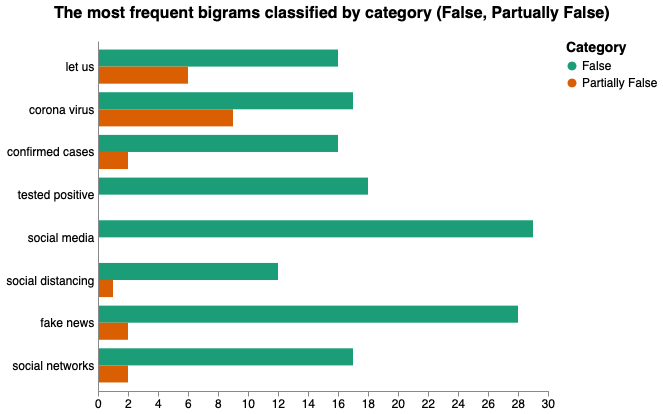

### [Open the Chart in the Vega Editor](https://vega.github.io/editor/#/url/vega/N4IgJAzgxgFgpgWwIYgFwhgF0wBwqgegIDc4BzJAOjIEtMYBXAI0poHsDp5kTykSArJQBWENgDsQAGhAATONABONHJnaT0AFXgACBGwiYdAM0VwAjgzjijTGmUVIEEHVAA2SCBBrGacWTpMAJ6uSJjkbIohABQAYkhuEHBSOgAKSIqYDAluIfGJcACU0iAA7jSy9GgALAIADDLw9lhoAMz1MjhIsrI04mRoAjJqmG5waKDhAB6YaCDacHoGRqYWVjaB9o7Orh5ePn4BwaHhZJEx+Ukp6ZnZbrk6l0UlxhKYAMo0AF7jqACMADYZGxjMYkrNUAAmOoAXxksjCKFQAG1QOInL8QJgkEwxiViAkrBA0KiQAAhLZOYnoCiKMhuPpkJYMeilTwwEpPNCQmQ3NQ5PIJJJoBogADCbAYNm5cNAFIcVLm+hZMDZEBgOhwijY4SgsxkXKhvIy-PugoKIpkEqlEMhsvJlOccwY3n6zNZ7M5Qt+PJAfJoAse3st4sl0qh9vl22pIHEcFKrkiEiQxBoihdXotqAAHMbMgGzUGs60rWGIX8-pHHTGETQHgh-AHM8KjX6TQWHobRdbw3apHLq0rG0hAso4L5+s3fkC2-nA4a-qWbWgAOxVhVO9C9JKeRZQNip2R-ACcU+5edNneDqG7ZZl-YdG5j+8PJ50AEkz63-fPr7flxGD5Roq6D7sYh46DAQQ4PAkgGtei6zpe5otv+4aVkBg7oFBMHWDoEjjPBWaIT+hZdku6HrtGcwETo4h9IRIALheHYob8aHllRIGxgxiavqeREtiR7a-lmHFoBhA5PnM7hwEg4iQfJsjEoJvzCXOZF-hRnGYdJ2FKS4qyWNYoxBF+6nIUWqHaRJXGbiAfTGHAerqC49LdOZLGidZoYAZJj7UegSSLDASmeUhrFWexNn-HZMaheIAQQPJdDfHAigqUxCFeZpYkxf5wH2cl9FqD8GU6PQ2oMGQMCSvqWXETlV55b5lG6YFIAANZwHAOA6BmqkSU1bEhj2OlSR1Lo6MlTnhaRzU+WNtntdxxhuAwiYIPocENUJw1RaNd6xSt9n7ltEiJm4shzSJuWLUdBVYSAEDIPc01QAkjHMRF3nRa140BdxwXTTiyg3RpC1-Utx0TUDoM0IEkqdd0koIODlnkf9y2w-ZTBIyjDAICYkRwPYO3ffNI03vlcVzK8Zhk3ofQ0IY6VfiWP13VDR2tLT6BIKYNAfQpWq9Rk-hxl46ORZj0OPXpGByW49B+IoINOYo0u-Ydfl889AvpTopSRFdWtczrbU4zGZhQCZmpIDgbODdTnOQ0NWMw4D9ldI7avuEgNBOs7oqUwd-w0ydMZuDoYzdIyX4h7dbvhx78sdYYYQs2oH3R+2xhIHqCf7d9ct63nBdGLIVhF67VOIaXkdzH04TiEkOhyYouQ16HJcPXrHcPMlCA4Ayk7B8X2Wp3r0cOJKODd0ndcR1bcylAwCU6GYEAMMr8fj7XYf133jfYc0hsO10ZjSvvPeTw3K-8zgl921ApgLxDS9TyfICzwwfV-K0d+GM77HwfiAOqTAzBIE6joDIYZrrOwsjLLSX8wHyF6g8fc4hbaKDjAg3aakJ4tXvl7GMCQMgIEZDHOApBEhfl9LfYhR0+xgIcHJIwyUoDKF8LbTKFNF5h3Ep7QqMZMBQLUG6AaBD3aMPurrb+U1kqpjHtIlOsjubyLAQyUgLgR5yWFIgohcjLakLmHo3c1D6r8I-oI5epj0BjCMFIhcM51FoBnNDSELD7EgEvkYNUHJDEH1lqAnxCVlJ8SdqopB2sXYkJEXTHq0dShwHuGbZOQi07cRgDAFwIIeEFnSVTTJet8lCwLBVVJdCgluLiaEhJ6BAQAjqHUHQpAbB1jCJEPhk9aklO-oYRwpwhZ0UzsmNwRTbGoJ8eiNQ4zpqYDYFATqOA6xfV6QIkJmifFrBUA2DYNsTJdxqZslB8SnqHJsIPGAKhHb4OscAph2yGkgDGF4YmigGyaxOTYrZJiXn0y+fhUE5SEiTL+QDF5ZSoAVOSkEHpjVglnPqU9OFLhDBLJWWs8FyLnmosWcs1ZYwdDyG8GQPBOKnn-KehOBIJgciUuMZCmlORAgF06oyjR1KFZakDhkEIYgGCKFtpy92ni9YZ3CDHJZQpRV1LxQrLeFQTIVKVfIDpYKb6nMRecxVChlUaujkwBgdZej9ART5WpR8FUdSYKkg8-hQirOxBMrVvyQE2u4jiDashQp2CAcgrMvpxXf19TiBGZgcCREwBav6Vq7EvNmeoOl8l6CIADbE613KOpRoZLbUIGUM3mxTrqjqH1yp+PKV0CRAw3WPL2tMxNYz0TR1ZsoBkXxm1FuTlm5lCs211m+M2zU2oNzds-qW7i+5tTojaWmZxCEVxGN+MeGKkIAR61TOmFw8h5LjsPgmp6u6FLZHWYi+NHtvEvNkEsxZatIGShqlYjZ7qqV9o6rVCAzq6Uq3EJ1Pe0Tl0W3fdxY2O8koAYeYGpl2MfGOBZosGh6UggETlf0sBX60x0HRWwBsv7a2AaRW+2DLyxB4ZuZIuMUxHZ6n8Ghw9CspRwGo85cIARQpP2sHRn59auUgfshxx2eD26kCiKhnj0G+MkaekhsTcYFkmm44RvpDH07YkyI610tAVFQdiehnxjlWPsCmtufRZ6WwcwvdDaoetTMWOY77Z9QagPyt7P3FjmQSXfOU9qmDwij1qzMHaqAH16ONouXAYLH1NRsBSWkiTenVNAyyLIEIW8O6wEgy+3jwHpN6p3MKijTJU00Dxr0BQYXJ32RK2Vvwhl4GVZRQrRgyAFKULcBy52DDfNScAmA9rMDZDed08W-T161ZRri66nzr6-NZPssxpwzM3SlHgGm4b2XJO5f8wrGrbBysuFHmQdKWXz09e2-NmMWodSsbZXYCrCXRtJdxuGhQmp0ocdjTI87rn+NXY+w7FwSHyabcS+FhWwPYFV2Vl9tRP2xtPW6DvGN+E4yNc9QJhINaTBSjNQRkbGTnsxmNp3djSsqjO1XURlswaHqXbmPALHGouEsxZuj7NoGTYBDjP4WHMSnvg46hQTLeNSgMmmlGzIfOXMI-7ZLlHiyUkbec9T3rV6nqK8NlkXB0vVcXb1tr1ufEKjs7+zJA8FRIIGG-dNgnxSidzD+NUDFURNPy91ypwX3Fhc3NF+LjOvRCb0Jl2u6e44nHiBdEpu3UyqvE650zBk6mzKPcJ17+y7W6D8p0BQBsHv4cO-QO1pm67Td5aFya8QksXAk9Nqn+36f4+k83s5SI9zQcC7jwz1JQs2CqENkNvvqydMd7T13rc2on5UK8QCMvO2Ooz-tkM7Uff0r59m71+n6AyshDA3XmbOXfvl85+BkTUSY8QuPwt0To45KdYP1to-8-uJxgyDj7X5nCF66f1v562IpUfTOpsC26j4N7j4gCAF0DAEgxBCnYNqe7gEYjKDCwmAeD46gGx5NYdRrRIBMhrR1Zz6-5rSwFuiLIIgp4P5g7gFkFIAhD6JObwEF6N7OiGRoHswh4ey8zfzlDQASCugKbhCEESr-6LA4HoFnYb767fxiF0TRqBKUGd5YHcSTaUIjhiFCHSFoHTR1TyEX64oc72QyFrSxYg4q4IHMLCFhCLBJCzKf7faSE-4G77a0FGwKAMFf7mEY4xiSqLCeBJAIC4gUF6HEbP5FQKDeAXSOBmgaFgJbp0qwABymGMEOGy7pzAEVAZB0AhAJF9AxE+LIAhAVjB7f5CLq4KwVjTQMAhbhF5EvJnCibiD7JGCOSRDIBzJJEeFMHgEEjKCSguAszbwPYKFj5KH2QDFEgt4eA1q1FPTTrJjG5HgCTDFgGjHxTQQ6jwDeC6Isj7q9xeFmIsgfJsiKDt4tRWarFzCdSRB2pqxwDuEhjnH7HoB3GwIgFnE-a9pX7eGrLdQjo3a5F1qP6fGhFXbajhB9AkoAhO7iGWofGF5yBQnVBMgfRR6w6JwOHAm-7JQZQviQhzrbpyrAllE5rajtI6AViz6AmZrwmrZhDJRPw6BZ7HLLGYFPEgBChsCvFiAzEKx9A3qRAS7Rrr6H6pFAzu4KaB5oz16skGExjGA7y5C7KcYBBTbV48kdSqnhGuAmTn4YGX4glzBiLsL2xqAmSw7dYpGh4DKJFGCrLpRmDqnKGqxmBW6YYurFGeFubfyfo24VRCodH2EinwliAwR+BGx1hBwsn6m-7lBuA7B2puC0B7rSnRl6wJlJkizKANgeldEWHfy8oNhMz0RtpfhLrf7AnZh6xSjQoVKpjeD3Fw6WnMFF4uGAiOn2SAg6DQjQg5lNkhpgLdmtIvgVAnjtnPgW6LF6DCDMBsB-AIBkBMBLHBFzYSp943KLCxl55jmrwRlvZ-CGDbmNKGCBCpIZmHkgDpkBhtbMwlkpn6Fm5BS2nOl2GNlBnNkgANgvFXm7EeqylNzySKRBA3oBkuy1K04ATEncT6DyC4KeCJgzopjzpokuaYl6xzHohbpTQEghYMS9mH7VAxQbrfzYUwryZiKFJdYubgXhg2YDI9QNgBAMjdQ-k6oXHoBsBMCph9FGy0EsUNrgEvSspshBEoKPF-mgTKBbF+lo5UnFqoXfwriahSmqLomH7yVgI4BEx3F8Vf4CU0aqq9TRo6VipsUgCRrRp6AZDdQxrGUlqmXHgtItKJjiC+CfLR56n3lfHm4uVpgMWhBJB86uI-bUXliVnfwCzIEAVYISImTsElExRcFgLtCOUt4vgnZDHLmb56w2wOpjguCQjZjZgCDnkFVFUkrsK5Lnm7r0AuCpjxh4WP6lGbp+AJj7g2hRANVUF5lgJtU2BRAmD2BCoZXXgWlvn9k+IRVCwAVmC0ASCdWKEQXZXkDqALGjmUXxWXpoUTlvgIjqh4wZDzUjGLXfzMbuAug0CkCMk2DpR1WlDnmRqvGLaJTKAoDrWem2hlxjBTBKQvX4QfQRHTrhBfCHUrHHUaVKSIBCz9HDwVznlTF9CclnQIBSipTDUSFjWmWhSdonH2wiXo2NXwnEA7xxiOC4iIZeAqqapRmeUGnPEU2GpGyRDdSFrOwEUbXWZ6zwBuB9TXa6gNn85HXiW+Jgm3bhGU1vHJEY1slE1uAk04jEpqpmnnniBBBQCIxVQ1TCkE3vmM6pgPCBxdC0anGS3a3gHDmTmLL0RPrnmW3NAcJ0A3qlAgUC2g1C0k7M0uDdS9Tnm47pRdCW6+2KA5XkppTG0+gcHjUvKt7iC4YhA4hQDnnx10Txha1dVslxilC1VNh3khG-5sJhCMkzp40m1p1C1RqGBUJMDsoIhsbnlV3LI12OqHhwBsDnnl2pSXWrbpT6LK2yaVKsxh2Bmm2mXhAD0xb1kXUvl-C5js0PRhU9VphQA7xWH9TiCiYHDuX42l0PkgBSjr2+COrRWxU50rnfxH0bBKA9Sty1T80R2mWX3WDqg6iwLYAFzwCD2vnD1snGovXRyZ7J7nmIDpTHbYLZHiznnlp7hvB9BWAf0u0yk72UKR5SrBTnnbyJQuECzhC4JsBzUn1ZXhXGDYMx0XSQjVAlXVCJ5Z4dX4NSH9aDrJ4xZ5ovmWa5kASJU+K5pCyLDQpr4g0IP3gYYiH2wm60OOH5kBzsa4a4FT131sliBXSqxKVt1EzrT-Vw1VFwWfTfXPWyOz1snaM-WLBjB0B6PvVeXoBiICw8KwI4Xqq336Nl3pH5qvD3CxZ-wQNJgYVIUwHIXlnwlOSpIuCLIurMmYxiU70hOBgx2fJU3hNwnvnMymjTTKq2XqU+LeDyDtygisZ+MRMWMYBnzHk3oGIqUoXwklOLB9BnXyAf2qVAnwnVPrS1MmCyZpPwlBAKApKhTLKwJsJo0l0LVC3bhpX9Uy1y12BJ7F2dF9mmXQhOVwBCoGAQPKDZx0o4GZ3nl-ACCJ4Mh4PU2sVg0+LVRTA6ACCUllP+PvnnObD3DqDtPvnm1vhbxRqtzxgvn1PUnvmLLHbraaixylPxMYnwnmJtyoNiNEkSo9RzryCt2yU9qE3Kqcl57JTHYPNm2hR0gkrWMBxbzoumUIigi4tvawCSX4tsmkssw6CdSOCggNmfNyXwmKJ-zy7ktC1wK47kkri6EeW522bKA36vC4422OC0KhAw1kxss73CAOzyQKCLD1HpSNHH0HM04JXCGBzL1So3p57ZxSsFM6tuEjJWO0K2UhWCM+ImupLlWtZ1PlPvnyC2vhm-r6u01lB0AUY6AytdAgUMsIuPPbXHj2yJSQ0J3OysMOHmuoACAG6ivWsOaP0DNxrBVWlgJsiYCwAml+DXyXP5NuvVrZsrARl5MJPgG+BxkuC1RB2RCuu-7ICYvshWOuk261uc3W5MnlUeTwsToEtyRHD7YEHdsHrvm1ZvblD0B1StvcEet1Rn6+v2tlvwIxwkEwnJvAvvkFxI3OFsblXYh1glvrvUGBxvYx2bNDt7FC2nsuAZBMapJTuxFIvTS1RO33ucPMB5ot6iw2H-6T2p2MubXfyRrpY2CZw6KwIQD35AtqXBkfTYDd0BBOASCrsPGlumWOx97EocmvsvL6BRELJXxkAU65uodsm1SKNujyly0S0zNS1C2UfpR0rXa8IRGtxw2-vSoHliOin2RuDLAkrVxcfwleKtCtCoGRAVBXl-uC073lYBD1B-CQgrieP8Rdl-B1DZjbOQi92OrhDxaqsENgK6czwHjnn1HlXFRqBSeu071JBcJ3H62tyhNwFruH5RuQWnSBuwJPx5pdpiNRscM4ccVrKai1SSxmupucOhdvY-VsCiPEeHumUxeW5nBsD0hJsocJdskpdpd5K+yZwj7vGZdC2r5DJUIQDwrhDKVQcNPvkwQEQ14zs7Hnu-k73ju1SHEtGfLOcZfQeJMuWtFUJR4s3xe9dm2clTBhv6d0M+ITc549R132A6AXOZXTcvKQJ35UIZ3mkLs8x6xbfYvGz7ZVVICHcBClaOA3JVcjVyNelgLndICXckqDuqKjVf23ecOGxiAwpxO8un0YZLIVIMXZ0vdU7mNQjHhOG4fagJjTkyVTfiNgKw+LDHhEcrcI8+Io8ahfupOCfvlJrzLwDajpef3b0FM+FW5R7nntdtw6lMB2o23EAQCOC9AGAKb5gFeDPSdk-qbY7HhODnl89ExZBw9o-ccxhA8jiQJ+ATjIegVsPhiwhn3iJUJYLyksfnmWBCydTXLgO4-gF4zYC4Yxy4V6+mWjyLDGQV37Oi+NMuWsaOrod6Jt0t16LOvtcNmvdfPQwBdPRtezvlfDyLKRmGhs1g+0VgJ2rHlkBEhWcCNuvR9amdOx+pnfwKepVHLTND2k9uuXKmSajvsszv3nlNPTRBCB-SN6um-yNl+qAV8jJfs19B+ZyTc28bsB+19tHGuOCtyUL7DW+-cGeWvd8vQDErXgvw9i9zDAxdBotV9C3k9nSiywTeCkCePDxmDL+T0LIMAHaJ3t9N-ZxXW9CHh3DJ802-4pgBweBk0iYGoipz873RUVwVSOCkWy-wMp+Gev9ULmUaZwM3eINEANxAQsTw-7n9LCo9SomQGOyGAz+fLcKvvzr45xcghmI2kfwuoVBT+55ZGpmzeRwC-uPiPAcb26hhMB+q3I9Ehl459REBwfMgejxeTdBeg7RRjrFxsD4DB+a3KBJ1EdoKQxEO8TPiTyGaRN0wDwTwI3yQF79xBnfNWoz3PKM8R0CgKQc3zbpbwlBh-WQQ-wKbyD2ssgUgVvSEEFMdBg8NQULDQYmC1aWHTQW6wrh3AHgVjHvnQA14141shPbDr7xcGGxHeeIZroczLou9iUYGeljtzZKBDS+5fWgYV1G730pBLgNqvvmq5e9TKcQpKKLC7YjcauZtVZlNULAG1o0qaNwQrEo4IgmigYeQNgyQbE8-WPbNkmUPSgVDnBdxVwT4P4qmUu6fzSwBkBKz0QOeLnDIaZQ6Hd8JEldXcHayubgFxwTkFyJdXH4JD-2AlaFvnBA4V0W+olEjnR1TSeBD+PsXUpEL6EGMaBzfF-vJAgAaw1+eiKVIbg5aJRi+JUCpJ1077999BXPN1lKDjDMds8fvJri9wAEWtSMAPOlNuGxDYJuu-wT3nMIeg+9dsBwrYZnCVpWDf8BIY8sgGEDidMAAgsAfAI0r+DFg7WPZqx3hFttCyvHTjhP3hJxgKAagWhHHRyZG0VBWpVXt3WwRT0qhw7OWL-gRD0RrWGsQYWY3l471uRqaBVvDDvYEjv4FAKXtayrrYAs4VSV6qSJHZhBLORnEcF0GXpt0kAy9HQF8EZASAaAcNDUY4BjhOAmAEDIVFfCMCM5lYPLJ4dZwKaWj6AKTLIL53h6QsEB5g-yqAJ+FutUBcyKaFt2QBTBe6mdAMRVA0HyjqC8g9btAnYHkCFYUxNwrsADgRDOetot1v7EDguBkA8gOQQGE-ZCl7qhlKXK4TgDcDaCMY+gU9BXCaV24DjMHliRoAzAbkOcPQMODvTljJ+-MRehICYHqBHUuLEeHK0TppgBx8mVZEwHzh6hYAzkTqCrG5KiiwE6YXDrEMXpateRszNkiPHJLnMvEdQLZtuOhCwIVQ4nH4O2JBYCsV6OrcpN4PDGmV84vxLbvQhnpgUEqivMBByVXpYIK6WQZgdRyz4GD822IzePdRSbDw9BKYuPvWNAkhABxK7Nuh4BXauBkC1lFZlrxeLYhmK84y1tAl8IuRHharRxh9WkLYTGSyAWfukMSE1Db03SFJuSjCBDUCh6cMmHRJdKDIkOYE3oRRPn5iI2JIQbcF9wDCj0GJ3ESBC6CSCJBnKrlZMTRze470BATIXUDABjq8cyA6Ir0b-hawAV7R1o8CZ-x2QbReqMKX8YIOeG-4DJdYCqNhNPHfNLJshQQphJeTl1vAN-axqxmdGt9wCGdSpLACUmpdnu7k0ylXUUCBSWYQvZyIpJlQ24QpNtMKTHUgIuoQpc6OUf5LZKtZsiHgQOCCIxEEC6im7X3LFn9zYhJSaDQqTQEJiQQgKVPICvSknHwBlk55CcRm1qkwIR4wNeyU9DtQOi2q0ABgK1JvFskGp5waqQwz8l0COxIACccNLexBAMgztNSdlXYAysj+LoMRKpIIl2jycGoGaHcVWl1i9Y+gZRPJOgSZS5p+ZG2BqPaKHYaAGEvqULSYrGMkpo0+Eh4E3gLSHpZhPkb8I1wJQYEirHBsrh0ngDQ0V-EIA1KEmY43AxgHPNkB5Gb1YSRXHeoci37bQ4AAglkRex3oJBhKuieDEkFGF5tf8LRBUKGTVp-xG6hJCLi8lJkr1N2qSBju0XJkAcwE4SI7KtSXKrD4ZBTJHuSXIbNDdKplJ3F2TqA9leZJlNkgpycrlATRELCmb71KwgwsgHgNkNgkDZgyYwkCJANqIZAAVL4Wspovw31Luc1ZjgTWVeRzy5VlWObQ0GCOeGGy5gv0i2ZXGcjKp-+a0+PubKaIgw4uyUoWvUCcp9BpyeVc8rRALYqtvZO9EORsHQpvSAZmIsJBtKe51l7mbUhWL7NaS+xneaseQP7FK54TpJ2fdkc5A8A5yFI-1NcbR0f4WJWgLSYqXRJcDd8dW55JPtg3IIDUHSyc7AmmEQzph+8Ls3ad-BK7Do00YQNuTdMQbI4s4JMOgl8hAZQAdpH0t1kAzpDWBZ5PFE4ueWOJHATU5Hd-idIww3VuGlbdtu6XbnZIj5dKDwFWzLkySyedAbIO0X+ZmY4JZmE8scSvn5y0yxswdABQl5U8z50cReTPLnnrihaAC5eSEEp4nzDCCIWxk6OiKQKyEeoWwXQWowGRAGKCxKME3ER6z4FLBV4rx3KA9C-xJk-uGvTTASAPZ12Zur3PnmmTH0zOSSp6NdmmSGFhkNpjgtAgSBJJjqOzIC0envk4i0cHAHGEJi6jo5ec-8b-iEWLNtouYp3GcO1C99HUn4dheyTcBQJUsLY3oLB1hniLiF38dCVQlkxALy5BTIxQWjfkSK9uV-JhoXyp7xzJUC6XYZxIrkBVwO-EqwnjJTaMyfEb4K4oeFVnOgkAiwJHgEvQBcyyGoSkAGQ0FnCzyJ4ItkvGOKaUC+8TRcsa6J6peNEK26VmV+CGDf4o2a4b+BL3Ho2UVF5aKICrwkC2xPo1C4BTvRZAPcjRd1MpVUqViOpXKHcK7jaIgn9wxgeoSIPESQJiKiFqY3-HGBvzJQvZfC6gjqEDDKTshcNTFDwPKqIiRCnijmWmIozyt8SjiuGVEPTrORwi2eTdkKisI21j2DwZjFYzbx9B+UaC65ScVuX9VcCZgHRSMp6XhV+mAQEToOUTo3pVA9WM6bAPqkKkQYJUO5Sotpn9K8O0fToddUYV9y3xIWU5VKheU9RalJi6wV8vbgzB7lOgH5ULN3EqLaAl1FLhiuvluz9s9KD1m3QMBvZy6uAcTKPIKYMrXmiGPpRdKDlPwDApjP4uXQRU0K9Y12fldjOByUiLFeijSmYHaTiqWxngIattzGG7cil+iBVbAmPbkr3538f9G9GEUzorJ4BBEIoAIWHYHUPtIJToCbnpRyCkSq1ScUwZV4wwvCSJehLwjRVtQRktGS1wKZRz24qyR1qYL87qtuCXOXRH3i1ZJy4l-rcYZ4DrACpmA05CkW8rl4bK62w4UZEHVA4fNghQtTCkDimBZwD2+yy9n3RRiqBIlOIbeDjV5pLJgCkSjinu2EzbxqiUsEWXZRCGhrLKVxSJYv0cSpJeJuGW5bXTbXpMo6-q0NuZ2dTZqlVbJCYRZW9SRK-gwgCwQIGNWJ1V1CYBAM0uZVutJmRpBQa2qjXVChaUcvNfhDpApQfg6y4tTvUiAUB6IV6xCbFmvV7CT18ANfE9x3C8KnF8S3NT4yjkQB6IdUkdUywtWQ0hklQnNTvXA1WF0UzEm1SBvfLJRtcLc6eouuzBet+BkS6cg8F+WIbwCg5LtdOvxl6xqgzSJyhnUiWeTFsSDNyezJvWmLvqtG++W1wBJHrWRplBzMcJWojii1r6negVSDaUb8NplTyf7KFQjSf10a++iljqxPtYsPa3DFKMqUIU81im1TT4z8RUbm0KaUTDIzrrahughsa-gMrvTGKKVv+EzUMkGlxhMA7tA1aJruL2bLK6IY7JqssXfwiBoMP+LWMFXhURJqgVwEKlX7EroeDo2OCFp3XqT0obAMdh3HXkdwnUAqupQU3dp5jMgkS5uN3Qrpuh3VmwyJVwxXkNh5VeLETf1KWwMg3sizSfMRrWHQalmjsYmEvVxmRLkAzcRIlQhRFMA+NzigphKMhmVQ+2FatwFjNXowUjWbRZNV6t8E70SKvETdjcsIUpqGN3o66rBR-GaLSpXSvZfxsMGNgyp+4XjgEWB6zDpNNQvtg8AgRcDIlteAIOnLK1+C-YDsLPAzMjqI44OHSC6KdRqIPboNE3LUtVW0kcTf1O9fOtg3KrwTMta29gMoE7T3zaZBIO9K1tuVuQGObOX7dzwyAsyqZdk9jVbJlmMYcAjdJfJgC04Y7VtqUdZnyUZA9aQdBTOzT1BRygtatqaoVQC0WB2oDq5OogqCsWQFrDtqXVGVBoKa0po4aac4JEs14oN6J3OqskTpXp+JAEsuzzfQUFlEq8d3qt1vMzZ5HZadZ2riVjpp1Pcptwut1mp1aR4YR5p249YAP3WDI7isAF1USFQ11BUe9G3bWbtd0ags5QAnYTtt61usfdARQ2NCDWoa6swbNDmgMjUBvQEgk9SJemDw4s5syyunqlmUWDhB+eqeiajBBHCKjrAtTSJXYBOJ1zEADqF9QHov4dI7AOoKGtk0mHir9ZNNW2egE8mh7jwys4gDbUJ7jgSYsCavewGzgOaKWce+mPRBHD1FTOB4UIPcGH1C12qhMagSIUTpfIpqL-RfVVRZjNaWOQOYeKFC2LHSmF-cPfbGq0w5KVF12KuoERPJnQJVoytMq3kLL6AdQ2A+SNBOxFfhQ+Xi6GERSxEYdfCaivtuZq1VptJQV0Zypkz926L79Z9PgsqjVgrTD9iKnxL81sZL0INidZFRBroiEwbic+0HVxjw5Rpm4+BllawJRx-BZpR+4in1DGD0Q4a1gCNBxTMA3p7qzB-wJySGRNCotQqgvmrTbxQH3lukqFCcU+70VSDaY3DMjRKghABhXQu-R8rQR3Er+pe4ZcZJgN3cjc9m9eUzXyo8yeD38aJe12G4h9TdMbb0pKHKhGKBeFUQnvoBhTLI+GKi6oGnI-0X7AJ+hsOQU0oZL1nAN9CQ7-gBCwIEACnBAACE0oKcs9BhsBLRCuWv9Sl0RlA1xkP6Tbf69U4AvgrK5OA9EAR2zKkhuQ7peoLIYAx5qUM4BijrgdcsYAgZVGiyMo-6eHVdkt6ygZHDclzjipg9IRHUc3e9n-3qiEJ6INkL1K8Na7XDfRlpYWR+aNDBD6hxQ5a2cIhA7U965Wjpujhzb8eVB5Ay8nWPDoPoErclIAyujpQHga0BgOeWaSWqO4uR70vHOuxOQ++LaRVWD2aMTSk8F4gMOSh5XXG0EHxmOlJVdD39EjLyLdgpFOPqj3k8Yho0IcBk-HcCfxrYdqGY6v7MsksWBDSISMjHf8W8ZHNjP2xVF6ZKi9Bi3IdjtpXt3VHPe2nJJk6XRBOjqP2PnXDijK2ehgYyc8wDzOVzJp6OydcjlU-E2C8PS0PO18m7YHgSJc9INEDKK1SzQ0b-wxPu7K9e0ozdNDFgYHCTKplehvO+OcNtQ9xsQGrBqimcNQXBo7iouNNJQhUx2XOdCdjmkYLTLdEuRgKMlZSOBsxR082yZK-y3SKabEmyETowAGKOIboFDJlZDJPGrcVZK-xCDi7A50s7xQCm9BoGXQzaPXTboKbjzJtDwMYBXrp2B6Kqth8RCmY41skcqONQZAHGtqcmFYVdP9IYo6SmktTUdOs3JpGZlgGzT0KuSlUdhiA2zzWQmClHUymzJGPZukxUBcDVnOow57iMIB6A55f2+ozpmrFMDyRATmJtnWEEBR8q6V7myVTnp5qT4tzdipnC3i-R8EFDwh1FH-DMCFkkadAcIGeZhM+Jtwmww2K1hkb8nDQEbTFV0agryQ3zdsMzJOYWy7hS9gyIWByaBOI5o4jgQCzWCdksdNoyWzFRfygSl7p025jQ3Blbw40yocLCCwrBwvn7vhTRraip1LlPH55zRvYEYDs24XVzsBhCpgoL2-yhUrTEUXhewJJITAry1-SrQqjHsYLhpJACgoXNjn4wuvdi8JLEsulmd9U4iaPEg7TLTKJKxYGYCKFt0CjRWFsV4BkYCX2K4gc3gNV131TB05qSYh4rsVuNgjsW15T1Fsu6WQAb4NgMjBKM7mXkjOGCldVOPLz7zNpp6I5HWjeX8IzlgsfLjObFUVFAgHZqShZyqBI1dFsBI0PYCrIoqmSpvSEWaO+q1NbaoRK+J8RnqHF5FlLX1gyb-5FEpVwq5iuaMFX+o8u3HR+dN3h9MLoV85ueRubRXlAsVq07MfPO7YRtZY48zRjlPdKerHUIHqRUWBfs4REl+yJ5O3hbQIV017wjChVQ2MaEd-F8nkrB7mGeqMAXjsoHkws8C12Yt6hRdszsAjrPDL4BIA2IMccALljC6Rjkg8VsGidZWEqyzW2HbrkmmOdlKeiM5sc9ZO+XFcUvf0dOTllDDbXBuclTqzTJA35oSsTdYbboMwB4G+oEnFrcwFG0JcHkF6wF0UkNqA0205xsBjYZseV1ZjbbGjzxiVBV0QAt5NepWjG+gDMAM23sbW66uiCZFt0+Dn7YDj+x0S2UcrJFkckGxZxbEyTRzYE5JSpY6yAwJQmhkzd8SG6MQIHZ5VMKyJoMfWAYEva4HstQBr2EHey54AnOYb2J1p36wrCrh3JNgO86gxH0W5qAU9ithqZUenFOHFb+4aaNuvisTUVatETqKe08b3BbssAPa2wE14i8Qb8-EEPbB3i0Wo7oO3BndoLg+WLbHUQgypJxU+t1ekK9BfBZHFwSAK3QAkEyPstJBFAqYfNJQtZxdXnTsYj9PHN6A2wkdKi4kf3uOxvIp9RgcpYcAgYZAxwCHYSkHLIrfT7LPpJkrEJuQ2x5AysNQ3XYrEKxPyNaaGvLnyEqLchmQVNE9wSCpcBOit4qNQwFS3y6Nw1h86RmPv3zeaRmPgioJuy4SjcJQp07vPyImQ6UP9dVHXSFTqpAg51NUiouNSugtSOVUTPdbmMvJgHyGSCBtMPNWjzFHRurTUDQriwBqnNt-gZtElBMKoCxyGy3PHvHzFbeDulBnFBBpXBT4Yb80VGxCgg-SuCZNfPbGnloTyiZLbVTyKa2kZj9DkFobDilqHptfmXK8Cee3YgFiynS3IDqqp5nFkenH23UXdl2x84aydC2A5ZSKPNo5w-tdFNS4ZBvu5AJ6yzaJBDWfrLphWCAwY7Rwl6hj6A8o71TGpTUEuFKBkGUia2HHOtnnEo5GvcQ+g28XeKQSOlLbOH1k-9LlvEv1XXZFD+KM0CurENVjNw6JxtpvMPGOHz94ExUEYCQQ+zmx+G2EgycvSn0aS2k547W0bG6Ud6lKC9CDkXriyRMGavUbofJOnoUoYFAUh+6n3fLCsLBG8J3ZeDELFmoVdiMnudDaMJhhOwU0YFbxr2UCSJVWpEyEgzllZjqA5VaTTAY9LOlbb-mWfBcBpCt63UWfWHQrd8TNd2zs-RkFMDxZFiW+90EeuKnmbMqTambdbtBjzyOBPQoGRztx+7NOyJR3H2tkA4NUyu57s5s6SNLKmvUU-M5-OguRw0VGBpBpnUnroGkeN7OmCrwgi+HfM4s68KoSfCghcL1ro11tLSqVUkW455rskWEuOkl1YrVWthdg8BHT0Kl2qozZsAbkwgBcgwHMClAiakSu0xsGQD7BiX8pnM3Wz8Jb8rtd+VrUgEhfSptF2Z-XTvU50sgfAO8OdPcF4em6ERdYZ6QURrbguM8tBAUmiimfXWZTcceOwC5OdutFn7cUCWwE6Y0uEHC8m13a5cArhwrAp9FyeuAsS4qoOLkjSGtPyCZrAkSwNwpDf1D3dXMYBgAmDCC7W7iga916LPZb0BHEIyMVYWYte-4032LSO+a9Je2Y5WiYG0ELvyUFOPORb-5smQTftqhaIYyEPUEiV1vXDGULq2i8Tfhy18F0BkJQl9cOvLNGUowHVH5LDPc3M2gpoO9wblRzdi6v2YlAnfpu833paqBntHt0jIDGwbHvY1XcGpqL6oE7P4-qcKwY0hPKhJpRUbKMTrRV5o9WNmTyQzXRj+uy-kRAx1z3it6sTBCqLqWqiB67dyVQFnnOylXr2obSJUXdQVaI4IEZ2nH0215IkH3MXjFENQnurZ99qQIbVjT1qTMjmlCTDJgfqcdqd4xzmlhFsDUquVOp7i8+kKxPJRpMIKkorUML+oS8q5MW79c9UcgVCdTtXIjdzAOPrSLxBh8FdyvTnXiHQHUDU5-AXVsywsFKEEygOPH9kaTxfGgkwBoL+Hh9-ZBJxJRIg2zkZ-H3ETpP-6sn5DwrG124jgbrTtO1BU1crV1ZJs44QWPhpgcf6vd-+xJsdTYu0GVRZjvKX-kTcEoZEzD+06kMF6gcoIfMS0p8r2MCwWRRMRAo9ujxsh+EbrTdWTNBykvFd5M38SROEnFktB2CeGy9HhPzcEEdA6p4XtlohqrxdRYZ7ad0nAD3QZBYWoYMphrCy1jpDwlev6BjyU7lRT0YmFGZ2kP2xW0YzgrIw3AjhxDwE-AKjfxvCyPvLfd479BHUsXgL6NeNt-Eq4zqi-dqA29vYcIbAAtXPYPcfp1iB3knRRVfe3R8IUwIICAyDnXeQG5VApL5qKvCuhsyXZrzoebyWDnbvlbh92MQD4iCHF8LjAEDtUIbFbuHREF8DnTAFvLgDYEeiGPCUMv0d+ey-4E0bw6q4jju91Y7k8xh0f2P97K-TQYAUlzwI3gqQ7Vx6wyfMKXgu9Fqh1rW7fHTplzsVss+0P-H8zwR+4hp8oSkIGAO46M8dQ1AZwUMQzx0DZhPGhtTktsz3GJjtQEDIuZyRUCYAu9PXvEr7DEAtoM5Wvn9Gr+dv4LV6k9Zt8eBXB1A7rr1idtVA1Bg-eKkKrHSEGMNl2TsfRB4GTUbD7u7bPid33jmcqNqknXvymX+lPYKQOKwgVjH3ajxHBeOJpghzd+zYjI+XE50zoQZYHlH4atdo78oXDUZ+S5YBwXzV6nT5-LoVmuZxD5tKJF1Y20kn05DRGfqgRK5nT+yKzjLnRCGRhTSouQCFZ+6z3pCxKgbFFkWQPTkA978f17hjZ1Xiz+p49YQkq555KuYP8EkXvKreRyyhBzQb-CoLCgV5k5IYYCDrZqYqqzh4Q79NaPppu4v6T9K+HMnL3g3FUUJgKQwdpnPT+UdxDxuVvyhHm9oZUUFG70CXvoDoiYA75k356wFYClSmemfoH5HoncnqD60MNIXAqKZDHUACAhGiebdQglDf59+oaIwb0qa+DKKWyIAfmR4BrMBsD3CJ9ve5leQMJv7J0NFooDJ+iCGWTPiqcBDzfwtms5oLajyp75bGT0IVpAMobtpbjyXAVk4vIgcBLxSofXggFEW1Np5oMQI4PIDCmIHE-ZQBltiqZABr9v-LiADNpP7c+p0JiwwC76hwg3UvOFURA65tjoHeERgcpAmBq9PTDC8Zfh-7ye-XLcC2EMCvZa8B+yE+wMoKiijQ7sGxhVYUqzRqvj6WcdP8rDqitn4GjI4Fg4ExgnkrdqU+22M0a3a56jBTxBT+IEEIeydN7aEBYCNRpYIg6isJc+anvj55BlCGrSXwccGQCU2ZgUUFmInQr0CVBNimsxKB3ATyjpETQZkFU8GTtF4x+CloUGUB9kDWSMc+miopUYA7vELZBPiMAQBA4fhlAoy55DMFJAAqPpQtOFAWNIo+33NHBm+bun0FjSWwRqDyQ9EKJjYk2gTUHoAvAVbgxMY9sa44YijAH4tBHUMBTWEmrLPZxgrvicH9BMYF44jAirvMhWMPYpAH3BXqASCdIN-KQBNindiopghQsG8jG8NZkIG3+p0hORQMHSHGBc2KilXB1+3nuWxxkochMFR008mApgqh9iT7gq-VNyYAhwge1IBW9fsgS9+vTvopxs0cLVBO20QQzi4YxjLgxBOttoCE8cnIWVzmCQYtexjAGWs7BBURVr-oTUwoUYDN0OPtUEfBZiIBIKAgBGR48hoiPBgKQr+BN5Z+M1oloXch3soEdQeoaMgUAFIQiFvixALFwBAchiiGleY0taExULeHHpoiBYk6HZETUq-pto5VP0wSO-TFbhHGWoQaGgYoUDGgXwRvkcEa2IwSnRzcctC3aK2PQMgAwKmBhwjkUkgayGPktIdQgUAzQZSFxifALnD32qQU1ThUT8JPgvU4geOqUIwBL5LE2XHs8QVh7APMrNiLONgxme-ukK5oUhmvyDTQvHO0gnaAnvc5YkPYYwZ56y0i9RSmoFhPp1Cb+pErHYsTLxa5oYULWG+IwBEpCuAPwI7pLhUAOuFGmRRm-4FBbYYJ458u4R+yMA-QAtYkuo7m6ynhtIHHRuA1Zn2EjuZDhjJ3hDjjnivKjfo+EeukTJYYJSUci0RQAsvK27VuCMlhYQYaIYrZV0bjLYD7eJIalBlQgQFRZsGFGAjDEEuVPVK5AuVBDo3IEjm4A3ID8ruBPyFiOMp3BOYR1DERasF7TzwKit55GoOoKMC2h8JIw7lK7wWNIG89EcnSiYvdDfgRaDEYkys8V5okT2WCkkBp0oDmB4AbGMDg6K2cZgAAxLh0kcob9Uhrm2pucThBJovQypnZyyRVbqOoyYG3sOj2yOrtpHwkBkWrBwoqLuq56wfQL9S36etuyGGQtynAr72lhvmj7gx1orbsALgEnyNyU0sP6lGj5kUZ1+Mbim77hwOsnAqR4VMm5xuatE3asYhkReH4Sb2pbYwBd6JUZksykaW7PgynlSwIApFIsjqg4XHGb0uuUQYAagyikZHvktEPhgXOhEkIyauL9C3CyuA4Ug7Dwm8EpBeBVbuFFgI+cG9BfqLbhZH5kBgE5IK0F-rgiKawdsdiCkUuFM7ikCRIt7zul4ViZ8AnAUyCym80U+EFM+3HVCOIa0V+HrS3NB8ikwBxkuH0wh0bwI-hwKkuGLIakSjiJy0xEuG3RnWrKzzs5Hm6z5Ie7kyDbw3KiKHlR4wixhvMuiOzoFa7OrZIvkB-oC5tAesOz5icygAiBbMK4ACB4kgOm4HCKMinnp6a-nniGI46MRNYoxoim3S4x4+p2w1UhYRlGGkx7O9i9EBflP4xgx4NPR-EV+mbZIehfh5zVM61pcYPcojpOQXwPnOjbxRvWHS6HuVSGfhyYvEYarJRg0leZmqIwRiAkSYgRo4qK3MQKhlir1mIDlUMdFKAfhqwQEwJmdxtigKxJYU7Ir0BivCFYBMRiCgbBlRgcFBMX4E+Lzy89D4g3OllCxFMs4gKLC2w9jA7wExD4VrG1cXsVC7S29lgpxFUTlKry-eVMeYFzAAgB2atIEDjGaK2scXJqtAZvurpphIAEnFOUSMTcIZwwdghwsgSAgKCb6OWnqC2Gnzior4Y+auXQy6itg5gGAFXjHRqAPCOQG4+Qvi-i16jcffLPaidKsjKmdISP7Xo44BqLKwLYhOxOOxKrgxpcV1BXDx6Zcd-y5abwLDThe2IMXEXwddP3byQoLsKH8R44Mt6YxPKPEbcMPfpJEag7tEc7XgX+kVaNWDAox4SIULjcjXifMW24+qVYcdrgeqXNMaIeQETpGBe7VPCgxYLcKaASe10eZw3xvMf2HgxbrPYInCrRIPKxYjjjtGPxbrJ5IxMr0BGE-RomtAlTMbvGxoPxwEQUz0gHFHShaSqQcCSFe2EPYoX2rYaFGpiAsdgSgqKPmFLzBy0lgg1MmmMvrSxHcT0DjOr1ulBGAQTroL7+Xos0Z8JDwNuAzUjjj7TKyPlG5Tc4KdNgI3kK0nkjmx53qnGDBf9MOAk2vQCODMyvka5ZcmSiQCL2Bu8enCwAuDOJIbG5QG5GpxLRJtBfIGwYppbQ6UBbH4EeTi85zWiwDFGphYCRm5nWzdqgR20+ToVGUeVyoeLR8JIjglfxHUFlp3MM8r4Qzy31s3HMxZCHElIuhYr3F+RLyErI7s8pLQCN6CsZ8iO+f8p6a+kD6OtgGaN1mrBysOiQ9aI4POP0Tqyl3KtiyhTMdTFNw9SYHCNJfvh6q2RfVMAQ7oi-G-r2WsgP0kq0LgIHRxB3gSGzGqCeOSGA+KiXlwXSKDq37qo8SXKFjSE4NYShQXtNmFmhkoarHrJRSR2yTK4cacH6wluJUlG2tSVE5VI9gHD7r211NEmBWq0YAyG6n3JIznkyMK-x4RgqMKhVJ1jmpjWMPfiqGkRp8l6a5wsgEgxZwxcrfaj0bYvhDrY8CbgmIJfALKowp07q0gnKqpmgkGMWBivTA4M4VeQR4AdiYQIpEST+a8W5cS6pFYO6FvoYOjUeAnN+3UhTQqkkSldbyYtzvhLSBYCEGywqlXOQimcd8ogDkILms7HvkiMqQABA1HmoEEBOwYxGecqKcv4BBeRtojwcTzjDg+018fVEqopoabETUH2pfY30yzBfoGpsQpYaj07wekre+kQApDU6SADKzipNwpol2pjqFBAwU6Ou5GJQg5tCpJhApH4T-CYQanH7SYZFXSBmQdKvEhpasPMzspCSS0mWMxAMqZxxqceXZya4fgcF+A8wXJAouvhEKiJ0LFtOTTkjCdOSCyCnCVSieilCjaPy5-sDFNMO-L8l4+DONTpeYTgPqGqhcwENhNphllUHNJEcegDlsqjD4CixZvP2nUseoiB4IwAcN4BDi3gMOnvJCMHuwTpoWsaQbuuITKm1citAchLReOAWK0gvvubScxWbFNb46L0aQmKwR5uTaVcJaSuAa+bhlil+C-+miblsAkibovRv+MajWArPMSzli-nEtSs2Z3EU7ABn4QgkEyf6XbDVAZGgVpLY+6WwLgZppMR5rpPbqzoqqigdF5LYHvIIllw3bp4GmB34KdbfwO+C3j7SyamDEGylkXbxoCRnCTGBJtXrOGmyY1isG-An5hSrHptGdHAz2yKZQltABXkqlsZF0N+zwORVsem+qCQNRnNpwKfZDrGG5Pi43a+LiFwERS4bnptwSujek70onO55Lh2Lrk5xRXiQu5YihsNKotUBUYlGTQTIpvYQkEwuUh42S4e+IaxPCYkQ3axft97hJ8JO+LlG8GWs68Ge4VA5M4pZKbr2xDkjyqyq2JsrDEJwahkoqcNGmgpOAH4O8k9QfUO7Rw2OyW5bshthvJC9BPsQJQssFlCiw6WLob75JAemtsk6pj1vln0o10qnGnqBcG0ibsJvB7aecYqUCkJZT0FRYKYGMSungEvsLbCdW1qSGyBiKijKyR42eJCCKZaPBamkYmLH1DNh5SOU6bhWQrT5EwvancTyxSmU-GgSC2SIkswwPhkAkpFTOtmcYm2dGH0RM4Ucjj+qULNkGZ5Jmtxj+ikBlBYZn8U9JIc58G4wpIdKd4nhUj2Q7w4yqzh7q-4tEIKjXCS4ZVoVuiyAVqkkeEI7YDpbJDQS-xP8i0rtUcmsgClZ13MRZFKxEk-x9A-6Ryk4ZTMmw4joMOqgmHpnKT4gTgEqW4QUZhmdxAwpjJAoyGJ70pe79wIDh6Kk552Rriv8iGCA6M5ktjJj05T-J4k05K-rAZSJRMGpxbMrSMJrhB8YB6J84t2anBjK4uZomfGAVHXSpcz9OWjYgIDCJkNZ7TiaAyMs6DnAjpHtnHquAFjurmFZsxEbkkoBgMZDqyS-nGEW5VgFbls2l6p9D2WrWEOgwhcYBdTG59IRkpHadgCOBQIU4v4HZ8zRv7mbE+Kp4ZGJ3EK0A+GwFhryFu4wa1lJCxfiTg2En3jYSfqFaR7ZmiGfLAjAh1-PfER51WLnny0VTE4EPCmAV7kzI6KtSwxZp8Qnlsk-aQmG2+IqdQSg5U9s6GEm7IcHIiuJsRXmkYPPFg5Q8HforY8uRgPW4RWrSOmxTiw7mln30z7Fg5W0LQGXG6iT6M9Ybhr7nBmiqh6qnERyRgCz5YZk3qZR757MfvnahUcM-Q2CBcQrGIK0TEwAhRqyYxG7WSYBHYTWRHmkm6JCsFcQoRtipCobQc1t24lprTCJLnhBeWfkN0xKcOlMpaDJsl4QMoZrbqKwKJ7l9xPAcQBxpPhPpb-OM+cWaHKvLlvrdi+JrSpJ4CXrHAwU9lnvhJQVjHbRBu6IfkYy2YQJfD3qwgCsbIA0PoiAkhkWRAGzJIBd3j7R5SWj7KypyhNFGKTKqnFCF8mOorxZJuYULYe5KPem4sRtkSxpg-RKXlj28ckqTo50ad2kgAahXbAFwP6TXJSo5QbCrTS5eUgWW2yYPfIyRiRPVmSFRmaYzkFsGl+Bihh+BzDQwLARHxcCKvEMl62XhSR4OJGDKAl15J6rxwOiE4uDl7OUDOvTmon+l6KXxsxLlRG62-obGORiaWTAHAwsN3ZSGPgUEBV0LWhMbSGWRDkU6cw-L3w52itqh6JiGUj3mmFhoYKkQk7gAeZlKxIjpyau5ym9DbM2wZgVC07RRqBUSNxEHL9KwAnhpSBmOT4iEaVcGEWP8egVAxbQo-DfYd5DIEaohA1TOyE3Ct+n8RUKKxhtr2y6heeBI5TMqkjjZz8b7mcFgRY-xHFknMbwHSBYrbBb8dqHGC+AljvflIa1AddjSQ2Xu2CkE2Dkvkty3Tglpv4oRYAz00yTAA4MQFNG4E82rxqjRuB6UICiGKQJcolcFdNN+wVI7tDXIISzIRMUsqUEN4DNigIsuYgiRGc3roZGspUrW+njNb4gSEatqm950ATkxXw+aPIEF6EhTSVVmcAKFCXUlEdFm9Q2hHYmt2GotggagQfFp5D5qcUPFQAFoZzGlOQGm5Bv51SSY7NE6-OXrF8ipeKlHC-wdr4zxccBtpXm-gAIIMZ2fMek6lGiovwNFQ3hpi98uYtkYr6fUK9C4EYgq-poEYgkTYORGieUgtoFblBkX64kSjiuMmRlUXpJqKK14NxIyIYA78KyV2knJgcIaK2lFAOVwOldpeVxXUX4kP7s5lzojjechwMeYZYWGYSXpWS1AViZs+5LKV-JPPseTLylhrgTMl1RdxDllAhSrzxeNYXF7MwzYjCmB5-4s0atl5JGEmIlryJsJLAOxRGXyhReOyEbAp1KlD+l7+R+gTykVK2hBljXgrFxkfHDgiNqjMQfkUs0PApBZWqiOfGYqsRb1aqx0LpHjmRz6WHhBmH8f1FgIPRr1TkU9rghn-cCxZkR1+5FHRk9cj+J1E7IBIOtBGxhPA7CLMQ+oura6O+VtnvkrlMeRuujmdcyFufVOGVS54BCPlwOsZmTmnQyDu4DNl91EpBG8Q8E7yIVTOXGIZAE0UuYFhxKqn6QCWFUdgk+oEpXQBgzufIm6ZckCCjSJ55MnEpUrZSsY+AsCJM55JT1ulA+a1hSyVlotMlbk8mvpbFhVlAZcZ7VAxhjoD2h1WanEyV8mAy6M2qcSWa++OFuaqIYoXlNE-+2OWMC0ItkVtBZFLYsHrT5VNiMXgOHFDwlesibCYXiVHUOH5vMvAqrDFldaT2nD8fFg4lzhgcTsx4YteZ0XhycCBooLay4IgGieGGjgD1ArQF8A4A13tmA2Vk5TWU34bsedLsZg5WNJJVPwQpABI68uyCKQGClTwGQ9fq36FxDftYSb+pokHR2wW8CmFRBPZQUTkk2YB0UaFJyVFzHklvAEV+VozkFJ0AjgP1RZyNdnFVylkSVRgjwU1DfzeAdBprFNVQ5ViAQAwgETBeOWcCFbRoH6rdF8V1ZbjBZC6oDjkshtVbRX3o4nPZbweVLCiKKSWvsXz3A1eKOB0KzlS3H2QmekcLN5BLIXyUCzqbix9228PETBFmxGGa+A9jNNDtYmJW6ygVHCMFrTx+9qDWd0rRuvKtGxvLNBelAFMxjOQKZfDVG4VaqmCflHnhXYe50cNWmkocgsTQMcN-Oz7eRb+EMXb5j9DyZBBgDEnyuE0jj2XoMoHu3AlBj1fIzUBSNCjTdlpxctn5FUfHI7SpHVbma2slSh6k1VXNW6y8c01EqF72yleQDL0EadUBg5FDGDnYscasdxxqIAgOVrlQtCL6OAaWMtTUl61dbD61obiFiLasvLmV+YzRmJql5TcU8XgEZAffJFU55GVSl+ZmqmU1RhAjiCmag0nLl-GbqaKVe11mv1Q0aQ6ilVa1O9LUBGi8Hl0jaeYtZZqB1MdXrUFlJ+YGF3VlII77QOP-vHLpY2jinUtpzNvKy51SZd8F1WPZV8G3yABGWCx1AtbQqjwI4FuWpxZ6jc4qwfeN7FTVY0jKwGV1LOyCUIAYfnUQEsEDiCVIMwHrGK2GzsSi4iNFbPqM0dAb5Xt1NJIc7lQhuEJH+kWdLD78189e+TIw9ANkAz1HtJ94e0NrIuFxhgqYlA44dNXHXU+oKl0Bl8y6TXUSo5CHlTTQX6GgxfongWsjPUiBbZVAwoUB-VtpTMOqCOAciYA0jgSkRd631GwMpYDVJZUVAMASiToWJATSeHV4JnJBiXVRFHh+hJZ4miwZT6VKg+JBqnBHtxRhLMI4BsWEFfbVM8QSixnJKeAFRp-lURGlAmp-EGNFKalpQxVSSr5QqahokKaVgZVM9VdAWJn2Vw09UDIONksgzvhypb8xBhvV21SQl+ik+uDKrmA1RBIo0yMOgFGmyNbJEGxIMzvEyJEaaPoHwhA9XPylKx8KCT6-xlasARD+q5aflzAwRe87eAJERrnp2sap4K3Jr7oFYeA1vvZaiBrYv2pPs4jXIIAUQ7kmF3AMLC3Q5isLO9jgRIhYY2IwUwMTxOFFKhKHbGwTXO5VUc7rk6L5ztrizSVBjmHW2NDiGwBGaAQIgCqALNXRyKFtpB4CTVmjfPwu+LoIPDVQMAndHg10AkaySIWmH8rql8RG8BXKTFanLBGJ2MLBG2q+iM2dsxydNW7od2u43b5fBtF6hlMjagD6l-4semrYvKtTwvkSTdnwpNf1n0QTWXCQqlB5QquM4aRlhdXWb18wppHZ4RydzZ7hCzcLyPFqVcZEvEUclAUFJKSJxEzxVgIySfGODZ34uEkvi0o+5sihErq+lDLHFrV39fZCQtcnMeDgVPZQIDwtHQYgF-A5VNUq5FJ9Ri06cjAEJGSeA1NHxKVPZWQzRKQFeqIwZKOLC2C2MUDQncQsLeSQtIAgOJ49ejLWi3-uittUAFURMZVTEqBKVbi0OTzcg1XhdAP1D2WU0H0B+oWeJ6Vj16YMErsoaJVQhx6ArpfWvZW-JDkLcxWJlhIYmtYU3skWraQAey4jhMa+EKtOG5DeprS4S2wYwPbkQMgldgYMgcNYrYOte4Ha3U599WfSutUqLSThAXzYrbetfdEngHZKirwVOxddD3hIYFku1jQexeOiBVwKxlXAkoCAKlmXNBLEm0k6FTf5WZAIQMQVONNhdxA5tpkakgEgaDEW0jgnUH2Z91omTGDltXfsOmOGkzWNL-o9bUaKpY+ohoo3oXqSMFyEbSAxxcIPUnIK9t6YND7w5yjf369M28JhgwofREfHJB8HK-q-E50n3iONzuUqalAM6NyFVtq8Ou2fWjgHaRCRP5Xu2M04GM7x3pZBSKwqgCFpDYuoOBsZW5Kpurs3lErSKJ4ItKrWAjPtLeGwiv0gREtWZAsVeLlY2-qT2UAd3ChVT2WQ4QEDGNrNDEV5G2LQEB8uK7e8gP03Qhu3ONRfhprZKagJYn014Hiu5Z1TOJAx71c9XKEjZFAnzSOotRdUjg13nFvbYgPWWPVCWfTBZlDegCqK1iV8VfJ5n6NzoAwlBIyEObFSSsIhL+A4tPZb6OCYqHGReL5c80BsEXuLSeW0Ce1Upts6m1prGbdXU2zauYuqgaxAkgU2p1sFpHjAiuxqVjZa2IMlB4toTCDLBgwbeAawFRze2WKmeaMZhKF-8XAV9sm8CIrZpppu50TYgMV6XPy+9Bm1k8qQr76LilhvZYoYUoL87YMuJjvyMxsFWhxVQ-CX6Gbpl0cgRVhLFjCilQj9D2pwRj9Na7qyaDpZlB02NTyUIlAGYilYk1AXiUI+gEV6K0t9kFV1v8RIaVC21y2l9kP1twnDorUAJcdEp2a-vQFLZbrEn7oo65FdDAV4wolASaboHygwCyOg8aVZIbJEol2WTEwANsrmW124Zq3b0Y5GBWv07SoyrQeFNRRSuUnoCarieX6KqSPJD3qE+nzU3ViSXbIYCboMjQQAXbmXbLB0cP+i3dMaV1AitgsNLVAdTaRhQQZCUBk75VkeK1hestBCVjzBkPR0j9QFAL0Bsc2DHMrh4kSgCDHgM-C-khspQeBlY99fPBJ4wTlug3FWUKObF7gOQE+ksenDBDSlBCgs-CyAf9gN1kuKphLBakvDDOG8ckEUsAlQ4nEtpxdKUrqJ-+boGenpockbTZzZ5Pc9naZDsRL0KCWimt3CNeVgfHIibhGY0At4foYC-xonZzXutZsc07RwyYGmDD2uTQ7BVhKkue3JuFuG6B3G8CLkC8owInogNtZ4iCA290EPtYwoDvUzAI5r7fkRXSE1rM2I5BOSk7Coq4gEDpiSDDV1ndIjUmJUIAgPJlCN7Yd-Cx9++ipbFN4KQ7BnZHORDgWIVVbSGuQGfWmX5Y1VTyaFFkvQtF6wrQCkgliLeLdQvOt1Jl6De5DffQyoOcfiqV9ybZw0J9SVG31nMcfQnqp9yADzRCo8uP4CxdF5W+yKAw-Yl1Zi8fYeExkwYfSR9QW3LOJ0NmdLOKbw-fen1LhWckXJvYQLYrYYaoufjlmVT0J5Lt0uSTSaUZ2fhPSXU7LaE61ILhUdAPtZaF65h6qcQAhBG3OUy4gceoIHFotE7YNZQt7Hd4QugAA6H0x5UHa7J7l3Rmi2AoubfxWrQrRJ4L+ZYNdvnIDl1GS0X6r+S4Cv9PZW+Dh53vThytknPjr0+KeJGTXXgKzYeFQD3EPUEdsKIv6Rx62vYp1C0uNVQjCFPZaMzpagrbq2TMucI9mvWhvr8VlxHTUyBntExuo4PAFoetCq2AXfmykkEnKQQiD5VeaIPAUoMXnXFpMJdQwpbHYNX5tNAJYAGud6LWm3VMYEEH4cKgMVIdWllLPqtWQWhihfIetiZB4cBcJgal8FNmYIU2ATZ92aFscH8xkqYHarozCtVTkC5cVBQb4gy3Fo0VbmL9J164QVusEPT1OpD84FimGEHUCoYve7UYNQMGL3UIccBOW6DeriiJqwPonn2RhCYEPjRoWRaZxb8icpMx45PZZHizBzgnSrQ1dKnvXqiuPWrRcdtnTbLC2k5KmBf1QA1PzBaKMs5QbegHQQOc5kDt16K2PRhB4OOJxSQMvI8w+PpG43QqO2sBvECsOScm+jiALZuJmTQcNUnW1naghwyanh9Kft3YhO9Nf3lGcOgzA2iI1yW6BnAxUn3jxpldsYN3dHCghSw1GwxkoohPzYTAIAsg7-hAjSxV8AIAvgF8BBAbgHW7GWGUEYC-wVEfvY6qEMsq6+w7AI7060UwcqYPG3SQN4BAjrHwRWMotUsM8B8gwZ3mOQjrKgAtIQINkuhhYMpbVDl1ALDkl0Fbt5KQ+eZMP9oENXSgQatkSpzHgQo9mBDZPZUKPHgIo+o1CjLViorijNzOKOgZAvEKOgZUo-C1Kcso9KOKU4owCAvtZIwrDajOzOKOXpSo6b54kRo7qPMDO9OaNOx9PCopkFjoR2h-DGTFrZbVQg4rZnA92Dgy9A3breFVer1lV7aEuOPZZmDg2mkJ39DrtQN3Vynq52dC2FIMMFDpg+I1Aivvlb7FQo8R413pygBWZOt92fqasCKHXm32QZwMMLAaEEeyhZN3gycnICiwIi7DGDQ1YDQ+WHdyMPBHOgkD7Uq8XeHFNbKEV1INPAx86ckTY3qMtjIMB4CtYoWISbkIY4yOBZiMMa-pveKpKki36CWmN5JZtY-ICQR7YyMENj6422NdjLqE6PLDn0HOgEg2-vGMPDcwOjVBK8jcqYHjT0EUMciNGXtV8ZX5pzSqF1GLxx41-9otzqgv5ZkPE9jWUhwaRCnWp1k819gpDqjitopSyA5gOYABw5gBv5ggADS9ZLhvfODpLpbAg01jd8Xfqj2MSadxRcUuflhOkcOTlmNYACKULbfwTJKbJujjfVlw3drxKCjDaoKO3DGyAPL6hnGS4QxxXWMKOxNXJ62smieqY-SIFFOqxpBDNAwbpE4JOLHDMZ89QtBpIKQpEzGj0wCev4n0w7cA1r6Iqna10K9blvHK4gsWG2W9DiITt4lxURWXFUpydEJ1YjiBPXGE8UFStLnkLhixVzFbTW-hdu2GDoan4ROfoXuJTsp+Pg13WhJw-ARokvL6iS8m+FzwgyTQ3kdPHZ8Nfdspoq3sN5xl5KKSCysIPeSCXvJEDmdJFxHGaywNFIZTzYrrFcjQ41BQoYSZEwLGFMbjnimcIMPt2WjpivWFlBItC5D5D542cETufxHzT3DLlR+QDK+vW-4UiOnf3XnSVbNF5YIbCFvk9lNEX-Hi0m+ubFvOitWqZY1+aAAieMFVcXGB0sphT29uVZJMnbT5BRLpLhnkhyIz9h3RkrluvHGAUvs-2UsomENirPJfO6JpPQPAqIztN3lPiG9NHA3QLOFF6P04bCvAOoJBGCTkfYTmKNwM1biOGzHrtMDI8uIYoyqRE0LSNuW3SVNUJ9KaUhiFEnEvS8cuymjMvZC4ljNx2U0LlQh5wOThN2wpEnA07weudvlwZ1eWB7E+IHtYDTSr9DYkQ0JlSBMQJ6YMshjmqHjg4uEWYrcpzjtypZSz1lY9NXm0EuTcJGaHQhcJKD2XvYAJhFdJUFnjvU4HQVCJXZJ1CtFXRbH7gmxMNObtHU-sBjVZVR3kWxLMCuHATxw4lytwSuBdBd+a+bRM1uRdWtNLhACK4BHDsk4-w7A5aSMIvO7OgEDR8GRDE1aZZfWKImoHIvmjAdpfetGIJQqGfpoNcmdt5VErOetYa8dwMhnDwIrFqUCTXmNVCDJ6YL86bmmLanGSphFkf0bKAmZ5yHartQbOod1WIg1ja6UGa0y1ydcXUV1cU5oX6AdQ8FMJs+YN+qlThhAXAMMK9OIVtTvU6-4fsyMiCN7SBECDJVN8I8eTiaywreMKwjScSgeA0I-qLQjFUNBCrz2BMRJZZLWS2CbW88ttYv22lhNEKgUsmUXgGdXEDnn+P6YVUhzzY546kSPDPnBBy+cO9D56-zR7bjTTqnWCaZr8x2R4kDs3nWGzDlt5ULZlbfXPi8MC3KrUuJVKJzgLr+t37FpPQ-c7HpFnOzMPT+89n7MMXA4AMJjSoCjTu9roTF6aJivhqKaJMWJmpG23WlY26cFnRaCEme5kiHWT8XRwuWUWWqg74Lerrwut+WDuD6JpUwUoxqMngBoz-U1CKYwltK0-dJMDnM-HXHkC+Q2TbN-4k-00DngOD3ltbII4IgeUbgHCVwVEhzPWzlEtCr9ELqDPOUTViwhEGTddPgrooQ-QwqAMmasI6hjnCxDnRjQZohFlxqBUxIFZ8A0VABL+fG-67uni2XQF84SyR6iGESyBFoWjqNN2dzJyQlNC9tsGFwKxtCOJH+AI4K7Puj9E-cKIzymdWLqtl0QsZc9Ii6HOxzdbN2ICzdvoz2KmdIygEpxVS7tFusTk1LObhgHsDKZaw8G0NRMIM5T3LD+LaHFxgA5V7Nk8bNZkUiRVsxMuSGBlTMtj8zkOc3QzH0w5JrpK8uWjEiPaljqs8aYweCSdcy1iQYVn5egLaKRSyypwZFSNXY76wORbg76fvjC43aPUDAg2dDS8RSPs6E49MoT1gSMyiSdc4WM1gNKXN3jFYUxNHWZJmTYDWLYCBCuNqdfowDHzDU1eFLuEBmsDeWYHYBPlC0Up8gkShtOLNjSBtM-yH9DQ+LnbCsC4Cu1BvsIyT3Ao4Q4VMzcdOsH4rwZMwAZwhqIPDEGwoe8mnslWQFZBN1IR4tVUkeGcx8ehKjmLpLEiJ7J35Zi2XQ2wjnf2UHpPZaFwvuqcZ5I-A5CH9mK2QRhqIFjQS2QjVQMSi0sgL3hFWzShrOEyuip3QKFDUsklIpKqzJg5cQ2rs6ELXkruq1PwG0xKDanQNvU56s9tvzJkSVujdbo7ZTbWErAk2jHBJrc2ygJUZQ15-u7gggoKLnCOq1mRcvWCSa6XbkkgIPgMHd6M6nyZrKLe8s5BpK2gNnTcfHV1XYxa50tVuFExhjwaLhBx7ZgsSk7M702YA5SRW49B3Qlr+M9L2uK5zOcxZreM1L0vIvawCCUMfhHcQprF-BTQo4gmnUD9rHfbP16wM6xC2t4omO9NuZ38O0DZgUE6B2Ldj7E-QEKOq4bV0wOsXwYtd2s2hRZE6KEjWrM0KxkwjDmrkIujsaPpryaUdsI7DBFngHlq1q6HbjNKL-flfAv87CMQvtTIAOpwhJy0gWIBA6hNRFaESyOgZ-zpcwsFoGvUBMODzCCh1k7sWc5359Q+FYTAKrRq0qD6uE2IPF2rXw0raaifLpAziA++h6FUb++pqAQAsgJAgBD1ZhdAuZNwgHJGNObmhsXj-6qlaYLcfMHn-LmkhtKQMwbqJvIOEKYMirL666wiT0Ck7LVTER0wWuYW0fEpvPKJYQcuDLMM6Aak49kQiORKwNfBTJgDda0uAZaFA2U-ov9AimR6R0JGMWBeEKlI8WUZnvNl2MejjXr8DfT2WQJsJVb1tBUNHSLuT6IP1QABRrENMuTTawUyhbysxl5YI4w2uvrdO1qCVZpE7FkK3lsmw7GxwtxM3QvzFASR29mrWIsjyTRwg4IPGz44-gP9AEJoszWDqNHDt6nevn0e1LyPVsvgjJJF4H0Mc20vsi4yBKmLitDd83DwqFm3iVSA6COAJNMdHVy+5qebaSDRpWKjN-rA0cbPEomvgbXQtMYPgmc9RCdlY0tr40eagKoDMFmEN9FiZs+MLWyZwQDYfCRmAohncH3w0S2hbVU+rAU5q6G9UcoDGoqG0ivrOzkEpK0AntoOOfbq-ttDYMZgLevAmmSmeqiwMqgCuurZweS73yilcksSzXrtUwoW-C+OQqcZC+ODF8XgD82nqSFOtMnb2SsXYWzCaRwPBhXnP1uvufHHh5l2BsE+UqAhk4f6lI+iWsYnYHW3+PNG+9JmWY71RhMncMkMkFXStKiSzuuEgU6XXFgnGfzmSSS3Bzt6wQRsSu85iqbAYgtKolgOy7uGUrlGADFFUggUD2wkFbUP8Y6EB5JVHiS39iLaOuCwwsInSW7KVrDnE8eu2kG2Y5hYsDzMnHorau7SziTnCDx5B932Wvuwy2OUhqzxuNIgexbrG2gceAGk2Ws7q3MZorWjssEBzXfbn9tM0ntb828B5PURvXeqB+Ao3ersYYI3REj0AKWR54o+GChAYl1Ak2GbJl2pf4n8pcKneZKFNTD1P2r6AKwMUcryg3K52X7PBYmgxo3kmYAl6eXuFxwqtGjJoUqAjuYGzHOfWBLR6z2mgqDtdDuz7u9OFNTiyyM3tkbVEwBSNDCucdPxzb2B21tiRPZRaATTvkfskZLcCvxk98Q2V2kpHnK3DwGxebisLxGYzkaXFPeAz7pjqccVv7gii9KsYy99ke3x5we+NL-FrPqnH5w+puIhwDS+2KlUI2g+PMt7WICIPDpTzTuUUq9m5cTYYXU-17x7sO6nukq8WgJvEZYoolpJ+HoTAjMZrpc2LaFSzZQOpiazTWI3IrdQGs9liVsweP+N3bfbN0RNpJ0O7RYTtZtDv69pOd9PikORV14ZfPb5bdJh0h472SkNj5zVGjdh6AJgXR4gMN8WyjKetmUuFV0mhxCRpgLBzfuNM3fFxZFVx0d3z5oiHLz1CTiONtBMgvBWfufKk05fuazM+2tutpLftV2ILCqiXv++AQCwb4mi+24et6ok71DKo2PXzsbmF8IZqOztVaqpbwtjNqBTTBGxwqG71hpCpc59Q8kcOW2jU+Od+e1SAKHVeGzbBW4unLSrX9OIrkcQ++R2dI2DZsxUgNduB+yQWhluF+jqKJbXFvm5EkRFY+G4h4jsEr2CM0xvYvsq1ZOUUO+pv2WYxzHX5ULSO31-7pzjMeVEGe+DVYH3XfvYF7+VLMfnrhhjAjrY+gD5WmLWx4Zx2G7IVF3kknaYcc+KRMBABsg3Wmgw3H+alYxEV1cTMD7xF0L7sjHdQD9JDh9lvglgcRe3+jqimQCTTZ7S+vUuJp2IErGOtFc3zk1rTkGiaRUcicWTg6KNtLz2e0vDjgar0J0rtdRnLFcq42cS4xoNRmmBlnfRqcbWAPAbIIisLbabGo0nxBx7q22BMAGdBUIvaSe2u8bexH1DLflgMdhlboPQOwUDIBdEqbLyPyctohapMQybiW976Lc9pN0iHZ0om6AdSyE8KeBlsEA951kpG190ancnTcKvAou-WSNHSNI4mwosi4Sa8qUfrJYFAcnbExWztsUVa+ZcRRBA4DWYHaeYqDp+URBs8qdXEaTAFKol-KmYkZqbFuc7pxrWpRYmm44mDLyjabRVmWtzAJJuZLOnwB2+Acnee5hYMUSxSqXAbvUznXd+X-VADog4VcQB-AEE4mkmJ0BMpYTHVWS4EcByXe5GUVh9KeZLNFx8sM96J0R+J8EzHCgM9lGsR2fhEUjXUKzFXq4geKxPB64dDDReFHs41a2lDsRbZO3Y6qZ4QaJMFwRmsCOpnDktiWgoRuDkCxYWZ4gc3ozACjjb94sG5tWEHsr+YMUEDBaFqlqUOMgFi6Z1SYSOb+KB5ZAyyKDtPQz51USdQ0EuLBC7iq8U2nMMlr50WIPQWud6JevYGM-JfOHwf5QzRsUqAXr7sDGtHQ2hfq5iziWROWDENBB1HBPdMG3YXcFF0D-orK-7U9lN9Se7IEfR-CSDaGevxbnKeeDipWM0KbdhCH0F5f1iZPjI4g+09WPwNbeqe-bNxH9u2hlK8rODhirb4589C4MvAthLQevxGJsXbDrufOCOLEhCd3m2CJ4CanmhT0bb7FF3jx77IFsf4pDx-pSUvBLdI01vniqLambCCUC4DCAoUIrJgHPZTZfkIxxBLj6L+9s6jFiNwpTpQWDWJgOq0TUtgdPHKe91Nsbo6NsC32G4Bie1n4B7jhkXHC1wfOyydA7690Dvvipj5itslS3MeIlsxBGHBaBeL2VnjxmvQY5yQtBQRVz-aAOYJXle2ov9mLSN7SNoetBH40u8y3ETrj1Bl25QEQwwKKVSxdIVoJOTMbAXNHcgWW1tkoiNHo1-ipB7AOxusW6BV0OdkbHBUM2RUc1191IEU1ApBdaZdnsaPUpJ3+cMd5tFtKcxW0sPXmrLeTMBaWqLKDGCX-WEcoTRMKLdv5c5tVdcOxK4ndvIkE5Aded+N175N9q6lrRBg9fRVuPGV6xc7IZNB550n5awbSLvfJtTXMdIpiVfIP-b1J9qZIhFMbr7FXIG+OZUINdOpcnJ2N6vR4CX8+Bc74iJ-UawhvQCkhscHqSkhaiO8BxNuXSRS4cb+FsSidY76IZClakCoE2e6tHQg60IS3MVNSkjU1wuIZX92uX5GNAxdAeNXXNMkipo9lvUAwIq1yM0r6wzccJGwmALzsEO+zbOZEMVV97g+AHCLVDIjWJ8c10UdzHPE-rtkRbc2JZeqVz1TSN2DsOJkPrKr7gXjtwmeYQHh9v23pHfbxQblnTk1WnFHYAzKd4rP7RHRVHSOIcIps05EWxtnBJrt54d9EMMwARHvs6tunZjakwyd7MEeyLBslHD2E1m3T0orCx7Y53Vw2vJjxDRB7JnA2l+ARV3QOGznpH0wxaO7FgfVyaDT0XPmCyQidB3fEoFJMQNC3-kTcU39OXYsP93KTpl1G4d0q9YUI4HP10B10bqOZT3OKwVYQMQyS3g7eUU9VPXlyV53CO+CQBrepx0cWMbYVL+8SitH6+191n3ip-K2t2Q6ZPc33vxJvM3s3hRYJ2M6gTY1p3-MK-eKBdgk8MNXYlyG5g2lS1kfyA+cG0SDSexqHfLXmhRA-lmHB+fddz6avusElT16NmiVVvcanF8RDEgBv4fiGZeEeWbZqkhsBJ2mJXHfJBAtwLZiAyQFtAQ0ZoVoPnQhfPy9cZ2s00sZ5YzYSIsDU2NHUMQCZjX1ARSLHuZk2LdFpe-QGnESQh3Qdx8x6VNAJkfgHbew3BcrbBA3xZ41Ve35RCuBSRJq+-f91KJtspACfhHg80DWcEKh2AboG8uil+gxHM45XNx-dYgxsCeQ5TapsVlQI6N9mcCd2gzIrV3-Mt5WzX1LR7CsPH5LNfqTiR-VKvKrgMPd624T0bAeCLq0vt2A39mu03Y5WwaWxsi+oXdiSBj0PMFAg8MrFEHRJURJVECMLc1fjTILuguPe5wJ35wBT-VKRY6YNnhSOxD+s44jNE2TuXdIUOGjcDNj5K0o4nTCdeJ5p+LNFUn8j9lRX8o2gkB+jC5QGPbwgU6Zhl2LKxJw9rJZyRdjri3oubXDWRxAeLAeS2-2icZd-HHJ29NLOFuByz4c-Wu5TUHflNRwtglAdI0eteWGcYBk8xgop6MOMCRtj0DXstk5LdiXt7n8wFUe-FyH965SYnQfPaHk3dDPgHD3izUU0AkSdwT7sptlZfBBGYFwUZvADic6WxSr+PwUDsCUcKtGyfEodnG62j3PATzZbbVazts3GR5qGO9PKUqrfogO1VkenDoQH1RVIt9jvyIwqvRd5nJOSTHWE33DOVCrH4B1ntBdjk5HX1FA84S-tOTRX74VwjO2HBRsGByHuVrqcQICUMGC7MOIx0Uw095GtCKvhJQMQmYLhCTi+005af9yVfPQzTcge2ctSxc2qP6cNHSLF9UdfdDer9L0yYpxt3Z3fws6zsybNZHJq8WGUeD68OvpY-C-f9KOE0yrF5jtMuZHwBw2DGVlbFABnsVO+UdLcrQI2vTTtypSOiz1lCecGFFNaJemvQmPBZqW2Xtu2koU6hI5ukiGDx1SrzZzJhVvH4jZnNwDzwqH37F0HcXjgSx6nGoG-tJM1SHVAQ+U3rV1EuN3JaxXjCR4h1Slnaka2kJHsPm8FS-OzCILGWMOhPLceEmc5TYw5nJiR53xxhdYViWG70IWzzl+9nOWwCgB76+sIX5GvTAE9qau8HvNjL+a5A4thfrkGlxnO+g6DACGYF02xXfXivQuPRM-jRLVkf-vb2M2pZe4NS2roobtQrFBALoDuHbp8DyksbpVCORqTXNr9xDIfKM40fyVHOlxgPF8H9NW0EIw1ord1YaO8mWrKotelkn3fDAjIwJH1t5Khb280V0vwB8rUwpu52RusfMiUNNyPNb3qgBz4Tb2M2PMoSVmNHd4r4SG26RnSDybQDq3gh0J4tcWpcD6lVrVsMT41di0DNJWjYzSV9QVOs2clG8-v5OcPzPwhNm0fBtQmJYjKnbr4eHHpouvWC-mbmmGZLxlcCp9iXQ2OVTAUMdGgwf1BLs3CxO+8uLlCl1bFkFZHAX9Dx0QdtLrfBLTohYWpJEXzGAAgDogUSv6dI6KvohwMo6JA2ebyBuA2w6E8mxrQpMDeI3YLwlb1hpvZlMUJmX71PZf0XyeZvMKQzv44SlIlCXK0Nyb9Q8CEtWe+PmJhO1+JSbHBhnCqdpVbM8fZaDNlEO+8pt772Y329iwqMMnXswynmVaIzt5dh8MyvxB-Qwi+K9ISs85wB0iOyxVQ+vYLLDzRBpm9XpTeMltvhIb0KxaYCd13trsgpfcntC5lgfQLw2UpNiuBJySJQlHSqu6CrBOF8wbdtOqrOfprzakiOLShBBoXr7-Tqytq9DI80I6gzDl9UyCoNYpeudrbCOoQubk95lqfEffzbRXx9x3pIrsa+J0zR2AM77NWSpzZgQUlXjVARDAgCijWRwT05F-H1nHCOuIMXv-24kTsexcHF3R9ruTiJJ8IHZG2YDh+xccgJuBCN74Q9AN5xqUX9vV3GeS-G2kULZvHIY2WWfTO55rN9ZshXf4bGObTnSEQnTCqcHooV6LVbZCDjuFkLzHAZ1D8d2SeKuY7LLfZVxHm44Cjo5gbCHiZZlrKXDbv1Ywe-CsbStaye9Xh9jS3DyIQb3xG3R1WJHqXnqL0tLBD-5sPNjqxaHQj-i-i7wB8n+Y97-tc-7gIdLjJNO-vVkcoJIdG6BvVdybQvyNdAYH-Bkl8P8-dRYr6h+ZPbcPJAFq1fu4Z6NKJNmNf7z9OEfDFuv-QzRRPeJEUmvIGzPbG+hioY0qC2-NY-913c8FxLf3DHIsfDk7xZ+sHrcBV4ZdaUCPd1-z4JE91ZGg1vwYpBL5v9xnOKVKgL7XVhI-6kx6T0RyrJL1-vxy4xJ48UsmStSlfqY1zl4t4DOnG4C-X3T7qxWVIu3BMCbHy+6XDHaCaIi7MNtFc27-0r6rTVTi-6AcSEb3TOa-F1K--1cusTUCk0FjP0zjwZGTPztG9mV2ygPxA2zEVH+Zz3eKbmlCWDnWt+AfWP6hQlBUZjx7KQn0JcNI31yQdAQkNERBUb0DxgCTVeeUmxJGK1E-KRID5WExD4EKj1x+LyG2YoyC3I0sTou6P1mGSznaiIhSmANhBh0lsSXk9llE4dxnCIcpx4uupmokA4ndiNtHHY4OgFW5dyVYFCkOa+SypUbVUCOYl2n6xMF6SJN09Cxfw9segTgOWURhuQ3yBgi6U+e+b10yIpToB+hzUSl80aOR8z3AL1zpWYuVoCJtlCKBPU2OurW9aC-Xbg6wVYggJTe6g8B54Ff1q44kQDUULmpGZTzI2PDgCBF11Xir-BgQuLUmUUD2aqokkr8BCWQAi8yMADmDgygDAmUjsGgQiylIIzPCl+QLxQwYhSVgWj0gWeE1Mu5uQPOaDGFgCIAje-QDMBwbycOn6mLyUUxcycmgGGEjm5KzCSVYlvhVSuHFwgHX0C4E-Xfo70FeU19Bf0L31aeCHAg46QPtqDiU0SzC0MsjR1E4NzhtSnMRPAwPzp+wBxUyLyxW+eTwRsSNVlUoFi5CuLwz0UAPBMRgDBaF3k6GFbmyKnIV8e0MH8eMEmiBDo16BFDwLqgYGYwi1UaKA8BCAXfm6gmwPpcVlAd4+PXBB8NTBBTllPebIxWkKyntQlO1TicWSt6FHx7KqBkYAO1yyOPQVgQLcw4GWZAcimvxMB370P+NID-eLo3IeFKyCgvINeIWMlksIv3dC+Xhei8rzkAKGw1AoehEexLVCq2hAbA7A0A+tBCoqmLAdSpsngwfVnZeqcQ4Bs5gFs-9ku6HgFJQRphGeYJ3+6dYGEo+Knn8moDAsVcQpB8-VDCwQNi+MkFCB2ODD6InUOUW-HpONj0ncHu31EeMBYs3AOteIgPu+cHiksIn0cAO-B3gdsBSQYuwf+wzFaeVUEzEtNl6IQh3cBGeFTBcqyym7RxkiJ5AowmILjE1YTpQlgL6i3+Eq25Dj1gpYIUg2eymcXyXsEgzyOWwhG74E0U+ieiHGW1hxMcSdhn0uQK+6aWimMpSRwqmfWF8B7T-Kdeg3efIJh2ZQATwH1xlaqTzJQG-2EOYUVJi6AARiL-B8e6UVYuaoUCevA0a2WQ0MI6bwtibySXCfWWhkyX0TOU1S-SZ9CzyGwFpeCW1iQFYIhA2CwTUt2CKIbakfBEMWvBFVXXc1PQz+ZXQ-ByzUXWonm0aGaXl6IhzW4EgCmgeJxbez0S5OKclaQnUE7STYO1U81Uc4yFxVOi9gdQW4hQ+S4POmPinqA1LCQhnYLLQxI3VCdQI9YMk2Ihwkg+chsBaa3hyXCOoHiOk82-yr7iiWm0gyyJc3pqHEKboSLDkSr-AVouDE7S5-xpohpUEh2bgK6mt0LIvKDOqGP0tqV9TegWHwPqwnz4hBcGJQkcwTBMnEOUQN1aAzLXSuaLXb0gJUdsHii5YjlDhinZmpBWR26cj3mc8J9Q62Lhwa6pwNMoSfnpsJqB1Kv50shItGPIbYOWqhYLIi9phJKEUz-gPxyqgeAAgMiL2+WNWXDM+hxXk0ZkPercyL6fBEdCvkOUIemW4oH-1j+7IgqShfBxu+H2yhNDkXBGYKNqgYBxKMQJsecfXzM83Eui0Yz3Alm2jOGWyjoz00uo4mQnWr432ikO05Bg5V7e3sDh2GHyh0DehWoz7DYUGEMYkbgBvwxqGDsYEIXWyOV4stjm3kAQ1mocYFVcEU1KAwgMKhcwFmheOBrwVhHwBvU3TYn3DF6ZdgOhmYV7EqrgYMC0PRAncmf+GeUTSmE2pWstC82iuxNuUqjFUK1GJ2bgN1ab0MWAt0RdBHChU4JfSr2iLxjoIyBlCRtgg4rgDIA+4CYAukO3ydoOksbEPvB4EPakm1Q1AlBxQmk5y9Ydz0OWVEPq6PgA1gOhXVs9ZkiU5Jz1qrLCXCWYSVkPKzGATb3QAn5SphiYnyijRRyq12BBAhdn8odwEJhL32S22hFuCpix6uuFTSIPMM9omrkABmhWLGpj38Bh2294Qqlhh9KhByBmma8wTDxB6Vx2YOj1r+oYMC8Vtyq+VgNNeFjlFmMR3z+RdWW4PZSCM5A0eh7rwHIhKhl2Q4IL6o1i+ubnSXEQZ3mQV024EJhB+hvZQpyQc3Uhr+mwAIMB3i9L2e0CHE02GNRaUVty9OMtUDAUR0NiKf30+1WGvyhYDcI9FBFhJyQThQDCg2iAx2hiB1gGpkSJ0mtlD6GRjkgCfCDsscAT4XmCqoasGNgEMnvUg-12hwBGMAVcMZoRqmrhiB2NgjcIskHWEDiQbHW4ScOmqXcO5wjZzVha0Nb0-cPcSJi0GSo8IJa2TXAO-30qgdCknY5kw1o7vCCeq+HJahbBrwzhDpApBXXhRczP62sJA2aYAt+9+xv4on3wa+9iNI-QAdEV9kCuiqxycO8N1EX-00KZ6mjqiuUNEzT0shgElyoQ7wu8nmAzg1MJ-g9Eyd+wwNveIyBvMcHBfIaB2z4koN6AdJR0KKFk8+pzGKcvYM0KWWn4m8yC-YIvkaOaCJuSKUyA0OwztGn6FEIM6Ayhu21gcn0C0q1cQJCwIhJYE7jNQZ611a+4EW0uxiSGtrTW0huSvGEDA+gb2A1gnNlYM1EXess7hAk5QIlmRMB34YaH18w2RXBu9B6A7JTZQewAe4kWD+msiPgATAGSy43nNBhh2+YPTGZomDE4SfZysOoM2BMRMAOCTqj4CTzWQhMK1qsb2DjG1uUi2brCsRb2Eq4HyRdUiAA+SSwFsuYLmGhUFGZcOQGnGngGEAGBQHWYczQQSHCjWJnw8RPHFg0TiAsRASVl+6AGg+VeG1kFI3ehZUMSR7iRshFIJcI9dFKh-dR-Gs7it6KSJqMimBYM5V3n8V6XGMTrT7KQILJOGr0TwyUIzwdjhoEbwMvCx6S-esGW38p5jq+p5h6+kIVzEMoQZE9JUaOZ6gHB3BnhepFlww-Kg-ofMOHBQMAH80AAPeQp1V+gmwlQx7wVwb8UHB3fxhOlrBikCXhARd5jdhg6jm640IE+-dUOR5nB9E5bx9E-UGVgorAbC2lG8CVyMQosPiMADIHb+HA1uuRcg3ojg0hW1pzLyST1WaaZAVILxBsItSLIQLaCCAQ+n6gSAEU4nLSRaQsj7uXIN3okKJXA0KIcownmyAUKLrcKKOhhHA2L8DkwBavqGmkI6CM0DMNUQwkJCIx6S1ARKI1ALSKIRrAVEmsdxvWbsPpRyGS2+plR7++RDg6y0gFgOULGkT3Soc042BRSoEDmO8DMAdYyyOamxFR8mgDgN8wj+N6HiO-+GrQagGg8uAEVECMCronUFsuq8XVRKaE4qQ3mLiz3WB8AqPQAlDBW2BUN1afJD70WYigg3KKcyzr3+eB+00BNuQsWlxjbQQD2AOTeRJQeXjjCCElRKIwWSg3YQNR2Ai8R81g5RxDmtR75F5RXKK7IcoPz+QaKzEUMkAMoqO2+wqLgA0PhTeJSOtBKilE4T9ClRUBWKacslaARsKyOBaJ0Ac63VhHUEoYyIn8R8KMrRcnBwhg8LKA6t1hBv8JCwV4w4qckGYsSQHwInCOf2HfyjwXaKzoYaLLYvXTIO1sKa2RLw8yugI0hLKk4emYnUSZSkrYmdXWR2JzjkR5mRo2IGwiskMe2-WAaUeEWRgZAApuzsFPmRVju+hQnYeUYVIRNKLfEUoW-cm7gViEHHaU0hUERayUfRkQQEmND2mEOhA38F7Umo44yXRT0NGKaLRCUeCLpIoYQZUJNleaKslB+ItkgyHTzzYV7nPEUqDYCTNF7oEQJ0ASKI0aZaO4g6GNsMfRGPqpc2p4q4RJKM8OBGpFETo2omIxqtAhI2IDJosGMgW1GO2iZzBaQ85AF4dQEUoqYzwx3mwIxZ9RdS2oGu8odifyleEaOPGP28flzDsz+QskNGOnekmJLRTGKbhgvzaRh8OJQgM0NR40m7BgIje2GVV+RzwmPSBPyeRO5wzhZG3wUhsGWKTHxjhnwWVkhZG9eUwWChxpBo0x93heB3zr8dJ03hs9XKgDmR7K74nUxvDWjh8KK8x72zb8sfhVWhyn2A9ZnNy0aH2wE7mKqGmMvsMsP0BjOnI6LyQMxX3QHgSjFKWJKMl2XUTHAZ9V4yppiVk0CjaEwyJ7KBWNohxoi0m9aMySorUZRrv2ZBWR2ZkLJyTsIVh5sCQFz0r1lz0Yw0NO-3m9cfbFe66ikMgftwFeVp2VQkixDhhOymgLmWgBJFxZA2OCaIZHDok5x11aIIBbgXmD6AWSMgWb3j-QJR1-k-iG2h2VXB0NzjDuAaQGIjqGVBwB0qiRWAhBR0H8e+GCNEv+3rRqi3X0WGzi8SYkdQcTzCGuoINQXnFK+V6i7ipvUWMBqEOq-2JDusDz7s+xhrBOT2HyCtwNisEBUxkcOhxGMNOqs5yyOJ1VbgiUILIQQPyO3rAMOwB3fEl3RDB9aO3OrVEjesHF3hvUzPUlq3einjEN4NYJuOWcUGsK1A+6C3FK+zYhSQJvRAopKL8wx6RjoCZBxyPwCoOvEDUYUiy56quU5ESWK7m88RDoryR1B2KM1hm2VxIOYmyU2iRUxKqGksoVyiM8L2kqCACACxAHEAdQGgmg6NMou7QDoKOPIBCMKmhMK2Nx5SC6cPUHPK+iJkw08jK4MWjRqcwTkijuJGGvElYKckQ2E8vlO6TARiREBCLkULjLAkpx0mEWHZs00G6gsVhV+Zm3K6dOUgcaVxsRv+DKoocUYqm4U4UYcUVe0eOrW3az3I0gITxlkSsWsQgyAqyB2WE-QRgGXWDxiMPac0Xm1cNuLghq3hQwFSTvCPCSaSZiMlCNxEWQTDjGAdzCL0VSGuSeTW74kSmZogcCCsU2LpueeM80+FQTEiHGCqEEQTEPNz0+8KMUwFpTz0VeGyA-oyAMcexUxTkHhu4-zbGPCVes7eNaiVxAfm8cWgQOoE4MdJD5QrWAoA6FRjQV+Mu6ahHgQXgJA2T2UlgLch3EpaPrRH+L+Iupkr2WgL7O8yCniqYA5h+uRbCU3Uc4FdVKGsww7MEOhH+U6N3UcdkRgY73gJc-Vh89KHawv8NAe6tUHI3ZFBeX+MJUuBMZo+yB0MHgWIJn1wUg4XXvhJyUoJH0RSwHUPrRRnyZ0HbnRApP3JqzbhYJwH3VMnt0wxYRHKCWSUfREn1OivUPmKGRAHe5aBUxvsiQJ6YN1as1hi0ykgrxZuIyYchMF0XAymc4hmIEzD0CRmW06E9MTGAns2xhIKLUAeGT8IaiOzWXazW4QZjaIN2QMJhGwdEhHAKokVhnCpOiKoOzHD+0eNv2MYFOYyeIvODEJZ2mCCGoKmLPUfihFsq8WJyXXB8kx33dSDejC+l6JmQIrXtRouNxuJixxUS2ApQIwRFa62Adgv8NUSNiTIWLXUmRNsNWgCZhC6PoOORkEOucROIP+PBPHIB320UA1kt+cIP5BqilVixsTkxF90YMBrje6yIPdStC3qelgyukLJx7R9NUZAy22LWZRw7WDOTEYAEMlB1OhAY3FBMJeeBYYGWImo2lkWJqNwq+iB2VxJeSoWS+XAMQsAQAiROmq+xLVgiX32++RTr8Duk4ucBwISptUhs9dE9s12HGGjSLkhJBwVOTICl4-QEch39B+cVCHC6mQCORkCz+JHeL+JVuxUUIJIAoPm2fxvUzwy-7y+J8-ExY1xPuJAJPhBviEAkiyCRJdxIW0rhHYeh0M8G8OThJ6nQ9Uvkij4pUj2Y+KWpmnJHUwCvlTx50A1CsiTkia7xGQulTIa7hICY60EqyOFAyWMv35h3EGahlRis8eiLrxXqD9sB1hwCnW3M2uGUW4UYh+Bm6P12uGQ8KboBhs51DkeBRLHREOERsypL3AFGDUMqpP3BsFm1e1tm6Gf6PNhDsU844mRu+W1hOadxDr8YgC6supP-G-aAkuXamQeexXyIfjiZABFw8ObsM9JrK1Rwl11dJLyC8aApXLmlALZRqTU5JiwHLaJTBqMIs3K4E20xY82JsecZLXI092bgiCMjKVyHgoRtwaGok3Lq34iExtxhaBjMOHxoZVbaZp36AeL1kyTgOnEJKDaJmhVkAH0XBxAaRHKzRBtqg3zNRbZJWoqOTSJ+9mBc6UI1BEJKhUuGGikfSiN48gRNAqd37qyli4slUOdsoT2QRtmjdh0-2JQQ3BXaIQCeBZmLmAonFNh233k2sIVmO9pODyXoMuooMkz2vxHguCyNW+nDEQuEJzRKTINMJ9GWWJDAnvRlQF0ApZN-hPT3ew9pDWs7zBUx2JGAoIyBawwC2AO4mTC+k4KX29EA1AiNUQUXZyyO0FKyAW-A8SsYTJO4sX1Mb2JpBeEGweXyEToSBEZINLDVxZdXwpc2TTxnyDFarsUOQHsQCAO5M3J6AEI0MTHWwT6LJEchCVYUDl74cQzGuI1SMABOIJJozkeyirQu+ZpRcgXQyaKjRKnBor38abRBRMdZJOSklM0svi3KRx5Db6pBVeBB0X+osRMC43PR+c7wzn+IwR6KrKUaObAH0pfoUNODb2CCRILuS0TinOLTRJxe51ZwpGSBEHCCbJ2HV-ixgFhi1EWgUUk17EhxK6hNRJKKXlNLho6L1JraVMi4QFwggiJ8pU-FCpsEEUgikgcOTMge4Cmxq+UVxIudMz4Ej2IXAkhxguKTxai28CNeE2KyOjsRKGGxMvCzRn9kYEyTKOPHdSwvyeR8KEZ8mt39eOI23APont+y02v+FCEaBeECNaVVJ9uPYNpUFszz8PSXTJEszeAHqkX+UJMQOR1z9hwB0eJ+JnyoCnHhi1QHhiAIEWe+fzoAmbByiHTmZenflNqVeCFiRTz9agonsK1iJpBnJHHM3cnUp7UhSy51OLq6EM7e9E2rsyVI8hE5B-44bX3u1z0q0A2i+KY9XKWE7ETJ-dV+pfFjuYQkSs817C+UidGxU7NVuEKBK2ojmLk0VwhhxVUDPq9FPApjV2RpBaHSI6IFf0XwCusdBhoAOGnYAdRlvIBDluMfNnssQrAmwyfU9BoFimEOIn4uzuTppWCUYpfXDuGahzya9e1kqPZSw+VuFMx8KIxKfFjIIp5BRg2YE-xurRGA+2EFpN6GFpaGOzAdQAIp6z2Ik7iiGpPKPTUYGNlJju0W2iI3zGU+kVaiNJUx3Ag5Cz33L8vFnZ8YXSuM0qDOASv0Y6lCKNsySQBi10J7KORI7aeG0n+kCxyJguwupa80iwmQXss+3FXsStJBYeQnMc6UiOG9aI9Bi-2v2wB38OUczjcbkI9pNRTUAsdMY6zCO9+7INwQA5UPJesGpRpz144zrmoWw+On6c4wkyLrEz2Vp3FWEdJopsYFJgfzBHEyHWVoGxCoQd9ydavvR4oHWB4pQNWIk7YE7u1BWqmZUSnh8mFEKjRwHp+EQHhH0L1SXZLzQs9w4GQ-hOAfdlbJrMDDGuA1aQRchaaYKzE6TXzKUUJSwcX52RJTRMWQ29JJQmyX1xNQkPpyhwCIAcGwEuBgDgoQDIUfdjIULYn50O9KnBDYAfpYTwoBBVOi88gF2sNMx7Kn9PFwdqDxpbdJfSpMD8RQvSQAj9KX2yUE5Iqol446okQJBgGgQR9OK4yUGRgngX6Av9TX4Jjwd4OfloRNjzOgmDMJGO61lGC-hVo1b11a2YCJgr8KTO5ulaQmcW7pDolde-3SlQ8zBLSSzhoueKJFmnXmMgmNQLoQQ0A+0LG8AiHgzpr2VVivDOAOg1zK4neW42FdLIw9pmsIOXleGhxWYa1ESqabSCsa8KkEZKDy5MUwHpgAQHNJkISrOGejSM22z8eEqCEwhgXyyJbWKySDCH8zuStSKvGDC+VOAOPeD9RnNy6QWmPoOmdO74XSC6RitgGG4eL3mF9MzYSrRE+SSEVajC3WgzC0To4TOsa88ykZzdyoBfkMzoYT3uujjIrpDAFeWBjLOEfalUGfVD+6gHwRJlGCmerK35A3BPrRUoCKZDlMfSofWDpethqZqOHN4w9gMsU1OkZmLC1J04kFOcdOyQBxVm82ZNqxFCG88fvnoJurUSB6zGeR6Fx-8SWR9JQImIuHkIPiZwGqggDP7gzNXphtTL8IypgceTrTkgB0iZgPQBx+9aMoQuzOsI7CGd8dJDaQEx1UMUzDLh7cEFOiDPbc7BIYm3Hw+hVojoUwiwfJ1aJZgxBXrKSYiEidjwSJ47w9oB9HAMnJSZm3JXxJVBJ7hY4GIIUOCGwD0Omps2xv4+gHFUtjKRZ9sFuxurS6Ax5GABaUyp2hBWbEQBIXx1RKP+jXwuJGbBCeU8QugPolNxeEMpkGqVkupLxMZZ9GQckJTfpZhMHW7UhFajdPHxWiGbpE2geuFamxiUDl++YSJiCVdELc9INZZWhPAcGFSuO2Rhx+QESzxblmaAbvmoqVLJzW9thGECQKMhPmNwharM6++tiI0Erl+IZKhnC3YOkapiJsJ6AD9ENABRpYl1D0ilCZGvLUuoScT+pkCzXgG8Gv4ksOVUz0LyQVdBqBwbV9ZE+kGEMDhcBKWSnqeImmg8E0JM5gEIh7ySJggjXXkyqGMp8nxOI0pKoQMa01uE9Ts+3cJ5RWEMFQq0I+hV33g22vwrpSFIqhYQGyqP4wRZxtnIOshBTx27yTMN-Fl8PXh2YYOWBpdFzqA7QHPIHbJVhxbPhRqwGDJfJFHCUXjRZySNJsyYUxQFDE7MsgDERJF2nZ+ZlnhXwnwxC8NnYNPkaONxFzwp1LWezHyh+CwLKGCgiC2wBXURJwx7wtGn6ogWXNZtuP7QIhEEa-eiMJ+2AUJ1LJqSd7I0UTuIfZurNtMFdlGGuVJXpqeJU4e2DLJwrLmAXGiIeIMBWyUzllZTwV5xS4Vz4ADU+Z4LJ5RHzL7Ym3HpJYuSSZ5Rgn6PkOKqjIBNQ0S3UBXgGApFdLw5epgsk28HLa0HlI5G0FC4KIjdh29I7xKNHDCLLLSZhwTwCdfjzJyNSG807KWS2-AA54B3b8B6w1qQzOSRIIA0BasCo54DMauon2N4I7KnJB4AtEi6Nv+q6LppbsKXi2vBCBKTMWZZ9DdB1xNdRFdMhyw9IwRwMUlSIrGNIwQPppgQOXE6nPg58JGKUQX2AOCYCf8C6QLodLMvJ7wLBmxqkcc5lCj4tyO3eWshNmQqHG+oi385b2BTON9yR6raBEIk5MgW1gAoAt1xG+-tMeYcXNMmMpJ85H1mYhpDM6e2dRZgq2JRJIY28WnTJha1Myt6JoF-h2iSaUFTg8sjsFjczvFjcp9Kro39JVBARFsuxvGEAnTFvsJkxmGb-RDikGLJ+0GJdupqNwZrAkwUG+izqb0EVcjowkcTkDeY63gCOxVKABycwAOQxLFR3xzNkTtHppWijpQzmLdhzmMnUdMkWyVSJR8EGgeAbjneSJMGnGxhS78S5PO5b+BAJ4J23aVxCgQTNKm8p3NBMvlDJpr3PwyifxlqYePGhgpxtZpr1jUcFHkpAdWPIpgGgY41PmuV3OKGE3QnC8XPtq0POfK8AL0QbhKyOxhTOACkGAoODP7qNyBqgTqGHmjHPhRgBDx52RG65pcwTENB1oxKJPu5GaTZQf6HHetPMZITAGy5TRMQhzqObkbzMJZsSITh9qnAUkyV4I5dIJ5krxu5dALUZjDEW52OOLi-TGXsaCjOozhwEZnnzVgyOPmCzLgUgCZFh5plH28OjLDCLHN-h9HO15vjDpE2AHjU-PI55z0Cu+qvJLangHmQsh2kJA3KtuejPpZkIOyoSWQtO7xR3YT9EyAolKX2ejy8AaIIEAzuT951LAV2wBwDs-nypSv8ka0u6SgxpTTyqbN1ZWjXU18cUPpq0LDN2BVK9ch5TyZwB236vEDxSILL6g0dFjo3HWuswIy8GUBUOIOAj+5IG3L50qBWeS5OsCmLGUgNyF6Z0b1SgSahek6-ncMGUHwCHCCFekKjreACJL+GAix88APOJEh2GZrvzj6KmJqc4yBOMSyBd5ztln5OfyiOxTX1hkdJd4jBim6Zt1i4Yvyni7sV2ALQyXCzFRDJR7MTyKnCQ6x5SFJRUDs46-PkkbhBah38EoY7GMxOrJI0RuGLPq0LxQBz-IxYj5R78d-MLWCYFmRK1j-BwBwAFbXhGQW3EcQS-yyO5TNd+0N2hpAyGciKSVIA0e19BtMgsQPhDP8p8NPOZpH1B6FLFRiFH6G+OzkyhxAPsWkS5ZGTH7M2eBHRgHJbIvFlP22h3vZrzLfZ5hNRQFAvh21bMsyPExGQ+k0Cxn-ICkMfjzhItSgJZAoYEPEy+MtjAqAXxh7UwdOwBaxzQeHpOOeRHRN56HMn6+EDwuwYzUFfiReR6zzGZXFLpAleGkpEsymKEqVcBjR2QS6zC3ZFdPUyp5JyaxcVoBWRyE+YDSCxzQEDBWlOvKUQFsiP8WvYaYHN4lt1nQjYSxhl7I7kqDgqQumNMO1AqiUwELlUi4NbxpGBiE9MXlov8Mv0CQo4qPlzNKS7BcMxUjqiI7XnaPDHhSQcnhSKTCDe2KK8mfJEARgAtowhU16aMxVARa-G7cd5iP5wBwQRN43S8E1TGu1uM-KgVnfJ91FwAXCEPiDd34CAoXeKf-EpylsxspG+ypy98hEqB6yoOdKC+C3M0Fu8KJ3hWgy923JKmRd1QTE57LY4K+QaR5XKeU35xWxwsNKJkC39oNZmDs5UF7p3mwWM6KCnE0ODgFWIjVgvSM4UjIgkhFIOFhhiMW8avOloPjEoQnN3y54vEpAGwEoifuxiy+m2k5kCyM29CRX50jMdgYUgemiQpam7DjKRqcRTAloS6uwBJgqFrP9x0Q3kaAXOjx75UpkOAGZOVIKRFvAo3EgEgXOOCQVZssit81FllYeMHUYm4L9x2IC6A9IrgoYLM5OOmzdJ-z14WasJiF3Jwv2DXyEFpItuk2q00sWyx9xnIsUuz0lTA2NLoi9XIlZ1S2aosoulEIngbWl6RwhfIrwqFJS6aDELM+OIrReIeLlwKdga4NIqkyNIp7aHSFz8fUKMwnTSmcZ8MI40VPahn2lghkor8s+qJp6kaD4MQLz5QraAQFRriC5N430JgQr0GJAmgkWZEPZCoq62JzT5QikT9FxjMd5hhmAhnenwgLIGlJYpn7czqQycRWxB6KXWOEflIugcGzNE5-NdFErzaGn-XImZLy0QESO+RmPO-0XrIMw9lJ5Mlhw5FkbAkRzYvm++bJeizRi0kCFQd5l2KQcLpE25gVIdJGpEXqEHwI4aaBdFayyeglDC8cPCXHeGRQtucVLTOHWlIIxsFzRnmELRwBy1WtzJ9UCUHzQUDWZGnVMRAhRUdh7pVKCyniC4v2LkSpLCvF8hLGphxIYcJFL8oGLL+FtQWPILcHxs8+SFZiaQg5V6xdpKJOekZwC+Qu4vj4e5KWFITOtYnLNDJGyP7ixqA2xXCA1kzaIn8YkxnZtWIuoYUOihzaIReWEtp6+1jfFljD62lRC+iUXXcZkjwlQJJ1OOiEuz29200ZPKDkgtsAGZUREZiQjKlUIIALcoiUSKeoG88hcReYrGAGZXCGfU2bMYi0PBaYdqALBKxm1EqBFwIedwexeAEgF27MX0noVV4hCOElSGkWQVKnElpQphyswXk00wu+aRzNGhdwtH8uCDDIaY0UFrEvIFvPNaiyRWKFLCKvshPwViVeCWARXRkhEPi08-VKXwTPKnBeMAQwbW2L4EqS+ppc3KWTAGEAOAGqAM9g3REETClEUpoKIAlM4AFALaTXg8smzQ7RHOgFJBgp5Ra3iA+XJRw2UoVCJm2lAlaage+uVGGCE3xRwCTys575EqlTIDsxezLH5lLnD2oTWiY6KnVSE0UoZFdP863tMFCs3lJ29Lx7wj+1P+j3MxoQFF4xomIEx82nIxl4pIxVz2P5BjCmlCikoxvAnOxckRSwvEn1QB2OFFmkIXBajk6Eyey2ly2T4JNQwlh90X8BLEzjgxOLLBF-PigUAGjZTJ0jZ4QvulsCAWlLeMxFkqQbOSjPCFjsQwGfYoAg-jyro5BR34TArZZh7lOYNTjIJ4Qrxu3kPFZASMVF4VCPE5UGYS60FuWqeIgJ+ZLrk9gCTAQh01FhoUxlyYNv46qBhuOMu9wnJBO47POJlHnB+GsHE2Ek+HgA8Pju0L1BdZKJN5QkWSRGz-jngD8gbJxkockWZhgEdEHjxDQwIhuVx-8uBjxeI1O8xYwq+6G5i00Cs2RoyMvtgyyDKltM36uTyO6xI5OjoeMNb+cgMRarSBMizxK3RKBnNkOgORlcEimgwOygIfUuY+9pAtlcmhSx4PIvu5XwUmgkJJss9TBSdZHtlCDxKlIHGWwmUtlS3suQ6eCl0cMOPGijqAEidAR9p4uXt5jdSQo5bR+G8gANJakuoIHNVNkCRPXk27SGlbsKGlJW31R2rPrRkCXjEg7y08EfmHeRcuLifmKH8KmPLlO7BBhkTRbo2AzhRJvLT4RpK-2KKwuFc0uK4aXkR0ucy6Fq0qBljJE0JcMv+G3Ehb6UwuLF04qkKfFLdAMtL3BI4u4gMtJgxv-MJyuLHrApqGR04Bh2F8Yv7FEjApaQ219awgoiwnA0BQhm1aInljAmwbhycsZF0E-aSgKHuT8RWvM75+PJN5ntgBAYuAc+o1IconjBjgcNEZIbAGPARZw5i69l-l-8o1Aw0vToRonJBHmPRMDvAshqf30A3Y1Jgtkvp+4sE1caILIWKgGQFU-zQVXQAjeGHKhSyjJdIUvHh6a7KzGSpkz0TMqaJuMhTm5V25liOAJhSxUc48wqFFtWKSyOLEUK1uwUc5UCYeslgwJRlTwMbsNGmKqDVoGcruS120vs9D23ywMSmFy4oySYQEzYKPmjE9UmgUS-INBY9WNg1jLlmYIpRJHtyYaIRKj5b4H-Zo-JseI7X4+fSPRW0l0VanHJA4gz3rRNTk9CQfIrpJ02kYrt1j55FH8x1g1fkDpVfkPjOjlULmyKjiRJ5rBwoRK8mPBURIwSh4ktouGGnavvwiVyoDXhrmJcxh9Wp0J-AwVkC1KCRPE82vsBOeLkmA8PXMnIPrADUUq3lZlYtH89xRFaxwiVwZdlCgMb0WpUeRXAVch2YJSUKx9PzBIdkwvJ2KLusJ7mfMN4u1A-1W1l7csAEkpHKuoJUXlhA3QWK1MjFEpMvKilGopxHQkRhGkq4kuAjFsMqjF53T6WPVSjMmRBIcl0U2VkMiVJKMvCF37ITEcklasN-NHJ5CqnBIZzOga-gp5TRL5cKOFOJ7kRx2jqGOVEVjsO8yT-xZRXeVTsO4YtXxvu6SzbgPT0aBbMXksGnO5ZcISZALysVsckhoCPqPdGenmGS2EphovFk-6KEikozcpOpWvw2AIzFeUpkELiV-Lz4BEzCByspRIzAn6oTovbJRiqLq66E7F-dWpVVKNT8jozR8BamNeHYor5vUx7Fl8IWFJvPSwn7Ig6w+EllmhUDorKwQ4KtCqiI3N44yWVp5EiTVo8lhXavFgvRbtyMAik095jVxpkwoWMhs8BWhbKsQOyMkYYp4rKUAcTd4c8L9a0mWA5l+zQU2dikazjEMV-dUK0cmjEG0dwqQlnEGIz-lsxmlQIl40lCeE2VOyOAObwID0txQTTTBgKlOighMZgKFkRxIFJVQ6mzRBzhEIKNCswhowM3ptrETqPFhrog0mhlHqozVUOGnIGcDJofyhzV9GOMYlAmhKSwJ9giANpqnwvn4zXjf2+srlJ3LLA43gHaw9l0A+GUiLklSEVAI3JyMuiBgVhHM6mBYJt52SPsELTFBWfi0tii0IKRi0M-U2+kTlaHE7pctUwQrSlocKmOXpNY1wMigvrRRVKNwB0zdhB0ysstEoDJkFgoQcByvgKmNVhvhDPp2lllRxVWMeirXGitYpRJdUUlSkXJRJVtBOwUVHCetcsRoojU9+mSLdhLqUJqZ5VAiM6oMYovjsFIFMfYdnCYEethLuTi0cAjBUJMpymEAKTEfF8JByJPhB8mY6sWhPWNc6NfyWJYTiu28nRWo0EuAegqWFQK9EVpTN3qOyhlgA6dLolLYyXi-pjtg+osKOEHyXaNHLWsvAm7oKGuqljoIZIygtH2VUoEo6mHpm00ldKquxm6dR22kHEQ9lJyXIiRu1KZMe0DplOUGInoLU2b+ByKMzMz5YZC8ijnIpyWCBUESgNQqTfOWVkyvmMLcmqAqr33lltlWeBTxGVLKFs1M9U-2B0ogSPBCtxJIv6VZPDnyQ2CJhNmphQBWj4MlyljUgpJLFLjU46i6uiFb0vJiuX3CFq0QqKREODFMLXHSt6ooQdmt6sKWr4mLaFH6CWvW2UB2PIKJwWhF9Oe6GYkYFXdyHq4yX9ubcDD6a9jKKBQoWVWZmikK2T8OXEvVuO8E6BtEF0K2QB8+3gSvWg9JUkgWjuKgUjDa4gECkgfPsWrdgQkdxSG1neN-h6ULnY6FVp8ob2VkG0w9VMkUv8b6TJKdyMYxItJseC3mAoFkmS5pc3dJqLJsIhzygKl3V-q3ir8BgeJ9y4nLEuTPARgHPyxxFdMe1JcjMAtnIrpdnH-5V9DO+IsB5UgmqSEWyjbg0GycBuDDbgJ2I+1kTwxKaaF-hN6B+AXWTicHyoj+COqt5NEKOFWisS0cvKZ8uSJPIADP+1s6nViOPKQpm+l8S4PwrFDLKEYNaWI8kJO411BGH4GsEu1WR0v4IIUw43gtBKwDQeWYbnZ5+OINi33BQY7aBSydnkJM-Or-Qqt0GuIT2hYik3qkyiKpq1ESjBCHHylC5UsqMbz4VWdSCwu+BmkwGrLoGllH+KhiDuKhnz4GHNSZ8KLEk0cBjoVGC75ddPN1JAWaIlXB8atuvOu2WUhu9OtWAkYOhYZKhtVkC3d1b2DukWKOC+WYxOeEKTx1j2jRuNYqtmlkuEmoip40fhA08Rzy8AMepC45+LcCxqSleP-Qc+0rz3VvsqQ0LKzRWTHk3xEDD8V96AVInqN1BRerK4menIqyjL4W17FsO51XEkG5PhRRKQTAF4PhRzzHHA66t1aUMTblzHzW89MCSRcGOp8kQAZKPS1S+6tQmmEwOCGIQG21-dWNR5Bl3+qpV4GAqpOS0-F-B+tg6GBSvOGoKsJyqSFsA1pL3c3jiN1JvIL03SEroMfmMqmeuPZvPzNkKmLOA0flhZU1QipnPL2yA6sgWZsqEsN9Xb1Nj1o67+orQISu3ywLhFGdaLIZC-mFlTgJFmFAEeZNj3ANmz0ANuDJl66KsZ1ovkBVIsvB6kCXzFoCu1qxRUHOPFDsKpnA56QwU6G-CqjOD503lf0qFUYBhJBj31A8MZMcMJcjFBxNKPM45MyAz6qaJvgCIYICpQ54JxXoN-0VW8ch2Rs5IcxdQuhYyyXjVtqA+xpKEsC5b0sCJ5Dg4NOoCku+oQMWCg6h4evJGKssS8TaS7syhyhF1aOsCSpxk1EsxvBBLhVl3CrShQqG6gM2tMNowxeY+h0P2nfiC4K5NTAPtBhQ2hHQNNnAugJ4GFpWzAlGlDA4oCjAWyqXl8Ncs28k14vSm4UnvF2uB-2NtH85W8Tj032MNBpqwJIrdlV0qbyyOB4hNpJNSsMUgwyqSyvhRNCCYWyaF6qxvjUOJPhxIB4DAWKh0781gWI1wAuWRh2FVZzAtzCfhyy5wMslZFyCaN3HIxF2WvWhpzNEZJmpjxNizj0mkkKSEzNBS5JAwx9aLfAHUviZYZJ4CgEjy0OSuDejxx3Y1vLHhTqNz0sTAih2+QTJSL2zptrjau5zxzpbVxwMTQwDB3tWeU4KXkStt0NO0gs5Vi+umqzOl+aMTH9JLdyCSFEL9gzJNkN1L3nCp6365tqu+N6KCKun9gqurij5IrUoQ14PQrAU+sgWEJtZVIVj5sJaK7uahxFmCRH3ABSM9sr6T+Mn9jfSXgoA+Eyqfw-j2yVO7ADkLMDl6TCuAORJsY2YFh5MYfR18qCIRFtxrSqdJougZCrR89OTpOAgzkFwhNfcWvC4sJqEzVf8ENgYkVi4P7Fm5mhU+ingh1MHb2mmwBBNsstx15Df2HE2SzLsZ9XaA4smSNzwKZahGj5mwbQyCo02PEIhq9QV32hyE32KywkQse+po46TdCKlZcCINxZ29J2DPvk8BuxxNuxV5NTW8lS+wpRQlLaeNyqnBo3hO44SrGmQvPp+rpvhOa1yNsfiCaASUCqV5ppjAkICLKi-yFQv8MZB7SFlRhRxEshKM9NKgh35E1g3OUeMshPNnRB3nORFRBrVNFdIPEMypN5hGmBG8kAu5PXgqI3hM11O9DLSK63Soct25aG9xqoEPVmlZJsr8SuAdgoXHP1rQlus-ZoZ1wB0DgkMhyICG3+6NUFOU1TgsuLhsMEdjLdAZhuiyGyu6gZMqlx6zz45qOio4Kfio4KYtGASsJUSLIEZBfwDuBPXmB+mLwxWTlkukXvTy2EiKhIfwGrE20B051aNqWIQBlYPMwkAetHqlNjw-NE5i-NwsPseWhqflI1Nyo3gDpQvzEfl9aMgtGZyVlZdXfmN2I9VrqlBMMMS51DJ1Qt0EnOVS+w0lMCGBqxfDq48mHB18KNogV1nZCKmNog8bPMmaYEjNBwOri4sNhYn6vFYDHHmmmsvYcGUDpxKiopBTNDTZ4iTVp-B2Ru3Bz1lr+gLUlCGCm8BwHNEOWQOvKAI58KMhyheIvqjQoxA17B0RlVwViKltcUBFowRUXBvaKuo45PTTF08szHqyB0J55eOkVsxFlY5eMZpvnyqqhil88rT2l5fnjJ61vg9VkXU2xZQ2CYDCW+K-VnWaucvRZpzX60IInZxvWGPSAVoo4CpBwixvgFQk30tu8xDFsmmo+1hqsxx85rdYSVo4qArAbNnVXStVFOQCMBv7qU0AnAnUFzwdPFTQCUHlFFdN7qqkK1Jq8pGxOuX42qwsKJlMtit4WoytkhmMywmC606aQ5E-JKAO5Vv5QmQMeWiLlS1JEIBGY7G4twWvHlo4vL+uWhEpzRsHlW+pgoQwSBOigoplTeE5+vzCaVuJqpFhQh0FlyJ9o0cHFkW4orp1iTuumnwP1NiqUK63LOtMe1tSApBbM9dzjCuBVZN+fnuBQbCCYT2t8xZegYVxkJAFwZWQEv8J+taRURBiQHetJvOpphgXQMBLPrRTKLr8CO3ppJWjewfeCaCXKnaCV-3DQlzP0ZL1Ct+9CrdNjVxWxz1inCdAV2xBNooOn3OCGEJGht-1uvW0XiMBY9W8WTWuV1ehtYi5YyqNFdPbAywlSoyvBFNJyS6Aw8AzSKonSkyVpUasTELANMnLUZMMIM3FDeiteJC13EDG5aUFaYC1rqhUpwBQ+v3Pklala0WEPpgG8l6Wq9g2ATkEVt6GuOiqtsSAwjBrmCdVmWmIqQueQw9JGD0wGIILMiQeulY8kDPBRaQwxRSvJ1oxUiFC3gktJ6j6AtL1be3YglahqQgigduo2rPFVpkULcSVhhX+OJorpAkSoxhnx-OHquKU7tKNsptRtApenZsG-kw4CMqzw+0sZ1udv5spVSC5X6IdEP6OGxQ3ht2IFnq+a+onUKNC5t01XrtKvK3km0M-spqCN0R7iVkQmMkmpqXJKnmBEEm+uBMdILkV0Vuh6PrG2URHJktJvLGsvEG816IQQM8qjI5EzPEAKIlCAc-LKyGohz+NhGQ09JuDIj9BgSL5pN5Hi2Q1nk3AMLNo4yEoOp8CZhPhC4HtJCnDINLKoEAQQDR1TRKft5UCmCtF38ayCJnOgtq2ooUMs1PZQLlQGPcim-KpYIJWrw0ZpkgBho9KbsJ4E5PCn5PxsgWV03PkfbA-1U-2IkemX2VuoODNyqTA67HDaICkt6tMhuwOmiqaJNxFHgJWv-sXQycGjRx4UyIWHl8nz8Kvvl-sPtvqUZ+nwSeON1aHDoKSEIXXyWZqr8NfiOZyPNT+UhiZNK0tptJ7h7V8KJOmCGCrJX3KQBHH2ikY9B3qcqvAUI9KTJjJLVoPctUVt5gFNa2hatoIxKgrCSJVmeOKVfeVg0B6l7ZOrPqNZESXO6dvchuJo8JdjWbp2MsxFC-yOCEoomtstqBwzNS+cyzKcgClt6NTjp7SQsRTebtsxFYTv70-WUdG4pL6Ne8g6OAwkId860fZCsAf5UAKGtKULWs3FESdlEM6NZwWYJJTn5VdpLo12SCVZ7+nYJKSpRJxegiQxBEHtAEy0GsCRL0wwKgQOwERZG1vKtx3TadjNuDIGSN6SyYGCe-9j6dwW1Z41KL7spktOWbMuJUAs1wF0bzwgLupVVYlyayozuMBadJfgz4oxWKz0odTkQvaVPKtNJ1GwoAqUugrDUF1D1tBA51AughtyExq+GFSBO28Y2Sm3gdJTqdcYgi69kSl4f5N5GUFiqJ9aOkGyJFb8HxvZYUCtKa7SBLaxkA8AOIi-s3TvDRELoeFhAuriKVw9uu9odYC2QAOebO1VZG1Rd1LGe5NHOe5B0UlYfFokR3AMNgyMH3Vzxo6gxLqZAX5wi6tJBo5cSP3RVqzEigkQOS8UkfUkxqflBhqaape0L0CGs5d5HX+0nWUvyEPnRhfVTDOJF2YJxvG7cBjr6c9zNFuMtR28EqWPYn9r4mUGsRO1En+OONrEujsSRqKMH+d0GiXo2rqXwLEL-1Nq2uZhxh7aS8lGhn0AM6A7XNdHQoM6wN1y2FdJoJLmkwM09KsNaQzMt+WEReZmhpCd+t8x7N0Q6QQGeoKxUJMgbsHwhZA+cnFp4NR5nFWkLvAIse2Icb1MZ1dXmNKCUEWhkrrPoqbtpkTWrQsjFrWshMqedQ1WwYP+2vappHOUKlnR8V8P6l4wzH4eLqG8V32729oJSp4RAq8C1UK+9aOMg4qVQaQxrNK6VoUwG5tHNKpQQwv6W8c96qaJXjipKTsuHJppjEhFIodp93jwgs7oKp88WY00CvYJGTu9gzBOXEtIF31i3RN6pkX0A6AXU0o2MwUeYsHOLqkwNc3S2chmwrgApA6ZMzqCdFTELaoUxdx4U0EosgBlYPmpWUZVqmNsEooEqYCfY1pIESB6v7Qa2ExCT+J1dG0U6EVU0gg6YHII5CFE1P-lg9kPXgkkvGi5O9mN59aLuKWYT708isnpWRwmNlavDk0cDvdv9vhlLPF2AFg3xdW4Kn4oHrdCuLFaw6RkDoGahh6ezpyCUHt-MMJpLly2tEE2AGix6boXEFboiKuiq+lcqQvdIro81SKXKGbzEmhKTukOBgFUIypghkFs3jEYpj4429oHlKytCy0GM3VF2NIN0hFBUZQl11W-WUM+7FO+-2T7KbVHsxzmtMkj+W1A4mNulwblGlImP4xdnsExkEAc9S4SelT6o6hK1rjOReRv4zEPCW-mrCWOwOxuXzhy2Ucx-F1ntjY7CE6VO8sc9g+D4xZHAml8mCIx00qWlFahelM0t4ERjPCFCPJzw50hkiM4UK9LxHLNvnrwO3BwedBSB89ltrga1XtHKEXo09pmqHtYmLc9O9jiZ1jpBlZaFs94dkExaXsWlpFE2gJjxa65XogIrDQ2MeEq614QovyhYFhVmxooQE+gJS1Qy3sfBsrlzu3JIVcgQApHsvKm3vR5dKiOeIIIPh6ju0e7LqWCfBB56rDo2iUYTESy0R3ViHyt6WFsau1YijKINo3VBxIAoWqPCpEiM+9gKRUxfAgms4ipIuwMVUs6oUZRQXUGJt5tZRv7qCSSTMyIx3sgWcPoz0aEuY+caTaVlkOBi06Gbs6018SDytEet4QvkAg0aUwLMVslEWFiXQMHpIDh+yBsEEdhKJEsnnwrJnSn7limkGpgUOM1yTvfZT0B2+20CWQTCJQm11hjdfsGZcTJhE9Jq245s1s09JVj7lo8vGt9UKeg88sj5InoggP0spFZjp4CywG6AaBucoMvJSqo3uExSXta982nw5vOrqNXXp-MfQDsEmBrg4lcsnwDGNMcEGhUxlLJma7BO9JYrraomtHJKmtGmgPODk+ufLOOWzCJgDR3yFhPGf+ZyNj5FyKrUoRVmeigEj9M5OMgTHnF1cfrz4ASHTA0qI8xxPywcJgQLdhj3KwgWDAZOJgT0efphwxMG4uByvc2uTns+qMuHlymoz5D7sSYTyoJajbok9i0WT+K1GXqhmxUZIJwwF4ZxIlFHpEihHp9UtUPaNkDsfIYZSq0fAL5ZnfggARcxOtEakdte2ge+wdMZAsrBhliwuWAWtsccNVjJkeR2e6SHIo4-WOmmCZhn9r1wgYWnMowXO38AuGokS5-tkAuGu6l7ltyGj1NX5NXyGiIQPHuETzf9liBP9KTNEIUlzPJbfnc5TTuoikQE1MG3t+BcWqz9d1XlozQARgndWweHqtgDTnIxA57V6YjAEOZKmNQDugjBs61tjd2EzfoVCDQNj5wdEPBDRdX3RDaUoBh+BIDzV1BWnQ2nLQtNj3jO+1rwJ6LIBwoUO9tOAdI4d-wYVM3MQdD6q4D99lL0rNmJ1t2EI4sll+IG1yV53WihwomA9VxdksqCqrw6sDilK62StmQVt2K0MBPRHUCUDO9pCu5+MO0cqCvBbEoJQ0BCY46Pgw9VFBCyhAjumTtApimI0-SFgevQSYPwmsLrR4BgZ8Q25OjRFAVcDLyBVeTAZLcR2yxyNUEuqu7iukJAdFNTQHVRAVLjCpkWRwr3uGZMQZV5XZorpJj1cRTgB8J7kqqVflASAsE0bV37pN5WQdjUlCF4V7Afn4l5iAYUFUMkZ2sUAMrCpRRsog93ondFvHQUKvMJKd1WCaDhRgUCHqs8kbzSo9fuN9UdDsLiz8mCJetInIoxq7uT1iaIvYnItBQv-e1Qeqej2RE1Jzt1BSmhcI2PNCDzVUic+SHd5BlNBAWwfwgdYCDk5kkBZW+Jz2KpGetHeSVB8mGSE5JXAMAipkOXzo+hKoEEVuKWBdTPj-+ZKEnhfgOyUgkpumoBtnQc9qiDygN4dZWUxYMIUq0ANybpkWENg7lnyqPRACASZk4uI4AYAY+I8xFVWUdQUsuFxJlNqt3u61vJgnJgnP7qjBqlSrZMj1DdqfFKuwf9uTuuldjXy4i1ymonrPYY6GRVun-v+yLxFcdrsn8eUL0ctHrtsdG2hPMK-s69LRqSiC013gssNS44zgNFleLSI1Y1D6oQLqDpkllDnsi3xEtWxw8NOhqIGIZIDtsu94tSsDNYJuFMYOGB79BjB1UhkDybqjMUAP49kwQKFFVowYKkIwYTaM+868r2Napjewz+pRJGcHaaWlP7VrKxvlAcrkt-M1-iqyEQUZgZse4nG0wKaARldzR5iK1BkincjY4-zzR901OB9DZFUDT+Gs+xEijQhXND0DcoYJYBj6AWYfXBhKCQArriYK6UsCd8KN4GBXuOpZsKMmA5DPqK6tIdU4PrDKwEDobdu3kaGKYqHJPGsQTQjJUdTA6lanpQVT0z2BT0qQg+CEi-gESOc7A9VYqiLSJaTRaFQHLNmHtjUf1s6SdgMXiXSRzweBv79V4VuMzjESF4kVY6c-peEZ+mah2c16YrLvxx16NDINEq1Dkim11e-qLuA2Ib+T8C7ihxSXFNVqyU+VpBNcoep8X4dz+L9p9Np7Ekd7mumpgEkd9mcvspfYl1pXbNdcLkJWFuoIne4hJFYbAD6yx2ogDV2G7yb10GpL4aTtIiVHhytF0uKQuFYeHU8wionZQbm21A6AX70ZfBJgnQNw4ohHWghAdyQXJFu1-3MbmKSAAlTRNQq1Djb9alv0tUMmVQPgrbojWgZxo6W75TsnbiiLvAI00gLg0+iTwEI1iDO2roA8kbBxVaNBtFAv6ocVteeLTBkZYqtshBehnJHBke9Yl3qBABIUgOfPCCHFAYFUCNYtmtgZuarudy51DVo1Zgd9TkATCaR3clGDEKI9eqUFPNkM0k-NT63YxRsqasTqvhX2Qj-orp4SBsBR8qADOK2bg83Pzt01N6IA72aZvNNuMzBPHVatJISUrq18k6vZqYRysd9aMiASzB4oHEanBG9i4pFLhOl5rUa+eHGQRGsFJDtvGwY9UdDcEMhyhD+tUU380hAqfr6C7UayYA0jdhA0lTpDsjdhWdPJVh1XSIAwy3OJfuRFzBU60HFAK0GRhPcnDxnlV7k4erPOtU5MsxFLOImwjsDsy8SrJ94XsgcWmDlZltpGJfvWd9cmTFdlIJbFsvp5Qa0ZJwTXridhsodEfiNCgCPXRC48K+Ct1Olx8xGi263wpVMnMxVtIsh98KNejccF0QR0lZWRz0IuQInRQUXqyObIDjIJoGIlxNsLNXEN9gBZu7sv9W29DsWxjOAp+O7HEs9EatZtL5MqxhJh2AfwAX1DUaQ0OwF44W4cs00BFGCvdDOuoRzEAbbt1arMfFp+nOXG0cC71EUYu0vEDD6aEan4ZjLogvusaFaLSpjOMZeQZhpJ0HSKm5ZZlOAiZsnxDwAepFoeEmfCWIlpMLcu8BV74cHJvDe0kQ51ttD1KVRTDQiE5xUYVgFlZwwYs6DUAxxFyDZTNfoE2GZ4CgDWD01TeERyjVsAMfBFz-GXJQQLsNNY2e24cs4ucewkSLoDCa9BGKDO9Am9wqtkl3z3adBPKrqaIPUN3gRGqRDEMUz5m-DJ1EzjJaMhNKJK1Been0AMDIViRcc5IA7DPC6FXI9a-zh1J-vHuA+WFK72tktkSsC+LktrpkKj0iUqFA8xhWne55LOkGVQmO1TB0K4QAQ9TrxRkI4GVSQL1toiNF2WPxwZVZAKAFvwHAR-4klBrqhBik+zLAW9jt9jAM7eDKsUSPCEaONFnX6uGBE6gkJ3Q5hVJNhHIq8vfC1aibrs5sio1AE8Zvu0wnSZsco88nUFjlbNMGEHNKyOXNOZZQHtJdRRMMk0XjN8TFTTkdYAcAGYjbo4CazItRo+82-pz+39v0ythtMlK2Hvj6FU6Q+EDxwrHoMwayocpr9PX+ZNL45s7X-D2Fpskxdg2E1iuGZVNrr8eHi255qKSZq5JGjJFVKqvJUdVKaCLkRkdNepFquO1Cd-hW8dRUHCfAjpf2nQw-r-hQMfqJvyu3ez-rkZPziY6t3MZAhIRBNwjqOt3WVJBVAnVjWjM15E4LQddGKO1JpQNOZwn8ytNPht+lSlEDQqh9y6IBQoKnRBK7XDlTc07g38eAOgdAMs0FAdjimt6AQ0a79GKo5BxHmuwQBK4wSR0Sjy-PFUQQcwmDPSsSK2QmDipMahg9JiT0rhdhPwaCxCYAbxsxyXjzwklBvqlCOBSt09CvH7gTUw0icd0ptENtY5fAa5V9aLpBTiBXaECeOA4fgTeqA0IWxtg0TPKB3gbcGsjzwqCBFfnJtUdxc5mP0vKBEIAcSYQGhqSBhxECexm2uHiIrIOl+ZWUmTvTQW8-1q9xQ6ATI1rp8AaILnRgroe+boKaTUoeuWUxEBQetkzd4kkudoga4wmdAvRLmlkAvpgBaEJBOUnEKRx46QSAQKH7sCcMCJZ0rA1Fif-R2xkfYhuC2TyhEhjsMepUyUGv4C9MA+1VXr6Hvl+cL4YE6QquTG5vSpRsFLs5vGsOKI1rc2f8EtwQ2IClT1ml9BsekIfHKoQcwu4DtOwFKKaNZgEJGWdxdxOydKFM5q8U5sULkfo3SEb591GE2nGrGAY6BCqkEBJCmGgUj-dWnIAFHnQUwGAIK4A8DR1vTA-KbcAgqba2JoGzAh1vhRd0iie6obZ9JvJAe+kfkaiQeN1JwqNVi7KKx0mX+V9Kco9vjP28mGpZJjOstwrxTCuxFUmSMPlaFQKrQEJqIMaFz2p4wsaCgdr2PM61lTNLJzQICHVnROxIsj-XBiuc8Sih3fDKxMhKjCR-pMd1YbV+C9G-9LgE14yyAWdpr07Kn8ORFwL37Krw0UismEqdFCvTTU5y8shqF1OAVnU+UjqUFaJKgBjqZaMdACBQNn0wJDkUwQ7yPZ2jMO4QmZR8t2FLwR5ac+4kH2eOVrToMTyPhTz2rT23EkPDWJH7TTIARW0WTA8efj-gP5u0ec8GJQp1C5DKP0ctdizqTc50lgUDAnTInwNTN9pglliZP6IafFl72yntodL3TecXvQLRS-G7AOsAtmg9VdxUvTu0tjticZho8R2WN6EX0ki-oHTW1HUa2YDUUvgf7qkMmIAjcZAtXZC+AHqshAQGdCAhpwtU44jrokMgelEf2u2hYHY2F+kOIDbuN5yhqLBOcHJ41KIMawDEJCRQlLTkOC1NztmNte9V71jR3doJGbZQRQoZBGv11NaW1rV6tN02-z0VwcCTYBxHu6JwUuvaE20aOSeDMc1kNuE1MZmU8UmDWniZMg6zWAt9aOFdL0z1q1VK3cf1UtMz7vdGLdHCmASEZAltBnSqCevDqmbtG7IBUzF0EnybsbGkemen2LGb4mNfR5+27jklsODNj9geZySkvT4pUZgO2BQyKfhW9NDmbMGPhCV+rGqnwb6com+jpZVA-WDcG-rm9gDpP2oXRyTEIH8etTAFu5HVauoibKaBxqq0Vb0L5MdBp6m31QywHsiS8AVtItBC8T4acWR+ZHEiwmEXddnOkyM9joD-dUUKOxtzp5-jQs7lVK87Uc7pxKAQR6lnhQmU1a8uIsA+bWZSS4qzjTIG1z4DnG4kcrq2x1fSQTvwe2UFGuiVVbHWKPyZ1CrVA3KgDHyTpm3WeKjJoz6oipWexjedlCdgNARBhi4K2Y5D8p15e2frIIQFMcu5oVYyRgXj8KNMch-C4AK4SzjGGBMSbasdgSTqLT4OleARNN45noX2pG9rbgTLhTRnFCYACtTIA1HLLi+4D+zxAABzmACBzlJP3ALWtKAbIH1sNAGlTJvMJku7SbEm-qqJ7toTF5iOJ0aqrpkOvtq6fQzfAdWO8zb4htNSOfGN2uklkYWZFAesElkJ5AygdEjsunemE9b-TU4uzEkjTkMCebX1T6RtjgQKklAaF-hLaWQBgI5jQzWWzDZa2oGDD2j0lz2xNwRQ3gZI3OeBTIjr-ZQbtUj+ONVzZ3GDtcyTwgEAspD88n8eop0YGRgHxpU4tujdlUK5S+CAacmTXi5VCJh5bs1lRMsxFrnyjBStsNFhoUHiI4w1kzascdPTsfugWDcI5lEU0oyP4gAuhfiK-QTk-VU30icgug2DxOIPRHVd-3Mcc8eaWAkzH9jqedZVKhSZwmYgDjgaPTzjpo+1cqUMtpPJZVfAkoz23xu6KaFtpq9KzJpmgvjr5ptAlfnCQoPUYojiZLZyRO0Td2cJyKjN1zneYckYruCgB2rndx7HB03ApUxo+YPUSC2IjSqvuDvoJXoDrPdG-Zy64ZW31isWTGt2KYYzWLi2po2bbgHeboz-FoYE1egYFYcO82CYjJWhCc5YVF270oTz4SethvVyNkQApKAwEvedDxj+a3QlRgN9HXvrRUwr-gvfuxZZWUH9KUe5VCOi3sJgargd6ZN54SC8wdPp6DPJPq6ruCsMMSZnSZtyZAvzF2xmbE50Mno59rJQLoDHssybQer902c+CTytB8XPMPt9aPdRWDCVYEl2Fyi-lET2wG6AAFG8j9aLUBcOw5zj-xco5zoUgecaaJxqNYL-GachtuSGOtg0FgZBfQtGRDDFtBCjjly0kLi5nCt1EVBUTbNmG3j2QYAl3SzlnhULLgHJzurSCM5KrpEMqjz13Wrc89CYTZs7laoQUPZl-HLzdefzEZZTvr0OB0AYcSe899mcauZtujqsqjnU-IfrRHheNzyvPssyOMPkOACCclmafJezUCLXjhwxfLm700jDHMFEakLu6liLFNJUxMEHsKTgSVx74z70Lnt69redktL-jh2ehbWdb4eNJVnzyME4FMYg8B6gpad7UKdgvoTlJVBv8VRdE3KSY-jSUAzADtQKmIPElrxj5E3zi2bkAaxY8SpUHVt6yHFDBUbaVqFujoCAzSE4TIG0GuZsgTzIGzOAMCAPhxweCFe-qATUFoZOw80wSanCmLvU0PKLHX22GxsCV2GeM+CmPh9+cdOL0xTZUzhbEuPmwG4boG4NtWPsUB0IkSxvkBTvYo3tKuOQjxcrKKCHnrKtcSlzxwrMA1HwAdWR06gafBuzq4aPeDPkOTZ8GfzzWFhL--0AYw7pczuNsc4olm0wbcdnxGJaoQOkKFT8KNxLe-Mnz+uVdA-ERTsjxzw9kdLJLxQOCY-1h0TKJKHkpxxUkIdK4dZfFiExIkb9jQvq4yJT5GJnvpjS1D3YW-hb9t52qznNvdKSQ0bUzBqnB4pcSIHsjsAXwHss2YGrE1ZkxL8EZRczwxjc70TXJdqBnqNKtdZ3bU-E8BkqLcBldSuWh69z+SPFxCbdhi6TcAiaMI5NpZf4v8JRFJqf85++lLT6HISIZ+mUxfdiZE-8kkacj1G9UKi+BdpktltfvGEcTUIcruclDIKWKSvOBWjBuGgg2QgeATtSXCZVFYBx0VBUBcESO67u8IqRUbiueqjpj0eCdsYDXV5cJn8pueVtO6bOubfQlcRQ10JIvXCFfaOVcf+WyNbLu-BO+obDsTwTEv6EHzwXwow-z2bFK+kAmaXJnafcxRLGrsHUK2FeBynKIlqlnXtP0budiiEwmPWd6mq8aO9pWD383IfJyknhyZosDp6t9ipWgfu6R9zup9eis9OqyITjSgv82zYgqGzgSikpn3lwHNTmyUB1PVz5cIjT-LgppChnQj9jwWBBQPiXNF7w-eDhLo4tPwGLNe6wmeuLpryj8OKm19VIhSGS9COZ8i3n+B8SlKwY0qcJ7vDM3pVHdU4POChYu-B7WatlmLLd6GCKIrgIdULACfq6TgEyqW+YpBQsWPzwXwTEWlx9pBEb+Z1OZvAZcDHpkRHu96+e1Mrzj8od1uQwlpzbgmvkwAg1qsYZZlbgiwdiOgQOSZp1sILdMGURCRDHLOsPn66zIt5RuyL4eCNi0Eyh542GuNjl-vMmobMIe3sZRJZTk499Btgc20yArdLVSSdFTfoclYnws5hOI6oJgLawvW21FsxYOeGMKbiaE5cMwug-wc7e7lbfwunzrTT2IbTjqDUYOqkTNn53Vq7m1aKYunRDwX3KWKO3tpeZpdIj5UY1lfBqyjmKWCoSLupU3xbolukTL-1uoCSGMJtLlYatOZabVxQ3fmypTUaZMBojZSmgdrR2NVIhQeuw6Wlj75whInKrF+Se27VwEYLzp-NaZVzJ+AdBiuI9lhGr1gDGr5uV8M+IfBFS7A65PZVG8EgDvlwUAmRLQdEQxEjkUPXgf5+iCjQ-Bcf+oyIQo8uLGxn3yB9w3QsFMqcnxP8xx+qGeMSR40qgyId7L6YFZ9Y9lFl5braqgDF3qpb1NO31Ovarppet6k2wTUdEa9ZyzDTwBzbeDxTyQLIBSQ4k0V1nmBwATAB4DTRIRrRuDOAHqo+gmDPBtKy1SCcryIasPu7ubQuuawdWow4obSL3e2JOE-RcWCGsprfkq+zwWeumJcnDQi5K6WmNbOaCkXF922Axeyy3ZrrUT8RyPtDLBuNtSGEooAzAE8dZuZrKMwCZKFHFHqVmo7ky2wuzg5S8DsxEzEO6NyDt1eFJ6sSZEAQDxLIFqtu-QfKrapIeCsjrbgHxO0wj1zUL9kAIhtCYBaDnW4oVKeproRWqZ0fRJz2hMqKTIDuky5cQOHtfWl2ciwrS+1IASPTWGIWBP9etChwwYL9rT3oKz-IXcGIbs8GlHH4D3em7obZwXB9ldUxk8rsOCHkjDwCL4IMQeMrnEZzrs9kvsiJl9dQBcDAcWETTRWMXGSWXjlZIMlLS+xrrVAg9kU2B5jnRyCB-gH7TifnbrM6AVrUNtaZFopj03L0hCUapjqpyPJQPjTXoYWzar1OkulSNanBMHM0RpaYXryNhEUJCae9wLiNOwqFK6Ijo8qMd2K0VlaKge9aBxtbq-20902auD2Fyoe0RgRblqB6AmSVfJcRC3B2Zht8aOttixnh-6bzll4s3Uc83eSG8GSgvuCDsSmi0cMNCtW42MnGxLtSwo3gaUcGusYmNKIFr9FHG4DaCAkDfUwFl1BAfwZ4aqeq36GDYVwp6fCFDrR3YIX18BTfsh4Dca84pJksyNpt-2o3rjNSOdG9whrAGpwHE4f1q-9p1qoQu7N8ZuYjiBK8RL+7byMdlyklrRDwTZ5opmoctS3SctULlEgJ+8wQviIMHzYLJ6lkbflflYn7MkNn7MZudRxYEDnVizMdtSRIdHWLRioZpxO1uTilo20DxbEZ8choz69PSxl9vBevP0Vhqi2U5y+SwAxBqKLEadIGOzPsbBtaCpReAqA92IkAmpj2R4gBADT5nezW6Y+TWINc0JiMTCnjdnlYxEiTOpAQ4gksCT7yZNJYO0N2NZxdJ5FcjcFiK84JoBGjsnNxDTBqUN61bpgwAY390c0ZRRg0q8QBnXx9XmO1qdZkZFFpapvwZHATJF-hrTcLoXKb6BZfvPDwzLL9RWcsF0mQoDeGZpqsOqy6IcLwAwHxU5qdadLkZsyIJLoSZP9TmbxWDDKWuZJWEQM9oMWSn04iZp2PtCiRKtU9r81zai3rvJVPacWFrBcuoynojrYlxyJwitUQR6MxUGgcKcJIdoNVsVOrUAvEAIgiPsDrvZ9NjumRejVw4Kpei9R3RQTTIALpKEyVMUoHDV6ICoDDZY+b+iGTAN-EdYHGOIbOKapUpjCDFVIe8bEAHElzXgQ4ADhN9gobpM+LfsKWyvCFXNLLpSsDnEpfsUwKQlvMY8vFrG7rXdAfzPCH2nCjPzdN9YxAGO01bbE0OqJho8Oh1zEeG0IjJ54BLbmt5juGFhmguG0HOKa4fTfLsTqLL8NNdIpR089ywElELdsZA12CL06rf6A12FrZDFMUOmQEJ4CkzNBHNaejyw1v5BhfXyHuQAIDZUV8zZRSYOWiBrtJVYtu812jdyWr2PJjvBBza+6nZQ9ubsMdii2dX57NjgOt-KEDxcUms3zZN5uGp49riorlZEov+7Fdjb1ct4hwLQ5U6KBhFxu0cePGfK1XFubw1D2SlH6lDTVYcaFQcZNsIXPdSTe1WLkWEPNJF00OrikVEfHqSL83PI6AALHzCYjTGVuZ+Ll3QaUNYJFba1Ytr3hD7bPFGvD9IcrB38FIt1eV6gFkuKboEC+qfXQlcYMM-KqkdG9WsIug9ivZbhLZfwpKy9ilnAK0O7apY67YFDYrZ3ThOMKLKvo9t6yyC439lV84viVzJbMOUv-38ajYCUrIG2fb17BWb57Rai5kZEKZJCt8BpnMmLzPcjP7cgcIJqEwt6J6JU7YJsKwDF5FdJdsq+2ZoNRjdspkV-12HRNTDQImZDHRREjRyw7mwA-sw4qqs8CHfbk4syrxeaMA-1ziLkintNPGhhKiA1PVScaOdYeeBaxzop2Vxn1EmLOWja4egIWSdDYYbUgMpelReKIW4r4DkUzB7ym6Ewrkbb70WMfpSE7VIQ5NjgN45VKkNoWbywBhPBYj0xZi0ZslS4k6c9148TxeETTKULdEqIGDH3rwA2M7toJyI3pKFgF2s9WA5LawnTa0VzuzhabuyVeVri4QA5PtD5-kDADnLnByrJk7VZkW4iwkbkWjkqy2e3VA2ICCaoXawAt8Qdgz2dDpHGHB03gGUTiceDsNNIgMU7RdA4SemmWWIiQOWJzGf-yh1rsImZeGHum3GeYliZtMYZXcFIVvs1sdEUdQmoW3uRohBjJvI8AMl3Wg3UZEdJ5AVTmHu5KCNZBUctA0jGRkBwHWNn0chPA8KWTpLTRJXVLeEFgs4XMs5-hm7u3IIZZ-QkcZ-XMT5YYYAyL1Lic5N5NFoqvV+311tXFIV1frQTwpjd6NW1obsR5i0DI3oJz-ckqcygZ40YJFrUkZeeEUIMe7h2nr6YBcej53fzaOoZsD+2DJ1WOcfMjgawozgdMdF7fbMUaNYr-jx8DUPZIymiQ4OQMYRS+IvJGMhZ7B2ZZkgIQy2dsta3LLcn4ec7SXCMBNZdo3q7GVpWtzHvOTjETflblFwHOthAZlgqQ-wWWsxbDkGQAxFM+l2PcLyHFTSD7PbIQ0iQ+Q+Ffv1EiJIzRHYDNHRqZ7FjdCxeiwP1o3ogOa9tYJQLfNxjesf8w2pnCw2qacCa3R7+kE4wTalVBLtdtM3Khz+UcsVWhGITIKuUh6A7VncbmJZRvmNFFpx3QFs1ZRJj9hyZuau07KJPKZhaoGonaGMsnaEFbC5REZKHflpfzHg80PHGjgX0LxnheYDp7VggQ0Lkq0MnkMg71R249fxe1znAGCmZRwmkwo7mdIjmiS2h08WqZ7yCOHx6E0wLvzcpl51JexyLZ9z75FQM0zTtFOKpcASXaPbEvrB2KnC+jd7Y3bx7b1QdKCmAMGfl7K6NgcfQBcyGvb-wF4lUCOWdmd63J88qROnbA7aA5ZJCRlNaT+9NklRhzx0n75UCUpZ0NSgk2h4oiQsAk5WE307iWH1xNMss0fH7dDitLbwTHXFZcTseNcu6RsLGvYvHu8xqddlOrwQGBonx6lXdHIiWda2qOkfEdwIfJ6i3ll7qdeWNwbGyTclwviV9rLl+1h7LOv2h9DwUgH+AcaEt7nvr113+OXHZQHSA52QLxyAYIiWB7LJuQwXeQ9V1aHX67eLcl8Lytu-Uwqco33r7+zINE5SE5IlQRTR6c15UkuvbjNsp5LM1L0Bdozsc+QLvLBDhyciQNETP8KsIqlzhQLTbbJInzCAbIDMsCmpse32n5d5jhXEzgBKqsz2z2lKbWTEf0x9t2GZcQchqDk-IYlOwPoLHIiDE9KDs0FdpVWtW3TycjpJWCYCcLSFsUNvLnFp6A7qIenmYzeSUL21m2Slg3DFaBtisYv8OMgeEB7wnaA6k+mfhIAQ72GDohoA3ldtVK+sdCcNGosdNqvzrnREDyCYDlDKlTrMFC0c3rqtYjg+ZyzXhngJFQPTXDvyHJxOnCIHm5WaWPBOdUTFhfnY1IiKZerI0ZChAMTDNwqjLCRaqzCZ0NUHklfz+GaTtplg4ZBiIGIpdu0H7eWR4zl+j0Jg-dGHiAHeeCQCCA2ohl9FZf7QRgTJj4QsUqKvAstlje57tQRBB3PwbLvRf0D1mflKrciobmIpyJvszOLTRNOHQnsWIANetrLjbyz2OZXo8X2CH75EeHZDf2D+sUpMC4a4dCUBHAMdGj4mWDrpfw7wiMb3E4GaafpNtzuEaMvY5AaXRhE4Lu9bcx70wQDsUauu+RDqUg79jB-uA9E8YahGd+FtG+knjA3kpk2qHRRKtO7tNFzN6AhTH0aLmxoObRsY21kY61j1rim2HqcSmghtPPbgPdkcsCGhD+HahYQasQkwl0NMywGQA8LXl22jleleTtjAoo4-aCrug5y1EmMVSEH7WCF7CnjV96VPfUlMIwz0+4BTeTAHMAUAALRAgFKAqo+oImo66jOo71HBo6G9r+TYAsZvsSymhMgVo7RaDyZeUuDDkgoelBeo3v24-nTVDIYQ1D3ScCV1iiQp3rc0Ka3hv1DnxhcnSQlluvZ4C0Q6c2ALXJSuHSNp2RA-VXbRv4ywNGiOAPB6-fJ7dzydlifjUDHkZXOBj6VVj1qoNgitrVqqgwsRhBspMWhZseU2EiDlH02AigCoHurVb126QJukKitOuPtwGQbC6pSSZMzI2d45AF3Q7c4Jyp5r3mRXELypF1qDTNj2B+Vwft8O92Q2STfhRiiEHj9PqrsOxcQOT5oHYgaI8TotukHI02qIPclgjHZYk5dtGuJ2AZM7cwDk1jeu04vvjF1IisI1flaOxK7pUxEwcSh5PQr9Q3hDlv6UutdeaAL8YkJGHuLrO7yBB9CgGJj1aPRhLKddCtzo-DoyQrH0TZeMh4KOZRNaKTKywLQ2ywA8ncFZ4l4n6ADYwya4fQbGjJAiHxfAiHPvc-HqsW3V6vnZz+1ZrcgTyHFx3f2jOqL-1TKVHA7pK7ilJh1r9aIw0nw7KhhsAIzvY6v0v8IEnBaDGd6zI9V5RUzHQWN5w8vkBtedbEptaYFuK1F8aFwL25rB2ZJdJPfrurTQIeyzYSswx6Mp7ngnQqkFyCtSeH4BCdwZdqjO8-jqVEkjDizX2EyUo3FzbZs-lUwFytkC2cngYp+OCYF2eylT8OF46Cg6RCNUCzQKZRI6KgQU7SetDvHhQHHlYDjsI56Ua5Ew80jHPKGjHSINBJgrv50AFB-hKl3+oTravZtBEynal2xJbaVVTeQcbmvgC0F4GoYaj6mdB946yBWDnPHkNnPHngWSGi8XT14faTJfddZgiwinHg6oHihMXBICTX0O0UgbEpMBfh4WNpU-xNHOTLoMSgyTgo7gBEih1U-kWsgUgRZS2Yx5EyN6jLn1DZ1U0Lg30ZPYYbrOrzdh72w2EXWWr2Y10DdByycjg+k8tEEUuncirL4eMGyHgXjPp7oICVCMfvjRvmon9Snog9s0qOh2KRO58CqDUoC7usPFai648F+7BXIAqoFBHS+wbANUERjRog1i31T5KCM7ewK3RxALLkiHkC1RnK3QAZ9sC6ASRdlYTtcgTnas5NPSZeJf+ld4pU4+DfQ4pytzbZHW8pEaiWisLkbcxz9M7vWGcAYg7GCzFzLhzFtw6vJbli5nxW1QNZ7pINuSfCothzMrdM709rHkHFY4th7RATvSqBeIqxIZ9u-rfnixcQ0nNY68w-+hfb3qwgjTvq180JSZbbvpMnfTxx5gGh6gUHP3s3vusInKI5nx1fTbvWJc63QCBwsajzH+H2TTfjd4tcXmWkH6nIAgDDwIFWl-hDNsRlsWFlnLSm25lxPbHMFFs+HVfhLNUB0FrCm9zsHcS0vsAJAbLYgLsUX9z2IFegZcIOFqCeezQEWR7a822hgcoGGxbYFrrNRdIM8PLZlmUbmnKrtFOveHTo0rm74QtKlb0FO7bfcb7Khv0LT6ZFn4Wa2oVtx090HLxl3FG0dGw5H9GikC9GlfCFC5NEmemXqoS4VA7uNnXS1tpecxsb4NhZdlS1QvqFRIy+t5c87nzXr+sGTjrk07OZ9jZIu4xRsaUF3VZHoTZSb0AS7cAFBAYKQXNTHljZ6Bk-7kpPSS6wY3kwUsYW4dzEiIdlOCn1sEAXSwANa9vaaJxkFZSikDLDEBdZQ7XqAXlxEDM2IEu66bQ6ZgJzREHTN5sUU6LtsJuwXH1mxIACoetD8+tScOdkA3E-KzpC8I0ATscWDKbBJOhDfCjOlLTpMmjCz87A+XnmVcQZLEzmk+rFNw+ZH2TaBRzjghIeHn7bmTcNI5S1QW78-6wRdXGVFdOmVKX3d2lsLaiyMq6nCPowYyi5HAinBKoilE6Em0sZ1jgBkKb4N0n4HG1w1FT34Ji7go36cgWDSs+gmRFX1hoKy2demrH-dQ-6v5k4dsBuC2SxX1RXRdJnBspECXi4iQaGh68GGnSK8MGynz-RA4UvFyWLk5RJbOfcAoM6+6cS63EbsLEBs8iMk6tdOgMI25kWzGjyLqDxiAHlyXhMUqRxLR8MEDB5Wy8ivIYS95Jlru+4s6Dn8maNaQcRkFSYBcqXC2EwHWYlOUVsN5nrnJeQQRizCjE0kXKBjj033AzR6V0so84znGMMS5Y3BanBxZ0oYgPUzUKxh6Ihom8j6S5jAonByKXDIGXFhIgAxkHsmIYNWX5uEN2tQEcmOzF6IH7tNMr0nxUYxt1arQDPL+DnYzdKGqAdS7VeTlAkX5fm78HE7IZ-elGB51BaXIKJ+X4FtSu8-h2YOi9jndJn0XS06YLzY9E4mwgk0pg48xoZReoLrg7DkEQ7gAW3sXaK-1Zny5sewS9cXbTf8X2AxkXLesUoIS8iX3peoxv1BBLSZ1N2cZHz1dW2zDurWE81MoW8Ki5RJzK9EUJaOuXNj2qAotltd33EvO1S9zEScUsn9FwEizS4SlDnRHAli5RJ3lW6As4zxRky+7IJaTKNm9b+Xhy4R+DLQZXNjzU4eJHcRylUuXjhIisLbMk8V7TpQAgBbWgi7MjGk1wNBCULAn4mecIHiQX2DxFgxXI6ZRzyzabq8yuZ4rpQ4XV1LboedTY8wQXLZHQW0S6aJbObVdoY8Rc5phIlGTQ1AoVqDXY3pU4lujU7vU2TXegH0s2An0sKyg9V8cq12jC4SnxiWhLD0w91zMutVbNgRoDKLyOMTGi88a4M00vCoQj5viXmhWrEPRvhRtiuwYdXdRB29weAXK-7qnpy4xf3oHXGeKXdggougBpbHHBsODmc6CUQ3wF3W2SjrISCl3WH1ULAu88Vjora7n-aDKuZuvU9S64io0LHIoECpRbCVg0mtWeDcxrjS72bEdz4o4oQcdCK6kbuC+dj1cYTmoKp3AEhS2bRxAtKiVwAzIUYmmNl120JkMAjsBueBl5MTFnBb5KVDbKEy4HKffHnZrw8qfoXELVwQfKLlP39cFLJI+lYq1RapkNAQyw3MldXEs9NgAP+a4lSQLZuwoZtJdBOinfbNCeEJYenha9MSWseF93ftCs8coPkIrAf7a3Yb7h8+awSWW-brBzJI-TeItBQpmbRP1RFRbYk73PFr7AVw9VWBIXVbPe82fHvDII7bky8LLFlsm6PXd6x79A5c89QUIOwikCfgpraLLMngqg+4DqA-6dG95UZo6P-Z7KGBeM2sDZqyPwx-hz-iUgXQD26jRzRr8shZgDUnxz4o53tJwnJZGoW4YdQFobtXozKh9EYAdy20Bmcgk4eua8dOMJz9rUXINm5bv26pWXEj8tG9llpntHXuobx5AaZamSZoV2UNH6vIKF+eYPnZrc59yvg5s3gGMAxetYO7quvYWIbxwbs7GknknAdtVxjJ4Bmc5ZdVKTxfT8jalLKS3QDUpWPdwGvBaMNZmb+q68CFQj1acTdII2gXcdIjo6ZZm7iwSrzH3KWRiOsy1+t07HIQ+nBTBj8NYNHtkKmhbK5MOzUM8auuvIZz0cCRIjkxKegE7JOiIEiQ+i9oduOB62jJFtgfuE4ufYkQa82bCOIyDodgyWNr0XCt7eQeLi09FN8WzBbWilGdhPAkWUDNeITRtnT9uBHwSIErKTMe0qNWzK4zqO+5pVzuvMdBujlUTRHgroaaJHKtinz3eoSW1BS7sqm5im9s3nG7Go6UeElVFJYrnl7EDgiNBenFfZmU92NQqZeekZb-ytt6c6sz-gedGga6Ng67SuZSZj9ZXS96TxzCHgfuQDAtpZ-d26co8TaVZgUWT5KH4ss39Ly86jQ7gktVDZ2v8K6lQHd43kDmcACa6N3H7UccpaZu9vvgOLv8Kt32lP57l2efoYEZnisXrdA9hxV3pqwYtN-cM7S9Fl3oNs88a6pILLqLKzgJNILLhATDdpefkJHrY7-iDbwLmIiQvc7s3x7ssonaCLJ5fmT3MCHRAFGBWMnrHQZIHkyU7awSjvaqTe-lZ-pasHH0Pu7uxMu5Bg-9d4R8werjYzeBBqbnhKx2+MjTe+H5A7EDN0A-l3JEPOgPYjZspNjZ1n1y0UoJRrE6XP7qDunMpQ3n89enaZegauzBOk84NUqEwzivjLF1CNDqW26Bq-32K32GWmNzWA2kSjDPNPRNzEMrAxnKJOP3Yk3fLne7CbQoZ4Qi0zYZ9VsNr5OX4s7Q1y3dAQ1TRfY5bxOGkyVVVcS-iCrrPNI43pW89pK40mMUoF44DbBf9UgtRBLYmdFqdbjBBp25jbC3gKJRLcCwPrb1vk4HqWOj736NdWYb6pchnchUx1G2uFOoEyBwwOIPq4TgPP1Zor8YIKOp2cq74loLErNmUtBAa8tTSxKosq8KwaC0zY5ZvubHuhN+kcXzWvY-rNIi4WbHnD+hPxILXRflGRAuVTrAsmL3wDxOJcYIUAaq8sYDgGoQ-Tp4RmzPUPF+JP35w6vpRpGyuFYFdHtu4wRO8G2gNzX5NWNQSNVHX3kXwfB2oPaXdVtzT+MON2pCTQEFOCFnrS+1THRuCpXcdqvps-z71fQMm+asWMRy6vNt4D1FLHnlTnPjFdS173Xy-xEkuVBonG5UEDbAveo9NMJ8YBcChHHmIscOMWkUeS+abxvFTro0K+AUwFOYJApbLUNvUjcdGj+WDBJCwjj7a5e4ZORGfyBsEUYY4P3Qi-3ybya-AixPSvPECIHYb+q7TniFB8Rh7oBalEflIRqeAOUwrrkLMOndkMizCLKdWbBVKcGdKCaz7CWDO7AvL87yDorBFY4QGQ3qXLFQg3F3nw5N+CZj74bnQLkCOGBy8sYdj0Pbd2P8+rm3Qq-qh78paaUpBXzdLCNxep++rLsZ0a1nXXZkJal1bQNOMJMNx1PluEnx3ZUcbF3FB+38bZEhZ1hf+uJmfrZzZjsDLucVkE2jycvaLRJM57KOkPvSKs4VigLvsmJa6aJF0NOGCME6giMcaOFJ6PGexxyKyh76mF6rLag6F8ASBYOA3dT8RKMFI+HJ5vQ-lHeqEs6jdsDjkPmfJOJjiSDnop70ASsirhOh6fpkp8u6CMG72up3k6GeiHJtROR+4QvyVE6i3CV05g3+cAtC+pnf3m7aLGiIwNPCUVgL623zGRxBcH8-IADNTsGo4Ba-xlDGMMf6r3eGIx4FuWb5nGuAtb8drBXj+4bA2A-C75MacsWNybSEmpi108OlHZLZ27L0CDPcw7dzklmIdHc4APRZZELdSw4PALW78mi-FBnRmP0xxZXk0m8wJgc4kbjRxMxVTChOZdThOSxjRPRZpw2mJ+xxrigQAetGwEodaXsXo-iBNC3YAOaXI9VU-F3ZM8fMChrZKINuuPWhQmU-vexxKzZiW6c6HPKlQbXWq5k5VKgBbpaYrob0FpnDtJF2kNIseRg6gAQyRXuatE9hYQp8XdardJhtizs+J7FyZ11zxldbfwQ3Q6pUQBbkzrTY4cJyLZEFYIB0DpyoTDvyJM7cKYNUEkoP0gaHP2vthDqI7+YRaNwogWrI8ymPHYl2QPc3BctrzRzuMLemTjYBv4K5+YVwF9GSh2YJZQ54y3iGA8wOs-KeyqS0pC1YcPie4Rd6+4LkwVwUgIkbcuZTg1AEZauCoKW3N+QXpPG9aPBp-gKjNy7EOgw6ixD-epScJmWAPdd1avtT4vatHeOdoz2po54rpZKjv9v0tFnf-Lq3aFlLTyOKtwqF5eLDHJCAKR-hRZ6kcQtl0htotKnsjFB3OEF9Ne4a7v3ViVsW2K-7qGGlbZYPsr8Ti-BF5h0w3jHtL3C84T3C5byQn+YWx8mFm3Pp6jGoTxOiOHlXrYlz8v5KA-Us28cmpu2fFgA7T5fu1wI1N14Xf5yf0FxqDniV7XjlaSzUtRo9Vn4bKnsHYjO35fxZHe5ind6SZHt85rDku4GtNfsTjI1v21i5+5NP8OXkal0J9GoAhP7pt1qH6iGRGfaICE0PsixZGnnf+tUuAU5HAWg886yoHKgRppg3xSmi1MG9i1QsdjPUZYPBcZCI06B5Ha0Qd9QAlPDOK15OJhfE7bphkgGhsZAajL1TryNDPp8p+cYeGuzP6v2h3xj3s7TRMuvGoWxsNG8fc31FbQO-CnswDU0OZshctz9A5EblLjCbUXz4fWV-L+aG3g619f07Wh9lajZxZB8VtTCQ6EHWDOYYAN4VYG3bJpuTSBvL1-P8z-rm2OIiuvU4P4kUmt4C8N7jyf5OfY6PK30MYdIvaZAyAwUhfuuF7I25wQknnGKv4q4VXbX3rSPpvKi+K1DivS7pU4zy4PuYezTPPZ98XT0EI0Qh5+q6eIGWpq8YDRS-w9KAQxPoibIsG3tsvMS+LRdx7oRXrg194xb+UghoCAACEKoWzFaAhVGHXqfy9cww4BL-q9XWXZChXNj0GyBt4+1gHi30RgrxVRgqpMRK8blinGtvBPMA8FVEYj6jRsMKfOxxiZFwPmSUEr-jTJlsS0VPNpy7JLO4Gr0GO+hWy-pc6MIzV3q--ktW+MsK+RXVANa1B6CYjedled8LCTzh2d6DuuZ+gk4kQnVE0VTkHxzEO+d5aU2d6uoXl0a3tvFrvUZnoR2QGQjXwADsMAFDXPpuZmUq97XVi6DYPTe5X2J9mZYnQl6fdhb66YDV4jKbV4PK3pPpVZNsRG4FdIhRGZhYAGPV2qXwA7FH3xwoCqvHXsd1N6ABbQUxv3l-F4AFBlotIB0vn+vSdZntQ5fqi+3G95RJ3HZp6YXpaUm8C+AkIFpi91BfvtMXwgJs7ZIzLjQxTa5OSK4CJg6-q8n9NXVTEZbjLFhhGNLFcZFZp9bS48PnzOp87klM6olwbo6iEiL2sfh3HSVO+oI0Y2jcNWNOx7W5vBhxagFbcCKvJD56ZddEsWAxo8PjV0bVI8AFQWQH9U6llD62O5-pNDWLXoibVjTNSL5-F5kHdbxuNYE5N5aWiWw+M-tt-k8fKMOvHhgd8Xnti37veVp3zVnfuoVncHvcLNvdcEcvPsDnPtJvKE+qQ5UxcZoYDddGZw+iHpPllfewg+Gd4g+ERgikmsA67PavabBZ6jGwFmi5oTXyDvEkIFyZ8hIKgAt+RGpYDPj35j1+IHbbajgvbks8hoYMxDtE3Eh4zwiD0bn5jSxu8rHZN--PI3u980KowTfCgZ1C0SpmZJ917uqUPyfM3Kiy0lcp2yZrM0wkjN4eFwa1J+-Im+vI8PFTkqb+NCeMycKyDnb+m45bF6TJST76xmeFlvXrgon27xUF5Q+KvrjcTQ68Cwc9y8uF17V9vXO6NiuDdTiTy-dmIzHtvsfOhepAMxYVU3yqUQA49ZKbJO48JVT5ZbjP9XULk4sCSg6KiMsZMI1LE2BOvGtqiICrDdPrO9MoU0G0vQeDJhVKnt058OX47fpXy3QZE9Pw1abmWlsWu2qulMtt5C2OtXZx8vmD1gp1Pz-Hg7cs5iMo4jGJSm6Tepcmhf2eKIWBW-To3bRa7l3HQ5YpmgQmL5YsXmIB3dDewbVV5mvihOGWHGZLLSL+a2xq-IIg-bkt+e9ObSZ+s5VlA1kYX07QBlTNQdudwiY6VWJFalWJ-J7U3uk1XRP0577OHHyOl3A2EEk0K2kvBZglyfCFdgGuOoDQW94HNiYVwKJhb+BMJo415fgKfYKghY1tOy5+aemfXXnG+GtHrdpNvF12fs19BI5r8G3Ar5R7C5l6pZh3ELO7V70xvNG98HWOlowsEfaW+C0zEmMT1LkH7Rmxy39+68bWICHXMevb9CI24fyWd4f-1Lf1MhbHMbPzLGG2NTt68YztNr+D53KxjHkUIkQPzXGITC72bra5AtE9eGF7-L0b-dWVShNNi7Me2qOx5Nlv2pO5ks63IXkCzD6egFCg2AhAbA52SfJyTczZZzeb1RuhLfWIB34mbgsrfvYeSJYx8uczY5SO7afdUWuwvuBwNpn1byy7M1TcFISaFji34kzvCFO3zqyqL5AUFvZz+6fOu74o-y95bZg3HJ3KkiXvGlrnuyLjL9XSL0PAJ-UK9fb0uV4boDN1EZdDoihzDtoKVDoC8ugyq8IqgF-by9dj3Fg8K9tfV7Lqix3K36hcxC8-UIG8i49vfQmrqiFu6NfgB6FwDKuyeZZ7A-6cFd+8hxuj8w7pMecVAvB1j+3g-cGuAZxxeYG-f0-VZK333d0C3da6Ggdq5VaW8Y-PJkfjeDduKoT+0O8hprVwXt+5OLWXfnQZCOJX3kJn24DUv2IfFRg+77HkPvf8khffCa8GRuLW70U0Bqwg+nRXD1pf+AA4IP5g78f14B4P2fEebjVtcv7G5ZnUs5mQMsQIdE3bEpp3tCjoG9YhHmUALZTKB1KdmvPIVWLOaT+JkfxQQMdtAeKV1s-13n7pb9+dSGUxzq+1huokWW0PvMkFXuSFIKHNj2i-gWAsqrU-7qpw0sqLBiODd3pv9JwbDr6t+dD4fTWyqdYZUQFJMwvxkkFEzNp3YFvhjp2PDCHz6kMujo6x28+hYr+IUAohYG5a6YgK47x+SC3ij+uCpkDrJm75pNsA+6qZ3qGUGa--1LpBjj+TjfN9TihGkL7MmbtgGPJ6tvmKe3aVIVTQ5+W-UTuMRFyU1rvCHMGQ796bGYREEdBYDzlJraBuQ+OTUl8lnMl8rySTNGvIr9oVzWjIuI2-VPqVL62lL6w8DMBkK6l4Q-rQnXgUVG1JzyxLEoNLFHYvdF8RI0QlF7LF7ccIc4DelTryn-ON1XdjWfNjSvSw+ZHpekn6P7R3YUeXn8FaI3BVR3-njNdrPpZsD2jk7oZTEbD3iwsM51FZPzo3L3zEiNlMJflyYRcNyYAnIo3vu+849CqajMWgi-DiCurm77f6np1YnZcSO1JWH8sqQZTVTkrUAIv-ms3rt4a6gK5-DkGNQsv-golnCItuteV--dNJZkKgzYBN9Ty1-LBPsk6X22+K1wv-vo655MGcyhiLjoNyYAXFPb5jqJSin0MToHFdBMxv6STsQlO9yg2zy9tfWTuYlmiWGqdnCHCgjeSSXYMv51M97sXxX45bwnXEUe4C7EpnnA3l-N8PPqTS-KKY6PTFtu83Zfq3gqQpg3-3piwSuE6C4PWaOAR5RJ9fNqzPVcQmMd6Mtu256L7R27EJovd4QjcXhLZkhGDG4Gfdw9NJEEBqlQXYi6v79jvj7Q0iNf+c21zOjn-8ZEP+Pn9CFJ0kyzbKDYaRrBJZtLe+sJ5Vw6gZOaSyGDpmmBXHAHaTMZ9WsjQsHHkoia3-YyftV7Rl9V4BmOISN9mReWtlHBZKDMXNHQDwybEm-7cFd0lc1DFqv292pHzA7cVETwj-2AcfLGu1aqWmdZwO7637WZLRq0-b8wOcaSJyXGh929EJSNviUVmzHCBrAPVbcHImeh6Z0QE-A5gCv3hrInUDwavHETKY3okU2R6RWkpfqQKITHATUpNCjEun4Vzb-cuw0m+Q-uKNub6yKuHL+zjz4QEJgXKidUgWAu9g--hNqo4xrslwB9sAwxljeS+yoGPKuLl4wTrwBXpKYDHwBu27PnrsWWWyOoCiwhpiZPr70PFjn7hiExbTaVBN0qvhqEHIW3RbdiCkS-97TVDRoUDgLfhAW38w3JtM2yKg5-BBK9f4rstH29NRxCuU2TkrXHJ4IUXC-XJcGIQz+tqZSA1ihfgFeprzjXPeesfL+EEOoNYxVKD4+mI5dtJIkYlaYbF9cZnIXXENyE67AHONsa5BBcGrQTkAUILmM9Lb4fqfIksDAxtg+I9AYOqcW65bo2tJe-c4SMPNeRpCiJv88JKilpmK40CDOonIkbxjPKHeuoia0XsruYuQTKN9q3I50UJhSoqpq7tji3QFlcK2qSc7G6gMB5z4xflOmhuz7rLlKdRgWlJE+NYCQDgV6hMAsgFteHmKNzMaggk4bdn10FyTk+vGkjnR13khoS5abdgCcnnaFgN2WkaxakvueP9K4FHvsRoi+WrgyKErE+qKU1YQIHs7YHlI1fok40toxnDDSaBoD4O8BmKgRZiFSvUCwQK9+V7IAgXhAoUCxUn3ONObekAlS+vL3RAYyE+6TXqBEp64QgWxWuGQmBMecFUZbfih+yZ5EJuUeIYIrtlUebMzeLrd+u2DJpiaii6g7MNP+VbgAQsekWcheqnZEx8o-JDmOyk6M9oC+xqzIOFKAivZAvBIA1EaKIHGK2zqMgchemfLMAHKs3Z5Jpsd042bhAmloAi5D1g2mM9ZG+FJu3oAf7MqYF+4V0ky06jQrgM7e9aKm+IpQFYAW3v3UuoHqNLaa3SLi5Na0crC8ipiKpoErpkQSof5ffh2oHgRACCzku7470JaB2yh+BNpoCyTsmFPaAZbaNpJuDL6jejcaLIyPZK344w4Iiu6Yoz5YftGWhyRUOEieAB60fjWASYI2bmLWGQGGfiqIdJr+lpiKAYE2zh-yEYGwNCK0I7SD9paB9sybRuKOdVTuTCaeG662wuP2WsaVaNEisD78wA+gQZiAFrr6f8jBMM7+xIHC+B3SlipKNHsO-O44cFgqRDjRgQ3O1DjD-Kuspix0Nv38XGrWXJjCbq6GbLn0MeYNgU6BlyzXWNZk1k5jLNH+S+xiAp0Wz67AClmmxYj07vCibx43OFwubU5OAAMyyMAEXHjO+wykfBeBRmiQCOeB0CBcMBckPoqVsIiA-x6dPK+BRm4prl7Wfpr+wOlStba0QMgI-rasoCpUpBS1DqL8ybItMHZoujroHlBBxDoyKIL0Ca43lOxgXs4wbi7gixhslNpK03o86o+kyWTYAAUY6Yo39KVKjYIWgRr8Wzj6bsGQQ7bsDukBez7rbBQg2ApgtuqehnJtgT1GEiKrxh1uZXRxgRj2LEh07ORBIFSFnn4BT34pQGrQloh2Pr32ngh6AQw4HgB9QOEg92ozAQzgBkBaUqryctxOUPpOmtwxMCo+BeaDUizIn371omTikP7FVhfmB7TD-jvuZaCxwFNy1gBboOQo64GqfJ+WVkEbAAAgdQBudj14Vci9Cv7AXmYJrm5Bw+ArRIyA5u4+QYqc8o6f2rGQSd4N6A4W0RIIrEJiKKw6Qbq0Z6i-MLPGh5xOyJNolcoJQcZCKNCbLsPk9EC7LiPsgKZkPkEm5dDk9JUmIca9qIkKmDCO-jjWMUCSglBe9gHpQYr2EFyF-hQqLxTxiHsmzPyMKolC9-zrbuIm0DaGAFZcaYDoSDnup8JvDIciY4Zj0EgBurQ9iuBBFy5gwkiMaPit7sYeNP4s3v4e9iLboFOGlPqeXlewWAKaRszGSqpk3oBwbxwC2u8kAtofIM2m1p5AoD5aVzq07tW2eq6sHPdOfuQXFvLGlWqr7rMgowHNvg9BI9bSkmK096gvAQLk3SSSSNgMhl4gbHGaiL7heFwoJPynXvPIx6TFosTUM-5v4B-aVnRwhh9B-AEnbvDBdnYu9k0S8zCRZP0+iVYtyMhoX9hB7m6Gtax0jOLGpZpotG8uU36KLvtQID6M6uTBpTQt1MlYcv5sHLTBAPyCRtpUOPKG-ugee1YVJJxgIwCD0jTU5GRo3l661EiSxLEeqcQ0Em401H6dQhIiVkJVehTiCGqPOkL0HRLeAa+2M0ELQQk+yP5FYnluY843DJa0EgCdOKnWa5Y38A5+wabrNrkS+UYs-l-mkL5NSNRBlr6rwLUOp24T0BKGpL5YeOnWegBT+jt03EgEgGGBze6mvBGWJRy4AIYAWfwJAGFKt+TmADAAMYGLhp5EGEHeRHhEf8C4wddeN9SKQNKeS+wXatug4FqMpvsAiIb6WPogPV7dnBnB7IDPKs52Lf4envBCS9K-jg7sWUbI5AE+HJaPkvhqAyAVeHI+xwqASA5u7xT0KkO4fBTUuJqAI8BCBpZMSuJBKlGYhnzN-mKie5J-xuyaBDZyQBJBjERNVo7KED4YYI7KeB7gFqN6Mza5DFcULIaIUPcWqD4wbqWyCp4rOg7IuAFSAcOcecTJZtxQ6575XvCi2uiP8ouBECRDrhigh663PgYwjcygHpigWIGUXBYayLxJ1g1WeXqtnH3o1YKS6Pk0nFYKMELB7YHWVn-B4VZoxjmB5p6cjt9GHEGq+rtg7lhRCus0J0bijj2K4l4lbkWWiShGAOZekCy4rgT+7t49rPNuqtx6gXNW7363Xj+IhgCAfiqsqxgkIZyQ-bLHgf3UtEDP0mtcypQqChM+ORonrorc9J6sIa1EnxJyQfzAE0QlmvCiIsHHkMtSlIEqJEcYx5B2LlCqKCxwmLfI7MaUqro2NaT4cJ+cjkxehK8oUUz9MLEIQTClSI4MiQAaIfuakBgp+HOES8LNAnTBPpzo8hrOBIatUAcmvdDvCP1QJ0RqUnNBfuKypm4K2EqpHExoVnrUztcmYzRJgdnw+JoeIexuh6akWCnYK4TIAHqA-NaJxprCXnyefF2mXWK0PLpWJBTPbhd0KoHwotww-Vpw-HRaCdITWFR220EaUBkhoJiZ-lKanLC2XKHBGxa-EP32K75OMs72z1Ra3qZCLLROUG0WYbRWhLH2NoT5VFr28A7eprqCkLKVKKpuZjZHmKFwv8htYKrWpHz7ojww7l7arp3C4h4eQUHi4FZdvtNUjxyOoCOsCt5NEnMh6xI0Phq6krwoqgB4rijHgPMh2FYu+IxQWzKlphFoMfQCylkckVitIBzeqfye0DFejRwLwarwnBbztC9S7OjTTsI4fpxbwako4N6iLBbEftLfQb5QJaKznpAsnLTd-iHabm5eICbsmig67BokOuwMtDQWpvZq5C6EAeRdkBqBWi4krtBuy-xpIfFKkKjomIDS2T6iIHVEOkLz+MTBudQ0mu6Uj97pQdC8O7ALkiAho5pFOC8QGPT00mlOCmy6DqH0WZbHcJAIjthbds2SILadLqnEGGhOAMTCPUpn5qtmuHi18Ls2HeKagQJeaXz4ISiSonCkAH6sZNATHEGsMwLDpF4yM6ReMhNOg+6ZTIbctjIcoeghKJIktAjEGGjc3iRcJ142JIOcokF95nekmLxTwZ9MJMDzECiIox4zzpH8obj5JKESQKCdQf8c8PiooeA+wbQj2K-ywh4mQeTkQ65tFkbYjcw8igy+G6oVbkjIk5wzCtQ0HQazAniGxHjb-sXwS9DtwC+sQ1wiyrowujLD1jYafrQw1ML0Y8Ev8hv+ydjxeiHCJNCDIueWpqEa4GWhNmp+IqjOCcGNXMIkSxR-NKDB-GRVkMBuC0FitMAI3DanwnVETOp55MWenZI8ZNZBYlzMAL7O5SFBepCoo6E7Aj7+1sRX5OgYK9DDoege86GCkOgEZIEIavr2H0os5tiipFiVwRpeXGBfAFYA+4YA2n9BvUwpJl3BEcpSTofc8-hE-pMcWaEqrJxQDH7IpmwY9AHnfGzBFlAzJD7SGXjHEMg+ln5L7OBe7QQEZKP2vaqeYIwAXGD-7ndil-C5wKteHmJXfJKgYm5usDBhbGyz6k+8zcDKHNHwkwGsIaM0KtztBgcaSUEjwLsaacKQXBJ8237jPNXEm+53xDCyFr4OwXhU2W55hGKYeYRPcLtSPwHJgUCsDGG1Tu-E00SKQddo2hxcCH26M9bYvpiyMb5rYpnIJiwZNNCodma4qtVm2eSycGAGBJqEZJ+eTWTl-tHK9ZAKYB6kXCE-wBqY98aVFmRhAGyiwLRIu8E03jNQnNj+INfKMsH1euOynO73pq4moWJaPt86zdLSocoYsqEDtDKhMITkXGWOajpjXBqhinoV6hN8yBYJAtyWWKFAcjNB-gyoqtlED3CdCGF2SwEGwuAeWACGiFAAeaFm0MIiUiIpgECBk0CJYXGkReyqIjNqmiIMcPPMKMFTguWwE1gK1iZ+l34vIFHkGnCLJIgqUx7Vps3BrK5jupH8715jOvMQu1AwAFTB0E7o5vvOJvI07G1h+b410PDMAlYN3P1Q0y5L7I6eCsHsqu-azAHOhrsCGRgSOAKWAMQp2IXYLjAKJuge5HblQC0QKzDPqLAKDMpfFrt+QnLVUuGO-mJ-kruBa053mCNhiBxHYdbih8ifNOWhCsCO0uyALWGpfHtQxTQ40OzYjajFVPiUQvS3kkvkg+RSev42e7LrnrxheRR5EtF8amrTvto8wEGgRGyhmfxm1HBo-8EqgqqUXDbPhrYamlI6cAYCV2GjWAL0JMC+3C9uNbYxokjhv6TRRpqsyqwAISmBZ6hW7olu+Pgj1Ngg0Xyq8t1cn55BYNckF0DpMgWI1OFfaBDccLpIiBUAmQKVnAFYC6JGAeUmf8gnkH96+i7GsBGeqcTIfK0g+r4XVqDaAwgBYlJuijTwms4YvUr-Wt66G0KvHv4At459KqvyApb7mjlBBeZW3CPAKB4bNt7QvvqzguriZfC2qH2kRDAFgfrcdcizHKN6r+7CAO12DO4DKgl4RHJvomThNED69ryoS-Jv0HQ0Qx7pmtnAlsGUYSSQO-ItIW6UOQEpSP3u8mDGwDGBK7YiJo0Ef+ZE4eWsuLIsCCQY57qpPHO+65ZS9hmB2oDzvtjga9BUaHGk0D5PfvR865aPdJHh9sGyegZ8xpBb7kVhxQGk5s0CYuhXSHvSR4onoEBorNzpQfzsWDg4AKZm31Ld4S1Q9jh1QdjehtAEIvwaPZTVABhodAr1Uqv2UfZ7ykViM+GfcKU+G-jlPkwB9e7a5kbgagAziIT0+CqrTim2E3yiEKGhDJxIyDj+h2J4-nOgHBoFwd0uNKAqMgahWRyR1CAa0I4L+s7WiEHZjki0rVh93nC+ibwTEjp+RF5Gfkwh4sEs3nLep74X4RLuwkyVtkyAEqFNEqJwReHIihTQ+YBFgdIhP6Yd0h+2vvxVxqI0EcpJMjqUt7QWUkqwgKK+jgjGYEHYxvZYTy4CHonhl47i5H-hteGQgZoYj74DUsDBC0ZJvJsKyIH+PK7Ug0isVDA+rlZH-NeUAH7xYkkWqrYVJNOyMqC+fiNMAhHE4oqSYECfrGxmrBziEWf+pqzn4fYKhIBUIlj0cv44Wl7Y+tyLAtQI3QCZdozqaaz5oDRY+gKckMSIjgwO6ptmU-x2wk+e4mGZ5G2WmCCn+ubWoi4F1PBIYU5B3jqc944LEAZCTuoJrIbk7CImxpkh2pjkxIS6jGFeIYbGf07VVgPii87vehReCUDJYVf0ExI7Hmd2UCFDVEu2d2iA+qAhZiDAxEJulmTp+jzugeGV4YYQSdhChAT6tc4XyAhErW6cTCtBBzTxvuBkEgGFShJMuWSj4SkRlrIWIkKiwcyD4QIBEcxCLFwA6Pj1akvkgYaX3jdCe4AGGu7+kcjbnsSobRF6NBbupaYM6FCs8ZohlgTyJkCueGohNgDzEcnS8xFe2Js2R-55wjOg+hHgKpNuz2oOwL-kmarUWL1A86RGWngA8p5wWpZCajSRWFshS+xXESleIdqEglPO+X7wwnJw2qGv2hPheNJgwLLqTr4UotAW4QpRTtB838LS4VM40uFn4U9ku6y-kgD8Tuiz1DGq+r4V4VgW6dj05PboFKFO4eJujOj5QiayDRCklMCI-mGWMAjo-VTVEYcCnmDJVsihKRqRCjHQprBdtGKwUn7AHGdsqBQQ1BFBBzIUepNodiF1gSAANNS0kScaQdRyaEveH77HRNAobBHLDn7aoE7COD4Ej8HqShY6g0Kz4fURGAA7nIlUCNDE7vCRaHSJ7vVsK6zu4aBA-nIUkkDCu6AoxtH6gc7fwbyoglAwLiu2ZVwrDiS+ORHwLCVoDdIl1qN6OVxWeJbocJHF9v8KdzD2kS4ApaKjerOKApTgZB3c4jZDhIZsOMxqwMU04P6sgTRApzKBSFTCRehcCPnAoiHd0NvGpBGESqk8GMHg1uWMbV4wQZWhZshT6KoyNwG0qqUiriE3wSAoSIbwwUMqWhF5kfK4NVyIdECM2YElkXaISWRuCqL2wZH5OnmMxADlgca+stqFkQd+g-btkWKyZqSKaEKgZqTmdploxhypLAmuQ5EAfl+B7Hx2PGv2ol4A-op6hSFJkqkgkMiXNvr+jVxnqGYKOJGxgGEqysFo3pU2hb71osnE1YhToWuRB5Hy4Ry0535cQijYxPIgcM+OvH5d8McI2sZZ-n3BnmCBSEMOvCYFNkSGJNjcSEcILRGNXE1Ses507j1KzyE-eJG+f-7iIizeytQ8PKuObRik4A6GKpCDAUI+b+BETrKMesLf3kjMlsI-PuvYtiyoeEUe-bgGRp3srEJ1Ah0gJt5NElsSey6Jmr92I6qz4opSckCvMIxcrUwekv04apGokv-ol0j3rsAcuDogbkSBHWaXrpFgGrKw2mGs-r7VSAfG6YAhFNK8v5ZNBLkAiLLWtn2ItqJG2NJRyoFiSCXWUNqJsEQIrPygYTwMPAG54K5uMsRk-koKwMTvqDf+h9DDER7Yq9yjlkyqjmDKWh8M0FG1ULFwX5G2sqbshlEwbjvkWogxaCykGnaVnhRh5pG4KDeu57q3kUnaBrLgtueSXopb9LdubIZM9sTMB6KtzrFetL52DtB2WTzW7sHcwD7bgZM+qRZq9qwmDmJmJnVGnP5Q6Bz+M6CvEJ-MTBGfUJ1GjuE0fvERVeE0eHbAiNq-jsT2nWQVxALag-YE+CcQyLAmgHGAPu5VUUu+ECGbWiVRHHSfqO+sz6aNToue5FD-PP0kklA+EQwIi5THkJCATY4yDsyq2OBEfmfeWPKhdH0wTSR87lLCnyiI0H9+Pf7deiLMqiQsSp+e21Fx0DoRsmEgAVoUfWr8gLtui4hXMrZcOpKfnpdRlb4zGEOe5ADQQIYa37D5fnzYoW4o6P622pKZiIleyS4LMIgWG1FYYm7e2+4wDsoQYrpuUbS+l4oF0CcKg-brYibYe0IBEVbB6ADHEHGyO2KnSvc6PfJoPizexsCeTjHBc9YZIqPA9PQKUWpRfJCXVILBVyG9flDIyNCZABFhQoEUcKCa8cSb7nVaSaZbAcjAP4zGAEnETLSkfKzR7NF-9A9wpWBNpExQmyGiobgy1n5-RqWmotErYIimrZ6hhMs4bsIF-rTS5nJLklEBcrZd3Euw747TNuH+sI7-UTC0O7yZsOeyLJEcEYjR2bCGwCjQ2vDMwAeSn5756M6KQWhWEc2iNhFypt6Ob4HlZuiAx-wl5M82Yd5l5NQgemHf-CcSrnhrkZTROeyvED0QDA4LlEHR0PieoZrcIxoemiMAXlKQ2ETMbcC2wXNRL+roXvCs3bod-CMaRbaiJrPecMaRtvsyzj6+IXQi1cyR3gTyklCnUZwYPWxjkV90MxbIPmG0axQu6v0Y3LaAXprB1Dgr3gyCHcDCYN4SpaYVnM-uPqZ8CGPQVsafyjYAdQAysD3eL6qYAEPRSABBsGYad2Ek+ijIVMElokVRT8qKAIpQN9DTobPiaxS0XpNO4kg0yEtsGCIuEAm6NcjUOOTykR4jVJYiNWFTgn4yzeqNyqLYRdHT2qBC5MSsZHuOkCwCKIrhN55BAF3QaVYB-uEKDUjRpiT4Q8Rw0TmI5Ig4PAiKedzYyFmamZqemnyoqOEpQiVwSyGewb1m2-heAY748fhcYLJYep5e4f3MUyFrBKFOr-Z-+sgCmDFcOOahfkEJru025FGiLMvhDqrQjqrcW8ZrkdQxKeaDoJ10I1GOnCLY2-g-2LUcw+Q14HfgUDHewEP0-SzxjsiKnyAY4X6S387t3OlaIN7+ypaWFRqZsJ+IXIGB9nHY0lwS-CXY3YH5UdIQoTxODG027WzQSDdguaZPvP-EEI7Q-g76v5HaUb3WyDhv6LpGTNHXYvxuiqbJRClRW9bJNiVeDkgulhYg2cDISE+8hCwFqismxfC2LEB8fBT2CPmg1mHRQT4waNRzmNTW6NRvYCPRTRJBsMp4oMK56EPE5SQ8EEECJgShQMGIO8CbNE+wKgC5YRAyjfICQtgAJNBsGDkxPgJJjC+AxsCTUXlaGqT1xDpSC+YnkgxGMGwbQCeGyjFCMG48bi4netWY8aSPPpnkorIRto-RJlYHMuzhroBu0WUocaSG9vIRPYaxlAlKDs7tUSom8PaTIVs2PiaIjMiRORY+zpp4QXJI3lacMyT7lgN8gxIPhp1uzzau2OZhAGYrgD1AOkK1QB3e7pqGIpBhxqaLmIPq66aMgf+W+4CAVj1iLhA-kQ3o1WrKylDslLj8XF3cflBC9lERnLbZUa28SgG78HQu36LmAaWm-6DwSg+M1LCUnu8klJ72TI6WqIbdPPMxT8oy9JTR42iIeMtR9YovIFFU+GSYQUq8InATNKw4NUAJiFpecDG9TMSxnzpZkQj616Iw0aWm1LGKnNBBC3DEOtOQFTHyAs-wgoGEckTAVAqiPGDCHRGqUZAa9EzpEZPuqIrIHpacgigg7Iymw17yWoeRrKBqcINhUtzdMneOh-Z9QMxcFtHJpiV4uzbE6GmWztjX1NbizvB0VLdQusE-kk9kYvqb6HFujgAJbvUxcGCF+lrsL453aAL4K8LYCu9K6Aa3Ss9KHrADekVOukFkKP4Kdq4BEuVUDvB8Ahgi-rExwGPRLSCEwfCiWHxncPFInQ5Vkd6IkbGo1EQxUzhEMSDAxVrCAiu2eECK8kMWikjwUCrQcv7ToNmx-JK2buTUd6TsIM8ktgAbMvBGKOCAaJZIaDDogJRG5I5jwkXMFKRUWqZY-jGCfEhQ3uqKAffc1hCbZMUaN5pcZs3SDgx3HLxAYJgdARkoK2SXAnrGu-rG7kbGvvgCsTACGUqQsZ9A0LE0nouxNtZZpLK+yIqGLHFqMVoFnOkQU6RKyGTKDvxkypaoYYAJrk66dcEmVld8IL5-rno07R5lxM7orZBC0fqBilAkwT2U00hLsBARU4JqAgoKJ2E03t+xHlqhAfTcMdyysouewHG5aLz6blz5fNgqc2GJGnBBVnZUNDeKoUDWsCGQ65Ab+KGQohBJIGTSGHHSGlW+NY5r5jqRkR5QhihBHAy-mPD2cGiYftG8zT5L9g-hLuEh-g8YsZGQIeD2e8TCcnRxW9GJNh4KGq6vAM1oqdYiwRNghaaUESiBQjBvDE-+S4ThdC4Aet6zgUIsBSE62nkIt4K16DZRPgHloHQQBOrIUdBoynHMhjrGk7EANGyxS47bEAQOhxCxqAgRqSqXeIrIdQGH2G50GTEuFmaWbnoq-oemfSyohCjgqJDVsYBsZVFe0ZoUNg4joH1SWvijziysJVQk+JbgMNYUwUmRK4zyqjTu6c71osoWrZqqQVN+YCwEoTe85QqThonWu7TE8se0MOTgGAqxB570Zr32sVygfCnsU+zH7kUCPziW0NSs51R0QKYhkCyBNpUQP9AL0cwWFPA-sStcoviW6PSejXF6tipxG0Tovje+NmHyYO5YeGYWehOW4yGytraScv5tpJ1criYSRgC+MW7-YO6UrkTh4fC4WTAFUAjELSDhOuKO83GRpBxUzZGofl6gnmApvEFu4o7tAHiQjgpxkfrAv8TO3mZuUJ5Ffi-8PzHjkK3A6XbPdDlWEzHIIZRcH8EukO6oD-bnwd9kRTpdZP0x4QqxLr0cAPaszhkk3SCqykXshQGilAgOmCQMMixBLN4dsieAQt6-cRfW1k51slUim9w30X4h0GJCniWyvHHVsGbqwyG2qk-22sHlukgKfb4faisegihbGsQ+cLI70UzA-ELo4tTxecyIQcRIevpXvlkWOPGQLIzxmRbiYgOIcfpvDghckrjrAOZIeO4oHsp+WXoZeh9GomFfsCzgkfBlwvnMeJ7bYf3U5gCtktgwwcLg1D0AnVKe3iT+CQIpAiVyHcAZFKOuObHiIBV4VQ5oMF+cArYUBmuyWTDRcugeFvE54I7Rz0ETdLRRK+HFyGPYP2ZLbrpy5SwPUh8ez1KKkq3uSFbbfkARWRznvpNgXDGPDCyqFLbJ0mlW3tq6IYSYjfLUIAwYoHL7oRRU+6E36NZQHqr9gi7xTcY-FJGgSzag9JhEHQi+DtkAvEgF8HTBZREPGhd6x3ArPNxQUaC6MSSxG45aMckwuH5S8UyAyCJ+bg3xQOCFWoAwhVpjqqGe8Lyn4MQUYzqaJBYIQdBQQPQAqhDoERjCU3qpxCiIyGE6ClsKTjaOfAnhwXw78nSgUISyQCu0LYTWsEjQ5fawdhZQ6sjQCPLC0Ah0QLfeZDpeuOYklVIUgvnR7i5xwNrIzJZlQjsAHVyNHGNiutQ0+kpOj6TKlHLEJHj3WvBGAgrqlPIxDC41zmschz7gBqphqwAM0UiqSuGYoESg9WI3PtIyBIHotoQmOoBKAC4QZEFByBoKNcSJflFy1GAWUHje3SJCVBdA-CaADlJBXkGsYWsi+3LcSPQqNBHULO5BNd4lMgfhU1Hd7Gk+3wSGcSiSCoAMCRnojTqJUTkaPcEKYKS2nBrUONdGB9QO4hDIeAi7ATXcm4Z6-r+OYaE0EYrCNvH0lm8Mh9wnMY1ccgloGGbUNBa2cIyizkBv7rN+GwCgHpnB9TZlASjg6BhOQGVxzMolQbox43G-Ae5kfH7fKCGxkSgdmH-0a-4HKjPBqoaFdEuw3+HRsbQojh6OWgqOngmtRP6oLIETcUqABECMMEUyFQBK4bikfLo-iMIJnGhtLukh0gaJCrlQKdGSNspUOAEzfhax6yyqGsQAxoIZSPDRQeG8kpkJvdT58BIg-sxmYLWiGoqYipISeIh-caZ+AKBXMRpBD3HikQUk-+6psZpElSBFdMqxR1Hmyg-xeJiVukEm1bqkMKFUs4YYaJzGjAlEUasgbMbQGj9RTMCCSt0qnJBRxICUfmHTcpg26n5Jtu9kJXCRCRuINWjzjvBBpfGI4TbKboCuPusONILF1k-UdmGFqo5h9mFKYumAlZGwdpcJBtxsalHxS7Qq1E0xa2K4sAw+JMBubG8JP5Y7CSlE57FNEiVgN6CQCJQWNp7yFNgwIAaiwA1EpabI0KL++piMCALAtaHWAnA0agCjIPRQgaKwkajo+DGV9uOsev7TNicCxIq5kfzGl3Ys7MEW1cG69Or2q8jIdMGMdqDolPJyq5569KXozyI7Ab-CVPI2oU5YM3E70O02NzjVAbbhmIq4tM5G4ZDkcQM2cJzo8cbquLYberKxYlwAIBWicCDA5mvRMsTTPhcB0CIHIKfGciTSvuUAC3DlAA3R6B4JEq0wQWTDGr6Qwqqlps-RsFCWIZ7G6tTFaHL+Zolv7GxwTUL2Hpfud84LDlAwZ7bdnGfobH4BpNYE7vI4cdkiJqyGwI+xSDrVivfeAmF33vkmW+6YXvB6gK4vsSkaci68IUDRXe7cQIRoDkG63iLkFL7rIW9gsZpQkL+4UJCqCmY4a5FtzlSMZw5TgsToyrytWMaiauzr2EmhuNR9oSwkYeRY-gChf+o7yuxRYXG6tG66IUZIIXkGluArIHMWpLHVij2OCQxliLmIsfRxYaZQ-YlIUcquNDJq8SfUyPEPoS989H4WDlghJvKgZM-aOIy4Fhxymt6WqCN+kCyPOD-Qcv6biVdQRJquxn2hu4m7uPVhY8StkgHIqdYdKFdUTXZQ2kSgWZi5VOgGjN79mAhg6B5t-E42HSjwjO4k5V5PypK812AiWonRbK58hOqWu7iF2OzaP+x4YAGJ+dYvQFFElRBLyO4K5zHACsGWLWbQiRXGUzpnhCDO6FREwD6QRSRYRHCJprw5iYDR1DaQgE+asXHLDkXUuKHQcoGAMvIFzpbaJ2BE+HHoZpGKkRu68Uj35gksb3GgBCJwMAx8cmKR6WSMrKu6JA6HcSai+fC5Bv6BJqBLcCKMqPSSjBQRmIrliktwK4ChsbaBQtDLUmy0JJFuCSk8cjJwvIdxitIwqroYl3EyQMrwN-TiIF6BLmDUgZ4yi6QGpETIF5ZAREZJkpKGtvX08H5ARHkoi-7HbH8GeEZtqPZJR0AGfs+Auknj+LF66YHiji366AymSajm0W4Mts+AQSg+AJkQKM49QdYS4o5V0AuYrPCfPuvB48JEinh+NEFT8F9M6tDuUfRJashWpBVShXwBlpnGYOKFKpiKJWCUsNRhq86lfqQ+C-LoieAQV0zLSKwQeRHoRHkRrciiJh0oJqSOifRWPmFNXo1cZGgUgax2nMIrpkvQLTER3NZazUavEC1iWtFkINzQVqw+AHC2h-FWfi0xwkTBGuZWnUivAeJ629aa+iiY9J7sDlxSNeoLlG1iXUamiC0x9fHz2vqsc5YvrlzCPwnY3kAwT+ixoq3209o3SUlAQSiNgCT46KizpITA2EkgbFkAhQaANB1xwzJZRApUlvJ4bK1xV4T84RdJ7pqzGmvBtbYtZriUJH6KqkQOFdEpPuQRKPGxAmBBmyYRPFGmjhFqmKJh8C655sFwzG7ycVl85erdqhU6a5FZyrKYZ2oY0lz0HYmIHOh8Z8GefCtkiMCKOIrkqji0gHmgCUoOJmrQ-9FaZgl2c8CrFHBeeLzbodo+D6x8yvV2w7x8yf0R9p6i0gDwHaB9mMoinY7SkUBUMvHcEqmxZt6ZHtqy88E5Hp4B7rqpCRFgQX7eunGSYbqsiU-EKnA64XUJcFTZ5j5JTPYI8odgniEI0b2UYTwFsYdxpFB56EHCNsk5CdVgLskxwC6AQP71ka8gXslPcETCs6RSyd8AMskSeEAme6HIAApWoFrM+h+R8CFM9mLKlFTCwJbOMG69qGtcwUwz2Jy+iYGffsx+etaCSU7mI76XUF2unEwpXM3xSczThpuqg-Yy0ilQPT4IgYwhSkkokXBhpNxEASayGO7aSUXgDShLGnYeVh4B1LLJztoNSD6xWma6kUpcE7LZeJigFPCziZh6DYTFgjLcGjJHUc5cCZBIcK8eCeCB8XVxbnGT4haIXQRlvq7SWYxsgv2Ssaw1gVg4W+Fe-s2I0wFfcfwxflAvPg6KDIHbfimRimj58NzY-Eb8pAjA4YSMMQrAz8mP+O9JvUy0AJaoWAHCwUhqDZLsyj-milYVqAdRhrSaiWrA6UiXQX0OGCYPcILMVolIuCtqGRSdIVHek5A3OGLauSongIFoNzgIACUxz0H8QNgprhHAQssaPrApxkfJRDgssDWBrcnjSN3mN778ccwRDu48nP5M6g6DHNgMrxEzLhho9+G7VKfhLn7x-plxogKX1lAgahyegtrk+glIyTIOnAm99Dxc7sSnKIIoxd587KpeD4p4tF9h5-HcprFouHY2gbQpZBq4svLargn1ye4Jie6JkbopQEJ1AEGw1xw0KZbaBCj0RjsRxVGMcdgQ7JKcifWoqYrcYa9iGUmOketCH2IMQWNeSpg2wKpytkmYit4pRAhGnCz+zH7OZmheGaqcSeryAbJZfi4pH+5DgO8gJvTzKEnJh3EVuqJMAvr60RVW3HjsxCvJMlItkqzIp4x68YGRj4zBETO0UaBBAHEJRe7Ffo+8mAoHOFNaCa5Z0qtuWtZAvJiBRwCHVK6R8gliXC4YVE45sa+ueLKCKVGhV1AD9unM7NKFZrVANgGrUn0xD44cPClWiYbPyFfBgTIagOZurnHJwvTkKv5DnidWUynh7tn093GCydkooYaBAS8mchxjievBeZghjk8+t+q+KeyGaZBECIehQZH+Ca3slDRciFVhAcm8EDfgQzHKSR8sth5IKabJg4mX1vQeQxYQkDJBLFrb-kPEVl7aySoEPMQ4iC2Ss8YxhJXQCpCeguwOP-pbMf7xV8AQqWtoSx7RvH00E4ZvJtWiKUDkAW7yB5x0AECGVg4BnHahMG6IIYXadZEfAfDKqWyb0u4+eDachIXQesGxyT7J1TB0iqfcQXTLWpiKkl78auaBvkkWIJKRQUlMYe4c4ynh3pdQwWyXGvYk+RRygQuBtiGMWi7kuKlniQmYUzwjAISpBdrEdqm4Z9L0LBBJiyn6AZwJEa7d0vtUiqKDOoiJptYExp1cR7g9QTIxdkwC6E+JX5pr4MOg0x65TE5eUpF2cjHuGhKMWhQxasH9PBDJFxFLWsUMyKnF8MipQuLOUYjh2DDM7hna6rEr0CMkAvAf9BFedHbSHjIkRgn51lbcptb9UVYQN7Ji3s4YsZquEH7BmxAeia6ybhAB5ODo2zCsKRuB5q50QKrQytCq0FuIYolGXsq8oyACBCsYAgRnMLJJ4XF-9HV60poeeKF4HWCQ9ogEGGiImNrwCMGQXpig+4bhMVOCQbAtJnmprvYm2obA0q6v2vxwjUiE0bF+LIAB5GJxNoIDKIt4FA7-9h+xS+xZontKWjiXzj8wI4DbqQoJrxDVmAWeC7RHduCcbwwt+qphN6nyCkBot9idnL-BOlYsMmnInkKkSjxcrHzlQEhSsGHN+M3Y1niinmG0wqBx0HqAICZs3C5k8U5qxMSeFyohPm0O40nHrB2OUQFwjjv4BQEPNLlOV9BZTpRqMRqyAeXhfOJR4WvmnjHTDl3hkNjSQdSJWRyqJKhYGfAaDLnqhyoAcciKE0RlgRs6s4Tp8DQJSX61vu8W2cGvFoQkEmyEUdje7MxbQqbBdCKA6ia0aaCdpEOeJVp02DBIGTYj-pjYWDSxsXbq1D4DONdQvqHA0boEh1JpPtqITxoyaTSAn8ghAg7J7p6X4SB6AAnykB-gjKJ91izia5HGwKwJdU5Y6kyABsE2PLTuCQB6zHVSyIorjGRwaJggiVaeArwWhHHc5boZwKco2qntRlkOhbZ9cej+66F6PiYpIAz4nCXsYHaaYL2+m1wDvoSWB15vmuSQjw7ZXBfCgVF2fh+wdpgw4un63wZcusXcQkpJEcaK82FVaAmu5ADWDETx2KnT1PRwURBk0kxgdWk55JaEwm6W4CfJEynvVPSoQkE3CMASr-oEJlLRGoZ1ETuBZezCLhGpO7ATXg0MAEGxqZehgNHUDg3ij1B9ZOY+iuoLaT0q0LwFIv7mavCy3kXKSVLwDiYmbXJUKo-UA4m3wdPcmm7mAl-xHQLvhmeoCnAicOG8vJx0UWLBDBI79mkiHAybJndoPDHs8MQxAgr76k02KRTBXoSMYCnuVCTY0lZGMQJetMgXCHwxJe5TgeCBitiKXhA8v6lIOOtgvEAs4looVMlkbEjp3Jp8CYSY6PK0OiPC5JGDqaa8oPJXILxANxqqYcTpdmlj2AVU9wHYdIKJHhz4yZV8cQq0aQXuicYqcJpaLgH74QZs7hj4-DiJCa4Jum3gUTa6omR2MThM+NDu4va-wlaCoMknbq2B0gkUKigqAF5ZKe7Gokz+EbYxXykpSHtUFSAbzhKptX7DxBK46CyQgCmxmIoKcAl8+a7JSbbJ9I6FGAaSHYLijlimXhxzwVtGKlJTPNJml0S0yJpamkllVuEK5dZJZGWBXzhBKs2YYNaGKSdQB7I7sJYxo3rqZJBOCpGuKQ4gdGGfiDnqdu5ySUR6z8jp8obJq2g7MTc4uUkWgXRhvFEb0qHW03zX6tDI9hSdMMIObCF5xH7GSZQBabTpiBzjuvZepE6uaarE3Vbd6NRaZ3h0FllyhgFS6VOCiiDo0RIqqaTRJrYERtgxaLHsHqjEVijcCd7wacEcG2ik4ZConAlvoSwBjvHh0tjpZHQgwSsxbcCJnkOeT-CQvEKEVLbV6VAyzgHutoNY5uSlBGsg9lhnOHXJ1insjvigj+zxxkHxcZzJpsepYlxZolFp8xrEca4oD6DOWtjsnr6huJL2paZkyuOUN-JHoYgcFOR60cfRW5hu+PaggjwZcfvmsxBeNOR688l3MbeYYbRXTK3UPsIpCfvYPBBepvPxY-YJeLz+nW5bENU06yly7lfuJJDSfMkRton2MRFgiFxdAM44yim4KdBiFw66Dnx8BinG6uZpE-4mquaK0FB45i-J6dguUBVouRIyGAP+5SrfoSduDT6V+CCpY9RP7tYA0m4sZsTy9X5K4jHavWFPCXfe9OQCTqvExwCxQdZatmipUFMUFTj3qPd2uAmIsUOeqBgh3gMiPjAsOlcS4BLEMIixYaGmGQS4cVxKzuSQC5BbMAuQ2LABnj9ewjgyut5sOKFe6Jeh5k7kNrqiU+xI4DqJHHJvOOfQ6NZ9NFoJOorsMcGejhk3bs4Z4vwvjjda4Ck6hte6VpzaUf6BwMSKzl-RM3ptYQ6RMSlnBDB8qsFdDuZyTwHfZq7RdxbEMaXkeKb9oXL+--Q9UrKqGTRO0N18+WFkUjVBuynmiYfMTUpXJnn4qrhuFnDpyuy1zGxs9I6MWhnRr3TUXsAkds7mprtywbBgSdje3EKJdBG6pgpLnGABkKQUAZXy6MJbSfsmIswWNrEa27yD3MdiLPEO9vrq8jSHaeyw2oJjmGtSQMnqSOyENgKvKdcJO3aYxvsmF6Z6HnKJwXxZCkRJojzd+DpCP+kb7F1ubGyEGUxy1-rGEaImf8BJSQ7xap4u-iXxvGlL7MVJ6Cpu8iccJl6HcU1kihYwbibS21xKyZbae2T+iYVJ4o5omWro9IyLzuUZZroeMVHxyDjacdGJeBlwwHjh7Wn3juHeF0AzBFvMvWTpQDvMBkwBgCjpX3Rg6OeohanU0R9qWUSGAHy4ygK-iZxGCJJ1+H1UBWnNkvc89P736any3h6iSUEuKCzH4Zwp4bJnAEcYcv7ymd-YePaTmngK62DvbiymI-Ra8aekk3yMev4UTYo73rYyIpmzjrb+qrpp8SBaKnCKQiooXNJkKvdQyK4H8jhiBaGUpD6h6jSlCeKODlBudDCKAb6hPC6gUA5+6VKoklG9hoPiWBxqxncsglqG-F-R2XZRPJU+DoJtDAiAlcpBmN-4+SwdQSvWPxyI3o6IQhF9AgF+xWCf0fwxS7DweMlp8ZC7gHXWqnyvGlv2KQzZlGMM+JiHUXYRMpHLSIlC1PCaZjwpYBlcbvWZefhmZEGU9Q7GkBDWkppIKjSmPJpXCRpePjDlMaph1Zi-mCak-srdJI2o5H5NPrxYyDBZYlVJSlhb8BnYJXI5OMTcgzoaKNkKmewuRIzRbD4AUKeglClDuGQQnUw6KaEh+ilF5nQIQWnGWhrh0jKlPtOuvZm7Hi8eqmH1EFjpC4ItzvtyTEhu8qYwPx6QCDn0x37DkUd+9vH-oYOhprwlErhux-ob0pZyK0RcVmUkTli5AF1kYBE3ab74QUFy2Ni2FpjPwi8yVfxOEb3Rtg7LSLZI+JkWRg3EIQAkMssmdkJEmYpRHRw75AA2L8SjaompMf4dmYWwekqp1pzoAE6q1GMeB95KASbh2KLiMcASqRJ08hx6L3H+Yqo6M4miJkR+1hD7Hv-+MnE76qUqi5k1CHAORfxuaS5pFAwhFpbYOA6x+usAU4b-aPy4ABjOaWuRTmlC+mMCc1idZMUppwxjDgXejHjBKvVu2RGZSXGcBNbqNN5GzH6QjpfYufY+yfuRbgFdLNPUf8BmCYKpzxAr-Dtp-r7PLEs2AlGW6qqhpCmtoI7KPVZ80Kyq2plWiLvgHcB8GWJcpPri6WJcVkJ0WUvsCYBRQTY8oRR3btJpfqHa0aFYy9yrSrXIGRmUKQMsUdSnGrxBLeQnvHFs1ZksSfzk8WwqkGWWZoqesJLebykDkI6eoWagqcNawMH0vhbJPslkKoR0dVlViseQkMHqntEO-ljrAJ72OJk5pt72nsI94FySEL75oJyxYPYn6YvYa3hNgVRJZt4TWdYAU1n2oTNZquydDOMOK+qFGBW86YoSukC6acylEWzE+qpu6bRWYfITjBY0M+LTJpUUKaCLCbE0hd5HxmJpn54woDvwQZjsGLoup2LrcDIUru6Z5FrI+ZwVjCKClLQwWef4cHyPdK0ZZPyalsX6+CjpGPMG2MkLlIBMmBHghiMi70S7MUyZD8KPsM+wJ+Id-CtCnJBGGWXE2ez92q0WF+nM2FTZ96CoKJmiT3AKiTmuuMKMiMmE6o5XBJMY5pn44vB498hdHuo2W-jaqWlU+1qgZDWpIGzUaBqS5qoo-MouN-QWIRfo5XAPZlPJ9G5oCSiSairH3pSaBxnQaDNBI0G4cR4EJ2kzRoBMINkXfnXhGTDpLJjelVm3iCQ0cUm7mdKRfzLpkVx+H4qmJGgwhvg87tRpAuk-iIneYvijqogmchGnYiyAjdBkmYr4iWiNsaMudD4WcXdq7qzLuBDhWJ5LpgjGW0KNSK9hejTbRjWyWVSjpD0AIzrwyTJSzT6J6NXxgvzSKbUJRab4-LmZKIZLsG6yeOlLGVWB7EGG3i6QiczQASuuaaTq8X-hhUYi7FIoIihQeHuyo1kR-LFIdsC-+GpJ6EpoQaG0tIzSajBBQlGClJDCpQACAPuAf8rpMtfpprzrjByBkEa5IfgR8qaWnoFxnUpnStG2BZ6xUYAJ5WmcCeUxY3Fy-nvZCk5uGnL+jkgY3pMSzZnoPhPo2QB+IuyZoMbO2tngpEl6Qgas0E5nqCqRL4CUKaHmvuS3UYte+RyD0oyQJdho8l8AYwCNHkJyykg-NA8m+UwLlJ14dQIgOGYxBu5RANdiiBmlzERKdNYqgpbgQPJT0s2GKmHjISHKLT6CaW0+lOoVSmgmumqfcMwAb8mfrh+odUCR8SfU5QjZ8pI0gj5eFvQ5WhhNWSXGKtyZkI9+VSIMgDcQVhCDwNaqsuGEISRRw1zhkHTBTDlUsFKA9MAkqCkhVSKTcvW2liocDsOOrAYncL8RysqpDvjKagzwXk26l+q4bABhba7HhGtcyoHBfmqYj0HfqWKSJbS2EBjKWV45GkxovEDlpIox9niw-A16l1n65G9A47AQOj1WvsAW+o6WHiEiwIWmaSapiJKCVkLXjpXqqg6BAosoi+nLwql8r+6unuwJxU6jaB-C3qmKSoNskxBHZPB+Niq0yFcgrPSe4UuRgV5VILFgtIZK3MPpviBWAONOqXTK3EtcaIm5zn1Ab3grfp+e1GiNepMBSUlGDoS4Vorn+LQgw6A2EDPm2SLWAKPMejkFOZ+OulkKCDKos4Yd6K1sQ84X2Szem6qvELpZ246sGT4592l+WtOGHJEM2RwpS7r8ysKgbSmmvOIAq6hQAEvSZEb6iDzMWog3jg6MWALUPLQurELXhkFoslmVNCvkGp6lBEQR9rKbhjaunPQlYLc5ExngmR0grznNTGKGHapxHk+AckqftjaU6T7sMW0gJAHF5ETZJKxnXCsp31kd6IYU+fFGVl0ZPxhM2QSRNgqLiksWyg6BhnKsgMGfjgGMIzCOODD+2TbJqu2mojz+FOmqV-KAtozqhJ61kaJZ4wKNgNgKafxo+ByoiRw-sMkBVzGEYfvhwyaefL0w9PT0nty56llyJj2UGoEwAND4VVTbCRZGwtp8uQdsCgb0ALxI+mmUoacA9vqjIEw8QRoifk5KvCAp0lhe6C5VoLLchDwNifQGrLYqaMe66d5Zcko+YMJ-YYsZuxaVEvfIITBXtJc85LnB8tNIKDIr0WuRTrmWUAkQY1bryD9+mVSeuR65G8At2ajE+MR5HoTEpdly-sG5rTD9AFOIQAnRchG5ogzeuXaMnrlcGbyZU4I7fKsBpaYpuXsJUsR5dv0RdlKGnDhyNjmvOD44Lj5XVsth8-4c4n04Cs5nPrAe8bmoOWtJhlQzemsJQtDzyuGxgylfxu3RlWj4OVOmyaktKpMeSQZdufr0pxmlIDb4h37yXrloNhH2zm1sVinI5gm0+9Gd+FXQ-DwIwOHRadF6idaSYtHidmOuNDoA1qeZGc5HmB6pfDKAMW8g1z5AxjMxqzobAHQZR9rlLNXJdkoKJIcOaWa1mUZsWLnhjM2hKjHLyCAqgumbGZoMx6rsICWZNxbRUSeeZCI3Qnu52yja2do80goUaTOEcbDTSDjQPZxN-pvYGjnSkVB5tgSP7NWCg-ZIedJUU7pktkbwUf7YMObZFLBAMFh5w4ngtjrplCkdKdOgEzYBvhGQW7FHurVaR1ZdWXoM51kLjgqOHgHK+o7JncnEzI4p4rg8-BZm05a2Zmrecv77-BoqJoaG+BvRBqrCXG6pkYSaYJhMcizZggl+G-jACJBqGN4rMIheG8yoOtdkeqa-ir-E-rTOqZYKwYR90FGg18EFXq7wkH6EZq6kaJo52V90nPSP0JN0Ca7ogPJGJ5DR8F9ZR1FLGGVITy5uwsQR9ZAH6kOegTAsyM3WhTm1jtARP9LjwkKwCSHEmXaJGpBCxAo4ymmyWAU+GonQas+2CyAPGcAKZfrG2KWmhgmGwFnRJznGYZ+OllQ87PkW67jfGeT+fnRmrDGSVoEDiEDE04yk2IP2Y1j-setxRZZWyR9yRU524bUUreEwUPg+-pmYWAOBvdltWccw2TbFuTDZr0L+3mOEC5R2Tj4eLep4kK+qA3kTfHu5x5EzPjNpBdE2hKOUJ1FoKJ8CiFKoUtBRtgJb4qayquIOJOFc2wCFkP0eauZioRBAnOg7+jDqwKw5-JPxgtnwkOd5dQLJ3pCoTUxuQJuG9bkgROzY5wya3gAZ72n6eOpG35DIGp95vKa3CGlenlzUCWBwG2wL3g5cvemlVEdo3lkpST2kKjLC3hFY2YDs+DiMVCH9uU+5wZJ17nL+0ShOQEAUshmcRiTxHsF6WZpsLMoAEJLh+OIu0ZMQAYCweV0hsVm-DHL4xhBPQczK96BwAC2pPAyM+RW4Zel5AvnCqXajLCYiIt5rgRsAZvia+It5676XUEKJiqYbXgkQ3bnvMuL5UFjGFPdQxhSKhgC5USkLGdk5-3LzGYrGY-AdCJMk9TYa+eNo8rq8seW+S5SgWoeRLHmxCAHEYbYpRNQxtB4AiP9pbGADOkZao4ZQ4AlAaHkB1BTke06vrEEpN3aaGGARGWqvuUjq71ij6Td51cS1bsrR3gStomPMi6nHIi6AiPz74v1hjNCa+TEZvFgpIG2gIblc8r9qWilRsb2qaflG4CZRFqrziikwqmFn6BSiCGA5iEphG0nGcsZCLbHlvs3SXIR+7Ebo08yBoiKZaio2gfjifvzUTFeWX3lOAkeqboA0Ep3+zwzeCiW0ZR6m2WB0DABTAAmaOKhLeRAabGlbGaj+YXhREuVSTN4+uVvszl6kDvMQfrn5HvIC4-nAfNmZnnxvEsnQuKjpjqrcv6qt2MP5o-nQUlNi1NlaFH1iiKlOMi6ANHyFPPFpThE5EHL+mriXVG9GNKg-+FqUNF4f+eeQnaCBukPUb0Zx6PlUiaqKQEwIyPnxUiAF1fR5Gv06v8LSqJAFHi74cIzoEy5nJEHCoibKKlVoLxxgMpwEFR4cxugFDCL9UBnpT2JglEjZRDanYiLsKb6nljngBICGHoXEAQEuBOhuCF7UyIIm+3xqNDZEn9gNUW4oQAiPeSLouKarFlc5zoF4QFpcMxEm8gIF3JH3+f4BkNBJoGBxkKwp3k42TzHkmZKBL2xb7qjxKCkTkG4RkkK+EDbswDRHRlUeq3nz3hVhmkHVui7uLOywRPGZeMDKIlpI0FBCAQpyVogWBWckYKIGAMYAoAUTUHYFJwjM4Im5nh4ALFp0VWkgWp4FOipkLsBCsDLUNBI4+EAeAM3QQcghBYmyCdGbybwGOzHjEaphsQW-Oj6WLTkEBa4opDHbMRMpuwLtARN5WuwiuLBW7hEfIRKaYdk+AUOmoghimX7eo2gTmvsmchQ2MaZ5mhQ3Nv1wFlgSqopMltIVDBPQbBmf+BP0xKC-HGRW2mnC0GuQMIw78gbqIqiRrCKogwWFBdMW7TxhNPUUcDnrPOIFWcBa+iseIOGu0uI0ibI7PnPqm3BFHFEq4QQbBVNA42n+8QwpiwAAmaFpqcaAmdAA3Tm9ENuxIgFj6UUBVBE7IJwJKdZJQTxMWpkJyNH5n46jaH0AggYYTizw94o3xq6qZwC9EKLMg56fnl34gxqgpM6eIxp6aCA5-dQQhd4Rcv5u0lXmC5TT3FkR+fng+oqcsKmERPdBK-x+GYFykFyZyW2xX6BeNHmJnh6BsHkpFBkPqgWOPDlLFBoxZ3508LNJsTy35EoJT1k8GtzQTErKeTlkAMxoEB+Od1JUqLlWldatRi6Q0HwRGa+xDSj5sUxe9b4+6JPQDwWaDEt4TKoPKDQieAXlGs02O6DXbj-St241PsC5pfl9SYt6LFESXuxwnUmBXp2BurnCEb74zDIhVOLhibCSeRXxJYkXeHWJ+u6kka0ggaF1IXXcfWH72GVcwblFwkN2EqT7gAIA8paM8Dd45gDCAJCF6AlGkO0uMWF7AOPJAl6SgEfCKG4ltgwmGUEfiWUycYUfzHr0HYah2WNcEdkLIEcRABkHvuyWYJmqqqy2GMnuSunmLOleoQD6ONEQMjxB6+jvGRfcCAompNOyG6FLunWFygWNhSeAeSmeMM2Fx4AkhXjsVw7w-CSC0+LtuZAsfd6FphPJwdgDojmIAuaZqCzwH8r3jmZJdegRPvJ+bOyZlGQFHeGMSvqclB4XARTQK7pD2Y6pM5FGIjo0q7ymqDfOWRxyasg6XTFNEjkS656WAHrYGwiRLjCFMWn4nPOy1vgtVpxiAn7+UO5sbCHh-nb2F3m1cAU6ONSReFEFnEYzJoIo3TnKwNv2LaB1+Mno4g62wIsg2VmZ6FJS0Uh4BkX8dCrg0h3sNVhtBQtgN-lxwP-8E77CljICacga2T6oq9wUHhSxKtmRYPAe+6wTHDzQ1hYxTno0B3FHhSWWAZy-wh7G2ljtoMTyZO6M-sXEp7lQ2sIwLBGCBYpRvI7z+WacbN4XQCl56B4iRbIQDlSEhWvWs9QSpKGypnGMMK1gizBHBDxYikUfqBA5VYVBjmNRCpSn2RT5rvH3Yq6oP-G3wsshOsJJZAN4e6HxIeb2KaL7oWk0FixWlgWoN4mmRVZFB9mHRM1h1EgU7vP2L4YQGe9uSHB5-v2Y2bTBMVqxH+CMkFYsSI7WUa+iaEVqhAhIexwgWZXyOSlnqp9WNWiS1NImdyzdTLiJKqkdUTYpINFMUfy+nXmyOP92YnCmbpiKs85-0NiC1XnaxL8QtzGI2glZprycLijCuGlqoeNY2wFvBEvhsjKVIDAuG6q7oOcMBlIKVGoOsRy0LFtEZhmFDneopVRMoR3kWZZXUFIMYC5fhWWw7JJa2LSFtD7shO-RJeQTRTD+YLAPieXY4HK3COXYxvCa8ENZS8o+aTgex5jYgAFp63GcQa3suCZb2JjZ5-kHaWihmArj7BVQVUUEAvEUJ37mxNnM5sRoGNu4adqPBcR4ozD5fruG+Nzh+Qj6udqPqOk2cQUBAGRoKbzyLsrK37BuQFn2TMFyvuUU+AVjXgzSWUGZGYaeVr4jBX8A-TDRKWjFjuBYxUaIksBRkaVF75CKmoTF+MWoxe32HUCKmvqC1lnh6T-AD3QekklGBLIBljNBkCR3kYdxy5ILNJnOahKiYYbxTz61mESWMG4WeS6Q+fJd-ILFdbzp8kzFkkkIuLyadIwLKgMoeIGYirrpZTTyxUnUCULYxRTFrcQQOgzQWQ5fOBtAN+E5RTwETEFNdhop+ihXCriFXcndnNk2iBi3qaygAvo9qEkMhHRjgVtGeW6ENgVFvkmhdH6+UAEwbjogYki2GHqF8aa4tPnw3V6p1nDqG0CzEutq49b1BBHFUMhEcT-GDSEOhG9EvPKE3LjY5UAoYBEOeNK3Zh2edC7pxSiI7yIGEZ0IrKQomnyUrEzKyCFMGsg2ACEhzXYFxRXFQam32UoKfybayOJE0NFpfL8peXrXmYbQksUXKd-AOozC0neepOjwxEkOkZ7cmqLAlCDn+b2kjqCQWsl57JJP0JmqN9DrRtzyO555NH4AFhEx9svF5Y7+2aNp4WmX0UoFb4DLYcpS1B6G3KWmx4Cxmuik3jm-bkzZ4oESea1S3FDP+SUR44kJfLEZbgWNXKG5jAD-0p0E-9L2umz5c3KW9PmgotHhbEZFIGwMqD9yGyqHAfR0G2LBYEgG-9jOQLKJes5p6s+OBRlA+vHpz4oL+QpAEZZUWbqJTJCOUWbaYAILlJqZUGwLzJCEQDmq7BS09rHrpO4AXRGvuB3ibeAayOVyLL6oVA+pmAwUtO-8-pCADvW+fWbKxuzhKhaInNPS8gTFGI5u2og3QWj++qlcWNmwMOLgWi6uJCWMJYxZ774bGVUinIgB7mzyH5Ih7h80oykiOpVeltGM6UfaFygU9rkxsY4k0CxpE-nPQY8oEFo4qv1REm6pBfYKj7Bq0fwkAgxBytcgY2o5jHKBHIEh+BIkNUHaRZwFC8gV0MyRjpn3-tCOI8ThwStqrSBbVsCCkoiGQnygpFTdQGlZtD6RJd2EdtAeJYOEcSWO+LCWVeyl5vfISxgg2qN6p4IDZA5ZHvlXfhLgSRS8kQcqXRKPqAu5jsm4+RtJXgko6K-S2HlIzIM0EuGuvpbaIJH7HIP21DIC4QG+NTwu2jkl4o538fmx8T59SWNmFvhsLFGYo8Gu2Q8ApNHLqpQIU3lj4WIJmwUoUhp+Q8FGOb741aC1QCAwpBTxuQslvA7YtozexSWADsb5WZTPGdNM19SMmifZxyVzcLBR0FqJaCL54mYK8n7ajAAfyYgcIDLUbMJJ9SnyOZ28cbBkiWLRv5HfSJKAoPRXED6g2DYsYuZC8zllQqgeu8llFCLsR3qJ6b-gKHnxBS844qwbhrau7PS2rtfeIA5-EfkmjaoTug4pmADSkrpuBbw9qMJpnsnBbGKYagyicuI+NSXtuHekOsW5imKwmZaDRNe6nT5EySFBl0bR+rdgrKF0SbTFunkTumvc3AYNuOAEb5ri3lGiGQq9qcR5U2mahWcwPokyrlBMdt6T4ipiZWG0Mqhy2xAheuEp8jB36V04r+SUeZkQRNDTHJfRo3rt6Afx52yPSvzhAFGeKVkwd6kKeW1Wi-BD+Dapw8BWpTso4YX0BpVG9zqLYh4q7FlZ0MnBJbTT1AxQa3IwxQDFTAkx8F6un1z40RPovumXZhY6gXk9YeFFJTYRnPfIhtkO0gUKosBy9KnWOoydKXUB4bLypUjxHZot0eBqgeJtScAKzwQ5fGXZ2ZyMFi7KcGhy6WsEe2Qmojl4zBKEoVWl9zJCzsvmMrSnunN0uFaqmcKe2s4TmY586RgSuoa81lKqYfWl8FgsGej+8KFaLhD0-WTY+VOCWSX9UE2+KJLSbnJoWvQHEUJx7emgPvAU1-ZORMTeB16hiRcUsyme7qzwSznZodkAdnZizGgs1lAihZ58ykpPxRq60XhCmvSe16XVJSgld6XnBolYfJxPRJPGeNJPRII5Yx74Bt-W8haBRUlaFoUDAt2WpaZNCsgiRx6rxbGmPtYg3EDB6eLNIIKm5xisYmFUVoW1if++ACC-IVoqmZQVgLOpc9bNmmSERgV5BfUcyoXAPCzAMEgZBU35sQIJADAgtKmlzHY8EMrRyhh0+4CQgMIA3nh-yp1AdcJnfETAq5F7RuvKMKZFWWfU8HgkFEXoqHhjmM7CRejOwpoK4zIzzq-WzEEGxYe46YYz+Yg+kb4+vEV52yhXRCXR80Jv2KfoB06n6Fbgl2FPiZiwHa4sPpPia2kTREL8Z8q9ZE9E2yiO7nEeKUVMgElafSXQ6eZlbcCbPitZ-3FxFFTKWmGkZTY8nkhE5FHZlWHYOcN0xAW9pnR5PXkcNnhwMJ6x8gBYegBYIPSeGGhCISlSE5ZvrNWl21aZKabSe2QwwbfMvtxlpUy+tZZCeXvhg1GOmCHW5kgY8osFuxnzhDOiPkxECK4weNknJJVlM5FbwPBWHqWrAN1I5brxJUtQcMwnfmvsfaXFAg7itEkeQVAAeUrr6csBqsSZJPl+DcGxVukchWVrWGuRo1wQYJY5oNr-fIwAl3QNgPclZGwLZf0AS2WwscSCjvgHpdAIl3SfyiyeyjLXMvSeF3SuAKUu6LaeMXTY2YB7DJ-Kh8kqJDAgstJTAH8AXwCKAKLZK5bAfs8iPZKuaYZcSQBx+jHp4mYeHHnwVUFcWqfguGx9oeXYVwx6+c9BO9a1kFzF9wlEkW8wf7mdbuggpTTTUcvuAVCGBD9l9TbR6aHKF3SaJWk5DnjYfEvEB4BSiHEinNhDIGQAKGWieDPZGNzUakTlYQAk5fJAZOUU5e7MwUAVGemFrPzqRUvqovrfZesAv2VUJhjl-mUx2cAKz7ABnPHZIsoTRFf8zfyRQpWJNyCVxV-mKjIi+XQ2txDIEF84yBCtMPYA28hUaK1sW4EVqEgwpMo8TKR+GEoqwKvZyulu0PG5DWwcCrAoogiaRcNo0DntwARRKk7SkVsSqsZ82FIK+3qlsUTF+vBOcsb5H9l7JYzlXSVM9vlYfIHEuWlguDBggO-FpMCnpVOJ8KASaYdebKC8BfTo3lhU6npelKT16cP83DmRMsZ6XDm7crZ8fioSuH4qKI4yjgOBmcDLCEMOP7Al5QC8xAmHcefptxCS1gKcDc5RhcbFmIqScsShY16B0tF4EPHSZZTFYPHt5RjmuSV8Ka8Q0DlZUX75ucy2wQEKoVFHbqKxY7Jebkz2CaWUmm4abplxyWDx1Pn-ZEOkHeWteVKyFwj7gACA78YChQ2SlMYvOGpq8477WKEZoBkSIoCmvEA-rmHqn56X5UMm3NBCOboWNHndQmXJUJ4nJUns0CrApdo89b5RcQ7SUeFlhU96utRr+G2+ALQ-jHgohC6BrM1RVkVoiiGlgO6UiBY6JzaGJfT5L0LoDE3Fa2FRZWeo9inBtGx5NQFkYM70m9iz2MA5QFCtiAi5uMaxksLluaJockOFEfYUzqEyJOlokhUoqmFc0vpSCvlh9PgJz2KMUKzhQVy3YEx50n5IgiHxLH6CPn45cfCSgjgQV0TdpoPSZ9QCPouCQ572jIPgLenYWkRKSEE-8XJ5LlrQ8IYovjr+soruiFpR7kCuA2yhQnha2+FGAJ2yrDnlORjCK7zVxGSQuhpswcKgJfTKHD44PvnsxYIEKSlsSOyEa+Um5a1wpEW8qHLJneUGfD800AArsXl6M5ZKwIUld1JXDM-pY8Q4bNJRcgi16MjYtexMdmrA3flAsaY8N2CZZdVKeHGsIQAlvUzpFeOKHbF0WroyyRVRFQl2LLDjOMQVgZILkJgA0bJNBUo+eThoipIR-vFYIKLMP4xoLCAVchVPevDiKOJy-v4WA6G8qgwhUlkUhugeGKAZ0Kygl5iALvSewxVaYCqIF1AmrihcFoTXtFFFU0Vm8GUV0bJrAFBO2nxvfL9sY2i5lk9p7zb1BPRAdkKVoMVAmrnFQKvQQgIhwa1qD1kuAHzGxur95KsGOgqlpgCACPngGA+g4gA4KVU6M6DwIlmoQZyXUCiIsyCREXzsuAkGOGmZFrYYOX7qqTzOPC1l4Lxl1odSNFG8JAvcqdm9sXGGwSjmFL8V0OlIlarcaEHbhQo4a5HbgKEkWMZCzGKlA+Z92ijgyio1BSckHuzmxf7Fj0V64Yhlz4XQsJPhpKkIKkhwHJ6KDC3AiLGjeuEALJXEhnIFZ764mU0A3tpMlcbpbsnxQAyV-QD8lQQWu0WJoHJxiey54cqlMqyBmeWgCo5ZbHYIaWWoQWX6JGbilWr6hCynSd4V3sBGoeWgN2gw1BqF03qmhoXcdBj4pWAy12ZKMdS2E0RMuDMAIlYQANUAuo7nKUz2xipBKIkcSlmM6o7i0BBjOdtel2w+ZjQRAPzweDsZvwlpgIGVrtGmZX6085HIOG0m-SIFzNrOMyXKEU2IMCBrIUN42pY8eUr5JRWzEPW+yt6eZdu2gbln0e6afsQS4HsAiM4R0b6QGyXUcbiUa1i85TWO8bnMYLnhGZXqkvWVFzo3mWc204aulQYA7pWUof6VgDG45cGmXHxVMKu5T-mDlUNIcaqegk-MVHG9RZlM0YEnnDsGe-JpoEGhqsS4sCL4WACMRSkp4HGHYoJKNejfBes6FqqrhORZMexokXcY4W6FHljZh3GYsLCGk9ihsGPlPslTiKUEb9iTyZESMG5blSoS8gQe5QFID5UJeJ+hkuGjeiuqJxi+0OqVjGBfUfUB5KUFMCI2RciSDIV5p0pKYW6FamTxufRyyOhn1Egat1lJ+SxOfQDKZuylWRkXkOqE6FUMxTJ+PajB9k+oBo4yla1w51Dr9LdJduEBRtG5Baj4pdFyBag0hGBYTymgpgWodrnr5U9AzFUq8J3FTPaWWuYAjIB9QTBuPFVoMlfS1djMztnhP8Xj+A4lyckEVb6Rt0zC+Vsp44FBmClAr0CD9opVQoCieex+Mlz9jOrFFYE-dteaalVG2TcFgXB1UC6m4HYIgZfqk2Xh5m8IpRr+BR5ZVIxxkH4JwUly-MsV4+xZshbpM+VYDOfZ9JVHmGrGIYFIhEoUp8mHcXT+YemYVeY4AxGbhIcQmPm1PArFlukdJdngw3mx6QUwafBlen3lgt6WwjtxtLigBBKMaLTkkRL58VXWCN45Qu4VdjdoOB6ZyBmkduYfehJcmAAtUeYGABF7JT0EceiN5eKOdVWypjBVbunxuU5MkSgdLPfMaKmsVTygyeptUBpgcZSP5UbUjCGipTk0gmZpYJ05kCzYGMlZRQXF5e0Emri3IevYNKzwWCbJJvJmSXpKzcXl8SyOYWhRSQHlfGwPpsRVhgixGXal5MXaVd7ABqQIWMGMx-7Emk75mjmLDmiIHqjd6Aze2WKTwUNVRXjQYqXgS4TroIAUhmxe0klV4o7DPrTIOjm5Vd9kvxaUYG2OByonHHJSORUgUX7i0ZX-mHoSVjpuvujCy34a2h7IqNVyRPQu5aAY0q7JHlEcKBuGuBrlqXUALxVJqeeZjkrXBQJxbpIZnpDFzmVVCU9AACAoBDswRPZvSgnCoonJlt9xpWE7MD2VfoGYitzVl1BCpeEKHSmWAdNZ6QUKYbCZiFIH9rxynLBI+AvlPsky1ZUQk7SOdFM4IAy0DlC8R+kg1fm4-Hl1UeilS6XSkQCAwS5w8anigw40OMuackSeeOEQNETrSpNyQpmHcfaMWj4mxeDQXXhukRmBkip8cpQprj5BmcmJA9lCPLhWL9kZHvsAv2n9aUqxbeGzkaYR0lbZeXzsK4XeMTl58OxIaZ9c+RlpcuCVXUQp2DCCsEGTqSSe9EWDAjpFbhVjuPJgIJx1gioA-zkpdKk8qJ4Rao1V1KF8cZyp9chWPDlxfElEVu8gfbRF+dNkOHIbJKp5zHmOHurVDtVD8E2l8FiKBaNBG0iLGPeyiuTGlPwVipndgrNR-4Wt6UppxEFdxT1Q48hdys8MU4SzxrEw1eotFV88LUQwQGYVmxqSBjfJmew8KqT2Q3gtRPpF5AVqgD7Aoil5Wtk2Ozbq+B2y3MiZnrMMnLSKUJUZpQU23q4oGGXXEY1cb9VTqni5hT5+FbEsM3mwGq4o8MRMVDGp8akOpPVwNGS6vrYasJGIwLHFlPkXwm92nZWEcj1C8gQ50l+5s9kYILa4Hsh91UYqghbBGGvV-3ItRE90biKjFdbJSsjYNeg6oN6oJWRpcDX7BH+BjOo5UvORDWW7ABmklRZmQWmyA9VHxMdmpiUgGYcJRukLokzgMVnSuUfw4DX0nuaiksCcNp4AZ9WfKSbyZiaCoAqmo3pZ0h4ph3GEaDk62Ql41WN6HdWNCdyJSWSHheip0wgUFLNl4XHSmRoW3CWQCGayfVLruHRevpDoTjmMaiGlYN1VsxH2NW5ArXLEqJ0w6b69Whmeo6meHrK0W-grFUwZi8IHfikV4wh6urKipsiNKg9F0JJdud+p9dkPWiFABxR+-mlaOexiANswZvgySaJ4NTaTzplpyDkXtCuEP8nBDL8QqExVsZjJOgFwjLglnfkfRIvhj6VU+vt5ODU2gHn559LlklfSpSWM6i7guYgkWU5K0w4niHpK1f5v8knGftUYdKBlspmKTtRs7Tzfacv8LzICkR38unATOIvZ2pVWvoeA7DX4dN+V3Ik8aZBR+9RvVdD5kb5LFhyplumEIrCEp1UtkWMQb9TXKZtccyL3KlmyPbG4kHalH9mU7r4F28UBMXhwqNr9hTlykSlplWr5kPnFoEXOdJiq+TwCuAlwJuEKScSdKeFR-FUmoOBlf5GWZD4hwJVzNdSGUfBBsmTCgwg4ClpVhzVrLs+xMpnSkQtcvwq2qNxQUBo3aPG5HrIbNb2UyiKmkABVJEL8QHkg28ll1Uz2iJlz-gS1b3xFpG6Ob0ojLIb5k+y0yAq506DSNWk5Jkwu6rhR4Bwd7EbwaYqcwn1ATLjrQDSwHRKv3g+ey7hQHCxV7zJtoImOwqBjBbsWi9AzpiTWuiJTsYk2i2Lm0hnZ01RZiMskpBA9ARXS1QLjxij0eCIpUX2xYXKggtECfdiY1lk+Y-mb1pJFYlzA+dmm0FipJQLJUNpQ1Q3SMNW01cVhKhrATqgK9qVsaQ8hJSip1mhq35lm+V1cDDnI7jgi2Cqb0jxuXQ7w2qU0AflHmjGgLxAzUDJE9GKOlgKUApC4YI4iwbRJtEFWcCCyuTbePwzC1YK68Nq4rFJZPRWb2BfQWQDcCfBa0hh+aTXa5ZKA3soSKkj2AABZccD1gPxccak-2oGAWpWTMYPyp-ASJva1QPwWYuo45namafPabSByCNSwskEe5H7ss7WIiBceBhlV2EOOUMXmZqjOoZj-2Jt0NegKSAdON06ClAL+Jv4GuYW1Z5mzoJcZGl5wgfQlqBkfaoP6CPI31pUwN9YroSb+X0KZMl+Md9gPxtjhzHx02gWFj4atjOCq1Kb9loaZqb7fRdLFVyGqsb0Oft44uci6p4V5YTrE5xFOMmSQN9T10c7O-pxCgrUWZQX9WPZp8j5JhQmsqOWStVsp4XGKUNwV01LuVUkMj-b6OnCGfmq0jAKQGnyQmVpaierr6B6WcNAISJLyPmUOKrgQ6HIoGbmaaBnNiM01YjL84QBo0E75qFxxWAIR2qgMSIha5PhFbrD-oATRIQAydfc8noIEZGAMs5b40fmVLhbiwN54M47n1ZQZygX8QAfu8Lwq7Aj2szGppStQlTBTmWGO5CbVdH-O20IDgUd80GnvOVsBVdLmSZiKTnWGwNf6zPrYXCIkkWDz2SS1wpJbAXW5IFXWCPpBtFnynMEwLCV-knsYuHpuNMSIy2VAAvagU6TX-v01+Vp+prYRPQUwPIzAtpnCDJFkJpnd8eAYyLiMpqG4MTlQ2hYefpBNfn-lNxb3sfQq89JJFlNiirQeIWU5a+j6FXhR2OBYsmIh9SYnZKCKnQaIyf4ov7KW4K3FWf7IHDVF2GgACeW06oDAnIPiMHzAnFdUleXSkeE1CvIlRNhoJUQU7DhGgXXrOERK+Z70paPqSrVQpRes8rUbkFCVamRGLIDSPZHcCH5Rcr4KkkyAm6YMcatZiTJjmJowwCmYgde5Eb7n-v5pcLUxam4QBohb2DT4BRg7dbAYoAkZmTTFmFVJeYqSMWZ1UegFuNASqYVcLZUa1QMgZVw2duwR6Smt7A6hYTwB1pahhAxApn7Ak9DrcV81HgJuqFlskB75tVMmjsn3vPjaajU2WUU0pBAi4YdxytQ3oJNJVZ6HcbT1oZCo1M+wgPU4xQXU4IA-2FTidoqJga1hR4BgadaFOVFlAszZCJ7SoDdlNwz--NIYBjEyqI6gVOWZFeIAe6ExEtMOv8h08Nm0HFCIjrdMKvX4QE7QAqlQ+eAg2vWZyPgKar4QQFjFTiI+YS7gv3WCcS6Qr5inakVZRjTjYa3OZnzfVmrJRUlsRjNIg-YJkBWx1BbHTC8QJOB66eKOI6yZXOoAxhj2VT5ZF5CzXMH1U8i4YVVmW77UoS2JXdUOSMC4JUIJsb0wPETDaPpliYCDJdu8jHCxYkkejSh8uJGleBziWoSWXsW4DJGJstWUqeDQQGg-2NVus3UbdpAJvnW5Ec8+JqzwdT1VaOFNQnwASLUbcWJkHfVrefWoLYI9trQSNLYNzsMKOFU+5aRYpvkEtZpGw7a7VT7JsqaBPpQpcmqqJa31CVRtpnN4q0pvDF40NUCs9RrFC2ALeMocNv5jXjf5GYU9ZVq20WCp6eKOy3S9QFGgPZHgGDgxaRm-EM7uApXqNXYA+xWL+WjW2nQRtVlZKXXVgSYiJJXTVEue0cBjJOV1+OkJmDcm5rmIHFVUHxQMxV0Jqf4z5fFGrfrmmfPBXAEvAdfWRtVTEe2Rh0YixNcyPKlcVYwAvTAxMGlEBDjNAFaC+sY31uGJ0LXBrpmwQemW2r2+8mjRFU-15PVD9qRU9gmoQYPGWJmSvvB604wbxvT10pEysJkCHlbgUXJEbA25oBEy0+WuWVKAMrDKIgq4DcRnFXK+ckCKuN+uFX7L9V1RaPkmsoCC7VVYNr4k8gT+ZBWoNpoCAH71i+XvIBOxZUnqnnxeU3QzFL8Kg-aiBACKIinVChrp3djp6LS+WyLLhv96OyxJmKxmoCXrwSlA1rDM8FxG9xiVxn4N9KjzNBzldxrBDYcRbDG-ije4W6rH2GuRJwn+rD45F0aH9hKq7JSFpb-pLSYIwMdgyhg5ZFkYUQ2Epk+4L4Hc8UFibQHqKclV9ono8qFAy9BGqETCFQ3Ggm-gLYIW9WEgSWQr4EQwa-XhCnwNSkCYsHJqOXXMeafg03RmKeKO7iWFyIlo09ZHvs6Vx3Ta8TP1rYoAEavcTebv+dliD4llQK0eaUBOXrGWiRp9lM0gcGVTOQZZr1gDOWLSwNJ5RLeJSjV9MolAFxn7YMjAjkzopIpZh5Gr3MDpIKUzKYNpcREZRWEQvhDOvFnB79IB1oSOCo7PijIKMG5yaro+Q+UCtLVBBzVd9d4QNYUi5rdMulVJ9UINvTBS6A0NLyCwjePQEB5dLI+2yTl+zMdMGCRW5QNl0pFXEG8A0PjZVUFVbPXrkWKwa7S6Op31RZbuGmi0s+XP1TnVu6jlFMIpylWCKcqYaUBqEvLas7kuqH0A60rkVXnJQZjVOu711FrP-EHMRjbKDf9gKwB9FmNZBzxa4IyE2-VnVbMBtECAzJaVOp6qNLdcMXYl9dKRgBAf4C4A7TXhCiQyjsWD9ttyP9A19RQNF5AJmpXQA7DAjUWW8HRpPn1ZtykYAMjGHzKb8SVuOPU6lThuaX5LhDVBZx5pGQylq9BSOYdx67KIcCOaa9mS8HeoWrWsRMGN9sCbzFdYckXZ4MvxaUWyLq0gldiO2DF5YDzKAGVIDqAZFTqqNkgUlWrMaF4kFNxlvjKZEGlC6TpxYpiJ0wHYMGCJEIl2UmWNMYZzxBy1BdHM6a8o01EfHj1AjY3mDecSTT52ojgOZfGzhIfBNTJIjmdw2Vav8YZUgg372GwNWb7-5t8y03bn+QDaNjD8oRMy1yCDmUIFThW1jQNyKnDppQf62ewItsSgx+5aNeKO240TWBW0cADSiQ5RB42r2kh1tc6TPBUWGFWEjWa5CySGNjr1JunX0Mq4JiQUovilfeCGiJcVMPV3cAhavMVbvhaeAiiUKV1VZkmGwFpKQXmK5WhODjVIsZhO2eamSro1HTowTZyQuHqvdKj4V1AMcNfxTtGoTf0Qg5Uv6bn4iYAMIshSSfJm3o3ZIOlMaAgOWvjluuvckGwpzNBN41W+sffKYgCm+Ob4Yp60LBcO8PF39QK8vxBsTcARvZ4SlcLamZietQbCvxDB2fhiRuiyQOclhQ5PIhEi+ogU5FfVFNUchns2sE1hsVYAj9D9WkB5rPHxyERFpGYeFVKgxgDVcQycyiIY9OnMRrCJQoBBAHhtFK0Aqk1uhpRKsCDdaF-Y3Li+piBysULmjXvavI66BSH1uvU9ilcF+lWU1fiEH1mbUrRRzPqdOCe4CUBB8AVowU1G8LhhNykOVUj1pr7ulJFO37AfFTKOnTGpcqu1ddWqGgQ64sCnQpjVCxQFeq5KHzWClXA+WPDj6qSRJ4DJilml5VpCwG6VnVzEpPWoq3Le+e7ZOJnI6u6U1aA1egMNQg5GAIFuHU1pVTeVUQC18E+eK8i5oVM4OQxk2TsOabLHzgXVcQ4PDTSNkijRDojUdrUHxmC5bwyzTbT4Inxz5VNx3uWGgreu7aKFOZOiKTAk1djeA-gxSWMGgeI2gPZ1LhZlgHDSB1FJFmtGfE7XPLY2T3D-qaphP6mKkmURm0EjLsLstIk7codyMOqJFF9NDpauqsI41blpMpVqGqHOMfsmS7SgzUFogYV33rZBDsgAiAHmPKUzodcabUQKMpsAmZlVOl-pbKABELgwFbJSoCJit3h4otYQfp5J1RkwRM3E8qhl+dZ4kJDQDaWJpJXxmGzkIINq02QUpvHCNsazhIdVC8gszWsCov4EjTv1MYAngB6Z2Ji6kTHp0vYqMsBRXrXG2YI4eaCHEIrgZI2UXPdMl5pqEpMOSwAzdUaNdD4Gzj-MEskyDqMJXMbEsDDi+B7DpYgEilCxZUeFkco2icKNvGzZKGui0BWpsQLA3YKYxsApPoqIwDxyDhVrKMocayja6SelKlVeBbr6OTjJlcnJas5KqiyANvUxaoHNuHjJ0at1e0yvFtXiFU13isSSkU2h9WkqMc20ACe8NTxKDVNN-cCEKk42k9pk9RyltHHEcgB0rkCN8oP26BUsgMYQbsV59udFkDRvpKLFh3FzEjT097wtZspVoKJSUGaJ0NHjwoJelSkIgYTxbOlHDpbpKjKBhhqN+KVVJW9M2c2YVcPN5JV8jUziPJbJ1BWZRdT4tcPk22ayiDXmeCp2bosqFhSpzWtVtQYG2H6Zac03GPtEGNUBFfOC6HVmzTcenJAteTvNNJwMPjiq57rGkCFRPslTQN55bunbtEZqErjXJnoKrlU+ydo5dsAfjf6BSUYVQnCNX0hUbmXl-5RFWUqIdejpQspV0TKXAmio-827YL6ESFW-DVWpNeJ55QKQ3hLu9SaNcNkUfsRJyKqRAKR5C7ZuQHGwVg3+Lu41581mapgwC3gwLV3lfZQC1TBuIqUgoJS1Psl4ZLO54w68QBwCTk148EpauwIncBQlWf5CcUHl6kkICuWpVGiaMT3N4+UUBo-sSDm+jctQapZXbmxZkMppfMp0L81b+EIl4QqaXpwxsTpOjcTgZuX2FdKRTQrPlb9s15U2jXotmUw8QeBytfjvrm4WHXnHzSAAV-w3xeUZf0xDOCiUVFF5Teo1LOKvMPslk34BVQfExxAfZbbVGurGCpEM78GhPEbNRo10tdiQQw57ZFnJpQ22oMAyDdJhHlFVM+UwlKxgXnX9zRE8etA-vvwOeLRrIFlmLhkXEVSs26COBRkkLyzO5daR2eH0iE8K-SKUKcHOJqQpcSJ6p+CrammOT34o3IwIUvwGLeYJ4VDy-N3KAJpyRGVcLW5OlQwtZZF0iaicKrb0Xk+ZDA20xZRwxobXusXEHuQi6ploJdgoMvvNMG6nQWPJbC3gEJs0mo1L+YdxuQRF8kEAnHF9tSQtUdDM1HstB77rTV8++imbHln+PeqsuflRAAC6wwB06q0QJICTAAEyPaRpZUcG1IDIgNIgQGA3LfaAoAKYgOWwypz1Aq2kc2KUAGNAOgAAAHwAALwbejoAAABksK0OGYTAoK1lgDoAAAA80K1z+DCAPy13Lc9AOcAVYCiAaIBIBrEifhXXiH8tXRoarAn8uRCoAKAAYXpsPDC2aX7oAAkgcIBmUPZaZCRCsnjOm6Q3gJQA3iB3gnMACgJ4rSUAZK0OILIE3mCUrRoANK2sFHSt14gMrdYtChEgAMyt9Q07kK+SJQBQRqgA-3oyAGpUaq2ytDIAbeFoAP969oC8rRwoe1iCrS8t4CCYBdNgYq0TAHIAkq1YgCkhMq3LmgqtrK2gADyxmIBGqJ1AWnAwgFitMgBCWPitpIACdhCAryDGtbiti7HErQKtwwBa8J8AvOIuwNfwqSDpAJL8k4CoAGzQsw7yAIGIKcAxrW4AsQBvAJGtakDeIP6t60J0RGh5JK2YgPyt-hXprZmtNgDZrRJAdoA4rZqZeVQErViApq0B8PdOgq0EqZiAYoBWEH8FFBDYhObgxq3wgMlE9zA0wjwk2LLQ8HGtnK15KIdoD-ijrfHAOYAyAEZqAAASzkXhZuGt9EQAAPILmWIuyIxNrcAQ7wDcSN1AEoDGregAAADEoIAa3FutbgA7rbEWAADqFQBVAGmtewwZrVmtzI2giMutYwDlrR8AT61O4F6tH5BWUB8tzy27RjppPMkyAKDyaMDUrSAcUEVWrbSttq0wtoatYG3eckiMiI6MrYOAnq0yAOWU2YigbUwioG1mQKBtRa1zAPCgYa1UKRy5iG3SQJ6tzK1vmXQg9a0wbU0A2Yy0JtvgSkAWJPQA0QAAAOR4bZ9AjG3FAF+tRa2-rRKO2ZBGzCat-60XkMfUiq1srdmMlq2gbZBtoRT1QPatcwSerTitNiZPLdxtmIBPkS8ACigQbTatEm3yrcMApq1Y+ihtyshobaAAGG2gAFhtzq0CrbxtQG0nBpcQ0m2NAIutVq04baZtAm3XCMdAIACprcZtIa1ObThtZm2EbbKtvKzMrVMAWnDYbSZtbm34bf6xkIFUKWkg-m2ubdapLwDmbegADq3DAKYkagDzwNhtASxzAMAAyqlwAKgAiK0IAJQAIiApAIxtmgB7zIxtGW010EitZhq5bWNAhW3FbVlt-rEwgPKtJG3YrTCAQAA/view)

## Trigrams

We're interested in the "full_text" field, that it has been cleaned with specific functions:

In [6]:
index_tri=0
stop_words_tri = stopwords.words('english')
new_trigram=[]
for element in data1:
    token_id = data1[index_tri]['id_str']
    indice_csv = lista_unica_csv.index(token_id)
    
    data1[index_tri]['full_text'] = data1[index_tri]['full_text'].lower()                # Put everything in lowercase
    data1[index_tri]['full_text'] = contractions.fix(data1[index_tri]['full_text'])
    #data[index_tri]['full_text'] = re.sub("\'\w+", '', data[index_tri]['full_text'])  # Remove everything after '
    data1[index_tri]['full_text'] = remove_urls(data1[index_tri]['full_text'])
    data1[index_tri]['full_text'] = remove_twitter_urls(data1[index_tri]['full_text'])
    data1[index_tri]['full_text'] = remove_emoticons(data1[index_tri]['full_text'])
    data1[index_tri]['full_text'] = remove_emoji(data1[index_tri]['full_text'])
    data1[index_tri]['full_text'] = give_emoji_free_text(data1[index_tri]['full_text'])
    data1[index_tri]['full_text'] = noamp(data1[index_tri]['full_text'])                 # No amp with space
    data1[index_tri]['full_text'] = re.sub("#\S+", " ",  data1[index_tri]['full_text'])  # Remove hashtags
    data1[index_tri]['full_text'] = re.sub("@\S+", " ",  data1[index_tri]['full_text'])  # No mentions
    data1[index_tri]['full_text'] = data1[index_tri]['full_text'].translate(str.maketrans('', '', string.punctuation)) # No puntuaction
    data1[index_tri]['full_text'] = data1[index_tri]['full_text'].encode('ascii', 'ignore').decode() # No unicode
    data1[index_tri]['full_text'] = re.sub("^rt ", " ", data1[index_tri]['full_text'])   # No RT
    data1[index_tri]['full_text'] = re.sub(r'\b\d\b', lambda x: num2words.num2words(int(x.group(0))), data1[index_tri]['full_text'])
    data1[index_tri]['full_text'] = re.sub('\s{2,}', " ", data1[index_tri]['full_text']) # Remove big spaces
    trigram_tokens=list(nltk.trigrams(nltk.word_tokenize(data1[index_tri]['full_text'])))
    #print(trigram_tokens)
    clean_trigram_tokens = [gram for gram in trigram_tokens if not any(stop in gram for stop in stop_words_tri)]
    for c in clean_trigram_tokens:
        final_token = ' '.join(c) + " " +lista_unica_csv[indice_csv+1].lower().replace(" ", "")
        #print(final_token)
        new_trigram.append(final_token)
    index_tri=index_tri+1

The dictionary is created:

In [50]:
fdist_tri = dict(nltk.FreqDist(new_trigram))

#fdist_bi = dict(nltk.FreqDist(new_bigram))
#print(fdist_bi)


dft = pd.DataFrame.from_dict(fdist_tri, orient='index').reset_index()
dft = dft.rename(columns={'index':'Trigrams', 0:'Count'})
col_one_list = dft['Trigrams'].tolist()
col_two_list = dft['Count'].tolist()
typelist=[]
namelist=[]

index = 0

count_false = [0] * len(col_one_list)
count_part = [0] * len(col_one_list)

for el in col_one_list:
    tok = el.split()
    a = tok[0] + " " + tok[1] + " " + tok[2]
    namelist.append(a)
    if a in namelist:
        indx = namelist.index(a)
        if tok[3] == "false":
            count_false[indx] = col_two_list[index]
        elif tok[3] == "partiallyfalse":
            count_part[indx] = col_two_list[index]
        else:
            print("errore count")
    index = index + 1

dft['Trigrams']=namelist
dft['False']=count_false
dft['Partially False']=count_part
del dft['Count']
dft['Count'] = dft['False'] + dft['Partially False']

#dft = dft.sort_values(by=['Count'],ascending=[False])

alt.Chart(...)

We have used Vega to plot this chart and not Altair, to get the data in a good looking way (already indented) and ready for the Vega Editor we have used Altair to get them. (Plot the chart => view source => clean the source and copy paste on Vega).
**We know this isn't the most efficient solution, let us know if you have other ideas**

In [ ]:

range_ = ["#40B0A6","#E1BE6A"]

bars = alt.Chart(dft).transform_fold(
    ['False', 'Partially False']
).mark_bar(size=45).encode(
    x=alt.X('key:N',title=None,axis=alt.Axis(labelAngle=-50)),
    y=alt.Y('value:Q',title="Tweet count"),
    color=alt.Color('key:N', scale=alt.Scale(range=range_),title="Category"),
    column=alt.Column("Trigrams:N"),
    tooltip=[
        alt.Tooltip('key:N', title='Tweet Type'),
        alt.Tooltip('Trigrams:N', title='Trigram'),
        alt.Tooltip('value:Q', title='Tweet count')
    ]
).transform_filter(
    #{"and": [alt.FieldGTPredicate(field='False', gt=1), alt.FieldGTPredicate(field='Partially False', gt=0)]}
     alt.FieldRangePredicate(field='Count', range=[3, 6])
).properties(
    title="The most frequent trigrams classified by category (False, Partually False)", 
    width=170
).configure_title(
    fontSize=17,
    offset=25
).configure_axis(
    labelFontSize=13,
    titleFontSize=15,
    titlePadding=15
).configure_legend(
    titleFontSize=15,
    labelFontSize=13,
    titlePadding=10
).configure_header(
    titleFontSize=16,
    labelFontSize=14
    
)

This is the result we got with Vega

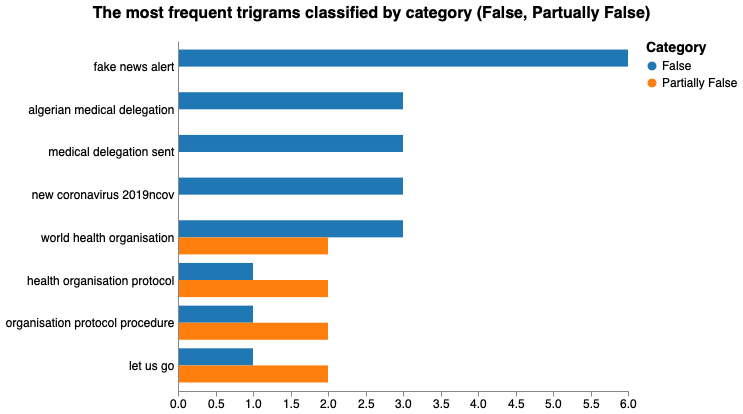

### [Open the Chart in the Vega Editor](https://vega.github.io/editor/#/url/vega/N4IgJAzgxgFgpgWwIYgFwhgF0wBwqgegIDc4BzJAOjIEtMYBXAI0poHsDp5kTykSArJQBWENgDsQAGhAATONABONHJnaT0AFXgACBGwiYdAM0VwAjgzjijmZWUVIEEHVAA2SCBBrGacWTpMAJ6uSJjkbIohABQAYkhuEHBSOgAKSIqYDAluIfGJcACU0iAA7jSy9GgALAIADDLwNGRYaADM9TI4SLKyNOJkaAIyaphucGig4QAemGgg2nB6BkamFlY2OnbNjs6uHl4+fgHBoeFkkTH5SSnpmdluuTrXRSXGEpgAyjQAXhOoAEYAGwyNjGYxJOaoABMdQAvjJZGEUKgANqgcROf4gTBIJjjErEBJWCBodELey7UnoCiKMhufpkZYMeilTwwHQ4RRscJQOYyF5oaEyO5qHJ5BJJNANEAAYTYDBsQoRoE0lKc1LkSBoTwQ-hoSECyjgvgGJUFMJFGTFjwlBWlMnliqh0JVFJ2GvmUDBxAqOhgQRw8HEOgkEwFkv+AKtmQNtuekYdcoVSsBbrVHuc8wDQesofES3E-XDIAt0ZAorjTwtMqdqYB6fVWfQYZ0RYLrjYvtkAIAnObE4CYzbq4PaymoQ2pKqm5r3HAkCGYIvZC41pZrGMggP7UOK9aq3apahx860FOZ5nNUklsvxAEIIu6L84IpSRHd+XK+KE7vT-XGyvbMVx0R8izUP43y2GBuQYFoFX5UtBy-A8fxrR0J3PQCHE9dAAGs4DgHAdAYFxH2MEsy2HQ9f2Pf9J2wql5mMNwGE7BB9BDb03FkHdjxQ2M0LHDCzzTad3Rw5sQBvUC8WUQIFTwnoFQQPio2ooS-xEgDxIzSTrzkmgFIYJTZBUkxIjgZpJA-fiNPjdDk1Ei8JKY9AmEU5SGAQCyzGsvR+hoQxXzU897NHLSnJ0y99OzBc3HoPxFFkijktKSIeNCvdvwc4SooY3TZ3mMwoE3TkkBwV99m1LNbP+GUcoiuz8qwwqgPQQwwiCtQoASHQD2MJA+R0WQrCyhrUNyz9tIKmK3JAfpwnEJIdAXRQnkfBAcAZM06qTRqj3UlqxLm3CMGaeBkoq7ozE2KBTHG8LDrC46XL0+a7AXNQBhIsikF9XakOm-dBKmuiZta06pIZUgXG2hcVvGRCqJBkdnpPCGTtcs74c8JYkd+rKBLR2j6sxt6ivQGAYBcMFfCgOMtjgR53yB5qDtJpM61m7GpMMRxzhoKA2y6iQ+sMNgoDwnAdUo5Cns5jHXsYs71hUPVNhKzcNpgFRKt4vbssmpqyeVtrYvQcYvF8vVkrpoW4yJhXHO5yHec1d5FFt0NwQd8WkCCVmUY5l3MKx96zvthn-cD0DMEl6XZad1GaND5yVb5gOyPjqWZfGEaFGs-xk5DvLXfDymQFNPrBseQIhrwkvjfR+i3YjqSzG8eQbEZzuKk3RmmAYHU+gGIO8tL4Hy4p9qQDxNjZGXJgjLMHBIkwcfIsn5rp4zzU14ZUrQigm6epULrAcc7ejt3835sxNQxbcOPXx1X5RZDLk2Ekx6U80new4zwtiAb03JMQ6F9IoUiBdFy-2vi9W+UNNSQOgfIRcJEkByy3s3RW5ZEHu3mBAGWygN6gTYHqRKP1FRwGmJVPkxdDbE1TmXQBe9CHkLgJQpk1DaFwHoQEZcOBKoFgNmzI68Clb4PbpqHhdDwgCOutYfwq1SBRDDE3UGJsuasLvmdQRwjlFwFUUEVsnVMgMLES9CRrcK6zyMa+ExHYzHyNAoyRkGiSZp2igQ9A-QKJ8nYKgoKCMlg0MqpkLKwo-5g1NuXV0uipJ9CSHjVavDMgjUUB45hkUpGVzCa+IwshkpmCYHw3qWT-6xJ0Ug+YRSdAlLKYaNepRmZuAqTE7R6cEnXiyLIEInc1qwEZP1HuHk+gKHaVoyR1SfEgAGRkIZP1FxqDGX4NcKZRHBxwV4nm0jszeXQQgHUeEMmTJbuTNh6AjluBOXU5prSzmKxsUA+aX9eRGCYHiNZnJXyCM3uzbZLCuk1Pcl8hQPzFB-JUdYR5Oy26V3CVC+xIYegMASv88RgKckzL2egZF-VRrovzFggFmjzlmxBWUDKAj4r0FcMobwGKrFYvBhS2ZFAhkeVKAyUCa9MguHji0zJjDnZAu8bi6SfLSGCqqlkRQy1YVit2ZXGVyU5XLU7N2RV2LgWzPVS4b03Z-QGBlriNpIrolTOeZckAAJqgSyiMooh68BVsCFdq1luTZ7pXWgEa5dAMghAoHqJlRsyVPIud0+YZBh7iALNbH1PF6l8MiJs+WlryVeuAfAQ+bBVBVSKXmmWP1oTQiBB6qpuqJWFqEcM0tQJyoC25Hm18oamGVM6eKyuYyQjpTRQEexwrLFhs8Uq+F3qFRJsHUaBcjcLXWMjZSrEyheohhYkgJkLE1kVs7cq2eLEgjDPjkiEICNkbpoXWyiV5RoASG8CGTq4QTAeEGPOlllau2z0fUsddTJxDrxgDu6ZVaEVuqOYaX9ZCWSAbfeGuFtjgHQMgyxN1Nlh1RMvXEm1yAQgAgBKBBgUBSpeCA9aqN6AiTKAVC4IKEASTJo8N9V9w720dOA5+7NgYeTwEZZyFkvk2SKDTdguD6as3zTwpEUpyVOH9XNcOiaomp44srkQmgBFOTcnCP0EaQI7XMavu+hBKnZ5vKsiGWQenqhMl6qRCZhtFOjuUyB2e-QzKRF5S6uOPQaDeVI4u2Zxg0W5DVkI5RLTHjxoNZuEKsGnOepM8Ax8i1ORJTMMatTZr-NXoRWl28JqA3P3Vdl8TZ0xBBj8Docobg9ilLcLQWBcXskJZc8A6rtXmYNc-soPUJXEvzTq11zTNA9QBSLMFIdFoMNGfYy6bDAcdDAh0LCWEfXWvzSWytuomqKh9jWxx+aW2ds9l7HoYQzA2AAgQGQJg-Ymsdtm+OpLebdZLHa+CgEhh9t7razqENi3DCBE6waNDWylMtYO2dT7HzgeHMChN77T35qA5lq+dLMACtZfu2xsjlK9SyZB-6AOZlQcTxm3g-rZ19DyHlZ4TsYD-o0CgS4IkRHixwPJwFiVoCxYoJZ0NBmHZtgJA5+Dm+lO+b4pwD5Thov4vi-W2VuhvciLrz0BkAiG85fNYV5DqSvY6iG+296cQvgvbKN6kkNtoqdV681B0I3ybDWv3BdCAAHG7gQiOEPzRKl2F3Lh3ee5gfQa3GaI05dnkHgQIeaYQL8KUb3LyzpoND-HuApROzOiiJEm3EO5vkZAL6DPWebBRBMM0Bgndc-h-g-EpdpghboLMLQCQx29uG2m2L3dypC8t-UO307SIIAwA8hkGvmGw719mavOTNCVzKENJLTw7BQHhB+BPmbNjp8SuIGigsjh8ShK8APPqPqCJviTzanNxEzPDQUEkHuIvsdWq5wirTfCjAP9P8-c-rar+F6Gq7anbxxFgtBGDeCYBmSlCk7AyT6K5STf5P6-6RAX4uAEREQAGUopr-oIAhB4jCwFilBh7wF27zAEFtgZ4s4GhYGzJryGDDKfJSxIguLdhwBsC0ESoFiqJMzBQBD0HPikCcGVwMyKBQBophBLCKiqJHAW4fCbjCGzzSGvy+ByE2BlRKCETLQY7npwFb5v6zwm5LQQFQBmDWAj48j9TYBDTwDCakry494+6qy2xkDWBQAhC9TpZGH9BWB2GYrd6PZOF8yKgnr9TGDhDypsBt7QjVCKHAJIDhGvj-rRHVABQMi4g54v6ZoS6agxFpEBrl4HxCwkr+EOGBHJ5ST+oZEhBFFHxRz-5ZER6lZ8y4hPrdB+gY7ICuFxHI5sA8RJScg+SsSW49E4xDGEZ04JDz73hmCjHQwTEuBTHTAL74xWThBzEeyESJBbA8g-j-pezP4KZ5664-bzSBQ2iuLyCrTgif6hqOY67GYIGai6wtAKCFIGBLD9DuAMDyB+H7Sc6R7AJmQrRfGsS-EmCDra4PYU5PHzBwTTA6ACANrLyPDqBQlsYwlkHoDxyuH0BVS4wrQ3jolTKYmnE4zjApIyRsEcEObHGPFYnSSETx7yBsB6AP4bolH-EBGklI5nSwAZBMhIjgjaidyuAwRBTEnow8lBGahCmDRM7gqwAMo6B4SODgi6GsoSLSkVE9IjYSFPpmQho9RbCOCkDyaGbckGFAkcIMHCx2D-TMwFzID3iSm4JWkfSmmOnyDOkBDlCUKukozNGymIAgR+m6whjCAVSNZHG15iY5G1I2nGn2lmmpLCJW4BlxmwnoBsiYCwDlRqBlS+A1Z3F0l7hBnzDdAFmbBFl7AY6KDciTZk6WmAnzTIDLiOAj72kZamp9RoJ-FKxanul6KY69kLgnBsDjIlmxnOYMl9kKSTlVZ0AY4sgZkzlklSSrLgphkITQqwGakAnlnYkjbgr-rEH9RQIFjMyrkAJZkgA4DMCHzJpcgKCbhdSwz9QQBzoxmDktnDn9E-RBYH59RfzEbeB3obHzAwzgpuArAjRjSNHwY6nzCXkBDhB1wXDEAQXYmtI6AYUFxgRqAkH6G-lSS6wwX4aYDpS4VRH0ickDkHnxlXJsAolLBBhhiLEzFsAVDXknG8lSRsXxojKFp+gXDfxWw8X0nrmagL5cUBCiW0W0zhIXwGZNllHak2ryVWyhhKVMagSBzhCqS0nTk3kMn6AsWcgY6CXbkrlGU-mHl3mWVblLk7l+KRBHKXyqUPFlmMVlDOX8auVezDJ2aX62UMW3neg6DTDCyuF0Wsav4kWahMBmBIB4TDJEEuBIjpQTlYUgDpUjRIBZUBA0BJVIC6yGUsalm46zKZVRFFUlVlUjTbqd6VWYw74IpVRiDRzPx6h9AoAIVjoynzDxz6D1luo6DnYdi9hVD9W25SXzATVLBTUcjPldyxUtUJWEKtH5Z2arTqFMClI5WYDEAQCOB9AGDeaxg-S9hOA5XOLDLXU+RZAFg5UeTYDkI6A7RLAbgMESA5V+Kf7KKVR5r5zWUamlFeVVUSpA3wyLn0A7kQBBBbTDVEUBGQ3dpvG4UkguBBD2YVXGUfpzXoAAjQhO7aw1EPlBS2F-XiDuB6VI3kJdTCwrWI2qAM09Q5WeAs3DWM0mmLgQBHKHBt5EkzX558Waj2nLQC1gUPpMndDdEi0E1i2EKy0clbDpS3VbXsTPnBjeCkBxw-FNV42kGE0gIfBDS2COCC5MirzrwWJg5lFo2zx6gIDSbebhBkRwSuGGAo0O1DmVGEYchWwuAMgES5AvXJV4TQEhh2Bor4EI303IDs0K2OFIXYlQJPCc0J083HUc3x2s2J1CwQJwydxc1s1Cw5XHWaYKCl0F3Cw53J3lE2rM1Z3GmV3XKyBh0N2O3AJt0jwbQ12M05Xt390t2F2Sg0lG3EX2XmAuClDwB4nJTQ0EihXNn2Vz2cKXQ-LA1vYIQSXeW3lL0738Z53I173qWF59oQE10GqTr9n3HQl+3XjX1Z5JpELJV32lnn2UqAVIgaxmpPDyARHuVbnz2XRn2P21KcKvjAOz2gNVSWAZDLKBQeUiZqUQPZlwPJQIOOA9zthMifJJAf342SVK14o3EBJ60ySDQ2CeBJ3flhUMlUPLK0OF3dDhLgMbXoCKgFigWBqw3LlX0J2hpd6+3HRtWzxIhFiOmpQ4NPoUBJV+DmkXpT0+UyPLJLDyPGjPyfLYDdStJ9WT2o3oMgCaOKP1y6PBSPBNJIASEvVhCEVoUeDlQSE6A-CMgSA0A5XiH1llTwAJB0qQHZCPx7ng0Pbd1nGm6f6BIuDpXIAIlHU+0Q3GOxNIDxOV1JWzqJNhPGOMYY3uA1QuDIDyAV0GhPleYtJwCR1Zwc1M4m59DBPKIinbSLisXFWDR8iwB8J4SJRiA5XbSLZImlrbY2Nw3KB-BZM47GOH31KuJbSd2GOiP2XJTeBzM1EeCHooP2FJOcPSQjbbRrMBzDKmFCya59PrNHMrqa5bApVrXEON2AGXOya4gabm1old3GNmR8iRBkTWRhBV5LD8wSD0jbgr1oM7PeBkAPz-NxxgLAuNVeCSwGju0cP2VwBsTeiKgMxFY3MTPxX2UYs006jXMEQxM8i3PG2kMgCfKKDUtBSPV8IwD-q9Q9kMj83x4GP23bP2Ucqcpuo8qdR9DeT+hBD9lxXZG3kCu+Y+QBgBDtO5nwBSw5UysmDm2dNSychuAb7vM7NyuXAqtYvPjgpBAZAhPMpGM7PPm2bBPB3qb4wcvKPmv2Uh12v1LsCRnU3vA4QVbCwMA4AsFLAC7MyvgfxAbSniPAILWLapFbYos+XE2G6LlMCyRZAeBsg01djAGxu3klVuMMjoIYVJF-0FwMy-E5WtiVl+B3SRBiw5X1AJvhLFseACxvMLNcs+UNvyD5PNtt6W7ksqO3mdtNsfyhArRtCG45U40TahFm6hJQL5qivrX2UIBooOOWSnouFuG9oZALt3PhPOGviuE01btCaBDDz-kqV6GOs+VJCKC+jEbdmFYfWlWWS3V0BBMD4ElLClKCZ9tXu3kY6ZZ9SIAHubu-S-uLOqNIj9R8gPBPBhIri4visMnm2wenq0IIcmlfR-1eMKgtD0rBJriQnav2WQLAUFjeQeOGh2qHUpXDKDoeEZDgdtu3nZBLCRsxFZsMnsfRt1CragteVf2zKdWMw9WlP0Fa7Ec+VqB6hwezCOCpr9B8MbpmE7sUuDV4pydIAKeYjl7KeEQBBtBtAxuSe3kC5V6SH9QOD6epJg1msQemdWeGKzA6CGfGetvZM7O0B62iWyvajTXueTMWsfFwwrBrwdhBsBLgUmcMlFoGB0CsXcj0HgrPmkA9xCHRcm1fxJfF3IpqB616ieD-OIdNHttmCpd5dLAFd0aik1R20Ov2cMmsc6CTsRGhGLj-qYu40Wlgv4vVvgJET9xHLCzyCZZ0X30YnGMmiexGDzwjRLyeP8cP07MAjCDCxIACCKCZ4ICJ4ZeUs86Yh86hh0hPh-ABCmFupEN2U+VNeIBM6SF-Ryonqccm23cCzgqPiPcLYAhu7PeUsfdV6hHffjWx2-fqe2pu7A9PBufdcCfGPnZQ+8fbbIAESg+p0gDVBAiO5EGpJOCKfBOo82rY-z7uXDthn9AE+F7u6nbY-9DnbGhTlXfhXkI6NHN9eM7M6Nq2f0Wr0+X7fs-QKnzEoU+UqC+ti+j2uoOw87NJVsA9BVQeAeQCx6sFiUWoHFeIU2oK+RBhDK+cLn6FOLgcmqf9sMlB39RJW+tGDePpcBd4s+WXRsBblrShCVTq8DVo+DT+rgpouJc-qSx2aXcMMm2LRJEfx9SidCvcTM80GLcTc7OJr8FVTMsBrC+zL2MDxt40KgWx6p8SpmI7TcJ+sWenzQi58qoVOkKftA7j6x8knGP59BVF9tHWhtBl+zwUmA6wjbYN9jxt-AJd8XUF8ZXHB98bYJsULpb8ycKwCj9nRZAKCA91B0qduIDSaz9SQAhL8cgr8u1VSwgd70M8+3lQKODPzHOjbhA3W19SnGO9QMiexFiGh4V3+JA5VJLiGC0aqIBBgr73o2YZsnY+m3IT5PiBCClJvQo2fQDyCHqLgai7BGGgkHfogtbeSHE2n2iTQm5VqaqKIO4l25g9cS0HbxhZ3EDeRpMbvWapS0PbBtn4a8RaC4ABCmsR0zHBksQGIjjAiw9SZimYDMg5V2BK8Lgf4FZICwwGeAtHveXxCF1U0HVQiLVBQEldby-QWemr2WyxFRBNqfXioONRV5yBotMHnkWXJQR6OOVaoNtmmbvAq8fTeAfnHMHJRxCzgHQjoMVpg95AbgXWBlSIgsgPCr2YwG-w8GYAvBfgYwGNj0aNlL2DXE2g-HUB9RWcguYdr1C2jahIWOVdpm-E1q9VIWcXH5jTSY4ed7KdGe8AtgqjKBn4xNdftJSZxSp+oFQtXC2m7YKpr+bpHZk0xqE6V1A7g0+NhwaGBkfKtQj+O0OtBFsPAZQyBh0LKhOMbGDZCXvuSP6m9DQEw7XmU35TDCrkcvUCEREQZPpBMq4IAWCAfweY8Owg7KmoMLwHCwgGOB8FXlcK-VjhlKQ4RcLpDsEuINAX0EozCHMCTa1XK4U8JeEPssccgjXoAWeFEsAOLLD8hkDZB2NxAqVH6APALLD9b0zoRwSnWvwHJwIGQQnNqFXD1woRSI+5pSiSS0MqozpDkkWxCS4i92lRQ3q4VJF4wXAncbYJF3qH-D3eNqRjnTj9wntIIE9TlrkJ8ociAgXIwfDlUFFAETsI7LroOBEbvDe8lKAwRCWkZmEaO6HHGlBG-aMcNWISMtuIE+oV4h+DGSQsbz-YMk-GNOHQH4lYhuElgbAJSMgJ5GBclmqudJAIBjwjdjmqgFtnaLt63kN67AGWOgj57x5mcm+I0QXkpQBjDuj6UiMGPCEyjZkEY1otAkjHCNF2U+G1EmLdrQJfW-raMdKJhA2obaTohtK6OUDujrhzIigWD1gAwVlAHYM6tMH7ihgfgEgbjMGxwC2j6uuYtHqUlQrWiTEqSb4qPAvZbNeRt5eOHhD7FZ8wSwyMwB4GWL48bhsyScQbR+gzjUmw7JaN3HcI5VVxc4gfBuNA6ic7+h1awJuJCCHjxY+lRAEPX1B389KwUHyGYEsAKlyR9fS8Q+LViilkAIfTENkJw7dg+w+HXjDdDzZ-1A0XjBlEFEbQgTXyunChnQHbFvCRxjDboI-yEwGpFin5F8TsygAYS8ILgeHghOHH2ifKo0fWIEGaBbBjyOVJRHSDQ4oTpaGraMp6NQGUt4Oy0D9h4BRSyAiQ2QrCdy0sKeFjQAQAqgHGvGcJGQNGLaOvGWSNUEg38eCuWN0Fo8wIBREIIE2HZ35rWr7LIBpI-yMjCmr5V4URK9EMlNJbQtkjQ20YA8YUC4iVKBKslCY8wQ8e9A-herWSQwzk4sNbD9zGI3JLk7ySmmMT+haUMGRSU4LR4+SHEwU-xhyE8I5DiJ-7EKcfB-SKdCWmzUJglIZIW8T82xY9AthBGFZDqE5fKSOWfidRwQSrUqd5nBBbAq8IiJVhdAxoNtk+uISwbYIqgBpjsXjDqbiGOw59bJIhAAbHh2KPAcqBbeVEW3lLjAzu5CeGGhUIkZSTJJtEpGewfAoSDQaEygnV0QmZTg+y0Fdkelo4-Q4pDUvDiH1pzBM+oEAqWuoFixhTkRgIxeGxEYDOlXW4BPiT5XOmRCn4R3CgONnfG0AJs204ySxMrESAeGLiQ+ganbLm0Gi90vEbMgNzbYZgagawebUuDLCcQNCVGT+nRnl4-8IVQ-j1x8qwhxRN9f8XdiJlS97KHQZNHRgSirQMgNYsgAzyD6UtO4K7RmfWQkmyRuKXQzMgyTWjMy-ofoZAE+KGH8y1yf3TEernFmGhvCJAiUZLyW5LskAcszsLg3owXk8GmMhWVrO4bDJQamM7WYbL8pGAUuA8G3jDxVk+VQaVdcrs8Mq4IwiumMi2WlydmFdRSuZNgLrGEA3YGA5gUoHvkxmXCyoyAQ4HrQQgZMUqmM0pCMx8Bop48VjdXCYlCHTDiZt5F4U4xwweZHwgcTGUjNWhzM2AONcFAAHYvckskymgNvpE4wsKKcQEEDZALSuSGcxrpnjOFIxC6uXVmTMJNqdzxJwsHuflWepVzeKYPYeZIyWAEt-BmMqeaXn8GMTGB43OvjszibLZ6gEKMQMvM-rGNoQm88JNvI+ojY6Ars1tG3gZBHIjACEdzITOtlx8nWJ86+SyFvn0Dx2Y8khmDxvlREoIm-bbG5h-m9y25mXPuN3HNmgKyoG8S6LgPhkUj94ECzYFAtfg-Rpch1EfMgqZDS5BifTHyFgtQUDTTMuCnyA-EXDciOxSEzLsQuRD-psFBC4BCQpoV4LGAUAHBRZUIxV1VqSoOhYdjtRkyC47yYGYtNBlo8CIjcw0LiHEA-AnwhoRXjTho6SLpFCkRyclG+6l9uFfJHIMMjqBu4E2paNRVTJtm3ltFui0tDoDqCb8AQmM+OP-RCCKh9ENRGCHjByoD9rkDINvDmzfh81txzMN8uCiHhCT+Gu9dRVJHcCBRbxzFG9kSGtaaZJYrk4JXOCGneMA2bgJAV42haICxyaHbqB9NvIUlKGDMAePTBUT9xfx8S8gjVlgp-zri-iCrlFg5ozEEYKpBIFLA6rxwcAOVJSG4BaXLM2lH1DZkOKEXyDTKngE5F-FGj3scwbAesVMMGUAiRe3IcZeCkmXTLOejsMpVTC4wrLT4jMKZUEEPZ9NJooYaYHsrzDyB6Yp89ZSAH8ATFgmq0UaNu1ZKVRrCt1dBKYEXAMxb0oEWAFESMmzKWRheGCoDhxoZBFs+i5iUMpNrAqVFJNPTNCBgCGiYxYPNQBcC2DEBVoF0LnmKwhV7c80Q0VkgCBjxdsyFO0paZSwJXVRuQZo1QJhUuXE0t5P0o6rdVfjUYngR+fUMdLNrFg05fyisWjyoGn9OQeafUgPgxaZRLla8e8oxhFW1zuIWvN7jAMWjagH0CRThCECSQSLSoLyiiIvPVXvK-ejwN1DlTJ4hgx2Y2FkErJBnYqweZgdVLVLsEhgrOYQQ6oRm8gOrkq5simiwsuWOqPVEg4WPr18FSM4YraPRpsACoF0yx4KuZUJ0RZ9QVeGggXNpwGV2dOxNqVXoKsPjAcUUXgGxglBgVRr-llKT6oaHkCjDLJu1J8ZkVgW392yXteALJkiX+A6MeZRUNN0VCSEmVt7JtQHRIim5147ap9ObRyWNdwIyib6RqnHXDqIhJeBPkdzkXNVd2rVdQdSjnVVQiCZbZRZQUzw4FyE5dS5UTxNy7qmaiDPoGQHKoFreVNqHdUN0bQ+Yz1Ga58EePFUnrmguCvoo+rjUZ4+m76nqJ+szwJ8cqBYZzn0QCDCBW0cAFuUwIoWUsQN41cDWpOVyHEL1Skm1GBrfAQbeUfCRmGXK363VENz8HDXSna6Oy3wYEy5VUT4a1F8s+xKdZSyo3GoaNZCfondOQ3hTWRRIHUHiHzikBdY84G1lCPzXkLdprEjdke1khojy8vQ+cdWp2adF8YURaEUyBPpl0vVMm+yoNA0x5UpiESQ2CCEXXHQgQhPKgnPnSTUlDqjgHTAWBBWOBlwgG53jZsNCYgKAkaoTaSrB7-RZKOgbBkgw7DJV0ikGrFdGolTebcGSwPzfBLFJdMYBE2AuI52NQ8QWNrm4RTag02FhjN-KnXtypTXQbnBsgZANBwgIMjMVKY0zsNH5hCwjA4wCgL8uy3Cawe5W4aFVr6ivMXNJK5LYXmuiJdF8T6Abt6XYAwVaAt445hEQ9GeVDFDJc7l1ENAQAYKqXUpjY3K0zLW51M69rNusDzbSIwuXCtA1gGYyFtW21wgcUbkZqVwmMw7c6RqJ9EQIUAP4DPw-n71TJV2+8K4Fu0chV4nq3Wa9qfKer-QioWkJBpXk38dm72v1b9oGBKc3AnyR-pjMYDg7dOkOxRY501X3bBOEqbkOGSMgHp-cyUFwbrGSG5BsdBcVwUZE-a+DidGolJNwUS1tarVYgjvmlp4IYF2lly16mMAZ3y8FwVspLbTuvxJSkgphThHwzzlAKVto4hUAyh8j86bVQu6pijsm7jLh240-YrJH6WYz+gi+diOCmri2g-q51Sds1wtU8qUNheUtZ4KsIwAu5w3BUl8yy3c8yiUSLDB1voCW7GqJUeOLYPFIi6HsDu1MSbut3u6xSypBAILnjgj496Pu0SOG3miyryAALKVNDMXBe0YdzMYiJ7CsiQsdiVebJZjLT3+R44We72vHkgKCblZD8qTuLuyVF7nwP0SMihKsWeln4+SZaMl3p2Yym9VuCnStH-TrE5dFrcjpxHm2qJVaOAfvZRw5pD7XCnIUfY-1jy0aweioS1v4Biz8Fp9pTY5oyhyrE1PcCbE3Gbh6pkza2Y7BNpFPp4uccNdQbxc7lP1tBz9s+nKjfoTap448xeHbmpqk5UV1VXxWwOGRZlv9uoX+6CDzLCQGB-mh1H-S4GAPVdCwPII4L1Gk2saHp2BWhCAfSzd7YDw7DqYBpgP0wMDMsNYcVv032V7SVtDWbiGGjXQ7NmefYsgH838Nyeve7ljBU+TPw-GCUDkOpPgNjay9t5LTeMHSTQiO6AWkrchz4NGABDADIKC3m3ZD14cdgWOFHBE76gltUGurWjwUPh8lDROe8OJUuWuV2ItsLqs+gxVe7uDDJDmaNj6Bu6jD70tXeoVRKHsj4HJQluCgLEEG1OaPDIHgV+F9QZeC9SqYB20ZaZN6LTQ3bVrc1digjVUEIzRnqojY56xKy1UFsrjRGzRsR7bhjlIPchX+uhtI-EcyN9EMqEAlCfnMuVGEsjhR2abAJcAhFXwAGy5bICKNVHe1NOWdVJraE5Uajm3FdW0bvQV4fxpUbuIbQQMIyJUBUs1LzOEmXk59ykmWSkZD72HLR9SwiDRjsMMgHDYWx0RJzf0StcQNU92pDLi4VdN9CbMzm913KYyLtgBsePCw-6EMrF4Bm46REIZVZMZTYjsO2A0ZBMQyEs7YwyQ+OY1JCNBw0Bdo6MPDNg6fHuG3jYqh6Oa2ADPp-B0LnUMW5iBGi9UiAhg3MBoSMqQAEQitX40xm1JifQR4yPywnA0UPQzZfskAeIJmctkNyUzhjcCoamipvbfIwNxG+KeEbTEB44NHJ-qBYMuXsm40lWCYcD3Owc0q8YptiPvzBXc6kjUecxWXIYwhIzRNNMEqEZUNcnC84ZPoBkicAQY-sb-XYAaZqzHyKIyQv7GaaWCpVeBPga00ZG1DeAOlDpoKEZBtOXLHTbpoyLiFdNjT3VHCkpUYCkNCYS9iRwtXQQQVBm+AIZjlVqkuXBnBxfUitpuAJOU86gZckmtMwSJFkkWgi5beNuWkfjlEX0ottUAx6uzce+ZStqQkjMXHDJEW3HhAWXChSpswh0MWn3qyvxDkN40ck1s4O7g2gbZ9oNhh7PPwXBfAW5Y-i56DnCDYcNoDahiHFhAl-GH-lKAYO2yzZFlFJPQEVHrmD6y4FaDuaZJGy9zDJI829k3P2BIgmM9AcJMSCPKbKBi0w4WZ8w-QkgQ+5+KlqZUfmVWmmqgrdXbLERhtDsNlkUaRjMwAdu87CSQhAs+QwLUDCQ4+DCwZATDq83rnMwQtqqgoiiFC9tpsDL0nzaFkidheQtQRD2bO-DmfH5qYyYKAwKIwapaT8ELNa5wi0DqIPFTY4onGRcaFNDJrNT7WsMROFP3I9p5nK8QJ0PQxDm8xheU0KhQxpBQrtPeyS7Ocj1prLaoSIKUYXNo5ictUevkhID32LZts662lcZZLy9tUzlKDyBcCt7WgnD8shIAt1+Mm1PCuIQ9g5Z5REYWQyhwLeGe5yOXXA4hXqcCQ3AlVkWpRoKyWoMChW3uBvIsFIp0POXKWIVqwGFfBTOl34WlAsM8J8tSW0eUfF2qU2SqdMXAbQVQUletULgSrLnVIhZZyrmAX6vpb5jZIqv5Xa5PqR-PC01GlGq8t0LcP1A40K9844akNpctDmbBN5OZTpnfLlN+XVMGOTPKAQxVVYwgd21q03UjM5drYu+18IsefVVkjAwKjkEdd4GWEUOexJgKpsZOTd025nSffR1bDv1QzRutjTJcsj+RszIpFY57FkHXXZNSU0LEWyGiVq8z-FnnYXmjmKbXADRukSmg4gnjRr61wAjBTpTtNRLMhXvpcrRuaoMFEBohFhvFCvtIW6BqthxEVDwSCGyiCWvzVoyjaad8p4BGYC-FcRAVVNnUDVrBsM3o9rN1CuzYGb+c-rRBvmwSrpSSx44a-WlQIFFtfNXa0PWa5esLxi3mKe-RHnBU5MCWY1DIJEOXi+IcIYlbBBFamu1Mp7OwMFQq3zWPkAw+LvlhW5Sjuo-Q8pcA7ekaud7Y2r9EktqT9bo4n5kCVWVAhzWQBuMOVcEdg3qSlWtawztt2ZKUmXB60mdZCLqh0sIjEQyTY57qO8uethGNb3OAAZED+lCwXAZAIwHs25A4mxpxdraKXapunVnwT8P6pXf9yoUa7l05+Ezf8BCGVLZ55u1ENbvAc+kWtD4obZy0eHzEAtebVtHVwvpOaAd4iECYoAI02SfQWIRzZtvG68cCQDdJzUXsOxMQNAziVscFs+VDxinPe8snWQMXM7nNua65gQCOBJ7m9he4oNGDmqOaQiBkMonmRiEOQ0Obxcki-sA4v8t1xwLQHSlZ3wblKaHLtWRMbojmO0JvCvbytXqgHMD46XA9vH7HLLsyUJUWHQdvF6BX2S5QcCMD6BSRUVavdbcQcyWmcgOXwHrRnn08Q5YJ2y14TQdjSaJ93WSHM0YIGhMHUNHrJV1kNVRkqvsc3EPdUOE9tQQQtkatDnbyJnF1QOUSFu+geyoDvDyuPyOGQiiABB-Q+8f2VvpIwNze6OklDcMm8XuPBS1vHLbxsgw94qkqFY5DA2OOQd4bYZcqcdaGsRuq0pUjdlEYcvHR8VO3-s6jZCE7KuZ1OxJRLwTw6z4EfMNkgGCPbdq916-MuPLBCYtivCUuRoSdKLIJwgH2ctAjsvXEDQnKvL6D1rxH849-dW+A7oKcSPat7HK8-FBI-ENTST4p7vn3zBsj8BukFXLfpvX3nshh66eTcBxK6JLujsw+QAkLJQYi0nJYEiB1Ad33DNqWZ6k4WcbQtq4z+W2vb1Qeh+k5AAfImpjMUPO706zPCNduWe4PWblYdsHjlWZalnZjylnc7xDa93dWFjdP+g32XKXnivB5zjxJ79nI7OziVLUCfZ-P3ndMwZC2e2fJPdnOEEIKwbpSf21rEzk2ki7e0vkFkHIJ+2+yUtov2ZWL-+7i6yBPp6HjzkMTip2iGhDuoovsIlDzQx8fHWD4MHiCZizBZYaRbI8y4lQozOXripQYoDQIyGWYftoV62lqnyo1HE6cV1BH1Tx4+iChS5UpHoDZAxXaBJ0qdrceoEJX3pECEFlGn1GQyz2g1zQIDhbP+nUdvPhvdP1eAU7y4WWDMVyunO-uRCUCA6-YFFJgTlNRwABe1Ceu77AtRxSrulfAIUVcm1U3T1BttORjlcHzlupownVMEHNwHY0Psp5VJDybguGaTzSoW2LvPIhK8qiJuXCw7OLG8W9Vr-H3KY0hgGpKzjm8xArEeaada-wr58Se1nl3kjbeL1LRT7EO6G-mjnXn41JH5N44Jdg8eJI0QBW9NaCEPZe4Jb-ovI8jTBWnlDu28ytIgbRPabxIKn-xyoVzHcy6JvBqj7IB3X4q6dwT0FHfI7O33qXWE+mXIrQVqyYl19JdlHUYEuD+NYQLuqJACv3UuwXeXmSxiOtTgls28vCo55ET90btd7MmJqpFoPAQAQL2Erm3vGbgU3a0h5Q9bra22H7HnVcuXQh8MK-PGKhUYADuzoMRPIsmZsCw2r9MH192IK6gpmnc2O5RH-IECWL4zGH7gUZbqCceD9ly+979FVPzcJFB92F+09Uy4h+lcmR2TsSe4s6KJNhPwKQCLZP6cOo2WAc3NcBBs0r9SpuQtlKjjA0rVprxnp7ONVPdPJn+VYQ7tPWe4ApnuepIVUTmebPFnZz+EB4LpE2dL1ZmKp6WC4hrkIsUaDR2C+YhRoI0BAF+XHdo8IvC8aL5zwpeIq0eeW0ZdaBCAUl51aH15Bl4+pjlpBbgIkLwIK-LNmYRIFUgckSewe8+5Xw0HhCq8qkTmDH5Z4Xga-IBkoqVFpQEA8B9JnT3Xp9v3c+bu6sDmQDkEPtMIMAfg6uFHuRtWGlBYW0EVsUMck+xvvUi3heh1K3K30YBx26ZreeONmLyVLeG1biFAHeKpUbubHquJcRP6KPiSPhCEj9SeAyIAu9baA6vtWvVMvrZpogtSaWdN2SogH2JtIiX2Y3TJ9AE4fcK-RWeFM7xd9St4GXAzjMC53TeBdwuJUIZIluLwLgkDCWiN2LwudKbdxMWSLEVcVV2udRHw9368M+SvdQJ9Akp0nfGYo5M-6dECFQsl6NuUoTEf2ibMXQVCCH4tg4+vULD6Li7XAz4P4F-xdqW1L7qb7oaZ25lEgypsatO8E6tqYzU78LDVcMhUkQQCfXBoiwO3TtpSlNT4A37crRta+Lf78K30NEq4jK83ab1Rg7-VyYT3XijVx6xZd+3kbpbeHiVcSYAwyueCvgWSbUD9fsQ-W9eGM78V9ZTo-UMj6v7i1-4amvqwZQApMJ9959TB3Ss3eFRHjUA4SDJVouEL+RljWPcEiBQD6A5UgQvYOWqxRXC3cma6zDyNaIrP3gW-VdG6P4Ciw+x6YY3KC4weYrh8PG7uvX2+IuPj-Igk-+8aEEeCg2w-Us+rW+IX-TSq6S90P8P58p3tHfYGwwLHEfEkhTHlLr+b7EMNiwmc-UA+N-C5-D21L0GWbcMi-jmDtDgYGsQzHhh+pbWOwt-4Ia5AviFQA38jkDTGEQb3bPzDFamfUgtwPAE+R+gBAVcyH87mVHREI4A9yiZBEAg8zC153ZAGZ0ffePxe4UkekRXRolSm0D4+5SljaAKmE5DK4E8GJVAotfZfEX8DOGgMRIkAzGWoDCIE5CwDiA3AIqhMZXgJWhuQHoDwC+MRQClR-AeZnvljfMw34Db8KvEkChfIpmQDGeBkk88kLYiHSoemTgVECBA08xNpB2RjggNlrEyxy9VYUwJLwBCI433UrAw43k8CPeGTDYm6ewLodaRRbAZNVvCH1tR8MOjHxt+EQT3MCN+fDB+t8SVwOqcubM6FCDF6cIKrMUzb9WL09aGj1IQdHLwKmZmPWjw8CLIAUyCDNQHDFBU6TPjlyD5gFEmfgcgMakPoy2YRBhYVASe25dIArB03ABVIaDvEDKDmmFgEaefxHxHzBoLR0FAYhH+dOggyny9XzE51a9KUEgXQ1YGD4nVcDlLvxvU6XU7HF5qJIKSqUJFKRUf4mRXoMrg1gxcA2CQcGJjLdig7Ej2DpFCdSXN1gs4Jp9akA0FKR3aGJSPw9gCATB8avaT2tAmYVEh+gLgHDk1kpCDiBCBfgBAF8AfgIIDcB95bxR-AvOANh8FSjbR1OxewBELdw2gHQARCUPctEuVUQpEJRCEQpEmxDewMsxypUQ3ENRCyzPEIEAy5QkIRDSQokKVNUQoEFQ9tg2eBpC8Q+kLxCMzSkN7BWQ1EIzM2QhkLSCdmbkJJpuQmPBwwDqb1WYokof9D6Ar5fAhSVMlKDHvBrglsGqCjzK90QZWcZ13GDZkWi0O1qKRggbgxpLih+gmCWgIxVupRfzbArAab2KZ91K0ILh64SHVl5fBB0LHx64bmQSMinNb2ARmDV0OpYqMAuDsZ3Q+0MfAPAZ0nKQjXWSFDD3lYEx6BlAED2ztVMDezDCYwopD9AIsCAQiCBnVsljC0w5mAzDLQuAB+B5AH0KdC3HPML1tFZIsMc8EgV0LNRMwr71nhKw4sJrDZea5m40crfoM1CnnJFSmJ48IkE7C1hesJBdK4HUO-dJzZFCZVGRNYVS4RocwHMBtQcwFuowQQphCEAzMBVZNqMC41XCVqQMw3DoEX0EUt2jAwMoFsdcSzKhHLaOBkckAJsRLZGAPbUPhSmYNhvCKgRgFVMIicdSQ0jffN29FHAZ8Kek3w0Phbt-QC6FsN3wsPhYMLofQ1pswwW3WX9q5Slhelm8Yw09hVoKvBbQV8ZQzgjx5MQQWVCMQLweMUKFr27DlJZgC7gXwJ9geFcKWCDwBX2eJgZYcHcWD4RpdbrSVCQAPAm-gDQepkr8zhXClkgudS12HDDCSICsNOjVwydR3nTGWx555GeUgsUAj5haYF5TLwTgo6XWQnAlI5glQwH1LcWPCJ5chgq4ngVKhYD64WQEO1MZQyI39PkEyKqh3gHkGYMU3Hf2zYegXUJsjMAOyONQWlWSLUCTaR6wqAhYNFGoxQwVRGKsYXUvVkCQFQuDAUVSawGNZrCfQ2b8ZrASIx8VUDi3VxR4GMPFdT-FLxtROjYBlCcrpH2ULhCnMB0iD+KAwG8BunbXwUtw7RgXB9jGPmiFQ28DrzzIAQVvh0i0eJqO-tkQqAF+svw33wZIWo1wD2AZxJ711khooNlI9MaCoD1VjZcaOeMY0KaJCcbvJfwciu7HzCAiikOCAF8kueMJqdeXf00WDTbe5yBdPQ7wPEFHyTiAw0zcAh2OC2IsMBCAro4u3EBzsW0iHCkou90Vcn2EEK2BAwV6Kk990G5jZIc1SfRwgmAeu1VowQabTgMIiIiLP80eclQoQiRZ2VmJCPZEI6jQVF5RoYu-GIMzVFhOR3I1ybL-0ctF5fJgNomkYSM8A8NfW37hnvb8Wmi7HAAWURmbJaD1UFPUSUuVG3cZGShhiOnHGB4uTtT38n2QHDAJZ3G6OHxXpBrzZA6AKdxt1WIiWL85pY93RowzUe-3EcTdJWyghCsMARgpiCP6mVjAgbWPqdAAli0ZDgENHGRBoId+kFjMo7nz1QYIMciti2wM0MuUjqVxEhZgKCmnQUdokqOvBfmGgQ9jbCVj0ckvYrMJxh-Yj+xTQg4s0S6JV3RjxtQ2gLBUdtlgAoU8i2ZJFRSjOIUIhwxp-ZOJTkN5IoJkDvwhkhMFjcdwPWcU4ygLB49mGYOsV8o03GLALXdOVF1GGNX30MCY4dgA9f3NqI2sIo0Dk8JAVcTTMgVfXWQyB+4sCEHi+oTEzgMNTLCM-kcInuN9sv4X0Glob6X4JvNuA5knYI1wwHy7jC8ZdjzJ3+J4wHxRoX6K9D5oJtkn1OuTICVVF5RgHloboy+J9MbARFzghRLZvQ3BeJU6wdtoGKOO6A+QY8S9gf482hw9dDBIWGhseNhmp10fP6PoUrAiqCqh2bTbVisDlBtgQT+YDh3URdDR4EQT0EjsAIgVY0D1mRWwPBI-I5EDpVPIIEYkHwj36WiP5MmQPpygTT4s6FOplwFUgZRGWGMPvAmcV9gwtVTXqhDBSAXEnREmJfkPsoiTfhNj0MiQnAK4EHWOMLwBEwDykT4ocQKcsTY1siUT7yeSFgAMcAi1USmEzYzEBzlZrTjQUwe9jwwgQcqwLi+o-uWMTOuegWBBUiMwMsTCAslXsSt1QVUSDVA1OLi87AjxMCCnEganhBC8N3ANxnRdxMEJp5WkVdlYgiy0RJ6Q8xOHiO9JEiRJUiF704Q4-cP0pYkk8xNJM0k5bGCS6gCxN6jnE9zRPxSEKngKTWPVRGWi5I4HWURIMSWG8ZuBQ6jQ1FiIjCIgXELaHaDSoedj0BiIAUm8h4gub1TlnGbOU8A4pcQAPMDlFxnDlxkg805AIAWQCSpWI5nG8B0EDFzik0nOQzO1HZEMBbx9SPVk60uwT8NCjC4muV9Q1wah0R8GcPnBz1Lk+nF5wmcfcIFwjg-xJX9lJLQnVxjtfwVd4-3S+UU4dbcQFhhkVPoQ1lxlPGIICMksHn-QUyffl7B02NFWR9VCCgOAVkrJ+CbtvIPAEDjg4hsLaxvmc2TKjiqfOEPkioz70Eiw3Jgz6gMXIuRA4j2Sg3uSDuR5MDxzFOFMNQsoGczU55zQvG1941ZQXsZlAIeHBTdEqSF5B-0erDF97QziAiIzAfBITChI65MZT7ZeEzZJPZGOK1CJUWjCsB6U-nkWJuJBSwYdLldQ2HcVCY4F7ViiGEJuiZCJFNNTSoKRyIwJwViN30mcSXRoAESRxMlEpLPSz5gXUtxMcDWzV909TNQAQBSTG8VdAXl9U0WLFgn0LvgTZ9jZxSNxkZDGlSoJPRKOgSPoRNLoA35eNOdMUg+NKR4nfY43H5RzMDmvEl7PqB2ozJfiIYTvA8tL0kKuAjAzTkhN3xHwvfAVDvAYvEROvZSIYRCxFMBZ+yAj7ALAFYiY0RBnUJwUZp0TM1gQQXPUO070VoRO4BiWtAeQ3tK6Sv3U11VMfrQ3xTTGEqSEKxCcSYI71hvb5hz0QVQaGSgfVSBJOjjGLWCBEv4hgh+gk01iP2NhkB9JiV3kR2WzSBfN9O841oHYS-SNGZ3nDl20rdO8DXCEFUAzt7J9RujwM88Ub0nxaXCVcbo7dQZc-RB1VPCG4y9ItZS7BsRgzVoODPQziokOKkgBSAeHARPkRxR0w7uHeRqT7KMjIs0MTHBhMAcGCAKKTIUtHkozGMlmKcAgWHPSYyA2TiCZAWxBKMbiCzSlg3QrOCOQBYW4-xxeDZEu2ykzTfEgyq4XZWEOzxT0TSyidaVU7HcpVw79EfSqKdNUqDnYt4kBpYg7TIRxxVUzOyd7HFmGpoBxcFDrYOfHuEYwj0y5QcyHZZzKggu+IDKrTjGdzMy0mUuoBOQ6MBtMI9DcILOHhSEa33ZiIstcCbTXsHiFYjsbZtOZgsRaEG8yMMvIXizUsk5AXoSHKBiEyMskmRyzLoPLIiJ6BadOAzjGXLI4QysxbEl02QJgFYirsUCAayIDTTkZFbqVrJs5LaW5QfTa2MLNwo1tVtMXB0sgjJxTcvTIAPxm0lOxk8UoE+O8DOoOtwogwiFdC7DYYm1CGQTQTZKEd-PE0BkNxsCIgYxAhEwBCJvFd+yCEf6GzhPEYYrKJksQiK7K78LhIRHXg3+f1y3ZJ9AmVYjpmcdOGQ8nOqUctvaWwwHFfs8XV3tK9GcXLiUU+rU6Y6LfhOwt10j0LGyyU+aCXjDQPQxaRGsvmNhD4bMQkZhICKQjuNYQo1AAlY06LJziihIllSDKspoUACShU7B+yPvWqJ2Z7Seph7tk0HqgBCG7Muw9M37E1JRcOQb2RppMQHAAEBiAAEApDnYy6BNBLIXtUwFQKeT3CR-fGqNeDZ4a6F1Ai086QdkouG6KgBiAVkhZza7Xe3Zz27czTWi2ctu37tShI1xBVRFLIClgaiRjlo9Kpf7yr4YKDv3ZiW4ri0715s4xi9yq+N+jHINaHBnBJsdZJDhhaOYJ0ycbo880ol-sbGV9dLlQ7gJgoxQh1kwkMPom1jwJV0zIgoiaOhuYlwtvGeYIk5GOjyAYjZMWzwgNwk8A1s27IgcE2fdJcNC4SFhuybYrgm0FG8iFhERZmFdhaYWVGVN2j1HJAEjJDAO8HwllwVNhBVMsHKmEBx8kSWWZTUKrEIgDlIIDVZRlWtI-ZuQH+Hpi30qE03zdgE7M4TGclXOAQv4SSAPzEzReOpjkhEIhf8sM8Eis11ofvO9iKyO-LHU1oJ4Adw7NEeJCAHcciVRISUpnPsolsVxQHx+aHIBFc3FB9BoMrJfyXTJ2Y6AtPZYCsdLVNlxMYOIibUTySixkC4HJ+gMEm6IZyBMjsBAKAC4-NeRIzYKTcAyJR8ErTCsxKUoKnUB0hc4L9dmMYLTVYguVzZM2ZDYL2bQ51thj3CAt4Lz3dBDydGs53IRJRRciEC9sZP8QqBJC9l2Id2SO+KFTxabGUBjHwSfVEJxCKVSPzOCuyUULp5aAO0L-+bsEkK+mRyktDd+RelfzsU5HLOgqdKwoZj6VXe0hEobFgkNBFQIOn2zVwnaD6AWkVxjRQGAPDQJtVfQwxnFAhGARCAlbWW0R5+sk5CPcL3KrEwBzU5QvmA56eLi0EVoWgHCIdLOrQDTswD91wofAJszzQcitzTyKOoVpFZ55UjnmulEAN53fTYQ6ougRaikal8VOwRQQ5pRDfhQBpfOe0CNcBFXopWgsfGRLVTK4WuCGKvxM-icB2iJIWiy37GSW19+dLPVnk5i7aOTQRsfxSSAi2bgX90tRVihVY+im6LGcyoC4G95fJcULOKopAlTLYJBL2nPIeofODMTZTanPsoV+BwKl9zCY+Vm8boo-XrYrBOPWZlLBbel5RmZeuEVY7PZbOdZPojIBTydcho0IFAzH8EcYZM0YokYTQfU0hd4hGYtQyUS9Aq5TPczQwsJygD7ylFdLEc16p3XN1Bf9ETViKKLqTRejy8ITUtnFUhEEYJpw4YVvVTy5eE+HZ9u9H3LXkAY6BDqwAvXwVKhLCxbDLkAmOsi3BvzagWTQ+oJ9IH1VUvEogcRQngsz40IxLLMJJfCCE+L16Pw2diGfVPUjANoWXRujl4QUiUTBoQjBUSZ0hkgogLePhnjgk0QzJ1y7wSfTE9saWXHjN-XZuUWI5QnoDUlSI3yLgKbojJUDKCMTHKSR7MiXJujugH22cj1RFqMbT0sAaKExN9ZEJPZ4yx-EO1lk-glSS6LQwSRon8wjP3gCy3MqLlVAEIHtJ6DG6JtU6pcalByMNHoG98Ui9AD+z5UZst6AOKQTI5puykZEEy8k3OihtSFBegGY+mH7SpTVQ62If9C8ejXqIoIKLJuiFy2LICc6fGwrejgEdNTLNCVVm2MEwXdwBmCtLPkFYig0goPkAc3fWE30SaC8uZgW0B8GvpfBS8qdRn6OjDIAvaJjFupXy7dzvSlNHAm1sSy8bLKwfy3Sn50JAACqsIyDUbNJTNy5HH-KlOawnVZbPG6IKSY8R9zgBtE4SUQroKwAvt4P3TCsgqG4epA7VSjVm1IMh1VU3cAfgsg1IRQSVuPAhAK2wp3S1Teioi1naMgU09l2BirZJLClwBgAoAHWPZjNaNMgHwf6IPKBZ8KU1FCRD1Ibl8FRuVaBkrC6B+OvjGK2CrKx31bWwi1dbUbA8gSBViOgBqzWAyhdsXCXwMqB4QHO48-7b5UlMzKnuEL0Dvb1QYBIyAWGopVEM8M2AR8YwMNC3Kotk8rRSZtUYD2Y9sne5CMbPgdRVK1NLOgA4UiExdaQRM0x535OsujN4qx3FdK2yueCCBSnG8SaVF4JpH+K-3JQAp9ebC-mMyNyyKuFTUnfYzfyKAGwKSr6dAIBHcvzRPP7hWSVLQ-I8JZITzsdkr9z9xibcZhkcGyaiqAS6kX4nBlEcmCvKrNQTXPoDhqYSLGphYmctVjKUIEDpR8g+hNoLZyN7NcQdJW5VcN9Kt9mHY9qqmJtCbo3rVu5xfQbXFgDq3av6C70fkryFrqgfE7gwuFaFeZfQOEUA1mgLsyncYCGCivdlg0oxgtbxSJWKJC7bIFkYl89mNfA9-MGpHTK86KTYMa3OGqZIqUkGuIw-TBUGIgRsLioi00E84Airt0-eDKkmSEUiZUA2a-yJMamZKCJMxSJvG+DdDThPlleNDdFZJtDB1OZqUVNmusMRY9Kq5qt0cAiqFqvXQrGK1jLAEFreEpl3SqRSCWvlkABamgpLRRbmsWqCEzHyiprOTfhj8dEu0pNoNarM0OBfy6mk6h9YkbJ2JZYZWtlST81-IJRWcn6R-p9KzWhgpbxY4qdyF1NTnKK5AFkG+Q02UhBQoh02TH21T+UpnPxcS9bI60KaxmsFrTCBInNqB8p2iM93VJvxwcYBNYzwZxaymo9Nw6iksLchXEOtrzZkGmuzqobcYvurr2G6CLrIwEZHrFVVGQzADe3WzHAJKpYh0LoXBEjVzrW8yuBvUW6jGyZBF3Amu8Cu6jBUrKl3KZWVLQ6vHAlD84NGunkYsIWtRLTY-aS8IPijVGvSaCpHLUqQlJero8rIPWlOMSKpKtKh5PXeqfRUfEguFrZ4SjGiYEaulA1TR6vOpzsGceERVNFg79XSJ4Hb6Nd5k0SikIhPy5V2xrHSDMP7t9QGOufy8UF2iZkXvacSUSzNUoyZlZPXuoUgV3e2qN4+MP1VxqnqLnlJLcilLWCwN4oQXsRJQbqXrJZPNdOXdb69utVy8tWQzqEKEi0QFQoEAW21qyVGPExB-sTfkA0sQN+TbCRilUsXFpgR-HYAPdYjIFR1aUo1rVwUdNVlVXnJXgKy16yaqGo7YhLl2EEWHkod8yqwmujQ0MsqGfcNZVKA7d0qwAPicDsqIy4SsnIxquhM6yWsYav5JxC+gIUJlTCAIUTgVf10q0jm6p9CyXzEIYA-SpbieUoV1XLHPBTSNVlwDeGuhVofwJoh7bNArHranZv3AwXeR9hDR1CkuscjLaE5HI9ksEMFH9kAW6lXQkQM-iBZ50+Fi40yG2cqXQEoTD2WAJAgOM0JzCHQjANtSxYJprzzGQpOwmmhRsXzKmL7NoZNBAwS6b5g1hjb8FNeUp11xVQZutFhm2Tm6gvGCkkfz1ccV34IxmnCtIKqcDXEBpFmv237Qs8knmfhnaiAnWlbHI4s0aPK-Zo5AEgP0shF6QOXlicLNNwB09mmn0p1A7m9pplgYOEvPSqNA0JsSbVaTQuFUdCuerUSgYgws8ajC6qBGxlkx73k9f5aNOYLRYxPVfAAovAgmxL6juKHpLxKjETEmI2TBjs3MU60urn4BH1AK8dHeMpQCWoWl1gYWOFq19yWtBLosCMN+yzVt-ajJ8ogQEmm2B-8jyXZtw9JdRN1HvcUthTlUrhQhS3km1E3k8IHyCftA84ltmR9APWgJVtsMVsxkeQUUjOjKaOlu2iJyiQVic6MZ7OeNoGqDLu55wTgXepJGTX3ZjSoIXH0y32TiSNVUCX8zS1BK0WN5bXaNoHwxYU6iQYJE6dj3P1TBfKtpVvWzWvmcTQEfnFV-iguCtTU7aTL+aeGrgkeFrwoyAcBMaleLUxLaPuuMYE231iTaBg6HzxJZ-CytFjzGzyslctgqxrEFsAi2KZJsHeB3uMGmtBwVLF8eoJYzhW420oLFUzYDSrG2+CLB4h4EeB5kcyDqjfFWIvtuWYB2-L1bwCwKxj-ctcriQFil4i5XNKYLWJxwyOy5wqlaJUarTTYaG8YA8IDgEKJ8ydmFXy3bqoWJy-gwQLxnDIXyJjU5j0CdmxbzSmrgsJVz2wkhA0koB1P4w0Y7wGmAYBf+w-bCgmFvSqf2o7A-bjxZzi+bJ9BnxcywymDh-BjMvuxtgL02RvUa8UYKFg7og3lDUbvA1DqIQZpRfw3Qs-EtrTE-WQ6IXAY0eZ1nro2waRw6SOjJD9s3AYwD+komu+srg6kdKFo76Ov221sGO8htxTWOxPXY6BSNsI6qicv0AAkMmW9qWq4PU7FE6Agf9CMdjY-DohsVONsDurm9BWIg7ea5TpWhD0xcqdiI0mWIrwBanc1w4BGC0wM6YIIzp3IfeFtAOUDrJQQ46QuYvVPr-ms6EO4-nANrRM77aZmx0Mw6mjAigIlamRUpC2ABwcDg6iVE0ClG+m044hGepw5Iu25XNbDsojEwQHUmesCskuiElpx7wcatwrwqXqC11Q+TLtmYOCpzpCUfIH4lyq0VZg2rz4AUGNXbK4MrtjsHQqrsc9oIBuGDZIcpuJNpKux8Gq6Wu7pUKFegedPl8Vok2izEOHDUPuCDKJSFgjhuylnG7xGxACm7lgcfJ+NXkztrR5JusDJ9kcgGMIgBhAPmSFa1um1Eyq40dBEvyQncZHQ6cmbpv0FxdViNvKYKMiXbo6afOiHSjmms1uqVOgGqSrwnFaBx9qSHa1uhmMl4uvZvU2yocZXUXEhEFlLN2ptRd1T-lPYYKfCn+o-4lnX8ikeyJmGgV2U0n61vSx1vvQalEiAShsexV0q0dOqWt3sggHqGqMkAaEDLlqgfeQNxTFbIFp76e5D144uPKDJ6AAwJpFOoFADkF2b2GoCKWKSEfAhR7oe7sPdqEAP1E20EiYE0u615GXsGg9AOSjRQzALVigyVeuUOm8LCbUBq78CzLq9kwgSsjUB64PCHHyaOXAHsYjIT5DN7mtZKknDli0XogIPAMLHl7REg3sd9F4Y1k0wrm3do2r+5bCuGQtOr0qnY2Y3TsViDdUPrVVVdS5Ra5XwUIj6RDZf23LcL7XAqIKtujiB6A9ipbqcAimPQEV6a8rjtbIM+vPuXZypQ0Hdwh6AvryS1aLLuWapId3Fr6c+zPrd739Vkn0BlwFvsxoteik0768+mNC16XOZ4r3buWVXsLCh+8tuSaGSIzkn7KS3XvqamSHXuKoXOdEJuil+pNjaAG0GwXv0t+iX2QA9u1vtvIbBdXAP7ESP9vk6ReH7WaZ72LizOYHfAyQpKFGINqjbom7nD4qkpZdlxAiW8XrP93aqlM-7SqN0w3QWkUotBl3a1LV4MCkLeMFapaz8jqT3rDPQ-CG24HtyVOdSTOgwVspvDElEfCmTiCXauMuUAolNLVV4hXHQDp7PAlAb+M9eW1vIHoIajC1cbo2gbhpSIECDjbDOvAkFwwDegee02Bszo4GdMM7yRhWI3ge5B+BvPKPxSEOtmuxCQ9MzoGWB57RlZuQY5SrFq2J8VHlo8x9xAhFB3ZRUHuQNQcC9im5NJH77eEViUGV8i3VUHY0AwYkGXAYuOkHLKl6sJS-eCch19+Uz2sc7yO1XP1rKtN1HgT02XrDnchUSir1t0KzCodTyEHGsXlPsuTF6ZtXWV39KxAVweKoX7D03vMkhgVOcHD++0tqp0h9wc-gKtUA2diK+QxBHiBiR223E02KDn1LN6YNAg9S-bQ2GQbIgIHVU3B46IQ7vAkHUfIEgH-lBSp+-uUoKWEupgBKxycIa78QSkYYOK5OygY+F1y2LIKAzRNBHCGmiuGBZBdKP+m0S-mCrOMHbyMECWgMkfoDSboBeoxrFDhowCHbG6lawS64Q2Yv1aT8AIFbAuEbPq4QrYsA2GQiHR2IbrCHbpoWqTSDFOmbauE4BKUb-C6pfAsh-uVv8yAMARKUDUaYsSEiuzwe9DoR0IASF-IYXQ6M4ioRDMBgwUDXydt5YQcxGMKk8UbLGWPEbic+hyljycSR3owMaBHMxqAFUnMzMOza9YROmHKWY+w7BhiJOLcspGMjtf6Rw9hUlTPnAYjRGfSmWACBFQRtwdhIZQiGm6mWljgKcHw6UZ2yX9NvRcI9feFuq5SANVWRAbfGhgpVZa50Ha6RMsHmDxHU0Rz8SO27CI2ykfc0ZiS8Mc-pOSrEylk1iYRiQKMgGYFYoO6rRwAgyA8DD0bPEA4a81q7DCNisDGroSHQKRxqmeIe0TaHOXDHpMeOCBxF-VEnvCEx1kjqxxgVEi81zOKjK8jKWCiAsd4xgpCAE5MBMeIrJMeOE6KyxxwArGhBMIBWZc-CgG3EUqHkDrGN4EbEbGIMDZHg6JqxDrKA+-BfgWwhmVIlf8H8Hu2cVYQEce5AKIT-ma04JD6rcdtE3GWuQQgLbBWw+Q1kbB5PeRZ1-b1xv2w1g40tcZjx0oDWAskbW08dPHefF-sY6naPMCvGlNXpAQz9Gx3Mr5z5TEA70kgG6HJMQ2t8DFgPx9YTe5ZWBAfhG+Rr9AAmDRXyHT1P4X1pujseG9gur9nKVF1HepLth57mKcYB6jHR4pK7Er3ROn57MAd3GdELjHiKLtCJmPE-bgxsNwInPcciZ0anU6pLzGwecQptH99X1MtHZ4wkwx6jAcCFU7eRm8foUpYrToBdiwMEcpZdKuzBvoybBiKfRnqu9EJTU2poTSHnmI5kY5X2AYCJTokpxQZrT1awACiXvDhtYo3xoqSTQhYW+xTkOjP-h2ImCCKjGVCMIwf97KBThF0oFGAYGGRefTIDr6z670OZk3J8XUTH3J1dAnY-J1kgCn0Eam1Sg0Tfuz8qj0UfztS-XUEvFtE1GJTBSvs0NsSm7UxfJuZi2zcYil+gu7khchgxABm826u9t3wmcEEdGdfMNxWuZRqHPVYgKEtnEEohkT4L4tox1ANngLSmdCOke6qKlYhdaOikwayijAojo6OXqdB86HcMmUNBpsAZtR7u+8sHwGpwXAGmPU7uOwA1JXPOKmSSlafxLGo7qfKhUqYJ1AGrVSXr2nugA6YkUheV2ol7NeGxhppYpOEMWmXk91P9TrR3AcXNcEn4gMAz2xTj0p-0H-gATFobhtAmksIID+n2ycVvwt6cfAPSq5WSLXVYTIs9q6YRoc3xKMoMjhDDU+1A4ji6xLMTpVrK4MRI+C4bAuDLVgG0sujR5PSdIAjOy0maArKRasvab1q9oeMY2q-3Jk8zmFU0Wz+oZuRaaAJd6dLc-epmf3bnk94xoAOQGhE-xh4Vet7HvAosDFmV3GDnk9LDT-CDHTq+WayBFZ-3X2EWrdKqVmbdPC36hl0NhxRRl0M0VVIr+MMpNn1MffLNHMJ7YZHVF9MBWUQjsfYgXoQJ-icOxVbF2cuglwW7iIQpcvDXSI5MbWOGRSaj0zEJjSQ8qSBdQVax-1pmj4mjn5WN4doYYBROZ+h3hmgNYj057gPWR7Ha6N5qOQNgDeN8sLWpynZp10y4mFi+t2MAkQF5Vjhq52Wo4hoIg-GSEoOa6SbmC0PiY67YxHO0bnP+DuZfhcwN2a7m33aqh6UiIYMCJxGWUNm5a7bcIEHnJ53ZI+6RfOx3niLaDFIIx3ynd2vGi+nGC4oj5Moz6JdPdQk7nSpjuroA8yYPRNxx2sqUxFDQ7EVVJLeVU2Cgs+rGyX0BVXZuOqSp8TrXa3uz+ZXFds5Iov6IzAAUgbzs1mIUmHRMBcTi4aLYYcm040IhgXKJVEkfTOiJBdZZLOFTkOoeCxYkc4ZpKScNZhB3BdYq4Rc8g2ROK8mxIWMgDZCU6xvDmlghntL2ePh31TEF-siteTyUzRSY1R87Ki8i2zG4apczk16rcGp818sC-joAJyTrGUg3cQpNLntTPW1GAJF+rCkXUiMuR0VzZmGYBjtfW-o9zDDP3JWAjpuvHJKxOWCguAv5vGdMwTFo0KZAqF07Lm9jtKFWDpv4L6aEqLOKH2+RmfRDOa68qKVGOS7Zs5xC4r4s-nQCvs6SSCWCmI+c+hvFRZU-qFSIGyUKgF7nCaC+oD+e-4YKUuQdT0A1KIvN-SfdW4w3h21hWsbkMxYtr5oU0A0sHEctk5Kdc81TOAn5y-lEmweDWvPi8mAhd4EhGq3gIWdiccU8niuucE6WxxPsVyqlIIqW6W5uFKmBNSBbUDf5lwJSHz6wG90ZFIelhEdbJJlhZfKm2SesW9BupdZb1BNl1kn9HrxPZZ1K1VDCoZAvGCLXkALda3qsg9u7edPm0Sq5aBwaAW5fN8ll4GYGwblvXy04Rkt5fdmysb5e6A0egwHGWpkxHuBXZlzyoGAHXXwR4izjLvmbGo0mNOPJ9K8zggJF+kxrDK0hmSG8AT57+crgb8PXw4RTENpSXC9QYlbzQhRA1OmBPYBquFnAvetqCKPKwdHD4fCcK1OrWWJ-hwYdedlj9NDeRMZx9PyH6OSEtiEOcay+ic1SeAyl9EcemhcBlaCr0RKhH2lGs8T1zMzuYJY6MlV4JzFAXEfJjBb8wT6n+G9ViQB1E7MaiRkrt2l7zWF6xkr0ZwfoI5F6BJ6r6FYj7VjugBYnVounsbSESunC1PRnWZkwOVqiL5XflneY3IbmN8FUIk0eO2R5il2OpPyCU7p30AKucPLzmEljupgN3yeMvxTX6yDOfGUcH9Tfq3qjTLjL8128ULXF5aflBNeFjZJSF-NWOSlioSndwLoPvNqeMYXiC3ShGJoxtb3rVu70fxFJYA3g0wfOYicHWch2gXwGe1jibTNxcwor1ob9WBcFn7KFalDBPkfLRwgYB1Nfb5lIzSNbB2C7PvYLQIRcKyd2Wg9ZVJ516Wfr4GrMVsXITq9KqvXygK4iXHL9VNEhthkJcc+SjeI1XZBim93xORqDXGZKW9Elge6dyVOZyayY8UDbMUOgLBf+w6gWmXi7WImIlSruJC2PM6egjdZPzkNwzpDsdyN5THd0N++CsCwiknnLwOZdFC18tqe9YDZRkCciDKu1I0efNRM6jaimsqoMs3mU1rCdYyr1dDkezOHGGm8A-gGaPi6AoGbTHI0qf8yycRN0YITdxApQKCcmMYeE9iYlGcbEA1UQrga8--PYVU26MBrwY08nDpRMREx8m1URICAEOWg+08kfwEuwIwH-6kYkprxXZ4KCvzgfmkFvKHSjQwuUpwF73KKlQiKvk+gnVUZpVM-NhQsBbH0-01A7FSdzZ-q1+gkopLnG-DapxNDTPB9UjVKiNsaTpbjzzYKo8XXvYCC6iXB0NCoGoVLwyRTTOy2ilVuFgMXDVsfIqUhlCWavJ+aCkEe3C3Uq5VlnYWiWqlZ+tMtjcB6e9AOioTrFFetjVBjpOko1wogVO2yanDtLcjSLTohkbh0oILG1viHJK4NnmktpBpZEVLIYE0r8OvSiTs3zFpLDsAJKyTGSo10J1NljNt07a9hYbZmwtMrt9nKVUEe1lgFnz1poVWTg6bptMAPgJKA6VNtvQG22QVNzEQS1lKDP+3qa+8CB38ojCwombottZd4hoCLU62dcqMn9GFp0nJ1yHp-Y1wzh4eDPHX4t4VKopjthcA8kRs87ZO375mIzq3el+YCvW4+oTAWxOjW9Dea8d5BHFWaGWCSMBHOJjFYilxfqdcRkoSkaHn7lpLGv8BdpMaBm-lqSCmUaV01OM3cas0v-aEYH6T55DuPmdC6CGBewQABAdAjdTZFvHC12VSbHi4RWIjHEqg+pE8W8bDDSNswUQ1PNoV2IkjvT1kLNkRWTsFK5sS8NugmmaYrNQa9TUlGAYhwDoALN9p7UdQnsey7JnMdp-B3gD-kaZMR2XlRdmd+YH9aDompp1lKJ6PQemU9o9Dwcc9CX2YGx4sUnRFGWxifW7NB57X5ISEXgnsn8zBjahSS8MHqMr0qJGAiINVuQrEAq8e9jK54oM7I5nNnFjyhDBd+zZPzj6C3z4ZAMvbRLZC6fEByG6mQ3PSSm2vHEJKFrF-3LK4ZfRsUDbae4eM3Glfmp5qE9lsC326cHfZm46QWNE46hd+aDtlYZvVo0XhoEdxFHYJ9PVHwK9YOzLxY4EUk+olh8BAG0360ltzGvE2aadaVbACQK5sp4TJr3lJZ+i-gQBDOnoX1tja1H9QBUhfuyTBDWj5sRLUMAXpnVgGMEyfmcErX6ClHuHpheQRljfq25uE3RtM2fdXAjBw29imIQnQwB+IIF69gyIXEKqOHZ3gVPrP3B915FiDMd0jc93165BAVSjkNdbENk7Z1Y9BNgJnQuS3wAQ7kb8IcQ4rxZDzDQZZbtwHHxsGWLSKYOWOHAGeCUFUNpPMvRydZF4DDzc1xBugDyBGI09s6DtlzD150txNp1qZm6ewiw+XwB14ZG-EphsA7Ci2Rvac8OA2fSRosbGFoBUn1oGl1+AmxXRmHiwj+PB+BIjk3u0Vae-OPYmYxvbh5teUe-uXMi9--a5Tf4pymYGjAPzLaG7dYeY8MiwGgygwxCN1cQA59w7oBVbWJ4AMahdbLc8SK4uL39xn4WFPhTQwFkEhsaLJ+WUREImwB9lC-amyVyYdVEXjghj3mklom50MC8tuZZtecO2MrifMkuMn6Eq3rDojP4yr62KVUmG6ZwONsYpZKXVdV91b0OOwxdUWiGp+AYDxI-9to7TFpS1xARJqTM9pZj+9-KjO8tJ2CeoOhuMzuXgEJiJdD36+hJTrjzRzNaZgB9-bdy9AcPYaWtPhx1qHgoRelGvDEXZ4XAlUT4CLRVMBLNu0PjRZ4Q1lk2oaBqJV4GsTkO+x4bZTsfvW2iggo65tK2mXpucunGFIpJGerP8A13pQLuf9djX5oVk-6D2TxOXO5SgcEmxaXSA1NlWMUmLV30wEQVL32qWJIkqwx4iV1P5pAuU-a5KmhlChMNcNE2CQFh8Be82FsJgGEAcAaoFx0jIb9DGl0ELLyqh0Km1dNF0Kv-IL47GP1E0Mr9DkiZVSEBbwkrieeGCNVFvH0-zg8C9KvTVqCx30wkK6Tn2k2HUFb113ZkbQeUGLBvQasH+oNxnYGV8gQdjmtjnpEYOkejPUaNm2KWZbWdmEbn8h8ztotcbVIhIQLOlgVxqvDS04o6LP7KfioatmzlM6XJuQevS+g5CXAeSDaj3tawc70czbpFmgatmgQjEEpSB7vD05NYlntQAKcAqIzGvpH5z9NtvxppJPW9VqIjUSsiYmeoHZntztsE3ld11zO2wldb5g1ZYS9KtPOeS6BClTxF8NP0a+ppmG5kJ-b3lKHgT+rbn40cO8++R38soY4slw3RddOxLGNZAa2IoC5oZkGaxcX9XCOA8AJgLpZGgvw4jr0E7EMxbxPro6HBhm1u1uU-QuZjrC+Pr02HxjF7gzzC9yZghoi8KRuoVoe5PQL3Wwovch1ghaq7uqi+SHGLlknoFh+uBbR5qSDi8pXlyxrOhrqDhg-7s-AVSLLwM8+Ac4OdAHRRz2pLnRTwGq9ko+NGPed-bPER4Z7tPoszisgyD3uq-RthBNwnR+t10qJhJTGz3nlZImnNgF7Axc0ql4EzRKy5suOQKE4A2d0hy4BBSqNsCfYaI0o30A3QqyHjAcawmPF2Q1xKkY52bM8QJjz4fJokD6ijwfeWoghUiNBmgVYUv4z1sPfRc9bT62oclO-FzVPoMAeGFhcLjxfSqir9nw4PM8-otuIFppBk3JwWwGUOypIhmj63RYli4yHJ7H9h5W5vW5vVEcfdwmkxEdkq8xmKjkZjd2Aoz7IlNQCchDGudXDWM4TuwB4D9dnaaoDLkyrFa-48jQQcuKu5T3w03pXcwJrm9-7adcZmlL8A5tQjr1WwMo+UMjSMPUjvQQuvv+bXnLxJEiqS0vsKKSUcAnr9ERqkedo8Juv2ppLBArESJkDQo4bWtmBuIud6nDlFL9K8pYQbiAXd9SELON0MvAXwiBvtKFbfHHXMgTNaEfpTNWb0qgjG9xviiFTpxpyThbIIO1AIpXHPNxfGAOGQLsmbxQ2CEJx2gobAQC4PoTs6BZvhkNm8oISByneWWzoH1S1pYBciuIu5Tj+ff4zCfqwPDcmLA--sy0OlAy0GQcZmol6xX8t2PX0ky9AOuL+bGO1tNIMwxVVT2M+5wIJWek3M2JfqaNVzb7jd53aiGM78XWJG24Vz31cLo2axVC1PREAo3PQz1kqPEYjOnM-52pwiY75B9IHnCkzybOl0O4KnqTnTU56ChaO+ez0kHoGejBBp3bTEY7mblkAU779fGAzSfSsYKoKH5muQa+G6MLvZmTjTVQFwW2Z1vC8F2P5Jx2x4zuGPWLW9hslA-qH4yDFgandqWa3BvpQgG1iJHcBdepnqch88CX7uCMRwGEA+dstgv88czWnrvx2-SvXLJhz4iGvN0h263GK63C+dZfBJqIs5tfQBhsJ8Ml7byEpMwXVgBfKvI4t3FDCksb9r71VUoIeCYq1lPjbpjuShrSj5TFdWylI-+vkcBa2o6P720o4359ugk9U4OFfA5VshKVysVUnI6t1Wz1sy+P5PTBC88MVjMCJGa-r4xhwOmYDCwCA2TvkANcSvIwAxa07wvHIBAwGHHEBqWA3bdRM52T1KQPJVpDxOTaWixJxiWZfYTKzj1+6-R3Sh13ZZTbZnmDXz9srHkhOJJSC4gzAOLe4fgEMR-9FJHwcOcueTvknkebwT+Di47l7g5TxC5vMC+lqDwSRfa8toztd1P8JWvtqWnTIPCmqoL7qlqCR6OCfQTqTjShELbG-GSFHAH4hM0FC3irMLKaOjkmKVhmK6i2FduuBk6aEUNWLsDKViJCe1b4wjNEIntQo5JWIumGsjtSnzntua77+hSfaqb5GdYOe-RrfGJ4te9uVsyn1G-vpHiJg3Sinl7xKe4YGkoOUvAap4spWxleJoqvsmktFvSEdY-ZuXLucCCBXaIeFtA9fS-idPlXchIAkzAVKEfSRlXyCPgy4zqqqP8qHcZNxxMrA-uiJfMdbJv6+FWn6acJdiHpvaZ+BVXnqKE4E8Kvh2E6ooHFw6nOe1oao1YiHFkT1xBlRLh43u0eG89SZugFUXDz9u4M7eeA4CV3aIAgJEIdHnnpuhllAXrlzR90nllx+mKAWVqBfIX0Y1GPMLpXJWt4uWC6XRacgoOOuYbsHjXgsegIRaUuIBVn5v4rlogs4qUsg8rylWJKQpemSQYz23unkoKBGRuaGuUQ7g5vaNdG1E4CcnZUd1WPvsXvlUsI94jkDZf3zqnauQe1EV+wEsOJ8blPPeAKLlRiE56vym1OuU5tKyEEMD7BpFpcI1fewaReXXG3KBk31dX1IgiUSewLsZYEJm4oNen0Yg9FS7-SV29BH0+iMBO5UR1+GbQRm1c75tsC59CyenQwT1ym3KISrV0qu56MRxVy6XLw+gVRHIsXlN8ENQSaIV6+LSHu2wpvK9Df1q36Nnw7B503oKHHF9aScjV0zUQnDGM+oKnOBe5FgIyyD22sp6hxTsaZjKNYZNF7oJQ2ht4CDldxlLf51Ymp88NiTysrSXljMwp7fofVJZLlljS0KmDDV3BXXzGo2zcSyAYqvmsgX2OxfJo-VC2zALDXOMs9U13hAswLv8fSp3fQfLApWN5AGi4ZvpIQvzwxUiTY5ujL3jW-Guw58ix+n+SCKiHhdJ9mrxVT2N98Fr6XpR6Iy9I5RDp4goLf3Ml4HtqW3lgKad+joq7-Sue0OgeNlJlGt+-U48jsRrf5NRmF8FYih4D5596AkI+CDBA4KtrsdXmPD4DBvAW8St3X7YoTpNf2uNN-a-txcA69N9PDDonbRyJKxtFZr6DjxIyWsp1nOP-CQe2hUCqEsoun3981BuPxx1bFhPzq7Rn5UZ9Iw0i8kSVRmYZjPNoe8LOUoQg3c4l4l3NQJW56OxgIZoBB065cpZBNPxbALqZBViL0wAQLBQziFsSMilht5LOWTfpW8Crs+G4Rz5vbq+ePZreQlD4Crs3wRmFxJF5DsfiWfPnT6cnOc1WiIcaOURUYypomojSuQToaiGaHo2vrUPbAKimhNnF-AoEorRDsCbEOEJt8x8foQe+XRC+4R8pF6xI5D+BK92-IEb2G-7BbL505Lkco+yopD3fGn941IEnn+F+SNegQ3IVKt5mzGR2i14M6G+4dlHa4WGa6GPVus+d0oiSQ7DZ885AcHQgCgrrWV4Bi8qYg4NPY4NIofcP3SqRrSv3J-t4sCqlwBO-Gh4LBw4GcQCVycoyRR9Av19O75QlzyQgdPf9n+anu-Xvx2QCBYQXc8aKxYLVI1lSoTsqK-BpG75NwQfrvJEKv20EOu0vtxWUFcSt169NpfgpH9gd45zN+nOtx0WuIeShWEFX70q-fo8x3+bHV7QdvI104g8ap1FTecDeMGZgwIIPIq1v3R3uVTVHB3pF62form0pf1YK4q+8g2d55+36i+q+Ra1g1PdFbxEX8idgvqEQrohE6X9M2TkIduQvqaJX8kIDiUgZu23HdX+Qv1cHTGF7RvuU+ZsWfzn9VCwfsCe8YItM3+NzLCjo1RlyIiiBpw+oBXj7PjD-OvevxPCEid-Egee4zypG9e9Nhi91DTL8+Gflp1Dzlk7s4gFIQ-IA53Epb9PvALiksTVEREtPm07UxEXu2ePuU4Ne0PusgDQ60tvaqOlwjAYSJVs2Gx+7nPqGlialKosHcVVpD2zGta-jyXr-rjKBTTZK--FcgjkTIMzRQ9nr3fmB2R0juuZtNwIuOHh-kyGekJAPTedi1Nyf6ej9lhbXe-+-qmCn+F-gPjWFloAP4XXeeRf4fBzCdcX-P2Y5e+LqE3Tu4rF3a8Tm5uggKCBA1a2a-9pgk0a-e2uPAdVjLvE6dl9LvHZA3jhMHCtHfSq-ceGyH5bhCWTekAYyMawgA6sSIuRVxfZHrLFEObJrCaHbpVa6SF5H-Rudbjwc5SvZU2cjwarVF5u0ZLgDIXHbAPOo6UoMc7mrCEgbvCda3XNHg+7cgHPwIzgUDKc5OjLcY4UegEjIEgSOWU7g57SUxf1XJJBnH+6trC6CNHfJ7PwRlxN-HJrJUPYCJrTehSA0V4C3TOBgCAoxiwbkCF2N7qWnM8R5gSdJG3ct5FqbpofzG2bMXcECg+NvAm7R3yNyOlLtvDnh0YG4iAlKGobgDwAtbTdQ3JS5Tv5E5Y75B9AIQZ7b8vAA5uAqDB0oQnYsjbQExqDAb+AtdDATM-66Cd2ohAyCb+QRkY9jaabHTFLTATbbKdeRPThApwSS9bJziPJkDjiP7TOeNIGOESIG8dHIEDAZzypkOALa3bf7hUXqxk0AjD42HjZZ8dpI92LQG9fWeDlsN8bHyK+RL-QQ7zANoG-jaCa4rDm4dwa5QDGWPKr3VrghZdHa4DPhDZAMyAMlNhJmrGYEeYG6CqtK8jPqNhKrQI1IPCIrx0HaODUSTYGuEbYHsCS8JndSc4tA+IhBWDYxEnSFwtDOJTfdAYLXAqi7-uUGaFoAIYtXKfjWwBGicULTzK+H96gXcMr92Be5BsPB4Rxc37AIc6SOvcYwFkZNBgpCF6VAs8yVYbgR2TUArWQKmocKKAxPzfuD12S-LPGRQTCqNvDNoRL4fnZir0yQ6pREHyCGHJAFm0QFyA0N8YGoZK6neVo5Q5NqzLDPC7IvXViyjIP613JF5zHdkHHyYKD3HJkGzTMryURMApZ3TCLLHIUHZuc07z0X1bPTGHo8tX0DuuCL7ZBLGLsNRwDcRf0BQIE9Ab2b3oMParRLvGHZag4vzrMGRTWAfUGT8SqApUcIbE5Ot58-TR4b8W0F8gpaBPlaUHKg-khOpAIFnA0pbdjZKA6cYvzgIa97--YYEUHMURjHJuY56HBqH3HUBkQSGqYPWTSmDHQaJnNgD6Df0BQABqxBbY+6IPZDiDWb9YqtRTZuFGHQJghM7i+JM5LmEQbkIdM4YXYHaUA3+5RVVM58DSsEmkQL4jMG1Si+ZJYtg2TDHXLMEgKRwpWA85RlQam56NfgHYSJMH6DcsFiDdiDLwcdQ9+Mk6uycGZP8EHCI+RuZwmUEG8nSNJLAFqJ1ABAAWYYLhjSClJmubZ50yF6od-RsLGaBMwv+QkFivOZDJVC8FRxHBisKEbAMZW3oPfM96Pg9BDPgzAGrgs6Afgqqr8EcILmaTVJV8cZ50ZPDRPWACibfcTY-9RFTgDCCFnkdEReHL0F2FYzTwQwLw0qMMoMoVCFebZ2JoqKvigIN3TszFJB4Qkx5I3dHb0XfILbdTwFJfFYSyhDwAcgJnSdFWiFRRIiDQoNRDqDW9Yu7B6xOIFVQrBCpZcQ5bJcgX54yNE+7mXcS47NTc6cQWJTHzM7TiQ5sTxdJPg+yF7Io-CSFyQ2wQKQ9JDCXLH5MAtqxPHDSEWQTg7kbHM7lXKko-QGS4o-IyHElJkDyXUUSYyKyFDSXs62GGpQ0gvoFZ4FoCpTZyEYsVyGgQS8gq3ZVwu7ZrL+OE8HAIbB5JIZHoQEKvBo2Zi749Ex7VcCKGMZdYBk0W6jhQzI7rgDYD9WJxxQIPXo6zXyJCOLTgrsc+wVXOMG9cUSFmiFG4pSGNBM7IgH9ndVKlQ-TrQsPgGVQt34SoXwDlQvL4bGAXRb-E65ZvNQy+aTFrriOqSu-KgHp3RO5W8WtplSXpBpPOEEuWUaH5vH84q+d9gaPQYHXgGLZr6dAKMgKMix3In5BQLLyNDCurObZSiNpeYZ7Q3SjKEZQBIpYurnLYFoebE6GyEWQAn-dKgarS1LHAO6HGabaELQhl7oAWSYROJzab1fLzx-Xng-Q5PIOpSLa4yDTCewLYRzvUGGRAcGGLYVqI3vOt4tvVaFvQ0T5DULjQXQIyCRkZAAONeISBQj0iEYNJpldDfw4kDeiyAkl7PEJKRP2KBD6SZNAg2RtIaYEQo6pVRB-Q28j0wglCMwjx6LbJNBUpPOxPgD7iwg1ADspGbAR6VMACAXnTHHbmHjYXSStjbiBAYIWFQgTlKUocWHYWIp5aYSWCHzECjXKCqEMJWWHDmbUwXQfvzoKdTDb8AYHvQ6SBNAM3rUdemQSKI0wEYBKDoIKcGJQ22EctEMAd9XPpdA+Q5UsHTAuw+Gx3mecIrMIB6BAuyQl9RphuAX2EnyHioS2fApYXG9RZXKCClqAYQyvML7IUcyxs8LqzfHSkE3faMopISTBxmN4EqmbOHCdBgGIQjcjM8fKSQROmAWETWFFw54hlw8EAVwq0Q6gGe4QgOsj1wz8xe+MthEsCNZNWTZoe5MlYdgUVTCSfK49wKeI4cftC5-Aq4WcCcKiNH6Z1IcvaJWP1YF7daDQUPwARwpAHtkLSjv2V2gmiUvyUYcUaPgEiCj-dCH0iKmwpRI5zLze+L9CTIBFsdC5tLb6Dt3IQq-QvbR8FXqC-QwmAo-QGEF7OizTzMRhpiZgIb+PaHLMW+ZzuDSIwEL5S2ENFC4yMW6JwlsCYHAKDB5Q0B+aZoGTQylizqG8A3PACyQXcBZwwAoaVwpBHZvdTAv+dnwbQjb5gBSdD9AGUxNg3OBIACuQNfL9h82Gqq-As97QgZ7TNLGhydGNyQ9tN8z4oVXZQ1GcJ8zcFwD3Olb8IlVg2lNpaNZYREMwJmCFoOd5qveRDKA3chMws8z+AORG5cOky5POU4qI-fgLDLF5UQqlgr4F-geEPz4FGQbKj+O0GLQr0CGI7YigA5gy7HPcEmIjW61EZh50aTiQw+Er50rYQZdFCrD0nTdCJgcVRuCVAEn-CgxY2CuqhNCwEXnNU6slUJEXJVUEA-BlIc8WSxVQJJ5CQrwFteU8gv+UNqhQt2F9jb7JcTRpiwHczRsASMifwCBqQPQ7amIk2GAsElgjIRGgy5FiAHw-Rqr6EtR8fGIZCPe0HBkM4QJDVkgtIddZQIu8im7JNKYaBmA4GYo7JInnzUmQ1DHyTAA-AV6TAeKraF0EQInAJmSrAmHYrgFQI2wN8K4RChg4wvRBJSYlJxof+oRDYeDekQZL4FD34jIPLh3cJpzHzVKBxXbT7kENLgXIqmbXIlFC0dcr6tI+YDnSJ5FyYJXrQgTKHnHGebVUCBGJjAXpXTX-opadGSuVQthaNTvaEAgOGgYFqaMSI+C07RTyFQ22QzXCAxBSP-glzRgHYTK9QYoxkBEpIyYo-TFGGTZyHB1JY5yjR7Two6-o70HBGdQ7H5o8PbrLgJJD7TU3w-MBE7vNBIAdeMKGK5VZpW8B1wvgj74dQX1g7aDKIF7HTBQhd97ior-5Z4F6q3UPYAwUZ+BAaBREsPQ+ZKo1aAywMQA3rOU5qogbiao1ihVLf9rCIbib4YUoJ8wkZFCcZe4C0V6FMga+FBI4aBmUTly+NFC7pVd+GmrMazbQIop0cQkTJQAkIPNcYT6AMFaDiV5FmIj6E+YfZZL1HYgjUbkBSPWFEhjXUrR0Ka6jULbjomPv7dAijBfEc8LhAb3pQULpITgGSRK3WmAX+LZH47IQRkgjKiRpX64co+ViW2AFgmQBrzGw5GGWweTzabetF8LWRhPTHpEtoyUxKOJcw1rQ349IntEdgPtGLyHDSNpA1gjo0wQ6gBwBgtfdyTo+rA9YYOhoDI2YrbSTKGGG1yXguQGagAr6S6aYGc-Ubq5XHpEfzT6GEkbYCw5bSJ3Au6o1BM9GmbeQCIA7P6nohww3omhDZuO8pXlGf5Q2IoyHGFRzKZG6JrpZC7VGLGIGrA654SZoyvgHUTU4f2FVwuEiAYpcwQYiFETSY5FE-CcjxtN7oC+N6pKIEjDihHyoseL+DoY-WEbuCAB1KEBLwwP+h0cPSLyeR2qR0VDAlMGoopws6qyVGJGGgejGF0A36ygnpFMxB7YH3c+4wAPl46IuVqIFOOC5uDmjTorQpyoK6Q9YE+wCPMwGJ5SM5e5I6GZI7wKGpD+GL3Y1CVQGjHRCFqpFtBTH18LIBijBYYLgPSHBzJGG0XNBCGY4yE2oszaUwrSQsFCMjZAejIMAaYB9EVRbT5OzFmiKBCOYtwCqLBYbWgN3CE-OU5nKIkaFuHTAUg7P7tERxybmc1oqbabKUGOkGXQ+4JPiKWCII4SE7GPVjvmOUrmiVKHVg7P7MrS5G1In-BoA-Xp5YheJpTCvipo92F7fb2Da6J4BdsG6EWmXezVYptg3QqrD3uW2D-DU6EmpCrGtKMAGqzYzzsCUnqUMQ7bGYs95QUGFgSVW+JJ2MRRcQTGr5wOb6UtFTIw0WbG0tKfYOtZT6upYzRlGVi4qzXmrrYvz6bY5KClBaiqtDDzClBIHB7I7AAvUPmwMPFXhLg3vyYfawDXY4W6ikSJE4cZbA-AWyzFo3IhvY0IBfsQBY9I3LqBAIISHrQrE3OeMD3kcBQP4Qoa-ot+Zn4VAiewI+AmhAqqBmbbR52N7DsgRkCgEZ0w-QJxzo46xwxzT9ZeI0AiXDPMimuT9bVotdLTVL9QrzThRrzLaBb1bpGxorcpGlOnFLgv+jgtFtAPoLajZwItBlYvsa-EJvAuIEd7pLV3a4EPdSnVYuRC469SF0PZhTbU6qKVQq6gJc2TmuRDFyg66ZzlTiRd5O2QuCMPpS1WMCGtJAbQcOXh4EMwoEfYGoEHDvaPefCyOI6HKVsc3HxdJ4CLQDZHaYkcFeSVdE33Sxo9I-DzRouHJBiZ9TNSJwAKMKyIy7ENRsYhnHR6f3FxhC+JFgWXaLyKgQ4A6PFBoJRBqfOhiXnRPFUCY0hcAK7QNo0C5p4ljHfKJtg-ID-7-tPPEgqJ5TWRFYAkw25HoAUvHv3cvEAIr55ynXthbAb0CFhJgDEAJgDVATABkAPJxN4nkBBYUoBsgHCQ0APzE9I1yhesXjQkQJvgBHYzyE3AUG5iQJLovKj6bYGIq0qAfjlAJNhkCP5gT5eFKUHG94a1fdZR0P6qlPUPFRVKhaQjabScINiB5yD06X4r7hqIztG34zk60o81ESoZj7ncdLBiJa0HAEISjcgP0DsAViLLtAHJGAeHg6YG6AJ5FFHMw3v5FI+siNIiszQE+0LjPXax4bBqGDQk3TFIXNSRha8Il3GsFXpdAkhhTAnFIN4g20SSIl4KN6umNvD0lbiTaneoxAiBdLbsSjAnIB1FYoqDGQ+Ogka4ZYDmUDFzOrCeq3gEKSFMbglUvGKR8E8ygDXI37cE1HZDfHmYgEcb4x0PA5IY50APbFxzHyNiFynKZTHkQ7JT7FwbPuSHHpVPxjpIM4xQhBFYaMBXLQMcME85YiBkopkARYMpGNoueBMbaspNSOBJJInRH-+WfoCGV9o0sSBpS9QuCQIMUjViZMFWDTqoMWX1j7AMJRlpBCG4ItHiKEopDYfKbhRMKWbP4yuBTWYV62NZ0hq6KOFj0YUjZXG+pfgv97ykDWKlQgIBIo7XE4XAomR9VriFCRIiREG5EhXeYBFE-AiVE5IiZNZQk9IhoHseJHisrBhGCo21DtEkgQTdERr6tXoniNKigSwaGZynY0ySMWfpuyYZE6I3fRGA0IFM+aFHTEokF5BaKz0YWhw-oOMLFEnpHrEuL4+bdUEV4monoARvB7EwSEnZCgFynASEqiM4klCDcbH4qSBrpeGIdEsDZmqe4JAdUxrmqH5gIkKYk0JKYlgcHIkHPcrh-ExciZdGNHMEkADr-YkrQEVwAZtU6TtrapRxE+lbSvenFgkyRoQueTxTcNXAC7bnbggTEm4jVTHQif-F4kk3YEkugbhySqQ4AEkkwLOnAy8C-BcDcOQbXC-AWUf4klBbkCMkoMAPgCRQ0rczS2NX4nPY7HLUojyr1uNvYMNe-GxwYUl0Qi7a0fMCqKhaihHCNfr-lFQEuDGH7ihJUnMUAeJgEnQkm2C4C0BJeZ1YjOzgQ8dG4YLcHUVRkCgcYDhgmaHzHoj7HzAc0mPoo8GXoz9EFgZEkREtSx80L2wbHPnQDtOPGtoK6TqiL+BgaSBF3Eg54nIPCB0qDPEFGDpRhk75RGIttYHE-n6EIaMnbEWMkyYZklUwRqQpkupbc7Iqhmbc74HOYUxDYrolP2XMkgOVOoutH7gs6PMmlkoHiRzbQkN4iB7nUdSzEGEDF4kdX7LJB3xNk1tJdnMiyI0FBZdkwuw9k-YAoGa0noAEJ4+2C4jS6IlglQd1SY3JKo+mXuztQoCIz1R+K8Y5YnFQXqGLk4+bLksqDLwH4CsRN3BYKKHSp1GqrQKTGyc9Xp40oulCYCfuA2AxDIAYQk7Xko5ijggInOAhxrbQabxbJD0x65P0AaJfkiWTJobdSbISN6cYCbIie6HaCaF0orSFXqYsreGbRhNqKxSBgeBxPAYPAk4lH7IUnBpDQZQEDQ2sEhKaoGbAUpCwnYrY847wL4U7-R03JZAd3SXJkU6xY7HcrYB2CSrlbGxHiqScoA2NJDQ3HRFFEXn7aUKVAjOOCwJ1VMkgAWLj3Af6R93CCY2LMU6nVQFLlTdyrjGejQ5oMXz5oLPFnvTuDiEN1YNOOojHcCoHJYxhjQ1OAHiwuhp80X7ytEM1E6IzHaABEJyzwzonL-LUDbgxfJ1wP-5ynKwmV7cd6hlMb5CxdvLlomWLJCJNj8kUhDJIN46+UgzHBRJ3F5Cdco7Q+Yb3Qj0zjYDW5iRRSldEmrabGHbI2EYKkkSM9JM4XKpnpSvyQYl0lMnPNDrwI+KpUoTDtka2G0AQqkgqGrFIpMaRpU9sgUqJrHDEQyJW4-KyNYq1J1UncaoyawmgXFqlPANqn6nZ2J82ROJfEX27Dk3ZjF3amrRxM0QZCJ-E6Ir6DPpEAm1pWWKzUslgnlArHzwv4DsCSTAeUgZLOkrSkm0IvJRsJmCeANeDVE+MnoAA6LhiDt6MYwMQC8ZAZBk+YCHcbaBkQYKptLEUF38KhJ1I7P4vUi2JsQFc6RPZCEeIpgCaUhImq5P6kaoGyzdSKcENqTFrVEVMjNffikdxPhhhIGGkT3I2JDUhGnf4e4TI0iYynWYBFcQL5Aq8b9zMRTSE4on0bg0tFY-uPhiT3dE5EoyGnk0ofIEnCgDMAcUEUol7izAE8SNDTlwvNXWSFMbyzktJSBkAEAYgo6CGsiGxLZCAdCWBUEnZU7Ahi0i0Z-YtniHcTOErQFyYgOPizxAwxZcpJKEjA+B75LUOgNUjbKIwpkDOsABh8IIdhLEq8G-eVOqFTHyCAUQI5MU0HSYCHvLKw2JSYYpKo-gdMJ62OaY47ZVHII8sIWGexAPdIthWEp8qvo-2k4UEnBDUvyo1nAeAeZXM4A0nRFawTYDLgKWDTiCjhOE1clV4mWS1FXHLiwArixUqykZ0wwz80Z3hYlOEa6xBID0zaNFJxCDQ4ccDzfwWEYsJMHFmoJwDiPPpCdKbyyT3bMzgIFoYVaLClTMVYZJhJulBAFukZEIfLt0ktQsXJaltU-o6JEHsRRosagU5eyJM02G6Jo8ulz0gBx7aDF6QON4ngEibSRbYZA4+D5pCIIEow0O2R7JJthW3Ao7JoAfoA7fwaWUtNFVwVKRDOGKpHxF8hdqNJTNpNvDMvLtR5RdqlnvD+mUMFuJ23G+nuwhik2bFVLG7D-qC-HoBLxZKk8Gag5UpEZh5-BcbfdXcI7EH4ZW5KCG5id2rwnMWp0qe1YLVfIGBEd2o4MioA-DCQDgw-Bnb4bDDEM5aykM7djwib1HkM-5ESoGhmbSAkQxaYkTUiBOHHgFWld3MubU+Q7LsMhloFaBhnfwrlLu6ZJRICcqBN3KeHgITWJuYz0ES0oTjdUu2TClcc4FkqykeaP0DRTJZAG0bL7-tHxrUDPxpMQ0YmHo3+b7o8FCzPOxYsEPVhTE+TxsHE2mbonoGz3Ap4VPEVR3gRe4ardOhqSDNGVNVPZb0j4TeMkaip1FQLT+WT52rVYSKgX25iwI-DETK4gRMxXaYgbpx6ucSnYEteRBQGOwOkYSTOScSLZmIHJjmLt54kWUKxDPxmopGWIFM5pEXUF+7YozjYdaLFYsHD+yy8DALkba0D1M3HhLIPJEo-EQIYBJA4KDcvHz0zkFLoWA4ZYNCinsDhFkAL+Aw6XpkjM89hfwGhauzWOQt-MZmUqL2ZJEYiqPNLYlVMkB58OHKxkuNByuIO9LBok2FM2JVRZ7QvSAMT-AHQqOb4EbADUXBqotVWUoCqWdTWnFOlXgx5mleWLFaFe7gAXRmBOolYw4FET6gXH5mUVKcQGkgJru5Zco4MGNAXTZxDhYNHEMneUFhiFGwcgcDIq+evHIE7Ck+xHaoD4cBKr6QijEEzPAj6NFgD6QijAJYpk4vHFmQSfDyy086mksnCIShbuCoqAlCilRoFmkU9DD3fkxnURHGRRSk7nGQ0rrzfFDMDFoA8Q6OjLkPDhGCSXJGPeji8JIiDXZLamA002JBSNzDSsrvzVkGXGDXUtQys1YBAJVfJxkt5FHErVlEvDqiAIt0pdMQ1nfk2swsFM1mHPSk5iFRsq0I7uAjw1-YCPc2w3+S0HPMhxnuQHuKw2WfwkZG1GNuDqFys+aAxoLWLmYwWoQhFgzwtWUm0UKl6UqTSjT1FpEhokxg0UJzabxfITa2czyskVNkl4oWDQrMnLa2VLDugmWoCoqykvNPh4EzVIn1GdcFYeHfQ502+k01BBFBod1QAQ1lQUSahhBTCgAUJZtKdkJmoVQQvFynIkCdsrADdshSnPHU6wss41AUITSLpEagRJYgNnDkCdkgIqdkqnBDQ8gSplgkxdk-gZ1ArgyghYE0LErst-IgqDwDfFbbEHssvKsQX5Ey0oHC34c9k3Uy2DEZZNCN4Q7QQTUtSHGbxQPsldHNDVXCQEPi7vNFdRcwjSlKwvmHRjGxDz4uM5JSRWG8w3fJSwvoh70YDmw9f9kQc7rBQcmgTcgAYy1k5Amwcpk6nEl-iuoZFEpM-Fg5AHDkLYY8mYePbRoqTwzwDKo7d0poTmjOHHgoeBmz+RBl4c1RiRAe9j0cmCxbkPzhDdBenz6KESnkB1RUPAfx+wa6mB-HI4L7SyRPACUap3CvBSKFvZSc4EJzCe8wWmKRTlMmZFBIscqK8aNGujT2lg8QdGr3dqEO7Nj5HFQ5HFmY+YjYaAbZHB4613HFgQZIDjLEYBhus0mED-ItLE8LlSz0bOa7eJ2ww0cZCH0-ODjIBZ4zsnRGAs9NQ8XS56skHi6QVG5nUSUagFgPvJ2tU-5BIv8xnkdej2FMdGFIE4bDIChB3gaDnHDKilskegCkKRvT5c0VI8Q1iFN+IMz6ODeBHU3Vmm0FkHa8Ymp3okfGEXKww+yI550pDMFhyRRZ+mWxq0MpsEENLkqJmaBC0MdUFCLD5L+eKRR3BHFxZU7ak4qFkEoSPrTCwe3qEOb-SWxIuy+CTfL-OZMiOkDLQjeQ0oOkHZrsOAPQgmISp0IqxaBiXxZgk-enEQb6kasfEZZcbrSrEarQCtTOZ8ANxoW2La7sYonYclFUxEIztE5Yh4IYTDiil0oOxOHbjlMeQ8GAwmixp5FQEywzGDywwhJOM3uzs+EQk9I4aKEQh6ZmMyQkT4-1g6AFaqUQ1OngkyfE48ojS05OvzE8qj7aI-HktAQ3hKdGNBDIHiqz+c7kKMrgjySOnnO0BnmXIhgikuIak4ZfnLBSEpA60vvBEuPMhS5U4DhqbklYwjHZtpWuZTuFmSDeAXmXHU0indVJKLo7TlMeE-Aq81+Gl3KHnUUGDmYwEDkSoaBAoqUqiStJwKMMuNwAcTADIANEIiwMQh4NWgCvApjkwM23kX0yqqtIKjl5CfwT5wb2RGcJgDmAKACb9AQDCnScE6XNgBEeKxTegH3l+8gPlB8iAQs8TcCh8-DCco5ThREBcD78W4kicyznf0Cup5US1Ly82ZCXcr+m83ANTPqQ8GXGIrnOotU4+MPghRxLiyrbO24qqb36UfIlgAdZfGeLOuB1IZeCKABrk3s02g2gi+nbsE56TAguH9SX9FTKczm-DEbYEDK1lGlDeYflULbrzN8pz8mWqJQtja0VCOr9wiyauIEJz4KNfreMmz7IY1hRwYwNjzscO4OmNpI9JY-xvEa8SQmDVA5AWPTZk+s6Vo2V730t1Zk08vB9xXRnZYt-kMcdaDnUQ0iMgK0KENfuL-8gYB2hGgDgCzt4YBMAXgC5pF-UGAXj0XGLQM-qIJvdUqOONFECFaxxoo+UpN8xvTLWCnlXg7HggCH-l2MU4CeEK1aq8uDmmiX2o1UoZHGU-HnUC8qn84gfB-1XqjNuZwG53PMD4eQznpVe0amCHyB2oEUk98rBQCC05ok8y5Q36LqIsTC3DcChvGskaYDd8Cz5jSTPAnseshLhLWyF7X3YKrbxGHFf9rtkMKkgkQp50Cq8FUpXZEN3FIRqM2+kHRObnd+XZb8FEvnzcjZbHubzCU9LQiW4A5k2E2wWhpCvKuC6vKZTL1xZ-RrnvAPrTiKb+DEw5Zh6CiwXuw8OkvwahilMbTAruO7ga0dEoz6eIVWQDzrrweNkmw1IV3cQVQeTGznf0uKlVSYfD7ABiKYfX8KeKDV6A4AN7OgGUbXfB5Ic8PhHu0pAUfCUGZHJYWAAnYg500DyAFCqylJE01KNRBJw4AgYVmNc8gTULwoxaDIATUYioboxzmQ+RQBTC-fJ6gFoBsgHoW30xYXkAGAArCvtx3TQBl9jJYWbC5363TaqzB+PEC+yKbmzs6GBHCnjCBAJeBnC8qDdAfiknC4PzPLEnRRkNVYFMKl4ttMwRk9bP4y9ESa-aZ0hTHRF580cY4C0jBn5iBKnCSHY6BgtU7Qi6l77HG64Yc2UTwi9LD3vREV68puihtAgQZI-inHlM4YZIbehsU-Hk4ipwo30EOxgfXoweQ9gzeQoalUiryGEQGr5+BR+LNCv7g0i2oHMigRCTHEY7lsi1IKpAPI9ACAwr4ALn4874j8+VaDeIlcbUSCUU7jdio9fJnljFXHjq5XiqdgNEVE-VfgSub0DRDCtZCeQQHGGCEgl4wS5nwv1a5codpBzcc6fMlH68kqlkc8UKGAciUF94Ec6wQbOA5nPMFU0FH6Ks7tJlQMCH-8ZcGUvDpmibDlS+i2l51FSzEWimlnWjN8yIMMWYvoTIU2EvoCXyfNjXZO2BFoo2amieojC+RJ4dgU1H4g8ub-Ms97Zi3ZK5i5YBqeThlgkjcBvGInB1wOSSRCvsZKQHRjUmFBQZeVlhRmFaivkWqrPjTICghbqBPkAgFGUyhhRii7y9itoqPgGzQbAlmp-6BMUYmfvGyAI7AUQBizRY91FyUJMWCc04Hyi9vj3cYh6E8x-D8UxOLvtSeGc9b9r4ofAXusxkgzhI7ArgYkCrJQ8bDMAoR9TUpi09epR5NUHwV9JUyIMG4bpVWnrnkT5yLYO-E98t8UavRPkMHRfBNZQCVyoHhwV4eIk6I2hhZ6Q-byeZgxrQAuwWmPWjwS9EQ7PTenpVFCUroT4mhAHTh58vPjepVdB8MLaEIcAClESrC4yk77h-UciVYiasnMMBRjuC0C60Smhj0SoywAUs7wa6DWruAGYWV47on7AfgXp8tcXAILiUDMVwCghYRmO6VUqiSkoQyLHvnuEaSVnAasXu4nvm8KOAyKSivoySlEnIgWiz3i2qzyOVwA0NNwgg4BiVnvOug7AoyVMFOX5HA8yWmqePIhkUaAakuU42SuTh2S8zgjs5wHOSopiuSn9rVaP2DiS33R22b1I+Sy8L3NI4oXhOIXtNIphxhBfqe9OMISlDSWCS7MKphAIDi5BxL-QcBqb6OnoiwSjB32EKW81NKVwEmPIEMDcB+S1Sy13dppFSzVLkuEqWpgd2oVS0SyqZHQC1AB1lyGRqUx4KjDusS5RgudqWGgNoCFwhKVMJN1g9SkAi7EVYXuw3qU7EcYzVAMdjXlcfjYudFTsoo35zSx-YzcW8XPi6iTLWC8V3inqUCS6bnuaVaWrJFzgx4f8VIfL8UZ6ZMphzb8UDRaCXASjMofkMCV04NLFFs2+nXS8CWPSh0IISnCSylYnYzNAuzzS3fY9IzCW-S5aU4S667pVYGWESnWzUSh1KG8SGWcSGiWxlEq5QyiUo4S9iVKSsEnTrVdCoyyDxsSwyCQePiXXlPiXjlSWxSS5bCcXfqUhKUEKkyhSXaS4yVdE0xSqSmmWNSvqW7S-KxaSyjhMy1wAq+QyW0yqynVAU7C65MyU9ShGUN4rmX4+M-TdZFyUOSnpE36CWWeSu+zoS7P6BSsKUGmSCWU85WUQSmKWosnvk7EyKV+gFbAwCJKWFBfPqZ0w8bGyy8L1QnvnLsTOnEoLKXpS8U6FgfKU5ShRp2MCAAbgMNJGksmUsy60YNSzfgk0FbpynX2VPsV1gFInmW30pxjdSxEg7Si4WagCOWhJGuKjSvsZxykaWIkYJIdKGky4gJXmdi5sXnfTloHXZqLIyKXn9bYA6cISlTbghOXeBCfjt9bUTZuCgW7xauUXlBQriSGsXk3DHBqwl24h3foAMcvCVwoh2DpWTuWc-C77Ny33L9yiLSDypkDWfbiWHE68H1XCpoP5J4AfGL-KzNf4x57Bga81C4Kl7M7gyCnpEq7IKCocJ0iDnQCZa+byDewbRLxfOYbhEr2VyLdQV1zbPmQQsGUzhE-5N7OUWXyrPnzDJ+W0nYGGuPRfqJktVqKQ-A6tysqQZ3KUHo1ITx62fFAhYlokzhO2TKaau7kyzUDYPDRlncHelVchNmMAPAALkexQ94uoDi0iClE0qyxpbFOGLZOoXgITmaKfQ0IQELqAQAOVhYs4oh1AYfEbM4gHALZTYk-bKFoEydAWcwUFwXThLRKFHaD-Wwz8wJEG9GGXg9AS3C2AQ-43vKcaHPBgCMAKBCcssqDSKqvBsQURQxRVqRjWGRVKK6KL2MEIW4cuU7KKrRWebdrgmJFkWWbMSjyaIWg6UkBUSU79ZGbH0nPwazDek0jR2KwUg6jTqXOKlCbY6d07OAsUbd+eWl0cwMlgk3xWtJIwDfcXsDCynpFAJEJVKmSjEqRWlTBJKJVbrEBGNbZ1bB7NAbjsoal5KURbTyIl5V04Cl1pNXKL-Fro4icjYUrfkWJmL05Dy8FihUrHFoXQwUoKk2F1IFgb5aRfDq9P1LwsmfCs+Hkos4TnxnMLpWnQtTIOICM59KliFniCAB5iromSs5wDW0G8EVKpdijK-vnHOalIWk7uWzwc8EwiMLpqSCxW7C7wLvDQe5TeRKFeWXfiFE4zJ07NZjdWG6J1E73JOg7WZyndOapoG+jLDRbY9pa0XQIQOzUmLT5TyyJHq4KRQpUEWDhkGATfK39aADJcBTLZVwpw6wKKzGtlAM2IJ1IR-gtK-zG+gg0Da9QAbXssEnrSIeRjkxmDIA1nJbKybgYqyHYQYkhaD-cIYcQZDGEqm8ReSVaC5kVP5LTCAy5kN278Ui+oBRb9DwY6SlgMmKQDEGmrcfeWqlMbj7ARZJn+YnwD0wTmQQbc-AwPf7Dn4LI43mW1rH0q-ko-GVWA4V2kO84cEOiBVXe0wLweFLbodkJwaKtBHmL5THJtEA1EXEz-xZKkeLpWXHr5zV7w8gOGV6q-HI5NK1WhkRzz45PAGPpFKL7yOZrefHvluqtGLHi2YV30vWiUssE49UcwFSCzeUuUlXGgouC64DG2bSCsNU9I3hR1IbbiOeBQChy92Gd4rmKxtITB1jc4U6I8YBKAsyCrMzDgTlCpS4Sulo6U2jEPKuYplq5orPKg1B8U+pRAaNQhQ-Di7Njc06bK3HxGK2Gm4WQ7hDQFIa8ijng9qtogNI3gTEAH4DTABEj6+JTi1MNUi1yu2wj7cvBH7Monx9dZkokqa6zAoQQ5WJEA4+ESzLJDdWM4GMKVIoLBLI5T7zizgRBCarRVaT-l-YpJaKo6g64gT8jRaAVAY0C2mhctxLfJHFXA6DqRyWdW59ZbHKGybOZ-zMZW9C-9WX5RMz8HSJ7V5MqQNZYy6RcMJGdoqDW2igKKBK5u4wax+ruBV-xBOMkRKbMoFKqViIutMIiOQmaTOgcCnRy5CiLLZeAqkFYWVcEuGPgDpSUa5YBgNPeGGRI4AUmBjX1eN+C+AJpR7dZSDOme-hADLjX5qqw43RJSD8ahf7v9GKTdSMTVsGU5BCeJKQJq18Dno+eEGGM8RpsejrZq-HlKavQAqaxPQk6edJD0LTWuTNEFJXZ-qAaywUPTawULBV7THpPXJnpDnYcK0o4aUWzW4UOzXKXDSincsGE9c5qE-oj8VXvNZ7MqfsjcM8-4paTYkBjeW5hKnvm2k0Djbje3HX0xtIrjYIajYO0y2ZPWz2eUpAgOW7kfkdKwvCXOiZaolj44GdX584JqaBdlnsAeJ6hfP8U6MrFLDINBnbYzPBQAeErzRE1oo04xChEKzyNJUsVwKyCj2eNrWawOGwawFghGCk8VYk-EmKCGvmKgCqb5atHTJ0wuyyYIe7aq71QzanYrdOW1E3RIbXEkkbU2KgL4h4ldUsgs5lThJNJ4aHmHOOUqTTakXHhhN4HbADIbD8T5wrAQug-qw5ouDLTR2pY5zT5fJzDajVAbakzbkkkkkfaiLROA++JR44PEhAJPIb0ImLLKsEF6xYGWgbVx4sxCHnluSUwBqvfTGK5kH1C6BBEJTRVPS1NXtNb25TZKKJiKYwQk0aNWhq99VFQxHVE69CQSaxUiSawQVgkgAY804AZSESfGVSQxpUXEIB8lUrZJrF+Gwanvnvw5qH-SoQWhtWHXoMskoAqbXmO7TfmO7dh4zKkSHfQTVLKTY6QIi--4dKh-pFWfRJ1mCkpwPPWm3JU0wiWZZg-EXWCQqvYVhrAjCLwa-xBuKWU98ujAm65KBm6hyz1SIBFUYkBFV4KHQiwZYjly4xhO69BCYgV3XG6-XXsNb3WW6-XXCbRxSJQq3VB6u+yg0iTbBuGywjyGubihQpAXivjCFIl+pwAgPWm6n1wpqw3WKqDBEH3BTJEU33KrLLSIkov26S5BOpd5ejRBsud7X+VPXW69PVfMh+70aDfmS5f1wgQDgwD4DHlFy07BsFbFz36PNLy3VvlE-OaVHYQnXXilj776eOU-BUnUTS0t4CADjjOxZOUEqPIhsTONUz62qzuBFqL0KzSUd6dfUksngWb9H1JbynvlcCjvSiBOgCrsjrUnU9wIn6rdktRD3B9lK+QuIG-UQ8JfXKStoAe4PhRpYyakii9wIf6pYDQgWGEK7KpLLYLqIH6sEl-6vhTv8MRq4i0uJBQcvYwXUFRhagJUwGyA3wG6WnKSz8UxJDTwwNA9KcfR2LNEnvlP6XA327YnWfSWpVTYt6aumCbXv4Rwo4ZbVpITdj4C1ZpZfKKYiY8m5qdgJKnvvWlp1sbrbsG-rI76OPbXC84iHgHDjsG1UzPgJEregBUBacYQA-APCATJOF7n6kAB6KxEjww52x2ONZC2WIyJQIILDQyzQ0MAbQ00NDPULZfRl83PGz4aYUUECgxkgY-k5dUJ4DWPdRHhNH8A4+G6DIY9b7bysThULJeyECe1LJ6p9CvSPfBKLEXp0pZjHDcFxXo7epA-AaEC9gfDA+ybcQRGqI2hgDkBlySeXHUgSmJGy2lQw6QxH-BQlFCrt5ctERnvuSt7B9GdaMg+zWF4HaiC6l1Ha8kYk7CNgjC4o9Sa3a2kw7HI16db2ohyYQLZs5aljEhKk9uQtAKQRljWAaTCmRIBGSgZPzjNKACXWPz5acPkm-ogGLvyjxofMwJ7Z-ZaHTaQ5hS6v3yElVY2WlC+UkakcmqFHCBXEDgVu65nJQIeZwkWdZ5OoIlZ4GxA2aBI0IuIMQC9wrJUfEDzn5vFjxRa4jUzE9wJiRHsQ6Kj3HSKqfVTFWNU98qaUDRCA3EZBRBRAQ3hBOWA2DHQNDU84FG-o5awBiTWKqRG76yM1h6mXe0WUoNE3gVNvC4bVcW4K6pnf0FT6Z4WGar5RVodgcFVuBC+XdgujSaTYQKQiySJ3kw9llUDRJJDfxXV7LqE3TM3p7MSUyd04aBy6kHn9M2ZBuqx2z2dcJJWKDiximutK9sOeTMwclr6TaVghSPbQ5qRU3HHWIEcg0TmgctU3ZOMqjMMLcIjC3U16jZeAQACEQo-Q029SY01sgWSAHEOtYmmlY0HEXUQlGlzVcpHt6Om-NlzyEFT6TUMLLAV2V4dNFl1RHNTem-QC+m1HHysBiaamnOxmbPFxs5MySF5cRWO8+0p3JSXHy43+KUGhzY-PbD5Q6OIrp-GFFgkrM1eGjP6ubITXkJS4zVvbnXsLKzIQtWGCTvPQB10kwlEiq8Hs40BE-KVcppm02LyzT2recTc4r1cM2Z8zWxTRU371tIFmoFNsGXIv5nCsQtAJnPwn6DTs4ebGTolvZW6A0HS7u8nyjzm0qSgjBS7CNKMaYmugjLmpvpsiFc23kJW6mlZbIbRQU0Rm-FYp6OKyecpgkcm+lEbZMzo4OUFKz7GtFiXG2oaoEbGSvfo7IS7l5cxL-6SRag7MYwE4qQmjE3ncjxnI4qjsAKnpYGFMifK5Hk983T4MUt1GbvUHQ7UNGyAZQdrO8ZFRYAXwC6Mf+ZXAlV49I7C1JFU-WQNAi1QQGZoY6vsZ1aq3Ru6DzDACYsbUEui3FICrnQgzuHbiVi3cCTuEEoe-VI66-AFFUPKImiIan62MHpVQS0C1Gl5vYAcYLJZdUKG6ljGeQH7NCdSFhYqmqVCILHCs7QQ-Gi3VhY6CCaWhbAdRMAx6WkLXNRT2U7GtiJzSulQ+qniWWW1Ww7hMBQj6uy1lQEnAJAfimOWzYDOWpNDWsitm72dFIT2QxW2JACF+W4Wn3sBrRtmwdzBW97hFaepDgIiGH2tZXWM0oU0SoMziWTNy0044xkMKqqGJE-9U93b0iSwAWCHmyZytimhgc66BBfGzflfGmqwXeDfY1WcF51KmwllWWq040wE2gG+NKz6LCGOtdpGXKxxgEQw8w4ULnVgk1wxEdJanfoVnFGvSXXWLHuDmiXPph3d9EhzSa2m4UMKJ0PVjJDUcZUW7wJIMKa2Z9SFwrW6cZ5gNfAKWK40KGna27CKbGxgbeShIKlWNFQiitgafiNWYVY8EXalfjUqBBebLlhlOEw38uLkRUmY2Jcg1C4UmUq2BM8jda-qzhba+4aGBWpuMhn6gQ+2JiUuqi+sXa1rWqrJ5gaUlYiCBUW6hUlZHG4zkIabjPGlLJgY3tBmyTfTIeP144LWMWgXFeXPaPoAX+A6TbeX1B-6Km15qGm1JoQTBsqmlCcwkCL0xWo2o1TZXLJQ+Kndcgrbi4QYiOPYCpWvjDfQMNno3CzBxgeSRh0zY3G1UbBnTU3zEK7VIso4Jwb-MK0rNJcCA7I6gQYK75Q1OpgAuCgr8UmABK9ZK0mZDxL1KE034kcwrYcoJxbFPHjQGdNhl4QkQunELZYGR232kavkg234a27OU6OUWE4AxY9GQWsX7hiwvD2FBR5VIx4ZQ1PMCwCZ4Z+w0+mRUynqoAuO0l4n+SdFRIZYfH9bCDRuSmIAjFdU4rYtzBuZK5Dua6846D68waS9zaWj9zYKCDzEu3lwMu0SMMebzzZsyz4nLT12g7bjzPMDN2kNwomlHX84RqZH0d24Jmk2jmQ8TSqSOKKKhPbQydapGJiFo4I5LGYDa31WjlTejcpSw1fMz9R83Df78UgTyhKpUx4Yf-VynHe0-i5EJRGhA0KGl-T5eKHQXtE8bXK-007MEzwtMFaDX2kMCr8dSzIpUo1FqasLxoB2XRKKTRbY5VU+UcwjQsCtLJKbWJ6qAq09g95AwU6qS-YjK2NQ8H6A-YB31pZzWnXHKl-pJB0zeaeI7miVD32mTq5xP5LIOzk0VvFlgCoAGKQM5hhlajPmcKvHCRXboBjQ7MxE6EjTPymk31aXYxBCAepmAKCAAE7OVa+P7kZzQfAeqsEmeVIEKJyJSBnTB4VQMdAhRkaWDvqWWJSO8R33BUR0pUIohbmtOViOmR1N9IY5Z2jsZJk5EDEQb2RmFVsAv8LFLgtUBDgkSigiW63Uz+G8kPnQLZl5BXX-20cR2OyfgqqLbV3myCmYcp82sGfEjJG6rn5MYiAuOBx7GhN3mHYjPK70hVJDucw0ni+cB80UJCSUsBBFsTcGmEPLaQICQAJOsdimEaqC1oNY39RdJ22CF3rFoa2huIbJ1TQ66DTiIp34MYJ29UvUDVYRvR6RX7QUOhQ2xE4aC3xGs7UsnQkvxS6nTahs0niw7i4kdwQMwT1r8Uvp3FsDsYuIcmzFSo1wDOiCbjOwCGJcYFaL+dW1SQGZ2KNegh384h4wA3Kkhhd+FgWMHVppavnkvAjnutKcx45bm3e2xZ2agNVFgIFUjlAji0hgPCDlAuDoG67wL3Oh7aodPb5DUt533ubajbGnRHvOjIqhIboWGG1tYFFAJrhyj7o-O-Hmgu+BHgu0SyxdP+0o8mF2dgOF37YiOisROCAJ6-QGr02EKBq-By2WCF1XgvfVQqUMCD2uU5Eu2DTougoQI2nZjkuv6QTEmgxDUrvjznROL-cE5U7fZNgA8Ica-iwR1-ME5XLYfDAGWwjz8uwfX96xaV960mSvOTI03Rc8Vj4E9g+iRlzyMl+Vp8GV0DoZDIYiJnAf7IKZ-adtzAlPsEYKHzm1o6wHqjWv4OcniVPKUuyGgBc3GobAB4Ab2TVaY06XWcwDG2l2UG6clq+sWS2KuiVA40V13vPInBqaq8FuuxFzagaK2HAIF2yaIN0rJUpgeFBGBuiusq823tQd8AOJ1sDVYJu5RAOZSAovuNpV2STRZAOmCb-tHN06utmYhtAt0LYABSEW2SV-W7arvsfEFFmcB2iZL8k9eTnSvrDhBzyf3SGagHpDgnpED8cm0ckoTEo-BV7yfKXJp6bMY7uDE2g8tNSDumXK-7OmR9EbnIh2klon+J6oKAGd3KIJGAzRRtw4mTnW1u+fQqA-qBbw+7RIi9lCskY3m4TInZpFW80EmzZkjhDcV-SvF3EG70SIm9wLrEuZ5QTEWAt2QwBUUNYB3TaiRoRU3bxFeBHaa4p0waBLSA4HZ606v10nigQCoxIUaPjGFh4wzqq8m8gBmEaLCJAXzB3dRD1jvYzzeAVHUsgVahsOI7SoRX3joIWQA4Ksy2WdS0EWYWrUQ2o42PyDTDkuAFy+nL4a3wv93fs2QUsg7wB9Y8Ybclfaoce0pUSuYohwyqG1ces0TGeVgbRM5wE9wdLASqPEHzE-lU9IqT3VRFUEKIWjrutQQaU0NokJsbsQFpbbDdiNtEiLPzwBAXTn6sVIS7OvRCKIIJmaGMeWp-biyBCWHw74jCU8WWz1iidvUw7JKSWUfPpf9cD2+qtz1geppR807nnc0oAZ+ey6ZD85KWSdHyaAepFSv2nHkY8UkUT6+iZk6lEIb6hQ3hIdgANu21aYBf75a89L2Ry7bDOenWbmxJTHLay86oYwvk+LYTkKGm2aNSzMzLmtEzR60xQ9UVpBUu+yj1epfSRYViXTbFwRuADV4lxK+LuWQ7yuWeyxpfGBq9e6wDiKKijUsDyA0aoobpjDICTepfCHWj13doWb3ArG2UZjUm1nvVsBre4L0YS1pCskQx200s7ViWvuEHe+b20ik702yoZChu+yiGO3WCne76anezsCqK5cp9w3Yjbe2QW9SG62SU+hH8Uz72+gb71velolfeiCatgYdLmHbPqg+iqAA+2SXi+Z1lBUwPBlyU+2LelZVVWa4W09JUzP6sEksC3Mzwk-k25y06p1O7qkutLBZ1wPDUCun4pCusV3yGpH2IYO6bNM7MnvhWTB33Q5ZOC3jzncJ2lgyjaVS9Laqq8AOxlxJvpfW4M5UUbxaOEn6lnkCBJQQS3jreroni+6oys0acI32-A3c+9pryJVO4oLbUoq+4prXtLlYRnQRJH4LX3U8mDLOmLlb5CykreXKV309FloQ8LvVf2KvrzLQvVQRPuZPOrB5C4DeVA4I-FgkhAWeHdhajmbhbsSfLhFpOOGXw5XEfc0tJjmACaW8ljx+RXwQkzGjDiELHZ6wPi2K2F33cDfMo2da74H4Q7hEwscrWlPbonCzz08S56FnkVZUma92HMACVxvEVGGKbQEHle6n2DuBY4WcMv3z5a0T8nPoGJQnVrdnL-FJKOlKpyX9b6cW562tagW-FKn1mWwf2tWoo5lusEl5+MoJV6oyl1Wv4Ez+jSS3GjWiL+lLDLsGNBJ2ZiF-u9oT9vfilb+4mY7+6Z53u2chEQA-20c2GyBlNpaA4JrRp2PZEamvs3YOl7mNUW-07ESHo9jZh3KSMyn4MCOjOCuAx2isd2oE3iak0S3GdvPWZx0-qwXdS-2FHCg3eYIAHfTHiC3QKuhuxTYDlAc0zOAvFX5NElXYqm1hHs2QWYBzpZQlDX16+20waYQgNaUFdBh0k3Yxg+FFIEG0BMqagPoB2Unu+ir2m3dXAwyTsh32bqIwCNgNYADgOldXoCx2Lxh8B8rq9dC-Duusy31df6AiBtrqOmsAytddUFumjmniC6oBu4EIIn2aLW9UPUnxgGmoR60iGA-Mxmy+-rURel56T4gwMebMVn3xJvh0cIKTb9ZwHWBiXwwQRLL2Bm-7CIXwRzkjkpu+Xiw6shNlCnVcAtHJiwFIkx4bYjIaw0v7nVC0dJQQBaxEcZcq6q4fBP7bdh6-CC5NekiTsgZV0JBx+Jf0hVSJBwvkUfHRaMwK3bOCuTb6kh8YLYUwoA21iq-+6t2X06zFxla205ASrWnkpAF1BjRzXGUM78U5oOy81oPNY+saBI1WbfQKcINIY9YmQVW59Bm6oZjAfBnobxRjBzPjdNe1Zwyyz6tW303qiFyK3UbBjODVYDi6TqqWEY-rhVeD09KPVjdtc9ifC2-ChtbMw9FJW13U7Yj0Q0ZroEF3alBsI2I0M0yKXd-1HdIYhFFOkTQVZ4P1HcIjvB8agoqtx14K2ZDcEHoA89Yj4Zc8lULez4PzKUEN2rcEM70GB2UO9+1CcUBCsUEtbAUW41bu9boz8r+C6wZeC6UQFKuydHSQWvENoqYPrbJGcIExLbJtKFUaN-M1I7EHADn2wtz4msy1Uh+gKMhjYmiWuU7KBrQRQQZLlRBnQm3dZrFKIHgj3Gx4RDU3kPChy41WiNMikrUUMS2gVDqYMcRk1DWWNWpCUCOY9Yv6RLJ3JbgqDE1iJgufdYahte1uNBWqa6ozLV8om2Umoanmh6JI1qhILhJLVK0uEA0VemtV8KXLZYG7ArAs4G7OyhmrjmmPKkhhLkBsCrWhKM30aLcKlng4Di2-ab5JEBtTGG4vk3RKaX765q3-Bwk10EWvGsw5fC6UFNCDQAyrsbP8XcSdMN0cb0BZhj5RQBu+VyneODjNE01FFArQL2niX+WkJzpqQFTJdUrXTyP62RO31XhbaEk+MS3HzG35ol+vsarie6Jb3PtQXM1e7vAY7ButA1K6qojBz2iNRJBg+j8OZIF3ghV2Qh6VrZON8F3Ou8C2GFFkLNFUyIK12Ts+RBWceo0UOO7IYTkf0qMQvX2Jhi92MKg3mT4lXoLRAJydMQlCJ+ylBtKFjEVtP61KhoG3Q2Vw3lursNW8erWHIumJwlaKhARxaLTKvsPeBL+pPxCJZZ6RUibgOCN6ZCy4VQS-HnOyCgoRuOBMwPAD5+qeWwnIiDeAcqANO2v2fnbCOERpYDOiJL3ER-iiq0CiM5XIant+UZRhxJDzlklC1PbVN0Q8X2TKAd1rRRKvAQEVYPp4Rixa+fiMv6RpgYrIe2sSDFGfQJ5h1STGT8taFKOkIHHpw3u2qIllJdgCe5lObnn9AeNCveihbZMtlbiRnjm4A3TLGoFpCueIlGc4kyPToYtCvWgyPeJWrXOhro6BSTGRPiex4IFDhZccxK2qYNyNIxN4a3A2yNpib1IgFCfha6DYNKQngrBR9ZCSmL4jPbFcNNQmCiSmWXikIalhbtOeRopCfl6O+M3bXIipZ+moZS+qyk5RqqAoqPXIHo8LUMACl1QcXd4fA4+VztfyNlG2l3wImK1Z4FEyE05MOTarSjd-aujum90UMZVwxHofolBgqVB9RzpHuc6b0dNEDFRzeEMKGvh0TRkqGHhOf1nvQ7jUGRiJqUoann6LBTV+7IJO+kcHtcaRgS+AX0XEn7TU2SoTUsDEPDTWdBibM8iGpdL6jArflMhkympOe9BHwOoy78kJyzqQTAcw30gA7HCMpGqtzCu5I7sYv6P-yZWIj62RmNbF8OgPQBxqALwhCWEz38UdfL6Hbeg2sas1Fu2Pw1o9oTm7HJo246sLPGDhZa6B3w+GxCnVIvLiiU7Coxg5vSD8qWqkxjf5RzY76hhMOnmEINjWwfEBYgXChYgF6h0x1mPy2w1WHolmNV8etSuW9nz8xn8NUvC3DwlfJBLCUoxix1ikMw4ojWdasyuMCNmpagIWwOlAmvhzC69+TYDoHWiko-NwoieXwZtG0MB+Ffq1Jhy90ObXl6FkE0pXMi7XmqWGmck1NArilHykGzTw6MR5HwtZ5GDQUCKvgT5EJAb5F-B68NOCNu0ekJEnXyUsRf8WhDlA06Mi69Z3wsSqDUevCraCSzj7LSabVS9sxJWlFSLIJfAI8pLEBaiIEPmn6aGpDOgRW-zXbTfETJQWfLJAlOPdzPJCQjVQAcKZfS01d8YFVeuMZxlcIHZYN7hqwWkX0MajyBiQT3gIjF1lQ04+FfvxM2FPzxmIS03fP7Xk9RxDWmL9bGAG-QCebrrFUfUwh0TkKI+sy1A26LVApQ2SFanoODXLeNY4neOslFGQV0LihHwL20w268Qhbbpl3mKrTgxpK2DMu-lwG-nIMQ+-nGVf+xgayuMjzJK3vWuLqthjwg70owMbZP+M9hkFqXci6ELG7ePdBo+PSFctwf8G2WKcev0lRsEmtgBBNECAi4uM+aOFkzECIJ0cM3OW5R9Y62FWysxgJASjCFhKvpaMOTCkJ6bwLmzopUJqB0CQgJANMLaPsWfyI7UH7U3xUqQOKkzZQO+TGg2xVGWGrIR3R9TUpo2Myd+uEL+GUETlSIIR2Gi9k2AOoCRkU7B4JZV2AaTADyJpACKJiDSpB6oB+xsy3gCEIbHawgRjjMT1xlEoOsO+P0e0tv0eo8FA4+Mt5gkmxP8y8RNzuDd3sUHD49QIakuJhhNuJmJTsMIj64fFZ3tuPoGM8qiPXgCIXeIjTD93a8QW2XT6MEu3w1hqeXoHaBAtIMNZ0LEajKIFxNMyBor4FMBQ+AS7TGER2MEa79R5J5xk9Fdq26C9UQx21AGo2xA3Nc3VWF-SxWtK1XGUoCMSlOaVELy6LINOd8j-GBwNV9LRIFUfmhooB07TZfOBaYTADNzIKrABHALYAA-CcCHD3eyYgDpQbvlgkqELPoNiB8zV9qfIOuPqEM7iTTB1JoqPhHz2OX7921mNkQdcrcq-Ni-zXEg7COWgebE-5Fejb7zDXC5km2lRVKLBShzOMo+QaWq0c1EG0cigryUsrIjh6Ta8J50xInSRhumOjUyRWEkY0JGDj5YipIJhQ363fYYCaY0IWOo0y5c3ENMjYeBCJ02k+QcDJcAYDjmeJ207NX+Z7hrDGQo8Ez1u6K0jUHm2M+Wk51BzfjxS4JNxQFto34TXnpVMxnXEn5BeBk2FrpSqDKjBPB3x9qh8pjPDiRRg5-6TmLEVdhXK9ZsaSpqXpMkmjEgjfRGdhwGhzQ2kX-Mfggqpj6iqJw3BcuhQ26coqhFvNd7lOwt6OWQ1OuTSMX7UM4Q8OiMiva0BCNyOcNccG1PomUGYNxq73tsUNq2NHRjc7BxqepryE4sOxi+UzECVIsyC-6dmKBp8xnfwVtIN-CNKy8o3ZJvUC0d6KEojizOYFLJNNxplgoUWgpa2wYlVzSCCzCba1EDWWSg8agvgUa3sL0u2jWlp3sI2MU02c9fOBVp+WTqrRjHKOoyBpsESTNcFMCQR4xgtpq033jTo3hK6-x4mn9C4-Z1SDjXDBKmMn0hvXKHPaGPLZlM0HPy5kPPNFfZyuUqp1PHMoSuX8FhJdsWhY4Iq8bYtMgW1PI--Nb7LgR0jlYV7AyGfkjHpl7CVYCiCQ2j3IVYH9BbEXMk--RbZQ2bVo2nSV0D647Q4ZUcazjGv1mWr9O7Wn9OtJTCk5NeGkdcPDiru8T1GPCo03K7Xlg4zflg4j8iYg0aOOkljwSTW6gYXYOOaYYv5Tpy6AVQAxHdwjQatifDOcwlPQCE4tPqw62Bcq+mLZ8XlU6mQMLMyQnFEscQAkenRFMZzPB0YfxQ6JkyntNXpqJxw75QQHu4T8V1MOcdvolyxzQAYa8RdkRhZAY2CZMmgRYBijtM7MM9C7PN8y55SwRG5b0BXEd3AstekyqRLTO+YrvinYa0CyRgzP0me4pD9SiOxRyuAdAEmjC6eX0t2lB2UoDqyVaEHW0GZCqUg3AZ3INHDNiPZHWw8JBgIcGQbGUgB9c4taHABNYGtXzlQIRTNEGAGLxncwbTm5M7NMd+INwoTxFg+LOWDJcxJZjYBEsbaDGxxlNV4jwDJZveyDc+sGiDSsEh6+lkEG6w1CG0aNMAK4hmg5hM+UOrOxOhwC4UdK1gkmmCBeFKIgavPXM5brN35b2zHOoJNmWnrMwiBgNT1bnbjZ052uh+UkrR35kehwVTuoU0O6UeLrpYasUsyJDNr9XWBsCAFhOAKwBxx1AacOfbNA4FpTnYuIY5ZfrMATXrNNnUhQ8EBBhqqCmj2pwwJwtJ0WCqIpNjmKLOFJ-LFnmqmYtaJ7Ow3D-RRZiAx4QaLMpUzaKrQEHMfw9c4P7TPB5OFLBDpwUy3G4+QGdYj7DZnNXLWGirC-DCpCwOeGyvNXAlUd8ptgX8OaSiLyE4aXBm3VANa86OOXErVSfEb2HY+k-Swx8WgAxIW7pbZcoH7NrKVCKjSq3bRo4QZ+xXEQVC0M0Lo0paHxSJ9VzXZ5g70OiwlrCWjpB0NsM8SqxHFJqmEkrBmo1KcyS9KIf3D+kykUrTXNeG57WmWb9ySqvW0Y20n5AhP+WK6kN3dYKRXaiaN0Cp0zDkFKN3sgVN2JVNfaatAOJH6XwIZorXyPVcgmDM6Y21RgZnULOC3zfSOOCWFkH13O4qOAMUZJYqzN2IDyUohxmFQAkNDbiXm1W56nEQIXrwnyO-1UOiMyHPYgCZ5o5CL0T2oOZwh23CWaLO57bDpunh0-uJ86Z+AXwwgzBP5Rr84C8DZG3KffgsR-Rqt5gfDt59VEKWLVGdu8xQQ8XVESLdr2nVDVEj5vfFCwDs4G5obiUqSD1ybG5neJvG1Jxb86AJnKnhIXUBWOt4bMBVpYbnWJSn6UgMbEiLI6+wXTdOUwARZU31alC-MWETFILOduOdoygMLPIDxiMu7oikNSQv5wvX1KNQBmQe4LR1Wow9c58gbiCXN++VYngoYZ04isjOi2BHmz0E1hRpsS2lIWTxcw6AuQFgubQFo7Kt4TdxM5-ZAQAKHS+kezxFIF5QbulqKpEDrwFIvKO30uJrLwcoC8TC7HUFoSZzitCO7G3hjFCdQFWnTJNqitgt60SeOqvSyYjY7gvsYntQVww7KPSm+EY0YI0segGPrMA6XeqteM6ImQs0fMEXC6ylCfio7CbgkfWbgiworw7VHmWdwJEePTAU6wPDAgaI0fmA7MMkPQvGF6dniiV7JPoM8r2Q3Qxx+8dJLAMqy2ZdUw1Wuws-FEcZ7m9VmwBhwbKvXTh+gaWDvKlI1AmAj6GgRAI4p7vWuZGz6D62Qv48lQuq2TA1SuhIs4Gx3a4amPD+KDExPRRCPwANyTyoSNzZFjRhHDfXqAfPnqFFx6JRuWGl5wDfyKE-XzBIRrPhUYI5i1Gdhq2O-q2kTsAF09PGhyKIA4rHDgdFljFdFgj5npRPTCZxhgDFnFasx8HTTCy06TF-fIgiZsbSsE1BE6b-o8C6EDRF-+xE+qmnyQJ5SOWf+amO3s055vPhdpEpO7IvjBTc2PMn5doH3kIyBAgJEKuyYeA48rEIY+k2M3htAJHlM2hLUoEBlyHVP+xuB1CRGhgfFr4uoGhEPOmsMTTkuhxgl1iiImMfFv+rB0iETBA+AdER+KJnB0oCjOh56OyCQpEwpwv0Nzugc4Zwrt4qZ8833+1TDmRVl7omDEH95lWPos1IpfO-53J+D-jdOrz0FFR2qbaNcBu5JgP5ZkADMlwvQoYM8NKHI-3D2tksyHRUg2hzqWshO57jiyMOKAb2MDDNHLGAcQAlQFAsO+hiQZx7hZSlt2NyYHoY-ItJTO6n7MB8JlTO0KjV99K9yPgfTjfR6rlewvPoml-UC1SI5AvKU0s2l6UE1iIalZAI5DuuJ0vu+FSAYVCROPset7NusoMHRWdqMFsoCHxoCzAw8+W0isMsr3GcP+snRHPzbYi7I5xl4JuJMpGhMu5YpMvVuug278nhIeQWWByUUobE5uS1cUDfy0gR8jnDb1T5ly4YdURc48I3azQcGpZKvaRotR02PnA+st5TRsu-TF4FOmxzMDnXAbQZ2+1OsbXkytLsul5rBzTQ4XDbEf2X9lqTj1td7aS+FhZvw+WQ-TQ5LFeFH6xCF1nmuj6ikQbc3-+9F6LxQ0B9TVki1+N+Fblxqg7EA1g-AA5B+x84u8nb0yIsZW6Xl-IwSm88sPlg+b5eMS6HbfLxa0Q+B7BYcv3mkXVfl49w1fFwSVnD1GroICv7IitU4l6tAQV5SNHlqCtMdLDS87FwHVh0d2eR+3MqIhDW38iinwV2eA6KR3AVWp4s-F1WP58jICnpAFg5wQ4ZoZpTwKps-AgqOrBAsYAsTaB8yTRCcqTRDnwBfRvO30+aLsVhiS0AQZW8VoyBBAYQCVU5rhT3BGbEY6STgmCK3qeeovIcaStOWrmLN662FwBcYQ8YnzCEF2m7vkH7nlmrSs4DOz1jEvSsDbOEKqATHmLBWuOLBBACLJp0MUycytwhSyvjh5lKRIlCT6mFtzDmkbiLYDvM4XFAruVoHhHnG94Q8fdYYWrT3H6YjoseeC1gkiLViaJAJQ+1FUlrciKfKos0B54U1mZysNDo1iBa+YkqDptiBRyCOh1TbKu9Hb-3Lwe1ko-HKuzociT0s4Jko-Iqt5gVZElQe51+Rk8OxjVYR1Vs3i1FXM3PFzK3I+xLFfuNqukICUYZ3fYuIhpqHgoj+Z1hgYzeVMlMrSjrgi0wIBZ26asjAsREoHFnS2DdonstGQz49dMufwdnzVG8AGXK6hIXUuWmcfTGSHVkiZykpKvQV06vHPBqtTlo80uDS8NfKQyo+2m6tMVieMKpcKsdV34vAILg0xpcb53ao71qhyAqZ2wcUTkPCJRl-aMj426BUa4+bnUJ-49IuBnQYBjnZPfa44V+IgI19jmOLcZpM4QO3GJ86sIoZinHHSKsKa320A2dZWFKoIvVctBD7YmAxJXBoN9szTG3mTXQHKSbLwJSGtcjeFp-UVmuSpCNkzyViKchUfVv5FjMiikNUJh-kuUseSPRXZSOK0xism0enr4YFpCGAEqyHZAlSeVnpHy1sM0xaZWttgFfKE2iHiNyYWAEqBlMj+lfIDMVKU5qN6nL602uPgNiCcedhpm1xEi+BPQ0cHcmsJsheOO1vognISvrRZHEk3IGvoocl53-ZvQQQ8P2vOItpN1lBOAh1pcxooczKwTSOs+-ayLsF1V5x19+6KzFkAlWTUN60UaDq11tK7mUWKp1njDZ1pkja8T+El6wusQsqhIchnpFF1yfQx5EcU68JsYl13bNK8dtm5S7P4bCGumz9GsK7aBuuljEW48+1IZQ6asrjegkHOloetkg1qHh0Mes2yrXE-sbPrT19UQWygJU+KDq6tgS6CpUVrH2yvnlr1hJELesy2r148h2wdPrylx3h7rCQDcgcevkaU+uO8G2V4piGQX+jes31z-ARlBesKGtqoIp8QxYFyHxdFd+vjU-Yhh03pQLk5fZJ1ULL1sD-Bii3Wb2M31VmYMBv+6AfD9XD+tyAGBvuKeTVO9UdHvoh7lzjCBs8S1Owbmwf7i5tfNYmvWK9KGEVEWilZIFwxK-pnRFkNoTnM4+XNTyw1I0N1jYflO3MyPIFg7ZA+puBT-VXg6TBSMAeISub2rs1F3FnI7gCMSGPpC6rBp94ZLUGpjVD13M-Ucl3dIW2GRvKIHCBuMZaaMnMMR3gFxDKNyrCxCT+Pu1UcI7UZpQKQ0wsjdV6pdKIxthECIhkM7jxt3RWq2J6yvD8vwKei-ikASRxvXZB8CJklFZ1A8Ejhk7YiRzZhvF9HOLAgFEsfaWlS48lBqPkUOS7+ilM+BtZr39cCRcnBZqZHcgB39e9jkAOoLc7JkDQFNcDUIU-hYHUVyAUagSLEet3X5ICjbEQ8Nj2J2NQ1GUlmM4EHx6CIoeYKYiFI3o3l7TopwAJpuUqcvb3sqisEDEGuOGJtgfJ7Cv6NOk3uhkc1uh+bOoFXtM98ggoBtRqj+NsrBFwZoZqoEbC0wp2SAtUpNG-dxoLvCalDUopD4SG1PTFZMu+Os4TIKKS0+YdVgWE9DP2hEnBHJAOse8GU46iMyRUIT-FiiXL5KHHMOCO1h32xoBJIDdoLcTag7RK6jFUHICIAtkBFsc-tE98nTzTMCDNU5+576BH45ARdU2Yq4S3kHfU0hCJFtBip2QEOv8vr2Q67QgVarf1DyMXm08HOcdNQZzKxRUUaaPMAAMlYt9x3YEP5IPwcLCbma-03mJluP+zATxQj+J9u2Y2P+3GNAwn4TDpE9iLZKvJTesMosgKa7mUXEG8ZWAUM1aricZNIaaSHdWfkCgrEQPLO71k2yJiU5NAttnKE1yIo43GOmQu0ms9GaRtNBWkVm0DAsdIzr5DUhAWvNm20uLbpxL22VBehsMrd6Teg11o4v8IaKW1AuRAxq0Wv1ad1s6rdwIy8Rb5USuaMooSWK6UeynhK8NsnMqMyWwjJY2MM6hJjVWGmocHHU4zrK0YE30rnM77KmSkjdAbva5t2Wpw+LI0LTVHmE5EL1jPcvPfGsQOxl4KoY26nAz4jVYg-dIMQbawBRavLbVcKwNRSIgUlcsAR4gBPEMlgv3alL6SyYEqBiNRUvgcxXTmqjuPgixWzwcydszcGesHVhVKHvUHOZyZduWTYdtBlldtUzPGkgauZuS7Odu3KAgQAgG7BsOYJU3YT44jFnWoXt3WM+J6PJ82Mdhk8lLOQdbPiooBmRGEdrUclt9uI+dQibAFdvUVeRWWTAsHgAoPrmxPdv8Uk-5V8S5OrllJDhqDw6VNzno6YVEmxXIpHq8xGYndb0xoHSIv3tuuBoxF1rvNo62WYwRVbV77kmgECH+h6TaLvThsni94bkqH14o1jbAx4cUuiGQasgloTi4WcQtd8P-VbhSTaJmXC658l5TZkjBMRkV8Agha5zz2tvBoaL6K0PA0DO1k2FKkbqD0k8vYXLLDTMlJHYaob7ioxVAWb6LEL7rC4AJaW5uUM49b6d+lnEcppLihAzusxhejBw2+OCGCkwFgYjOs29rP2NsUSGe1K7biGMEzhbt08Orzuu+g3D3GFP0ohbbBzsAd4o-F9J7tllWZg2Ev7oY0DPaeIyadF+aIZADjzOK9yxhy861uH5h4W6xbtM3flZd6+NKKfdvPEajCgEPirFdntiO8We6ftnOPpA60avVjnhoGfBvoln8R04LSwjao7no7RIPXmy0LbAYP0986Y49oDB1jo0Sx1d1Vs6I2+THoH+T2hhVJPpRrv31ZSMzd4b7nEkxnEACzBN5BlsPgeLhoezvIQTfHLl-Nhazd1TCbdumT7dzJv+4FclXg8Dq2CABNTKuKrS1sSbNoe53Op6Zs1Og0DOAfxSrt+0oV1GOhCxbAzwN77vcTX7ta1gssclx9yE45vGVdjyqRB-inoHaZHcQu1Fpc3LmGN7RKq3eXI71MxvaJQk4YpTBsfKwc7RmqExwWQ52WignuiuX1ioVolttYBCUgsnGzCyN20m+1vXa5TvOLU6zYhSXtBrQOdM6I+Oz7efV1VYTp1VW9SEJiUwNwpoitUl7EjJyo6J6sDBxBHCFwS9vBygpOyasd7su8uWXt1MeXt4FnJYMd-Szg7AILGqFQQstyhA9NW7qd+BwUZY6wDKchrX+eeNDHpM+NTPZC241sCaAGk3sKKcqDbPNEvqpBa0bAZTnma36VzbLHIa96GADHAdBM3eHFpwxqt7cXzBIge4YZMDPQ4HVLmw2W7thM8M52o9Gy42MzGC1q8Hu2a4wj29bOBE7WJyYCSpt2CMMzGo+AZ9mzDZK5qoskEyOGbPdzOxZtJ6E5gB9PEiXd1ym26NDyqe831t2R-sR3iiaY7R4xvII9Gbt3CSox99j4nUTEt4lzymrlrEv4l+mp+98WhUUMAOvumclBgoTb64xlRathlQIpY+YGh7usrMGGhG7T1tJcvHHLvaK0CqMs0DW8zg0CE4M5dvJ7AlGG1VYaRUKuv9NFpDZKCLBmpMsXxjdQPVgkQnQkf98vD5BFLnNVAVTF1BrE1QO7sTyUmtoGWgVt4BgTT5EP7l4PDVWWnHvgeUpjqm1aDjCw7KfEHiQXASRTjAOFVyerIzS2uTDBmr-DGISO2YrIgfDK54apWntuUD8gpeWqfnp57lmqc6PIz84DwvDC1k9eb4Y-CmWmIXF42ZBJImuBkwnhcXJXmSKb70DpHGUnd7alAD54XeLd4y0B+BnnOl78Ulzk9Q3O4ySQcFIEv8VPw07qhtWQ2GqKnHiDpnHKmfCzXVnvkSDowds6a2CxcBzqGdmSy7ejuRaDkGlTtnpGphYiAuD-YbOdjkvXeX2ntxUb1C9sy2d7BT2P4CzidDY9x3ddLkIXb0AY974mhZPsDdHTCtyYSIc2Ro1UaI5lJxD1Y6cV92ERUcQAbcKACV59z6AaHId5Dhz6uMOzThxZ35vM7bPGCJUyK5soI9wL3vA9sy01DiC31DmJSxQSKlqAFoen5KkDpRnYT6QdKNZLGAQaYfcKdOQ-BIwcgul+wnlR3VLFveXxlgy3JXKAoynCwH5PsW9mInMEaDgIFKHbxExO648+CZBJkpVFXu2wmIAscqcPOOJ3QOxI6tW4DWrYsG3N7lBmMv482rZ3D25TWKchbSTPcSWEGsqzD3RXGsWZY6ER0jIAfkjrUo1T39xxwgjqfSEssfRuOMEcEsijgz6UoAgjvpgNIu-t3gCEgDAGHIfdtARgjsbZkAdEfIjh-vOEs0G4j+Ecoj4ZwMVDGrBErD7b51WVcN2txUjlsPlzdJX+4aEkMjumQHSA7u4V7bB6pkIm9d7bWS1yIwiAvHlcN-kcJGyPoSmRNvtBkBP7Qpds2i0LwAD6BAVAVCM5M8jSfIY8lGQS12QgRY1w1pKQM1ne5VNl7kXtD+aJV8W6-zROJlWlTKv7GQ4gekPsIu9htHoc2ObAcWMDt3CNKIarQXteGvofRjni3T0jGsE9iYsLG3SSbpy-7V3t1dfwbTcb9ZBjrzTkIZyMLu3ozmAd6hilfLJNll4uzwOMdwWYDgREYy0xR6LtCS9MdRSNGLVa0Ps4vL2SGDk-U2DiYLWcPcI55LQu-c9FpVjpPiLa891mWsQCu0WbXdOJ5kLitfr1uTzxWR3t1hlBwczNlCjCrGnDipaxGAO6x3ao68L5aVLVCsKaW6NjApTOHyDxhyAiajrhklxwLAirLHEh03I1lhdvn4l--zCrC3uWEnCjykLZMu2OuAnj27zbjmY0h8ZoZ7jshaA1IBpxwPmwjKUAd2R-0pQDCkOTRjku-EqviBl76Zf2xiQQZYMemYbOQ3iR9UEd4Xu38McszlzP4l57Ft6oGCdHMnTCdGbmbmRv5iC9wsDdfWSuFmMdpyYMCnYy1Ib4TgoJgELswEykica6Z+ueDr6oUTmxoFgarTZ9R-CP+mwPykuic1wCXyEVsy2l-JwUKyAcE1xoMs8Th0d8Tob2nVISfpqJ6iumK9sA5-XIjOUpiUT5kMyTh70jUBpLjDvsY7ratgZTOSe-OldRNDVoe7AJVXbE0dZ75V2H5UHOGM9ySAWGRnBcvTwApR6gnQAJ4wAfJHMYkiWNr9DO6vrVEQFEQnCCG3xTG7dyeSJdBBeTjnU1D2hspG8lyWjn9uk666OE6qwuuZN3BQqWDSfuvMgejF8BljiMxA4fDDUonJUIkuiYFgItg4aQ+Sq3aYF1pBNXZs5NyEJkqeOkCE0pTuyTlT1uyV+TGm8svy2UNNuPtxBBhYxQrvkEJqdUXFqd2YmnBs2fSf4GzWZnpdhwfZ5dECqOpCyIy9X4Gyu5SIglBZcnx3eBoaQASGbM8C+nLeV+Du+dRfteV8c26PRck4k5yeDXDac-SJycdPK-uLS47Rq1lZkcUv2D6tl5nHKtR7ZrA4KpkApAhLB6cW2R0dZCDEeO3cJC+U2-KOmZ0t8UpN5NeWms9IqEqKaPgkOdzHGy8i6Lk-A8aiNTwy+TP7SFFdaDAjlEeUshnDBqm74wjgfSSTieQdmjnXLjsTazAP6iRYL9xMopchE4epiCjk8VSKUGZsuJlEBWMmfU6hQ30znlCMzzFzVCiN7wNtmfJoDmdBvd-NS3A2WxS5cve8TTiRde-N-i2PbvkePJacGMyj7Wd62227gMtqMt3JkGecC9vK2uDxsKzwFxHMApAPbFWcW6mMPKCd6ueDgRMLTUUQThjrswg3Aq1Jlo753IsAR9jyBJsDFzU4IWeU9AwDGAKmdeekKQuzv0ABwUPQez45Yc0N2dUK2KQI7ExLRg85bExcOe+NgAQWz58aJyK4hXaNgjOhJOcNidhPwN25OkG+ZXHhwIWbV7OcqTQCnVRTop+lMVE3-BHlvHbK6Fe4cP0xfD4v-Y0gaJbLgybRsfsU9fYd6Buf5wUAHIx-erb1NKgDJV7N7VFwstOCfF6HJTTmtT25LDZSM6t12J26o4ot4Wfzt9EdIwUuce7xReeWuofS4DvrtVSdefRl7HspG9dFHhxgjBYWkrsSFHBI8u9ArsRuFCcyo73sSJH9BDwC294hFfsS6wFm2VmUNlPQcnd+jWRF9AwXM8dkV5rjeWF1MTsABcZx4tjb1dqcnUyaagLn76sphvE7Jy9vFGqqd1daGTQvf83SMhcHvkUbv481+v9fEtAu5tU44LuhIJsR-D4uk8WVjzc3DKuNLaeptQULitkPkXGShhlbH3JrvTGaZZ0xY01Juyq6M0hjhe6q-WeCO-FA79yepzzYQbvWwYpxWy+f5022edgXVKACD3Lt7YUvSLgCSaZimSdhRBdCRBRcOJ9RcqLqbsyL80o3tagjn46AlnUfzuTh8hvsVprHJ-dqsclpJB22pWdh2iaOGK6tzRZLxtYA2CDwQfjCiK9mw4z-KwSYo3LCIfxgeEfhxDd+ODY2S-iLIaxbzjeBtosT8g+YO5Q3KNnIqQh1LwlDHJOqokoD3Y4P0HeXbaF5guLPCS78mzKM1j5Fo+5tdDCp7Cd-cIpcQkIIYydYheaR9Iij7FpgMAYzaED-RZ2LNFiNLzlGwUKuJhZ5uf48rBm2Aed72BBnu4BiOkFgC8s+KHcHj91Wa5lxzKFhfbNEeq8fbYi6CK8RYjzFFpx3mbjLyrXjxBYOVCfEYGOGlWTx5ZO6CPtIamPN63aIxxikz99COYsJFmwhtYS1j4KfVckUMPDPq2Zip2QUlDT5ODhC3sEEUHVsa2D9AAN4li1+f48nai1Fm9jHyJ8Rv2tjtJW-pt4A5VKYHP8SD1e0gX+BErrhU3JIr55LrhanvgLqliofXlveJ3cFKQwX5ZcYLiLYRzhwT2lvALRucntswghgTiQKALMM0tgEMv40ldPseND0rlleYOncvahB+1sr2leF2G9KElg4tXuwShecOr5dy6fwK-McL7CKxbV5gPSmLGEQL1X8vkrn+Z0cBVd1GhjEXLvFCqr5M2kGHwjgt4EuK9vJBy4nVckCCLR4th64fXJMedVoSUI-CLKrjS66PXfZyhWv-1oVrcqSmqbsc8PL2se5SPspuQyvjjbJ1BlSGnHISHXl5zrf4IrDgW+8jjYGN3pVaXxsQTEyHsAKICt-imGepJ5YxbGhcUcAV5ORrEqTxTE3ENNdtp8AXPLTPElaodhvGLZax9DNdFr7NcURa8ISACKilrmwBoQl1GIMMtfIR38KNrtmvm6gJXc+8b7MseHauOyCc6seqYWEQ6zHKrS0ok+EpPiThAScu8NCLPwD9WGpsSFnvmLrg6IkCLx7UE6wHx8scpkL9mxHvFGdrJMv06ajNgaDjrOHrqmIhOP5c7uGqpP8uT0rAfp5dUk2rgCNmMz-ZE5PrhLU5I3EVUg+207htHmBq-ddLgUqTJBQ6JwJdxG2dt5u3uiug-AJxhAbkqAsBPpiJjVNDXhEIlAN0u4zBjonEzTwS50MnM6XGCkevI1xSMI5VR9SyNmR+9sycAMbP+ns0lMCvuPxqQK+7Wh5Y04diKgXQcgI+gjlRe5cJsrtavEgiDsZ3H7sb8pHcb0CC8btE6vEUpe17djP4aDc00J1cvXql1N0ggdchrhvpcGg9bg1TFtMO7McX7LrVHL3lDwNxZAXtIhD2E9RYwZlMjH9BDWYLq8Emb9IdBIMPJDU0zeoalaDDojOc4NWM0OqH9Lb5LW7baEFQEF+bWeb-nZaRxgBmlhNl1IW5YTJe4tjVrFckittIKgNk1Bl+ftND4I1nafcG95hwUrMaT26yLTesQHTjxaeL5nyYEqbcsoJs+4CfAIN43JcL2MmPaTiEtoksObZOXu4EwT81-ik1b7raBqn1sCN8BDkhG4yQGlZvSbV0UK9kctzdnTjPCaBByR1lJKQ1YQANwMVg4rlM2Esbc+iibfJQPnDt97kyiuHqhg1Ewc066hckdJmN4+tUU+FJ-gcOf-z3Dq8H0IyKPx3AfBD90fkhEYdjYPZ8hb+LFeshffF8fDAWrdzq0yJ-A1NI3q4ilrMvSe4irCsnOtqiqCCpp3ZFtKQlGdjk+BvjIHfOQsMGf8CkXDHE4uQ7hiQNJaoGw08peDWh8XWNtXCfiwpHg1eBsY72AerjEV2do3pSlK3Bp5NrOCPTkYkHz9kcHbEpVVKsJNihxgCHIXlGAL1YdSnCLRcUJ71IA1nedSA5bYuyfWY8LzHuF9Kp87iHi9nGGGmW2Ok8eSIoxB0I0-s31AwB8cjKKQrfI4CRTy79kr6xBOCxyJJVq79VhH7RXdnQWRmPWl1CQ8x7kEMSCSRBkjerw5pms+sRrJoaluHNhNnMjACcki3ZF0pWSw8yIkrqY9XyYa4PQ1sWlSpEO563-WPrXPYl2+cE13OjyphHMIER5MydTL+kG7WwJ2sy5tYB2Tj53u1hPfKUzVIQ5PnsRt1JrqjHYufTysRQAPpJpDb2pYrzoMQsMWr07gYB6gALflI5awV7s9RWQRSJKsOzH1790ZqRX7SJ6ejovYjjU+KC0xji1wB7A+WSxPK8SlGIfc+QN3B4gU1uhgE5B1AVJgAgH4CKAQ2smUqiiOWZvJ7-d+L1JhvGs2dQ4ctkYE3eBOu-c9ffhxKVQ-msgxdgHRjHdH8QCwMgAtRffj72hF3H7r9jn3M-dhAC-eLgK-c378xTIhVR4AWNXBJAQ-cPU+je2AjYAhWhazf-AR0v1u5J1Ic9xzyGTAroCEjNAQ4Mo-CJ2yhcgcDwDPdIHipSA4NA+5poq0Mr1qOvFq3AfICXmQVu3vehYg-KR9-d37yku38FOERiFo7HibIQWPfXUfshkDSYSQgx59Tdz8Zg8MOtg+rbUUKKrxlcIV1g8ro6ObnkmcMzRcWBGU20g9lA0oar6SBSHqnoDlMcrYyUPh9M8ntK779ZtVYDtyHnads5D7UQfG8QNnTg9LOgHWOKzfwVaAfBsNN+GuZq0ywpgQ-4H9vj2eM4zeyIEB4QHIFQEa-dXl4w8GQHUSNuPIbKttQX+HllPRDlz1fCxYnQa3efVcy4nu+FhIUQ-24zLnxTVhogY5cB2TUjk8VvVDhw2MpIJ1OeJsm4ZW2lVn5X3GsEChLOsIghPnEHbqJ2QL1JeTNwR2gHmZvXp4Z5iDrlkz8+B5Yr7lmtHjgcQT9ePoBFd2cDhaV4D6fnrzHrs-eldY8xbppQbBqeYpVL4THggbjGiaLLsPNT64pZ5m2FdEEhwY8T2cLScA2ELViNtOIz4qPs9-HnS5v90aocrQ4BwH0NVMli66gkZQ7whw3YTAANWAdIdPOCRdH1jMm4OZqFtDwd-plCx104kYFOVRcn5X49HyTl4a0MMArC5+Bw23MVNIZ4QjSjoxGxNaGpYYqNj+c7snivVwXAQbTNGayBNY7ZSM-Rv6nqIsBWpbE-oIbPDQYQh6XKIEBxTpNAy8cQCupXxQT16k8L9vWh5OB+CbhmkNt4DbekIaL6OVWXvvDPBn6D5o-rzetmBW4iD1slaynjtzfDQVKhYiXUdCa2QqAzpk9nCfEf48pJAxoED1VH7gKULvg2zcmr0yanUBAsLjVfxJaAE4BDukHtNKGnx6LCd4KS6ngYD6ngVdDV-GZZzpoA6hG08lQujA9b+Cfc4ZcAwGDoIluHvGzAUZMQAaoD+89n2Fj9qKkOjUaHzTCsc0cM+5Y9zcikRXg711jPpDlFBM4eM+jhrW7-jxzRWBIdVlBrGfsyohA7tBbcX0MEc0IHEOG5SsW99oscqIzBDKAiM9JnqM81nmM9ThViebpwIXub5s+2Mv1mRHhNntnvWh2M0Srw7V+qFnsvMg2F06h+6B3OrItJSJg1CIsoc-Stb+pYajeEwlzlejGDIA7w6GQt+Hwz9aO-xpbjc-aMLc+QjYmZ4H5su+4KZxNsWw3QB4kfLh7w+3Ui89gjozZrxCbAeSOjLY4lBSLEireCr71Cg+XQLbJs0H1iY2TzuSLQDAesTRbnc9AXoyB8mowD1iL4fPVwwJj0yC8YI7ndyHqC8R7xeTmARkA5suQ8o7NC9QrIN0nA+w-Hns6DYXqnlHrgGDF9zTkEh49dkX1T5raXWSac5PwZ1k3kmnzm5MjuchPgGgy67h7xqhco4jG6U9MXojLcXicsFLfR5k9yrfAIGVoIgw57jnNQ+iX+aAmC1-LfWTaszRSoRn8T8NvwzsN9WSt0dQhTcXO5OGnDotuYX-jAOlKBB8MAscwX-MaOeYy-l4Gy3-R6g-LcEmiAdF1KPwoQqOOEhAFoInY3mVy846InYqkXPKTInu0XDjGudKApaXnsleCHzdbWiRywaYEK+NSvBdmXsHjRX4uKNPGEwo-RK9ZfMkXNRpS-VWqKccTpfetVLSURadzMbfIt6LyM4yn9hQ2Pof-S3iVBID4aFtKR8BC0uSozmdzC8PTMtAQkLw-LnyuCtXh0oKF5q+DZLWt1AKysclh6hN9cdMhntNRUUb1X472y9EGYzIww5QPMNCcz776a9xsMqzB4Hs9LAJatyH9a8xXjdNLX-Ve9bq92Y7fjsUG780pdmUVKGeD3PafELd8LtIOwTcIo-a69etu6-NFR0ODr+yg3FsNLfIft2Wrz6ulLO5KN4r-t1klaD5BBHeibueKAkz5UQNVfeXxpJrWpLbLh0mAG5cAfBe28rZ8bmwmmIbbM9DolGY37llhICOPSQkCBmU7PiTeYJAEhjNHbWKBC6nDsd8XsmExSBQEAg8CqG5Ih4ieCPP4X3QSBxvkgHSKJTDIc7STESfkp4g4iLECexBgUQoemYW+j4CHphC2LU7jaYrEsK1sT2Xals5lYuwbKNifi1xset33dq3-1vNbxKH+BANtb6glSUR9eNr6w283GbdhYrvDC4hd-jm3snVQmm298KMuRG3j40d6R291b-dwNobK+vXsy0AKeNBSJUAsKQd9PJDwEmlqNJZFsY2d-p-2+y3svrLdLxfzYLPU+zY47TFRUuy3iaMz2BPf7AInZ+rrlLMwIITRO1OoYuHTcUkfO8s91LZNykNMueum+l3rna7HeBuc7HmQF33hLsUNGXMzku8+3wuCGgGxxsMM4d1X8I6WAzVtyHyD0vE5LhL+94n3BdZ7zJb0vjGfuIH1Sb2nWaLDFUc6iQjWkVWQSb24UHGg9Uo4rr33cXYd4M7pxQfXMy0j3iEZSCL4J8-BQ0S4s6SIyxwyrAuPVIb9NwlYPG+qdozZ0Bb8oN1Sb570A15gUTJL5DieDZ3dgV9YhSDZKqisa+F4IKAp2VN6F6ARk3FfUw8WqhqK6B0hOX1bIOxUQ5BHUZyyMBBecBMdOoCwNZbU7S+pFMEcK8XbYQrg1ezwcUsoqNPkzRaJaTpQ0hdTOTseCkIT-xsQgzYudJjjSndkFHqrl5+zqyNzid3TDzDkIRbqeEH3fLlaLxlUqhbgIC0ORJ9EFVxK+Kt9x2sMT7xnwTAbSHod8rWwtFR4SGsQ5WAe4qkQJ0aP+PBYpk8VqPwKD9s3R+fuNNvNVPD7kFE4UCwORV4U6PwdC1Q4s6Wx9QWzQ4Cmi7GLUgXJ7TPngxfA4f1XulZK2mVbTyUaGHJpabIbt+rjlmL41nQRFNCx4WOPtx+jG2h+gXJs3W-c6El1q9wn-LM1Z31+UK0kbIhzHM1OjlI3pPpZC5P5p4+EJrV5gH10Ci5fIEof0rnND0xYiM5r1uB+fhK7q6xwHaicL8+FWiKcNUe08pKmEXcz1LFe9P4+bKIERFCVCla5AHm9S3OAsTjsZkJxnDJv3tUVjny1188Y3ZVSJZ-9iRp898vzRx-OZpBebxRDlzeXjPSAkK1bu91kg58+FNfQ9bOEJGfHgUNoffH4r51vTx9FRjlR6FunpVfJGbO0dgZA80PHBW4PjqDxCfGxG62ONxcQ23dSFEYZ6VK53WozLznfuHRW-4-p7UeEXkKp9t+2VAkgUIgStRLtr7PLvMeh6ITlPLtXTnZ7Yv-0tDSBbuqRI1ALd7YXgHt68+UZyrKIBrwj4HHU7XJc8uriTAxVel+X3xsoHNGm8skwcp5OWJzXQF8YcHjq9mx9eZRahh-zgY9JxazQog0dRhEPg68dTEaY-QPKhDwQ73APpdARW8DfHdiYTLIW5LKHekSav6shMZNwRs3q1fp7ElVQFOoNiJLXwIFAmYMwUgBHn1cf5GoTgfJaJ3tSFdqYXmZogy3-Dq-GiwSVOZxTuAYbNXTl9HkCwx9ECrAnHpfbkopl9lYK5KA-HsCoNwrEmXKzeYazT6VSfahKRVN+GxsZNyHpgynAVDAFoSyeKtGAh5vo1CkrqxSVFN8xiM99a5lJpm6t05R5TIXs-PkADZJAsUGCODji40LtyHggT-PVxCyElV+7mzRlrDjJVr0xfFKmBAcplp8DtC2kcAUWqjzM4ho5DIQueKuQ9Dljnx-SCyBnV3t9MMiFneWct90+laxeIkl+d+lgNOOYgk8EadA7VuQ+nv3pT3zkI4Rv9Q+qwWiz59JVtxl9892njqYTEe0KlIZ7KqRUeFtVaak3vmS-6WFkE-0PXw-eDCaGSVhYHgV8+9N54f5L5a+mcOmOtzNvfp0DleRv+4l3JNGJVJj6vEVg3mjqDkkcOR6NGv369RvvD-eMrjuYySMhwy6qn4fjNSBvES8fnofZPRNlxxyT2ocnMvd2v41+7zdW7Y1SQ6kIMg5q6RuaiHSSZXyfDjJ5nWNPgCqciK+-gzjcJsgWGLcSfwVXJcT1TdixxjgtKTZgQahR8Vf1x2aYUMfJXKoSENNlU005TLgPT-WaObFyH8j8rgdshh26F8hfDtGwfibTwlGou2+SCD1DB8BOftdR9+z15GATHgJDoxt1+YZjo9w+YKLdxGJDorDiLDT-3gSqv3t0PQeOVZF65WQDDLSWOt+DmYV1oQXbVkmqIVaNdeVvhKS+W19XGcu+BvhaDHzPGl1J97juuht+afXA4nIFyMEfrD+Hd9VjVf9xJsbmr8i9uQDeXyTAfAabzi1syK+Xzr8dHKrAkIZ0FVV1D5OGAKkvgPbTkWGMHkRFUcwPY7RzkTvnslht9zftKnwieaJltgr+FoIdEVuDQo9srzXrvsYpbfiJKqAbn5614eJHf0Uh61oNccXi53G16Ib+KURsFf279V4eh7IY5D+3vjcgHsLjL8PRXjT9lxqlMb7+PKDexxHHNe+5azmZiNNfK7uX61jtWjf1FcL3oCIiAFjJ96oCviw-86QI-0RM6LzaFw-18Bo-4wpf458ihPA2od6qugE-3SjY1ChbwN6NY-QSRiHaAKLwPMBknsMn-cVfD-12SIZeMkJztdvKVARA6J3eRtJv0hJn5wbj7y2qrxtN7csofsT61cPjAdeEX-lQH6+1f0zDC-7vHlPn+POrt79TVMalyrpkAVnHWPtSX-l8E2T4-fk5-9xQJkjnTDRWgikz6-jNmWgkDFcqT0BH-TJiqmYNh7APs8ZDvsY2-p3+dn6VTIu3wR2ckHXnW6EF4RPX-FX+BtVKNqpNVb60gwiP+DD-CI8yZ19ntp9iY7fQOiFwHD6BnXmXKDcDmEa1VUpZJe+9zUnHHbP9PoYwBcZw4+Oq9IqF-siMjcn6jSNulNtAYht9dkmsi5gxF7IgJB-vuj-zQKedXzKJgoKDRtRjiftN-3Sg-8YY64KFGxXf95FRm0lzm5IiBDiutJUD-0W4HsrbkFd-6McCdo6xlrnaNSz1ZONn27DDN9oPQCKbTuK9qGGAg7-i6QxmyQg4P68++IIr-UHSshlQOhW3-yzPn-kBBRAVmjda0XNr+f9tEot-+WTTR23JRkT5RLU-bPFJsAWG9ST5B4Gx-aEADzyAXAOxh8CGSoBeR3jXx5aRwZ5G+QMLc2g1XmYfg3dE7bUrk7NBJbdpoyWxMXahtltje4LqlxZzBJHahvlBtdE5hfrQ3nD5sKVlxDfUIXaCiIA2UAWBk4arFQ+TlRJh5OwBJoX2ZpaDw0PdlnvAV4MqlHZDY-Qj8QlEK2en5KXUO0RmJprWkvVv8NFEPgfjBBUBloGo4JTRARG8BJAV7KAz81AOUPa0Asx0FfU2Jx8yuIEUgnZliLK8FDAN++JUx6Ow-FcwCg9wlLGHNOnXc9MMUCv2mOPEVorU7xNTddAPT2f4se-lcAiX1TD0+1DpkWQArKdOc1vmAEfc9s9BR+IIDZ8wlCcbUIDAUYfo87P1jGKfMogO-2QvQLL2Wsb9MVNjb0WICxanSA+i0fFGtYbbMR-18QD3580V0maOEKem+cDt9SgLHocoDIJBAOQoDrwWCzawQ7kheabZd6gJbjJrxF-FUhEg89vw6mUIDbxF55BXgOjFl8fRgoZhQ7GdwgyxZTRgdMl33-ca9OkVMTAWc+3X9MRJMHkEtFKjA1UHaaCq9pD2raRfoFD1+lHgEngwf-PEA-D1W2PTglgFJuSSJjazjGUfV6gLu-DLkRblAQPABXv3-fUih3gmIlKdMYP32vd098ZmolAxVaLGa-HJhlM1q3QsNTQHqAwndZ7WkxOQ8Svy1rOP5Y5ErJUDsZRU0-UT8EQMnJBk05VTBHfXEATm-2HNYegPoUag5MQI4iYGoXHVl-Fr98QLxaObJF5HF7YgDMPxJA2GQhzSSTMLg34wpfBt9yAxWsUH5J+hvME1gXFyZICwCcQI+gdppSH1F-VX9aiWsAlFQk03G-DNku1TadXkD-liggYHUbmBlfL4CqtzNqe4UhHBiqF2xKmEaOQpp23RPXakDfcnVFWk5a5HrKeVAKL1qNFsoBvjKkaAo9tH6+IXoD3lgKS186g0qjWGxzsgjBNdAgEhysJx4re2LsHiRZljoHB78aS3QqGJhKcTkPAMC3Eh92KPY9SxR+A9Q3diCAcMDnjH9zaUDECHNWWMC5CBZBO9UPgwf-BKspni+TLuIAAF0RgEwuH6wyQCmAIVYjiQD3O+kUsmpAVEBLEDpIHMC3QDfVZiAdQA-+BGlakE2GSgBuYB0AAAA+AABeFzgdAAAAMj7Az45vIDbAicAdAAAAHh7A8tA4QFrAvMDpIBepSsCMQDZjdABA4BepEoB6wNBQcSlDSCVUSYAtQFakE4JjE3YtLQAioARAOZBKWipgZaUSgAeFEXwTwEoAafAWGmxAPhpVwJGAEsDOS2LAEu4twPJ4VABQAALBfcCCLEPAovBKEhAAE8Cy61SKCoB-ODyRVAAY6GSAEAAuRDQAKCCZABwcf4AoILdAe8DzEWrENcCXwMi6eTAPwI0Ab8CdRl-AksB-wLwSICCZABAgr8C5wO4AbEAp4guAKIA2GjhAacCZAFSYCZA0QFAAb1lUwE5LE0BEIGgAZg1lwO4ggiweoDwgb4ABNiVgBXhmYHSAAhcagBkAIOxb0RegUSC3AFiAD4AhIKjAafA2IKhAbFc3qHKoPiCHwK0gkoA5IIUgmwAlIPPAV0BZwNvjCe0WIJxAF8D46G6FNcC6AAJAdABZQEkIGiDkBCLINpATqRLBEoBwGzRICjACkEI+OZA3UHEg68DhgFNoViBtwQCg9xBUADdwGQAgwwAACQvApWBRgHGAAAB5WLs1IJVzaSBEaG6FT4BDtgIgeUB0IPQAAABicEBzUisgvogsoNZJOAAAAHUwIMAwPcA9IMUgsb9AQCiQBKC4AH0gr4AGoLtQBiDzLT8aIsCLILUxGkBqIjeAUQYdwLRsKEA8IL3AnEBimhKAVCC9WWetEoAVzmCAeYA9kHogmQA3CAkWHcDounIg7cByIJ0g3iCnwPLAzKAjwKAgeiCTwO27V-hzIOmgjAALwJkADHkNwOI9aqDogAAAchXAqYgHoOKATqCtIIXA3KglwLvIbL51wN0RcSkyIMugnTocIJ3An8Cq4HbJN4A24QUObcB6INnA-9EeoIugk6NBoKjHciCwYJGgkiDeoOxAfCEVoPTYYphyII2g0AAtoNAAHaCfoNZgIiDK6RPApoAG6m2g1cCq8Wy+XAtWoBAAT9oaYJ4gpmCdIJkAf8CVUwxg6YBS+BZguyC2YL2grmCTwBPAlyCdwJJgqPgh0HJgmGCRgB+UDocxYN9ieYBgAGag1AAhwIQASgBpEBSAB6DNAB+iB6CVYJYIYcC8Ek1g7mBdYP1gtWCVUzhAICDjoJnAuEAgAA/view)